# Setup

In [ ]:
%pip install torch-geometric
%pip install pynvml
%pip install umap

In [1]:
import os
import math
import time
import copy
import psutil
import pynvml
import random
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler, random_split

import torch_geometric.utils as utils
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import umap

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
print(f'using {device}')

def set_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

set_seed(42)

using cuda


# Data Preprocessing

In [2]:
# dataset_path = '/Users/gitaayusalsabila/Documents/0thesis/code/sandbox/dataset/'
dataset_path = '/notebooks/dataset/'


def data_cleansing(dataset):
    # Replace negative values with 0
    dataset[dataset < 0] = 0
    
    # Replace NaN values with 0
    dataset = np.nan_to_num(dataset, nan=0)
    
    return dataset

def check_and_drop_invalid_graphs(graph_dataset):
    num_graphs, num_timepoints, num_nodes, _ = graph_dataset.shape
    num_dimensions = 1
    
    valid_graphs = []

    for i in range(num_graphs):
        is_valid = True
        for t in range(num_timepoints):
            adj_matrix = graph_dataset[i, t, :, :]
            num_edges = np.sum(adj_matrix > 0)
            if num_edges == 0:
                is_valid = False
                break
        
        if is_valid:
            valid_graphs.append(i)
    
    cleaned_dataset = graph_dataset[valid_graphs, :, :, :]
    
    return cleaned_dataset

def convert_to_pyg_data(adj_matrices, inp_features):
    pyg_data_list = []
    
    num_graphs = adj_matrices.shape[0]
    num_timepoints = adj_matrices.shape[1]
    
    for i in range(num_graphs):
        for t in range(num_timepoints):
            adj_matrix = adj_matrices[i, t]
            features = inp_features[i, t]
            
            # Get edge indices
            edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)
            
            # Get edge attributes
            edge_attr = torch.tensor(adj_matrix[adj_matrix.nonzero()], dtype=torch.float)
            
            # Node features
            x = torch.tensor(features, dtype=torch.float)
            
            # Label (timepoint)
            y = torch.tensor([t], dtype=torch.long)
            
            pyg_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
            pyg_data_list.append(pyg_data)
    
    return pyg_data_list

def get_dataset_info(pyg_data_list):
    num_features = pyg_data_list[0].x.shape[1]
    all_labels = torch.cat([data.y for data in pyg_data_list])
    num_classes = torch.unique(all_labels).numel()
    return num_features, num_classes


In [3]:
# General Dataset
mutag_dataset = TUDataset(root=f'/tmp/MUTAG', name='MUTAG')
mutag_num_features = mutag_dataset.num_features
mutag_num_classes = mutag_dataset.num_classes

proteins_dataset = TUDataset(root=f'/tmp/PROTEINS', name='PROTEINS')
proteins_num_features = proteins_dataset.num_features
proteins_num_classes = proteins_dataset.num_classes

dd_dataset = TUDataset(root=f'/tmp/DD', name='DD')
dnd_num_features = dd_dataset.num_features
dnd_num_classes = dd_dataset.num_classes

enzymes_dataset = TUDataset(root=f'/tmp/ENZYMES', name='ENZYMES')
enzymes_num_features = enzymes_dataset.num_features
enzymes_num_classes = enzymes_dataset.num_classes


# Connectomic Dataset
## OASIS Dataset
oasis = np.load(dataset_path + 'oasis_adj.npy')
oasis_cleaned = data_cleansing(oasis)
oasis_adj = check_and_drop_invalid_graphs(oasis_cleaned)
oasis_features = np.load(dataset_path + 'oasis_laplacian_features.npy')
oasis_num_samples, oasis_num_classes, oasis_num_nodes, oasis_num_features = oasis_features.shape 
oasis_dataset =  convert_to_pyg_data(oasis_adj, oasis_features)

## EMCI-AD Dataset
emci = np.load(dataset_path + 'emci-ad_adj.npy')
emci_cleaned = data_cleansing(emci)
emci_adj = check_and_drop_invalid_graphs(emci_cleaned)
emci_features = np.load(dataset_path + 'emci-ad_laplacian_features.npy')
emci_num_samples, emci_num_classes, emci_num_nodes, emci_num_features = emci_features.shape 
emci_dataset =  convert_to_pyg_data(emci_adj, emci_features) 

## SLIM160 Dataset
slim160 = np.load(dataset_path + 'slim160_adj.npy')
slim160_cleaned = data_cleansing(slim160)
slim160_adj = check_and_drop_invalid_graphs(slim160_cleaned)
slim160_features = np.load(dataset_path + 'slim160_laplacian_features_8.npy')
slim160_num_samples, slim160_num_classes, slim160_num_nodes, slim160_num_features = slim160_features.shape 
slim160_dataset =  convert_to_pyg_data(slim160_adj, slim160_features) 


# Models

In [4]:
## GCN Models
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters() 

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GCN1Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GCN1Layer, self).__init__()
        self.gcn1 = GCN(num_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)

        self.fc = torch.nn.Linear(hidden_features, num_classes)

    def forward(self, x, adj, batch):
        # print(f'x shape: {x.shape}, adj shape: {adj.shape}')
        x = F.relu(self.bn1(self.gcn1(x, adj)))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN2Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GCN2Layer, self).__init__()
        self.gcn1 = GCN(num_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features*2)
        self.bn2 = nn.BatchNorm1d(hidden_features*2)

        self.fc = torch.nn.Linear(hidden_features*2, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.bn1(self.gcn1(x, adj)))
        x = F.relu(self.bn2(self.gcn2(x, adj)))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN3Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GCN3Layer, self).__init__()
        self.gcn1 = GCN(num_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features*2)
        self.bn2 = nn.BatchNorm1d(hidden_features*2)
        self.gcn3 = GCN(hidden_features*2, hidden_features)
        self.bn3 = nn.BatchNorm1d(hidden_features)

        self.fc = torch.nn.Linear(hidden_features, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.bn1(self.gcn1(x, adj)))
        x = F.relu(self.bn2(self.gcn2(x, adj)))
        x = F.relu(self.bn3(self.gcn3(x, adj)))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN4Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GCN4Layer, self).__init__()
        self.gcn1 = GCN(num_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features*2)
        self.bn2 = nn.BatchNorm1d(hidden_features*2)
        self.gcn3 = GCN(hidden_features*2, hidden_features*3)
        self.bn3 = nn.BatchNorm1d(hidden_features*3)
        self.gcn4 = GCN(hidden_features*3, hidden_features*2)
        self.bn4 = nn.BatchNorm1d(hidden_features*2)
        
        self.fc = torch.nn.Linear(hidden_features*2, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.bn1(self.gcn1(x, adj)))
        x = F.relu(self.bn2(self.gcn2(x, adj)))
        x = F.relu(self.bn3(self.gcn3(x, adj)))
        x = F.relu(self.bn4(self.gcn4(x, adj)))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN5Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GCN5Layer, self).__init__()
        self.gcn1 = GCN(num_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features*2)
        self.bn2 = nn.BatchNorm1d(hidden_features*2)
        self.gcn3 = GCN(hidden_features*2, hidden_features*3)
        self.bn3 = nn.BatchNorm1d(hidden_features*3)
        self.gcn4 = GCN(hidden_features*3, hidden_features*2)
        self.bn4 = nn.BatchNorm1d(hidden_features*2)
        self.gcn5 = GCN(hidden_features*2, hidden_features)
        self.bn5 = nn.BatchNorm1d(hidden_features)
        
        self.fc = torch.nn.Linear(hidden_features, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.bn1(self.gcn1(x, adj)))
        x = F.relu(self.bn2(self.gcn2(x, adj)))
        x = F.relu(self.bn3(self.gcn3(x, adj)))
        x = F.relu(self.bn4(self.gcn4(x, adj)))
        x = F.relu(self.bn5(self.gcn5(x, adj)))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
        

## GAT Model
class GAT(nn.Module):
    def __init__(self, in_features, out_features, activation=F.relu):
        super(GAT, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = nn.Parameter(torch.zeros(out_features))
        self.phi = nn.Parameter(torch.FloatTensor(2 * out_features, 1))
        self.activation = activation
        self.reset_parameters()
        self.drop = nn.Dropout(p=0.5)
 
    def reset_parameters(self):
        stdv = 1. / np.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
 
        stdv = 1. / np.sqrt(self.phi.size(1))
        self.phi.data.uniform_(-stdv, stdv)
 
    def forward(self, input, adj):
        input = self.drop(input)
        h = torch.mm(input, self.weight.to(device)) + self.bias.to(device) 
 
        N = input.size(0) 
        h_expand = h.unsqueeze(1).expand(N, N, -1)
        h_t_expand = h.unsqueeze(0).expand(N, N, -1)
        
        concat_features = torch.cat([h_expand, h_t_expand], dim=-1)
        
        S = torch.matmul(concat_features, self.phi).squeeze(-1)
 
        mask = (adj + torch.eye(adj.size(0)).to(device)).bool()
        S_masked = torch.where(mask, S, torch.tensor(-9e15, dtype=S.dtype))
        attention_weights = F.softmax(S_masked, dim=1)
        h = torch.matmul(attention_weights, h)
        return self.activation(h) if self.activation else h
    
    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GAT1Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GAT1Layer, self).__init__()
        self.gat1 = GAT(num_features, hidden_features)
        self.fc = torch.nn.Linear(hidden_features, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gat1(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GAT2Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GAT2Layer, self).__init__()
        self.gat1 = GAT(num_features, hidden_features)
        self.gat2 = GAT(hidden_features, hidden_features*2)
        self.fc = torch.nn.Linear(hidden_features*2, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gat1(x, adj))
        x = F.relu(self.gat2(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GAT3Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GAT3Layer, self).__init__()
        self.gat1 = GAT(num_features, hidden_features)
        self.gat2 = GAT(hidden_features, hidden_features*2)
        self.gat3 = GAT(hidden_features*2, hidden_features)
        self.fc = torch.nn.Linear(hidden_features, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gat1(x, adj))
        x = F.relu(self.gat2(x, adj))
        x = F.relu(self.gat3(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GAT4Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GAT4Layer, self).__init__()
        self.gat1 = GAT(num_features, hidden_features)
        self.gat2 = GAT(hidden_features, hidden_features*2)
        self.gat3 = GAT(hidden_features*2, hidden_features*3)
        self.gat4 = GAT(hidden_features*3, hidden_features*2)
        self.fc = torch.nn.Linear(hidden_features*2, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gat1(x, adj))
        x = F.relu(self.gat2(x, adj))
        x = F.relu(self.gat3(x, adj))
        x = F.relu(self.gat4(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GAT5Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GAT5Layer, self).__init__()
        self.gat1 = GAT(num_features, hidden_features)
        self.gat2 = GAT(hidden_features, hidden_features*2)
        self.gat3 = GAT(hidden_features*2, hidden_features*3)
        self.gat4 = GAT(hidden_features*3, hidden_features*2)
        self.gat5 = GAT(hidden_features*2, hidden_features)
        self.fc = torch.nn.Linear(hidden_features, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gat1(x, adj))
        x = F.relu(self.gat2(x, adj))
        x = F.relu(self.gat3(x, adj))
        x = F.relu(self.gat4(x, adj))
        x = F.relu(self.gat5(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
   

In [5]:
## GCESN
class GCESN_1layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5):
        super(GCESN_1layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.fc1 = nn.Linear(hidden_features, hidden_features)
        self.bn = nn.BatchNorm1d(hidden_features)

        self.fc = nn.Linear(self.hidden_features, num_classes)

        # Initialize non-trainable weights with dummy tensors
        self.Win = nn.Parameter(torch.zeros((self.in_features, self.hidden_features)), requires_grad=False)
        self.W = nn.Parameter(torch.zeros((self.hidden_features, self.hidden_features)), requires_grad=False)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate)*h + self.leaky_rate*(F.relu(torch.mm(adj, torch.mm(h, self.W))))
        h = F.relu(self.bn(self.fc1(h)))

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
        
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCESN_2layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5):
        super(GCESN_2layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate1 = leaky_rate
        self.leaky_rate2 = leaky_rate - 0.1
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.fc1 = nn.Linear(hidden_features, 2*hidden_features)
        self.fc2 = nn.Linear(2*hidden_features, 2*hidden_features)
        self.bn = nn.BatchNorm1d(2*hidden_features)
        
        self.fc = nn.Linear(2*self.hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1 *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2 *= self.spectral_radius / rhoW_2

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate1)*h + self.leaky_rate1*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.fc1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate2)*h + self.leaky_rate2*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = F.relu(self.bn(self.fc2(h)))

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCESN_3layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5):
        super(GCESN_3layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate1 = leaky_rate
        self.leaky_rate2 = leaky_rate - 0.1
        self.leaky_rate3 = leaky_rate - 0.2
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.fc1 = nn.Linear(hidden_features, 2*hidden_features)
        self.fc2 = nn.Linear(2*hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, hidden_features)
        self.bn = nn.BatchNorm1d(hidden_features)
        
        self.fc = nn.Linear(self.hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_3 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1 *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2 *= self.spectral_radius / rhoW_2

        eigenvalues_3, _ = torch.linalg.eig(self.W_3)
        rhoW_3 = max(abs(eigenvalues_3))
        self.W_3 *= self.spectral_radius / rhoW_3

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate1)*h + self.leaky_rate1*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.fc1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate2)*h + self.leaky_rate2*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = self.fc2(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate3)*h + self.leaky_rate3*(F.relu(torch.mm(adj, torch.mm(h, self.W_3))))
        h = F.relu(self.bn(self.fc3(h)))

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCESN_4layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5, ridge_alpha=0.9):
        super(GCESN_4layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate1 = leaky_rate
        self.leaky_rate2 = leaky_rate - 0.1
        self.leaky_rate3 = leaky_rate - 0.2
        self.leaky_rate4 = leaky_rate - 0.3
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.fc1 = nn.Linear(hidden_features, 2*hidden_features)
        self.fc2 = nn.Linear(2*hidden_features, 3*hidden_features)
        self.fc3 = nn.Linear(3*hidden_features, 2*hidden_features)
        self.fc4 = nn.Linear(2*hidden_features, 2*hidden_features)
        self.bn = nn.BatchNorm1d(2*hidden_features)
        
        self.fc = nn.Linear(2*self.hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_3 = nn.Parameter(torch.rand((3*self.hidden_features, 3*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_4 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1 *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2 *= self.spectral_radius / rhoW_2

        eigenvalues_3, _ = torch.linalg.eig(self.W_3)
        rhoW_3 = max(abs(eigenvalues_3))
        self.W_3 *= self.spectral_radius / rhoW_3

        eigenvalues_4, _ = torch.linalg.eig(self.W_4)
        rhoW_4 = max(abs(eigenvalues_4))
        self.W_4 *= self.spectral_radius / rhoW_4

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate1)*h + self.leaky_rate1*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.fc1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate2)*h + self.leaky_rate2*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = self.fc2(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate3)*h + self.leaky_rate3*(F.relu(torch.mm(adj, torch.mm(h, self.W_3))))
        h = self.fc3(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate4)*h + self.leaky_rate4*(F.relu(torch.mm(adj, torch.mm(h, self.W_4))))
        h = F.relu(self.bn(self.fc4(h)))

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCESN_5layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5, ridge_alpha=0.9):
        super(GCESN_5layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate1 = leaky_rate
        self.leaky_rate2 = leaky_rate - 0.1
        self.leaky_rate3 = leaky_rate - 0.2
        self.leaky_rate4 = leaky_rate - 0.3
        self.leaky_rate5 = leaky_rate - 0.4
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.fc1 = nn.Linear(hidden_features, 2*hidden_features)
        self.fc2 = nn.Linear(2*hidden_features, 3*hidden_features)
        self.fc3 = nn.Linear(3*hidden_features, 2*hidden_features)
        self.fc4 = nn.Linear(2*hidden_features, hidden_features)
        self.fc5 = nn.Linear(hidden_features, hidden_features)
        self.bn = nn.BatchNorm1d(hidden_features)
        
        self.fc = nn.Linear(self.hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_3 = nn.Parameter(torch.rand((3*self.hidden_features, 3*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_4 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_5 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1 *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2 *= self.spectral_radius / rhoW_2

        eigenvalues_3, _ = torch.linalg.eig(self.W_3)
        rhoW_3 = max(abs(eigenvalues_3))
        self.W_3 *= self.spectral_radius / rhoW_3

        eigenvalues_4, _ = torch.linalg.eig(self.W_4)
        rhoW_4 = max(abs(eigenvalues_4))
        self.W_4 *= self.spectral_radius / rhoW_4

        eigenvalues_5, _ = torch.linalg.eig(self.W_5)
        rhoW_5 = max(abs(eigenvalues_5))
        self.W_5 *= self.spectral_radius / rhoW_5

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate1)*h + self.leaky_rate1*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.fc1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate2)*h + self.leaky_rate2*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = self.fc2(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate3)*h + self.leaky_rate3*(F.relu(torch.mm(adj, torch.mm(h, self.W_3))))
        h = self.fc3(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate4)*h + self.leaky_rate4*(F.relu(torch.mm(adj, torch.mm(h, self.W_4))))
        h = self.fc4(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate5)*h + self.leaky_rate5*(F.relu(torch.mm(adj, torch.mm(h, self.W_5))))
        h = F.relu(self.bn(self.fc5(h)))
        

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


## TrainableGCESN Model
class SpectralRadiusOptimizerHook:
    def __init__(self, model):
        self.model = model

    def __call__(self):
        self.model.adjust_spectral_radius()

class TrainableGCESN_1layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5):
        super(TrainableGCESN_1layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1)
        self.W = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1)
        self.adjust_spectral_radius()
        
        self.fc1 = nn.Linear(hidden_features, hidden_features)
        self.bn = nn.BatchNorm1d(hidden_features)

        self.fc = nn.Linear(self.hidden_features, num_classes)

    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W.data *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate)*h + self.leaky_rate*(F.relu(torch.mm(adj, torch.mm(h, self.W))))
        h = F.relu(self.bn(self.fc1(h)))
        
        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class TrainableGCESN_2layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5):
        super(TrainableGCESN_2layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate1 = leaky_rate
        self.leaky_rate2 = leaky_rate - 0.1
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.Win_1 = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1)
        self.W_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1)
        self.adjust_spectral_radius()

        self.fc1 = nn.Linear(hidden_features, 2*hidden_features)
        self.fc2 = nn.Linear(2*hidden_features, hidden_features)
        self.bn = nn.BatchNorm1d(hidden_features)

        self.fc = nn.Linear(self.hidden_features, num_classes)
    
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1.data *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2.data *= self.spectral_radius / rhoW_2

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win_1)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate1)*h + self.leaky_rate1*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.fc1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate2)*h + self.leaky_rate2*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = F.relu(self.bn(self.fc2(h)))

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class TrainableGCESN_3layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5):
        super(TrainableGCESN_3layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate1 = leaky_rate
        self.leaky_rate2 = leaky_rate - 0.1
        self.leaky_rate3 = leaky_rate - 0.2
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9

        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1)
        self.W_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1)
        self.W_3 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1)
        self.adjust_spectral_radius()

        self.fc1 = nn.Linear(hidden_features, 2*hidden_features)
        self.fc2 = nn.Linear(2*hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, hidden_features)
        self.bn = nn.BatchNorm1d(hidden_features)

        self.fc = nn.Linear(self.hidden_features, num_classes)
    
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1.data *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2.data *= self.spectral_radius / rhoW_2

        eigenvalues_3, _ = torch.linalg.eig(self.W_3)
        rhoW_3 = max(abs(eigenvalues_3))
        self.W_3.data *= self.spectral_radius / rhoW_3

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate1)*h + self.leaky_rate1*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.fc1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate2)*h + self.leaky_rate2*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = self.fc2(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate3)*h + self.leaky_rate3*(F.relu(torch.mm(adj, torch.mm(h, self.W_3))))
        h = F.relu(self.bn(self.fc3(h)))

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class TrainableGCESN_4layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5):
        super(TrainableGCESN_4layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate1 = leaky_rate
        self.leaky_rate2 = leaky_rate - 0.1
        self.leaky_rate3 = leaky_rate - 0.2
        self.leaky_rate4 = leaky_rate - 0.3
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1)
        self.W_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1)
        self.W_3 = nn.Parameter(torch.rand((3*self.hidden_features, 3*self.hidden_features)) * 2 - 1)
        self.W_4 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1)
        self.adjust_spectral_radius()

        self.fc1 = nn.Linear(hidden_features, 2*hidden_features)
        self.fc2 = nn.Linear(2*hidden_features, 3*hidden_features)
        self.fc3 = nn.Linear(3*hidden_features, 2*hidden_features)
        self.fc4 = nn.Linear(2*hidden_features, 2*hidden_features)
        self.bn = nn.BatchNorm1d(2*hidden_features)

        self.fc = nn.Linear(2*self.hidden_features, num_classes)
    
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1.data *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2.data *= self.spectral_radius / rhoW_2

        eigenvalues_3, _ = torch.linalg.eig(self.W_3)
        rhoW_3 = max(abs(eigenvalues_3))
        self.W_3.data *= self.spectral_radius / rhoW_3

        eigenvalues_4, _ = torch.linalg.eig(self.W_4)
        rhoW_4 = max(abs(eigenvalues_4))
        self.W_4.data *= self.spectral_radius / rhoW_4

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate1)*h + self.leaky_rate1*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.fc1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate2)*h + self.leaky_rate2*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = self.fc2(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate3)*h + self.leaky_rate3*(F.relu(torch.mm(adj, torch.mm(h, self.W_3))))
        h = self.fc3(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate4)*h + self.leaky_rate4*(F.relu(torch.mm(adj, torch.mm(h, self.W_4))))
        h = F.relu(self.bn(self.fc4(h)))

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class TrainableGCESN_5layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5):
        super(TrainableGCESN_5layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate1 = leaky_rate
        self.leaky_rate2 = leaky_rate - 0.1
        self.leaky_rate3 = leaky_rate - 0.2
        self.leaky_rate4 = leaky_rate - 0.3
        self.leaky_rate5 = leaky_rate - 0.4
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1)
        self.W_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1)
        self.W_3 = nn.Parameter(torch.rand((3*self.hidden_features, 3*self.hidden_features)) * 2 - 1)
        self.W_4 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1)
        self.W_5 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1)
        self.adjust_spectral_radius()

        self.fc1 = nn.Linear(hidden_features, 2*hidden_features)
        self.fc2 = nn.Linear(2*hidden_features, 3*hidden_features)
        self.fc3 = nn.Linear(3*hidden_features, 2*hidden_features)
        self.fc4 = nn.Linear(2*hidden_features, hidden_features)
        self.fc5 = nn.Linear(hidden_features, hidden_features)
        self.bn = nn.BatchNorm1d(hidden_features)

        self.fc = nn.Linear(self.hidden_features, num_classes)
    
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1.data *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2.data *= self.spectral_radius / rhoW_2

        eigenvalues_3, _ = torch.linalg.eig(self.W_3)
        rhoW_3 = max(abs(eigenvalues_3))
        self.W_3.data *= self.spectral_radius / rhoW_3

        eigenvalues_4, _ = torch.linalg.eig(self.W_4)
        rhoW_4 = max(abs(eigenvalues_4))
        self.W_4.data *= self.spectral_radius / rhoW_4

        eigenvalues_5, _ = torch.linalg.eig(self.W_5)
        rhoW_5 = max(abs(eigenvalues_5))
        self.W_5.data *= self.spectral_radius / rhoW_5

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate1)*h + self.leaky_rate1*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.fc1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate2)*h + self.leaky_rate2*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = self.fc2(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate3)*h + self.leaky_rate3*(F.relu(torch.mm(adj, torch.mm(h, self.W_3))))
        h = self.fc3(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate4)*h + self.leaky_rate4*(F.relu(torch.mm(adj, torch.mm(h, self.W_4))))
        h = self.fc4(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate5)*h + self.leaky_rate5*(F.relu(torch.mm(adj, torch.mm(h, self.W_5))))
        h = F.relu(self.bn(self.fc5(h)))
        

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


## Decoupled GCESN Model
class decoupledGCESN_1layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=1, ridge_alpha=0.9):
        super(decoupledGCESN_1layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations

        self.gcn1 = GCN(in_features, hidden_features)
        self.bn_gcn1 = nn.BatchNorm1d(hidden_features)
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.bn_r1 = nn.BatchNorm1d(hidden_features)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.hidden_features, self.in_features)) * 2 - 1, requires_grad=False)
        self.W   = nn.Parameter(torch.rand((self.in_features, self.in_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW
        
    def forward(self, x, adj, batch):
        n_node, _ = x.shape
        state = x
        h = x

        h = F.relu(self.bn_gcn1(self.gcn1(h, adj)))
        for _ in range(self.num_iterations):
            state = (1-self.leaky_rate)*state + self.leaky_rate*(torch.relu(torch.mm(h, self.Win) + torch.mm(state, self.W)))
        
        h = F.relu(self.bn_r1(self.fc1(state)))
        x = global_mean_pool(h, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class decoupledGCESN_2layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=1, ridge_alpha=0.9):
        super(decoupledGCESN_2layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations

        self.gcn1 = GCN(in_features, hidden_features)
        self.gcn2 = GCN(hidden_features, 2*hidden_features)
        self.ridge_layer = RidgeLayer(in_features, hidden_features, ridge_alpha)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win_1 = nn.Parameter(torch.rand((self.hidden_features, self.in_features)) * 2 - 1, requires_grad=False)
        self.W_1   = nn.Parameter(torch.rand((self.in_features, self.in_features)) * 2 - 1, requires_grad=False)
        self.Win_2 = nn.Parameter(torch.rand((2*self.hidden_features, self.in_features)) * 2 - 1, requires_grad=False)
        self.W_2   = nn.Parameter(torch.rand((self.in_features, self.in_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1 *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2 *= self.spectral_radius / rhoW_2
        
    def forward(self, x, adj, batch):
        n_node, _ = x.shape
        state = x
        h = x

        h = F.relu(self.gcn1(h, adj))
        for _ in range(self.num_iterations):
            state = (1-self.leaky_rate)*state + self.leaky_rate*(torch.relu(torch.mm(h, self.Win_1) + torch.mm(state, self.W_1)))

        h = F.relu(self.gcn2(h, adj))
        for _ in range(self.num_iterations):
            state = (1-self.leaky_rate)*state + self.leaky_rate*(torch.relu(torch.mm(h, self.Win_2) + torch.mm(state, self.W_2)))
        
        h = self.ridge_layer(state)
        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# Trainings & Evaluations

In [6]:
## Single Functions
def single_train(model, loader, val_loader, lr=0.001, num_epochs=100, patience=5, 
                step_size=50, gamma=0.5, save_path='models/gcn_x.pth', 
                binary_classification=True, is_esn=False):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.NLLLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    if is_esn == True:
        spectral_hook = SpectralRadiusOptimizerHook(model)

    training_loss = []
    validation_loss = []
    epoch_time = []
    cpu_usage_percent = []
    memory_usage = []
    gpu_usage = []
    gpu_usage_percent = []

    best_train_loss = float('inf')
    best_val_loss = float('inf')
    epochs_no_improve = 0

    model.to(device)

    # Get the process object for the current process
    process = psutil.Process()

    for epoch in range(num_epochs):
        epoch_loss = 0

        set_seed(42)
        model.train()
        epoch_start_time = time.time()

        # Measure CPU and GPU usage before the epoch
        cpu_usage_before = psutil.cpu_percent(interval=None)
        memory_before = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_before = torch.cuda.memory_allocated(device)
            gpu_util_before = torch.cuda.utilization(device)
        else:
            gpu_usage_before = 0
            gpu_util_before = 0

        for data in loader:
            x, edge_index, batch, y = data.x.to(device), data.edge_index.to(device), data.batch.to(device), data.y.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)

            optimizer.zero_grad()
            output = model(x, adj_matrix, batch)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            if is_esn==True:
                spectral_hook()

            epoch_loss += loss.item() * data.num_graphs
        
        scheduler.step()  # Step the learning rate scheduler

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        
        # Measure CPU and GPU usage after the epoch
        cpu_usage_after = psutil.cpu_percent(interval=None)
        memory_after = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_after = torch.cuda.memory_allocated(device)
            gpu_util_after = torch.cuda.utilization(device)
        else:
            gpu_usage_after = 0
            gpu_util_after = 0

        # Calculate average CPU and GPU usage during the epoch
        cpu_usage_percent.append((cpu_usage_before + cpu_usage_after) / 2)
        memory_usage.append((memory_before + memory_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage.append((gpu_usage_before + gpu_usage_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage_percent.append((gpu_util_before + gpu_util_after) / 2)

        training_loss.append(epoch_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                x, edge_index, batch, y = val_data.x.to(device), val_data.edge_index.to(device), val_data.batch.to(device), val_data.y.to(device)
                adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
                val_output = model(x, adj_matrix, batch)
                val_loss += criterion(val_output, y).item() * val_data.num_graphs

        validation_loss.append(val_loss)

        # Early stopping logic considering both training and validation loss
        if val_loss < best_val_loss or epoch_loss < best_train_loss:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
            if epoch_loss < best_train_loss:
                best_train_loss = epoch_loss
            epochs_no_improve = 0
            total_epoch = epoch + 1
            torch.save(model.state_dict(), save_path)  # Save the best model
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                total_epoch = epoch + 1
                break

        print(f'Epoch {epoch + 1}, Train Loss: {epoch_loss}, Val Loss: {val_loss}')
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage_percent[-1]:.2f}%, Memory: {memory_usage[-1]:.2f}GB, GPU: {gpu_usage[-1]:.2f}GB, GPU Util: {gpu_usage_percent[-1]:.2f}%')

    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    model.load_state_dict(torch.load(save_path))
    print(f'Model saved to {save_path}')

    avg_epoch_time = np.mean(epoch_time)
    avg_cpu_usage_percent = np.mean(cpu_usage_percent)
    avg_memory_usage = np.mean(memory_usage)
    avg_gpu_usage = np.mean(gpu_usage)
    avg_gpu_usage_percent = np.mean(gpu_usage_percent)
    total_training_time = np.sum(epoch_time)
    max_cpu_usage_percent = np.max(cpu_usage_percent)
    max_memory_usage = np.max(memory_usage)
    max_gpu_usage = np.max(gpu_usage)
    max_gpu_usage_percent = np.max(gpu_usage_percent)

    print(f'Average Time per Epoch: {avg_epoch_time:.2f}s')
    print(f'Average CPU Usage: {avg_cpu_usage_percent:.2f}%')
    print(f'Average Memory Usage: {avg_memory_usage:.2f}GB')
    print(f'Average GPU Usage: {avg_gpu_usage:.2f}GB')
    print(f'Average GPU Utilization: {avg_gpu_usage_percent:.2f}%')

    print(f'\nTotal Training Time: {total_training_time:.2f}s')
    print(f'Max CPU Usage: {max_cpu_usage_percent:.2f}%')
    print(f'Max Memory Usage: {max_memory_usage:.2f}GB')
    print(f'Max GPU Usage: {max_gpu_usage:.2f}GB')
    print(f'Max GPU Utilization: {max_gpu_usage_percent:.2f}%')

    return

def binary_evaluation(y_true, y_pred):
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate True Positives, True Negatives, False Positives, False Negatives
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    return accuracy, sensitivity, specificity

def multiclass_evaluation(y_true, y_pred):
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # print(f'Confusion Matrix:\n{cm}')

    # Calculate metrics
    accuracy = np.trace(cm) / np.sum(cm)
    sensitivity = np.zeros(cm.shape[0])
    specificity = np.zeros(cm.shape[0])
    
    for i in range(cm.shape[0]):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (TP + FN + FP)

        sensitivity[i] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[i] = TN / (TN + FP) if (TN + FP) != 0 else 0

    avg_sensitivity = np.mean(sensitivity)
    avg_specificity = np.mean(specificity)

    return accuracy, avg_sensitivity, avg_specificity
    
def single_test(model, loader, binary_classification=True):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in loader:
            x, edge_index, batch = data.x.to(device), data.edge_index.to(device), data.batch.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
            output = model(x, adj_matrix, batch)
            pred = output.argmax(dim=1)
            y_true.extend(data.y.tolist())
            y_pred.extend(pred.tolist())

    if binary_classification:
        accuracy, sensitivity, specificity = binary_evaluation(y_true, y_pred)
    else:
        accuracy, sensitivity, specificity = multiclass_evaluation(y_true, y_pred)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Average Sensitivity (Recall): {sensitivity:.4f}')
    print(f'Average Specificity: {specificity:.4f}')
    return 

def inference_performance(model, loader):
    model.eval()
    total_inference_time = 0
    cpu_usage_percent = []
    memory_usage = []
    gpu_usage = []
    gpu_usage_percent = []
    labels = []

    # Get the process object for the current process
    process = psutil.Process()

    for data in loader:
        x, edge_index, batch = data.x.to(device), data.edge_index.to(device), data.batch.to(device)
        adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
        
        # Measure CPU and GPU usage before inference
        cpu_usage_before = psutil.cpu_percent(interval=None)
        memory_before = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_before = torch.cuda.memory_allocated(device)
            gpu_util_before = torch.cuda.utilization(device)
        else:
            gpu_usage_before = 0
            gpu_util_before = 0

        start_time = time.time()
        with torch.no_grad():
            output = model(x, adj_matrix, batch)
            labels.append(data.y.cpu().numpy())
        end_time = time.time()

        # Measure CPU and GPU usage after inference
        cpu_usage_after = psutil.cpu_percent(interval=None)
        memory_after = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_after = torch.cuda.memory_allocated(device)
            gpu_util_after = torch.cuda.utilization(device)
        else:
            gpu_usage_after = 0
            gpu_util_after = 0

        # Calculate average CPU and GPU usage during inference
        cpu_usage_percent.append((cpu_usage_before + cpu_usage_after) / 2)
        memory_usage.append((memory_before + memory_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage.append((gpu_usage_before + gpu_usage_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage_percent.append((gpu_util_before + gpu_util_after) / 2)

        # Calculate inference time
        inference_time = end_time - start_time
        total_inference_time += inference_time

    avg_cpu_usage_percent = np.mean(cpu_usage_percent)
    avg_memory_usage = np.mean(memory_usage)
    avg_gpu_usage = np.mean(gpu_usage)
    avg_gpu_usage_percent = np.mean(gpu_usage_percent)
    total_inference_time = total_inference_time / len(loader)  # Average inference time per batch

    print(f'\nAverage Inference Time per Batch: {total_inference_time:.4f}s')
    print(f'Average CPU Usage: {avg_cpu_usage_percent:.2f}%')
    print(f'Average Memory Usage: {avg_memory_usage:.2f}GB')
    print(f'Average GPU Usage: {avg_gpu_usage:.2f}GB')
    print(f'Average GPU Utilization: {avg_gpu_usage_percent:.2f}%')

    return 


## Multiple Runs
def multi_train(model, loader, val_loader, lr=0.001, num_epochs=100, patience=5, 
                step_size=50, gamma=0.5, binary_classification=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.NLLLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    training_loss = []
    validation_loss = []
    epoch_time = []
    cpu_usage_percent = []
    memory_usage = []
    gpu_usage = []
    gpu_usage_percent = []

    best_train_loss = float('inf')
    best_val_loss = float('inf')
    epochs_no_improve = 0

    model.to(device)

    # Get the process object for the current process
    process = psutil.Process()

    for epoch in range(num_epochs):
        epoch_loss = 0

        set_seed(42)
        model.train()
        epoch_start_time = time.time()

        # Measure CPU and GPU usage before the epoch
        cpu_usage_before = psutil.cpu_percent(interval=None)
        memory_before = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_before = torch.cuda.memory_allocated(device)
            gpu_util_before = torch.cuda.utilization(device)
        else:
            gpu_usage_before = 0
            gpu_util_before = 0

        for data in loader:
            x, edge_index, batch, y = data.x.to(device), data.edge_index.to(device), data.batch.to(device), data.y.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)

            optimizer.zero_grad()
            output = model(x, adj_matrix, batch)
            loss = criterion(output, y) ##+ model.ridge_loss() 
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.num_graphs
        
        scheduler.step()  # Step the learning rate scheduler

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        
        # Measure CPU and GPU usage after the epoch
        cpu_usage_after = psutil.cpu_percent(interval=None)
        memory_after = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_after = torch.cuda.memory_allocated(device)
            gpu_util_after = torch.cuda.utilization(device)
        else:
            gpu_usage_after = 0
            gpu_util_after = 0

        # Calculate average CPU and GPU usage during the epoch
        cpu_usage_percent.append((cpu_usage_before + cpu_usage_after) / 2)
        memory_usage.append((memory_before + memory_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage.append((gpu_usage_before + gpu_usage_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage_percent.append((gpu_util_before + gpu_util_after) / 2)

        training_loss.append(epoch_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                x, edge_index, batch, y = val_data.x.to(device), val_data.edge_index.to(device), val_data.batch.to(device), val_data.y.to(device)
                adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
                val_output = model(x, adj_matrix, batch)
                val_loss += criterion(val_output, y).item() * val_data.num_graphs

        validation_loss.append(val_loss)

        # Early stopping logic considering both training and validation loss
        if val_loss < best_val_loss or epoch_loss < best_train_loss:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
            if epoch_loss < best_train_loss:
                best_train_loss = epoch_loss
            epochs_no_improve = 0
            total_epoch = epoch + 1
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                total_epoch = epoch + 1
                break

    total_training_time = np.sum(epoch_time)
    avg_epoch_time = np.mean(epoch_time)

    avg_cpu_usage_percent = np.mean(cpu_usage_percent)
    avg_gpu_usage = np.mean(gpu_usage)
    avg_memory_usage = np.mean(memory_usage)

    max_cpu_usage_percent = np.max(cpu_usage_percent)
    max_gpu_usage = np.max(gpu_usage)
    max_memory_usage = np.max(memory_usage)

    return training_loss[-1], total_epoch, total_training_time, avg_epoch_time, avg_cpu_usage_percent, avg_gpu_usage, avg_memory_usage, max_cpu_usage_percent, max_gpu_usage, max_memory_usage 
   
def multi_test(model, loader, binary_classification=True):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in loader:
            x, edge_index, batch = data.x.to(device), data.edge_index.to(device), data.batch.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
            output = model(x, adj_matrix, batch)
            pred = output.argmax(dim=1)
            y_true.extend(data.y.tolist())
            y_pred.extend(pred.tolist())

    if binary_classification:
        accuracy, sensitivity, specificity = binary_evaluation(y_true, y_pred)
    else:
        accuracy, sensitivity, specificity = multiclass_evaluation(y_true, y_pred)
    
    return accuracy, sensitivity, specificity

def multi_train_test(model, train_loader, val_loader, test_loader, num_runs=10, 
                     lr=0.001, num_epochs=100, patience=5, step_size=50, gamma=0.1, 
                     binary_classification=True, best_model_path='models/best_model.pth'):

    all_accuracies = []
    all_sensitivities = []
    all_specificities = []

    all_training_times = []
    all_epoch_time = []
    all_epoch = []

    all_avg_cpu_usages = []
    all_avg_gpu_usages = []
    all_avg_memory_usages = []

    all_max_cpu_usages = []
    all_max_gpu_usages = []
    all_max_memory_usages = []
    
    best_accuracy = -float('inf')
    best_model = None
    best_run = 0

    for run in range(num_runs):
        set_seed(run)
        model.initialize_weights()
        loss, total_epoch, training_time, epoch_time, avg_cpu, avg_gpu, avg_memory, max_cpu, max_gpu, max_memory = multi_train(model, train_loader, 
                                                                                                                val_loader, lr=lr, num_epochs=num_epochs)

        accuracy, sensitivity, specificity = multi_test(model, test_loader, binary_classification)

        # Store results
        all_accuracies.append(accuracy)
        all_sensitivities.append(sensitivity)
        all_specificities.append(specificity)

        all_training_times.append(training_time)
        all_epoch_time.append(epoch_time)
        all_epoch.append(total_epoch)

        all_avg_cpu_usages.append(avg_cpu)
        all_avg_gpu_usages.append(avg_gpu)
        all_avg_memory_usages.append(avg_memory)

        all_max_cpu_usages.append(max_cpu)
        all_max_gpu_usages.append(max_gpu)
        all_max_memory_usages.append(max_memory)
        
        print(f'\nRun {run+1}/{num_runs} -> Loss: {loss:.5f}, Total Training Time: {training_time:.2f}s')
        print(f'  Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}')

        # Check if current model is the best so far
        if accuracy > best_accuracy:
            torch.save(model.state_dict(), best_model_path)
            best_accuracy = accuracy
            print(f'  Best model saved to {best_model_path} with accuracy {best_accuracy:.4f} from run {run+1}')


    # Compute average values across all runs
    avg_accuracy = np.mean(all_accuracies)
    avg_sensitivity = np.mean(all_sensitivities)
    avg_specificity = np.mean(all_specificities)

    std_accuracy = np.std(all_accuracies)
    std_sensitivity = np.std(all_sensitivities)
    std_specificity = np.std(all_specificities)

    max_accuracy = np.max(all_accuracies)
    max_sensitivity = np.max(all_sensitivities)
    max_specificity = np.max(all_specificities)

    avg_training_time = np.mean(all_training_times)
    avg_epoch_time = np.mean(all_epoch_time)
    avg_num_epoch = np.mean(all_epoch)

    avg_cpu_usage = np.mean(all_avg_cpu_usages)
    avg_gpu_usage = np.mean(all_avg_gpu_usages)
    avg_memory_usage = np.mean(all_avg_memory_usages)

    avg_max_cpu_usage = np.mean(all_max_cpu_usages)
    avg_max_gpu_usage = np.mean(all_max_gpu_usages)
    avg_max_memory_usage = np.mean(all_max_memory_usages)
    

    print('Overall Results:')
    print(f'  Avg Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.2f}, Avg Sensitivity: {avg_sensitivity:.4f} ± {std_sensitivity:.2f}, Avg Specificity: {avg_specificity:.4f} ± {std_specificity:.2f}')
    print(f'  Max Accuracy: {max_accuracy:.4f}, Max Sensitivity: {max_sensitivity:.4f}, Max Specificity: {max_specificity:.4f}')
    print(f'  Avg Num Epoch: {avg_num_epoch:.2f}, Avg Training Time: {avg_training_time:.2f}s, Avg Epoch Time: {avg_epoch_time:.2f}s') 
    print(f'  Avg CPU Usage: {avg_cpu_usage:.2f}%, Avg GPU Usage: {avg_gpu_usage:.2f}GB, Avg Memory Usage: {avg_memory_usage:.2f}GB')
    print(f'  Avg Max CPU Usage: {avg_max_cpu_usage:.2f}%, Avg Max GPU Usage: {avg_max_gpu_usage:.2f}GB, Avg Max Memory Usage: {avg_max_memory_usage:.2f}GB')

    return


## Cross Validation
def single_train_test_cv(model, dataset, num_folds=3, lr=0.001, num_epochs=100, patience=5, step_size=50, gamma=0.5, 
                  save_path='models/gcn_x_cv.pth', binary_classification=True, is_esn=False):

    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    fold_results = {
        "accuracy": [],
        "sensitivity": [],
        "specificity": []
    }

    for fold, (train_val_idx, test_idx) in enumerate(kfold.split(dataset)):
        print(f"\nFold {fold+1}/{num_folds}")

        # Create samplers
        train_val_sampler = SubsetRandomSampler(train_val_idx)
        test_sampler = SubsetRandomSampler(test_idx)
        
        # Create data loaders
        train_val_loader = DataLoader(dataset, sampler=train_val_sampler, batch_size=32)
        test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=32)
        
        # Split train_val indices into train and validation indices
        train_size = int(0.9 * len(train_val_idx))
        val_size = len(train_val_idx) - train_size
        train_indices, val_indices = train_val_idx[:train_size], train_val_idx[train_size:]

        # Create subsets
        train_dataset = Subset(dataset, train_indices)
        val_dataset = Subset(dataset, val_indices)
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=32)
        val_loader = DataLoader(val_dataset, batch_size=32)
        
        # Initialize model
        model_copy = copy.deepcopy(model)

        # Train the model
        single_train(model_copy, train_loader, val_loader, lr=lr, num_epochs=num_epochs, patience=patience, 
                     step_size=step_size, gamma=gamma, save_path=save_path, binary_classification=binary_classification, is_esn=is_esn)
        
        # Test the model
        accuracy, sensitivity, specificity = multi_test(model_copy.to(device), test_loader, binary_classification=binary_classification)

        # Collect metrics for the fold
        fold_results["accuracy"].append(accuracy)
        fold_results["sensitivity"].append(sensitivity)
        fold_results["specificity"].append(specificity)

        print(f"Fold {fold+1} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Average Sensitivity (Recall): {sensitivity:.4f}")
        print(f"Average Specificity: {specificity:.4f}")

    # Compute average metrics across all folds
    avg_metrics = {metric: np.mean(fold_results[metric]) for metric in fold_results}
    std_metrics = {metric: np.std(fold_results[metric]) for metric in fold_results}

    print("Cross-Validation Results:")
    for metric in avg_metrics:
        avg_value = avg_metrics[metric]
        std_value = std_metrics[metric]
        print(f"{metric}: Mean = {avg_value:.4f}, Std = {std_value:.4f}")

    return avg_metrics

def multi_train_test_cv(model, dataset, num_runs=10, num_folds=3, lr=0.001, num_epochs=100, patience=5, step_size=50, gamma=0.1, 
                        binary_classification=True, best_model_path='models/best_model.pth'):
    
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    overall_results = {
        "accuracy": [],
        "sensitivity": [],
        "specificity": [],
        "training_time": [],
        "epoch_time": [],
        "num_epoch": [],
        "avg_cpu_usage": [],
        "avg_gpu_usage": [],
        "avg_memory_usage": [],
        "max_cpu_usage": [],
        "max_gpu_usage": [],
        "max_memory_usage": []
    }

    for run in range(num_runs):
        print(f"\nRun {run+1}/{num_runs}")
        fold_results = {
            "accuracy": [],
            "sensitivity": [],
            "specificity": []
        }

        for fold, (train_val_idx, test_idx) in enumerate(kfold.split(dataset)):
            print(f"Fold {fold+1}/{num_folds}")

            # Create samplers
            train_val_sampler = SubsetRandomSampler(train_val_idx)
            test_sampler = SubsetRandomSampler(test_idx)

            # Create data loaders
            train_val_loader = DataLoader(dataset, sampler=train_val_sampler, batch_size=32)
            test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=32)

            # Split train_val indices into train and validation indices
            train_size = int(0.9 * len(train_val_idx))
            val_size = len(train_val_idx) - train_size
            train_indices, val_indices = train_val_idx[:train_size], train_val_idx[train_size:]

            # Create subsets
            train_dataset = Subset(dataset, train_indices)
            val_dataset = Subset(dataset, val_indices)

            # Create data loaders
            train_loader = DataLoader(train_dataset, batch_size=32)
            val_loader = DataLoader(val_dataset, batch_size=32)

            # Initialize model
            model_copy = copy.deepcopy(model)
            set_seed(run)
            model_copy.initialize_weights()

            # Train the model
            loss, total_epoch, training_time, epoch_time, avg_cpu, avg_gpu, avg_memory, max_cpu, max_gpu, max_memory = multi_train(
                model_copy, train_loader, val_loader, lr=lr, num_epochs=num_epochs, patience=patience, 
                step_size=step_size, gamma=gamma)

            # Test the model
            accuracy, sensitivity, specificity = multi_test(model_copy.to(device), test_loader, binary_classification=binary_classification)

            # Collect metrics for the fold
            fold_results["accuracy"].append(accuracy)
            fold_results["sensitivity"].append(sensitivity)
            fold_results["specificity"].append(specificity)

            # Collect runtime metrics
            overall_results["training_time"].append(training_time)
            overall_results["epoch_time"].append(epoch_time)
            overall_results["num_epoch"].append(total_epoch)
            overall_results["avg_cpu_usage"].append(avg_cpu)
            overall_results["avg_gpu_usage"].append(avg_gpu)
            overall_results["avg_memory_usage"].append(avg_memory)
            overall_results["max_cpu_usage"].append(max_cpu)
            overall_results["max_gpu_usage"].append(max_gpu)
            overall_results["max_memory_usage"].append(max_memory)

            print(f"Fold {fold+1} Results:")
            print(f"   Accuracy: {accuracy:.4f}")
            print(f"   Average Sensitivity (Recall): {sensitivity:.4f}")
            print(f"   Average Specificity: {specificity:.4f}")

        # Compute average metrics across all folds for the current run
        avg_metrics = {metric: np.mean(fold_results[metric]) for metric in fold_results}
        std_metrics = {metric: np.std(fold_results[metric]) for metric in fold_results}

        print(f"Run {run+1} Cross-Validation Results:")
        for metric in avg_metrics:
            avg_value = avg_metrics[metric]
            std_value = std_metrics[metric]
            print(f"{metric}: Mean = {avg_value:.4f}, Std = {std_value:.4f}")

        # Store results for each run
        overall_results["accuracy"].append(avg_metrics["accuracy"])
        overall_results["sensitivity"].append(avg_metrics["sensitivity"])
        overall_results["specificity"].append(avg_metrics["specificity"])

    # Compute average values across all runs
    final_avg_metrics = {metric: np.mean(overall_results[metric]) for metric in overall_results if "usage" not in metric}
    final_std_metrics = {metric: np.std(overall_results[metric]) for metric in overall_results if "usage" not in metric}
    max_metrics = {metric: np.max(overall_results[metric]) for metric in overall_results if "usage" not in metric}

    avg_cpu_usage = np.mean(overall_results["avg_cpu_usage"])
    avg_gpu_usage = np.mean(overall_results["avg_gpu_usage"])
    avg_memory_usage = np.mean(overall_results["avg_memory_usage"])

    max_cpu_usage = np.mean(overall_results["max_cpu_usage"])
    max_gpu_usage = np.mean(overall_results["max_gpu_usage"])
    max_memory_usage = np.mean(overall_results["max_memory_usage"])

    print("\nOverall Results:")
    for metric in final_avg_metrics:
        avg_value = final_avg_metrics[metric]
        std_value = final_std_metrics[metric]
        max_value = max_metrics[metric]
        print(f"{metric}: Mean = {avg_value:.4f}, Std = {std_value:.4f}, Max = {max_value:.4f}")

    print(f"Avg CPU Usage: {avg_cpu_usage:.2f}%, Avg GPU Usage: {avg_gpu_usage:.2f}GB, Avg Memory Usage: {avg_memory_usage:.2f}GB")
    print(f"Max CPU Usage: {max_cpu_usage:.2f}%, Max GPU Usage: {max_gpu_usage:.2f}GB, Max Memory Usage: {max_memory_usage:.2f}GB")

    return overall_results

## GAT

### GAT 1-Layer

#### MUTAG

GAT1Layer(
  (gat1): GAT (7 -> 14)
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 340

Epoch 1, Train Loss: 101.64206421375275, Val Loss: 10.275312066078186
Time: 0.13s, CPU: 37.15%, Memory: 0.15GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 2, Train Loss: 91.13085716962814, Val Loss: 10.600465536117554
Time: 0.08s, CPU: 0.00%, Memory: 0.24GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 3, Train Loss: 84.84026509523392, Val Loss: 11.190960109233856
Time: 0.08s, CPU: 0.00%, Memory: 0.24GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 4, Train Loss: 83.07887089252472, Val Loss: 11.440070271492004
Time: 0.09s, CPU: 0.00%, Memory: 0.24GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 5, Train Loss: 82.52897828817368, Val Loss: 11.260466873645782
Time: 0.09s, CPU: 0.00%, Memory: 0.25GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 6, Train Loss: 82.19457405805588, Val Loss: 10.992381870746613
Time: 0.09s, CPU: 0.00%, Memory: 0.24GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 7, Train Loss: 82.45

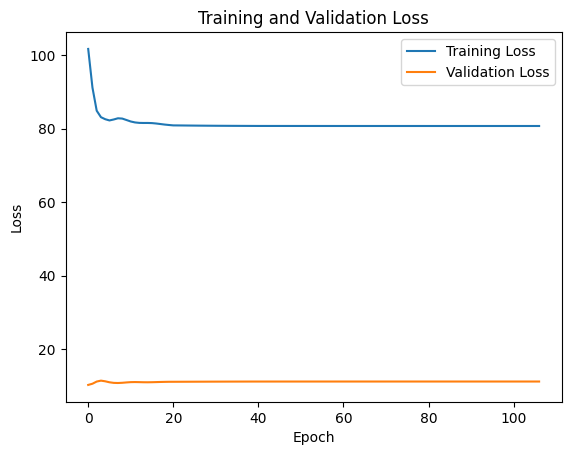

Model saved to models/gat_1l_mutag.pth
Average Time per Epoch: 0.09s
Average CPU Usage: 10.14%
Average Memory Usage: 0.25GB
Average GPU Usage: 0.00GB
Average GPU Utilization: 0.00%

Total Training Time: 10.10s
Max CPU Usage: 58.85%
Max Memory Usage: 0.26GB
Max GPU Usage: 0.00GB
Max GPU Utilization: 0.00%


In [13]:
set_seed(42)
gat1_mutag = GAT1Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
print(gat1_mutag)
print(f"Total number of trainable parameters: {(gat1_mutag.count_parameters())*2}\n")
single_train(gat1_mutag, mutag_train_loader, mutag_val_loader, lr=0.01, 
            num_epochs=500, step_size=20, save_path='models/gat_1l_mutag.pth')

In [14]:
gat1_mutag = GAT1Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
gat1_mutag.load_state_dict(torch.load('models/gat_1l_mutag.pth'))
single_test(gat1_mutag.to(device), mutag_test_loader)
inference_performance(gat1_mutag.to(device), mutag_test_loader)

Accuracy: 0.6842
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0000

Average Inference Time per Batch: 0.0044s
Average CPU Usage: 16.43%
Average Memory Usage: 0.25GB
Average GPU Usage: 0.00GB
Average GPU Utilization: 0.00%


#### PROTEINS

#### DND

#### ENZYM

#### OASIS

#### EMCI-AD

#### SLIM160

### GAT 2-Layer

#### MUTAG

#### PROTEINS

#### DND

#### ENZYM

#### OASIS

#### EMCI-AD

#### SLIM160

## GCN

### GCN 1-Layer

#### MUTAG

GCN1Layer(
  (gcn1): GCN (7 -> 14)
  (bn1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 340


Fold 1/3
Epoch 1, Train Loss: 72.89328575134277, Val Loss: 8.745145559310913
Time: 1.16s, CPU: 18.20%, Memory: 4.03GB, GPU: 0.01GB, GPU Util: 2.50%
Epoch 2, Train Loss: 66.59961128234863, Val Loss: 8.464079678058624
Time: 0.01s, CPU: 24.45%, Memory: 4.82GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 3, Train Loss: 64.71770572662354, Val Loss: 8.401366353034973
Time: 0.01s, CPU: 23.65%, Memory: 4.82GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 4, Train Loss: 64.00855493545532, Val Loss: 8.439120650291443
Time: 0.01s, CPU: 16.65%, Memory: 4.82GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 5, Train Loss: 63.37956237792969, Val Loss: 8.437415957450867
Time: 0.01s, CPU: 13.65%, Memory: 4.82GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 6, Train Loss: 62.37946319580078, Val Loss: 8.387083351612091


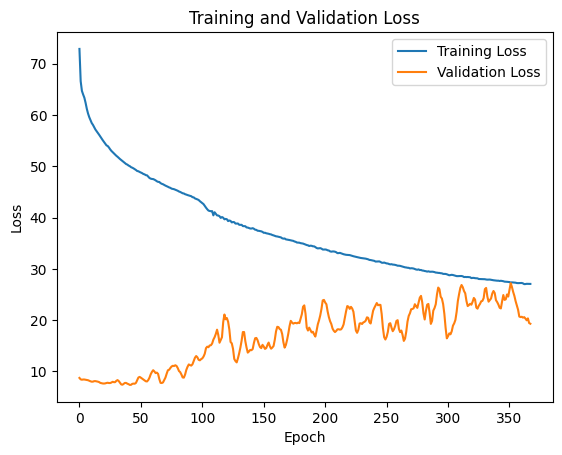

Model saved to models/gcn_1l_mutag.pth
Average Time per Epoch: 0.02s
Average CPU Usage: 18.90%
Average Memory Usage: 4.82GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 5.17%

Total Training Time: 6.27s
Max CPU Usage: 52.60%
Max Memory Usage: 4.82GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 6.00%
Fold 1 Results:
Accuracy: 0.6825
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0909

Fold 2/3
Epoch 1, Train Loss: 72.24380588531494, Val Loss: 8.892096281051636
Time: 0.01s, CPU: 37.90%, Memory: 4.83GB, GPU: 0.02GB, GPU Util: 4.00%
Epoch 2, Train Loss: 64.45395278930664, Val Loss: 8.959382057189941
Time: 0.01s, CPU: 24.30%, Memory: 4.83GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 3, Train Loss: 61.45788288116455, Val Loss: 9.293700218200684
Time: 0.01s, CPU: 30.95%, Memory: 4.83GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 4, Train Loss: 59.70909070968628, Val Loss: 9.547305822372437
Time: 0.01s, CPU: 20.00%, Memory: 4.83GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 5, Train Loss: 57.7092103

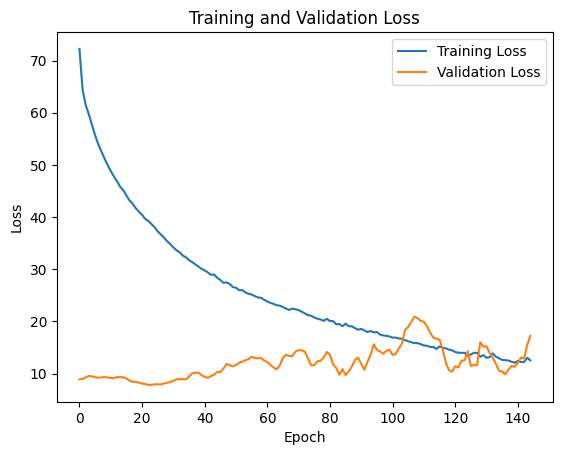

Model saved to models/gcn_1l_mutag.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 12.53%
Average Memory Usage: 4.83GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 5.22%

Total Training Time: 2.01s
Max CPU Usage: 37.90%
Max Memory Usage: 4.83GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 7.00%
Fold 2 Results:
Accuracy: 0.7302
Average Sensitivity (Recall): 0.8571
Average Specificity: 0.4762

Fold 3/3
Epoch 1, Train Loss: 74.5216588973999, Val Loss: 8.512852489948273
Time: 0.02s, CPU: 23.40%, Memory: 4.83GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 2, Train Loss: 67.91025590896606, Val Loss: 7.896107792854309
Time: 0.02s, CPU: 19.30%, Memory: 4.83GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 3, Train Loss: 65.1229213476181, Val Loss: 7.568831562995911
Time: 0.01s, CPU: 8.35%, Memory: 4.83GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 4, Train Loss: 63.30311167240143, Val Loss: 7.398321211338043
Time: 0.01s, CPU: 9.10%, Memory: 4.83GB, GPU: 0.02GB, GPU Util: 4.00%
Epoch 5, Train Loss: 61.56655877828

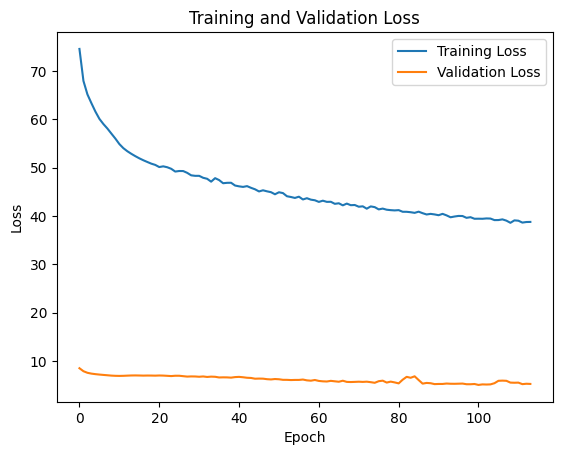

Model saved to models/gcn_1l_mutag.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 12.98%
Average Memory Usage: 4.83GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 5.13%

Total Training Time: 1.56s
Max CPU Usage: 43.20%
Max Memory Usage: 4.83GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 6.00%
Fold 3 Results:
Accuracy: 0.8226
Average Sensitivity (Recall): 0.9048
Average Specificity: 0.6500
Cross-Validation Results:
accuracy: Mean = 0.7451, Std = 0.0581
sensitivity: Mean = 0.9206, Std = 0.0594
specificity: Mean = 0.4057, Std = 0.2336


In [7]:
set_seed(42)
gcn1_mutag = GCN1Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
print(gcn1_mutag)
print(f"Total number of trainable parameters: {(gcn1_mutag.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn1_mutag, mutag_dataset, 
            lr=0.01, num_epochs=500, step_size=500, save_path='models/gcn_1l_mutag.pth')

#### PROTEINS

GCN1Layer(
  (gcn1): GCN (3 -> 9)
  (bn1): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=9, out_features=2, bias=True)
)
Total number of trainable parameters: 148


Fold 1/3
Epoch 1, Train Loss: 513.4771944284439, Val Loss: 86.02500200271606
Time: 0.20s, CPU: 22.20%, Memory: 3.28GB, GPU: 0.02GB, GPU Util: 2.50%
Epoch 2, Train Loss: 444.3641494512558, Val Loss: 82.76935625076294
Time: 0.10s, CPU: 14.05%, Memory: 3.28GB, GPU: 0.02GB, GPU Util: 5.00%
Epoch 3, Train Loss: 439.1010845899582, Val Loss: 79.74552702903748
Time: 0.11s, CPU: 13.10%, Memory: 3.28GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 4, Train Loss: 441.86581909656525, Val Loss: 77.65915763378143
Time: 0.12s, CPU: 9.60%, Memory: 3.28GB, GPU: 0.02GB, GPU Util: 7.50%
Epoch 5, Train Loss: 443.61632537841797, Val Loss: 75.652871966362
Time: 0.12s, CPU: 18.70%, Memory: 3.28GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 6, Train Loss: 444.3324224948883, Val Loss: 74.38704842329025
Time

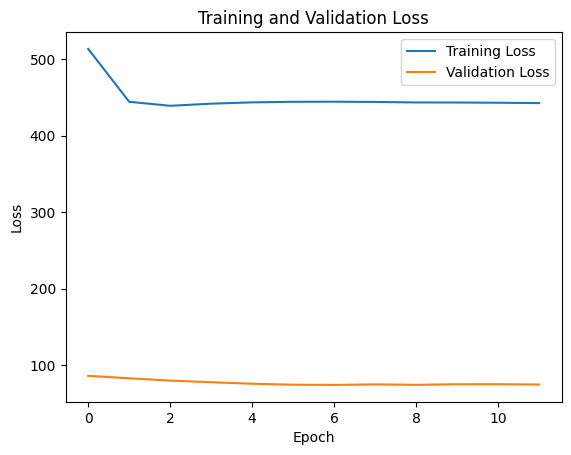

Model saved to models/gcn_1l_proteins.pth
Average Time per Epoch: 0.12s
Average CPU Usage: 13.85%
Average Memory Usage: 3.28GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 7.17%

Total Training Time: 1.42s
Max CPU Usage: 22.20%
Max Memory Usage: 3.28GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 9.00%
Fold 1 Results:
Accuracy: 0.6280
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Fold 2/3
Epoch 1, Train Loss: 507.7379914522171, Val Loss: 86.24062716960907
Time: 0.10s, CPU: 19.75%, Memory: 3.29GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 439.2324194908142, Val Loss: 82.21757853031158
Time: 0.10s, CPU: 9.65%, Memory: 3.29GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 3, Train Loss: 435.2108315229416, Val Loss: 78.94322752952576
Time: 0.10s, CPU: 12.55%, Memory: 3.29GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 4, Train Loss: 438.59439158439636, Val Loss: 76.90000712871552
Time: 0.10s, CPU: 11.60%, Memory: 3.29GB, GPU: 0.02GB, GPU Util: 9.00%
Epoch 5, Train Loss: 439.743

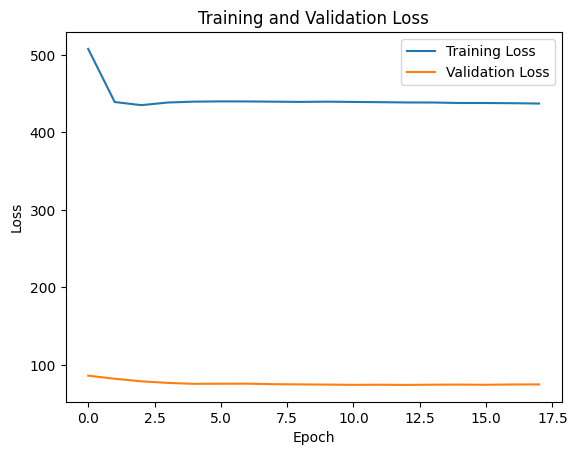

Model saved to models/gcn_1l_proteins.pth
Average Time per Epoch: 0.11s
Average CPU Usage: 22.64%
Average Memory Usage: 3.29GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 7.56%

Total Training Time: 1.97s
Max CPU Usage: 47.70%
Max Memory Usage: 3.29GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 9.00%
Fold 2 Results:
Accuracy: 0.6038
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Fold 3/3
Epoch 1, Train Loss: 487.46719908714294, Val Loss: 90.35837471485138
Time: 0.16s, CPU: 51.20%, Memory: 3.29GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 2, Train Loss: 426.0480377674103, Val Loss: 90.8674464225769
Time: 0.11s, CPU: 63.75%, Memory: 3.29GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 3, Train Loss: 423.44240510463715, Val Loss: 87.55564737319946
Time: 0.11s, CPU: 52.65%, Memory: 3.29GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 4, Train Loss: 426.17325580120087, Val Loss: 85.67183876037598
Time: 0.15s, CPU: 54.25%, Memory: 3.29GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 5, Train Loss: 427.2

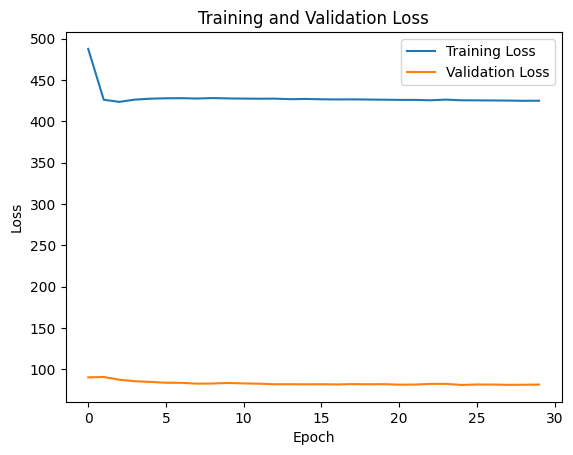

Model saved to models/gcn_1l_proteins.pth
Average Time per Epoch: 0.12s
Average CPU Usage: 22.69%
Average Memory Usage: 3.29GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 7.42%

Total Training Time: 3.47s
Max CPU Usage: 63.90%
Max Memory Usage: 3.29GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 9.00%
Fold 3 Results:
Accuracy: 0.5553
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000
Cross-Validation Results:
accuracy: Mean = 0.5957, Std = 0.0303
sensitivity: Mean = 0.0000, Std = 0.0000
specificity: Mean = 1.0000, Std = 0.0000


In [11]:
set_seed(42)
gcn1_proteins = GCN1Layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes)
print(gcn1_proteins)
print(f"Total number of trainable parameters: {(gcn1_proteins.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn1_proteins, proteins_dataset,
            lr=0.005, num_epochs=500, step_size=100, save_path='models/gcn_1l_proteins.pth')

#### DND

GCN1Layer(
  (gcn1): GCN (89 -> 178)
  (bn1): BatchNorm1d(178, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=178, out_features=2, bias=True)
)
Total number of trainable parameters: 33468


Fold 1/3
Epoch 1, Train Loss: 1703.9491577293957, Val Loss: 49.39025169610977
Time: 0.75s, CPU: 19.30%, Memory: 3.30GB, GPU: 0.02GB, GPU Util: 30.00%
Epoch 2, Train Loss: 1308.5812230110168, Val Loss: 97.01936113834381
Time: 0.62s, CPU: 28.20%, Memory: 3.30GB, GPU: 0.02GB, GPU Util: 66.50%
Epoch 3, Train Loss: 551.4770159721375, Val Loss: 53.970590233802795
Time: 0.68s, CPU: 28.65%, Memory: 3.30GB, GPU: 0.02GB, GPU Util: 69.00%
Epoch 4, Train Loss: 649.6420783996582, Val Loss: 68.28375595808029
Time: 0.74s, CPU: 26.60%, Memory: 3.31GB, GPU: 0.02GB, GPU Util: 67.00%
Epoch 5, Train Loss: 558.164476275444, Val Loss: 65.67465001344681
Time: 0.86s, CPU: 38.35%, Memory: 3.31GB, GPU: 0.02GB, GPU Util: 51.50%
Epoch 6, Train Loss: 544.6113193035126, Val Loss: 67.00

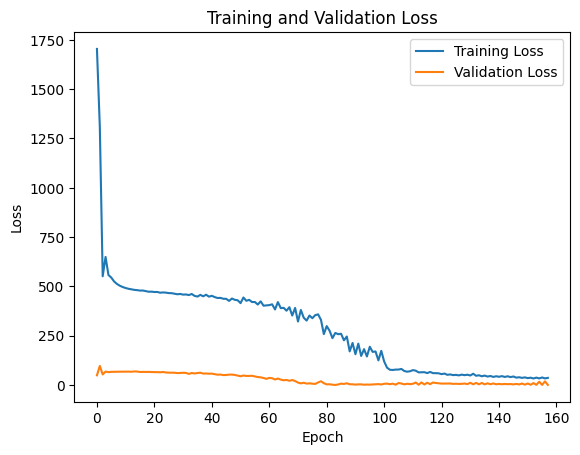

Model saved to models/gcn_1l_dnd.pth
Average Time per Epoch: 0.96s
Average CPU Usage: 40.46%
Average Memory Usage: 3.31GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 49.03%

Total Training Time: 151.69s
Max CPU Usage: 67.85%
Max Memory Usage: 3.31GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 78.00%
Fold 1 Results:
Accuracy: 0.4020
Average Sensitivity (Recall): 0.9745
Average Specificity: 0.0212

Fold 2/3
Epoch 1, Train Loss: 1722.8057385006687, Val Loss: 48.69961619377136
Time: 0.72s, CPU: 53.55%, Memory: 3.31GB, GPU: 0.02GB, GPU Util: 48.00%
Epoch 2, Train Loss: 1313.206226348877, Val Loss: 100.36702513694763
Time: 0.61s, CPU: 26.80%, Memory: 3.31GB, GPU: 0.03GB, GPU Util: 70.50%
Epoch 3, Train Loss: 559.9414162635803, Val Loss: 51.18222916126251
Time: 1.10s, CPU: 58.20%, Memory: 3.31GB, GPU: 0.03GB, GPU Util: 39.50%
Epoch 4, Train Loss: 663.1606466770172, Val Loss: 65.89726197719574
Time: 1.13s, CPU: 60.45%, Memory: 3.31GB, GPU: 0.03GB, GPU Util: 35.50%
Epoch 5, Train Loss: 56

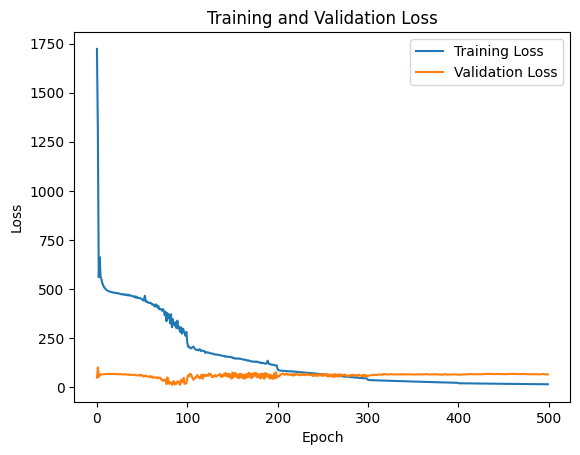

Model saved to models/gcn_1l_dnd.pth
Average Time per Epoch: 0.86s
Average CPU Usage: 42.36%
Average Memory Usage: 3.31GB
Average GPU Usage: 0.03GB
Average GPU Utilization: 52.05%

Total Training Time: 431.26s
Max CPU Usage: 72.30%
Max Memory Usage: 3.31GB
Max GPU Usage: 0.03GB
Max GPU Utilization: 77.50%
Fold 2 Results:
Accuracy: 0.5980
Average Sensitivity (Recall): 0.6184
Average Specificity: 0.5851

Fold 3/3
Epoch 1, Train Loss: 1703.5063795117894, Val Loss: 82.8854306936264
Time: 1.27s, CPU: 70.35%, Memory: 3.31GB, GPU: 0.02GB, GPU Util: 29.50%
Epoch 2, Train Loss: 1144.5747295618057, Val Loss: 111.3705426454544
Time: 1.29s, CPU: 59.55%, Memory: 3.31GB, GPU: 0.03GB, GPU Util: 32.50%
Epoch 3, Train Loss: 555.0404025912285, Val Loss: 64.49335497617722
Time: 1.24s, CPU: 59.80%, Memory: 3.31GB, GPU: 0.03GB, GPU Util: 33.50%
Epoch 4, Train Loss: 636.177361369133, Val Loss: 81.64440381526947
Time: 1.02s, CPU: 57.30%, Memory: 3.31GB, GPU: 0.03GB, GPU Util: 37.50%
Epoch 5, Train Loss: 547.

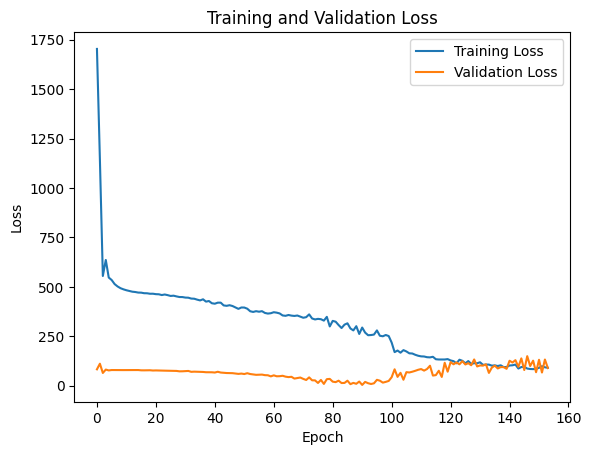

Model saved to models/gcn_1l_dnd.pth
Average Time per Epoch: 0.97s
Average CPU Usage: 48.11%
Average Memory Usage: 3.31GB
Average GPU Usage: 0.03GB
Average GPU Utilization: 48.11%

Total Training Time: 149.11s
Max CPU Usage: 71.75%
Max Memory Usage: 3.31GB
Max GPU Usage: 0.03GB
Max GPU Utilization: 74.50%
Fold 3 Results:
Accuracy: 0.5485
Average Sensitivity (Recall): 0.0618
Average Specificity: 0.9533
Cross-Validation Results:
accuracy: Mean = 0.5162, Std = 0.0832
sensitivity: Mean = 0.5516, Std = 0.3756
specificity: Mean = 0.5198, Std = 0.3833


In [13]:
set_seed(42)
gcn1_dnd = GCN1Layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes)
print(gcn1_dnd)
print(f"Total number of trainable parameters: {(gcn1_dnd.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn1_dnd, dd_dataset, lr=0.01, 
            num_epochs=500, step_size=100, gamma=0.5, save_path='models/gcn_1l_dnd.pth')

#### ENZYM

GCN1Layer(
  (gcn1): GCN (3 -> 9)
  (bn1): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=9, out_features=6, bias=True)
)
Total number of trainable parameters: 228


Fold 1/3
Epoch 1, Train Loss: 706.2218265533447, Val Loss: 67.38955307006836
Time: 0.11s, CPU: 70.95%, Memory: 3.31GB, GPU: 0.02GB, GPU Util: 7.50%
Epoch 2, Train Loss: 658.2873287200928, Val Loss: 71.2614688873291
Time: 0.06s, CPU: 48.65%, Memory: 3.31GB, GPU: 0.02GB, GPU Util: 2.50%
Epoch 3, Train Loss: 648.4938373565674, Val Loss: 75.86142253875732
Time: 0.08s, CPU: 45.95%, Memory: 3.31GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 4, Train Loss: 644.1818962097168, Val Loss: 78.8985538482666
Time: 0.07s, CPU: 50.50%, Memory: 3.31GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 5, Train Loss: 642.2321929931641, Val Loss: 80.0836410522461
Time: 0.07s, CPU: 34.20%, Memory: 3.31GB, GPU: 0.02GB, GPU Util: 4.00%
Epoch 6, Train Loss: 641.0061950683594, Val Loss: 80.3148889541626
Time: 0

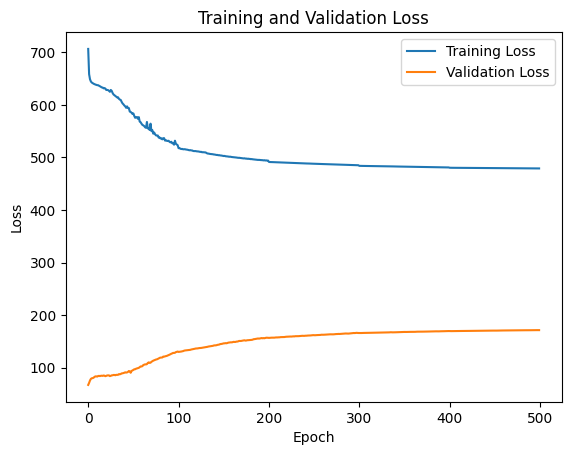

Model saved to models/gcn_1l_enzymes.pth
Average Time per Epoch: 0.07s
Average CPU Usage: 22.42%
Average Memory Usage: 3.31GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 6.13%

Total Training Time: 32.64s
Max CPU Usage: 70.95%
Max Memory Usage: 3.31GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 8.00%
Fold 1 Results:
Accuracy: 0.1800
Average Sensitivity (Recall): 0.1818
Average Specificity: 0.8364

Fold 2/3
Epoch 1, Train Loss: 701.3814392089844, Val Loss: 69.23331642150879
Time: 0.06s, CPU: 31.20%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 2, Train Loss: 654.032301902771, Val Loss: 74.45863342285156
Time: 0.06s, CPU: 19.85%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 3, Train Loss: 644.4715795516968, Val Loss: 78.62784004211426
Time: 0.07s, CPU: 22.10%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 4.00%
Epoch 4, Train Loss: 641.1272172927856, Val Loss: 80.60891723632812
Time: 0.07s, CPU: 25.50%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 5, Train Loss: 638.1595

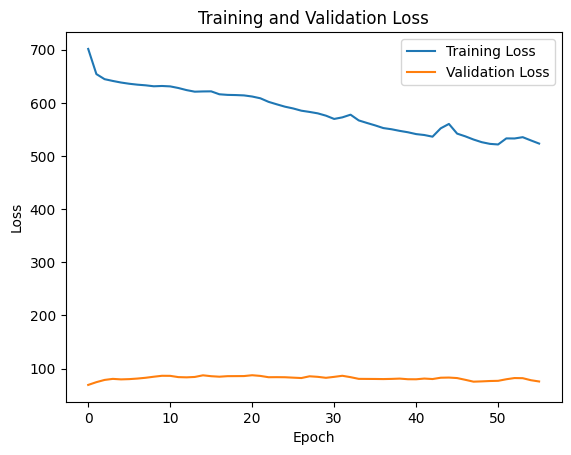

Model saved to models/gcn_1l_enzymes.pth
Average Time per Epoch: 0.06s
Average CPU Usage: 23.06%
Average Memory Usage: 3.32GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 5.95%

Total Training Time: 3.57s
Max CPU Usage: 55.55%
Max Memory Usage: 3.32GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 8.00%
Fold 2 Results:
Accuracy: 0.2450
Average Sensitivity (Recall): 0.2583
Average Specificity: 0.8511

Fold 3/3
Epoch 1, Train Loss: 705.3992118835449, Val Loss: 66.1321792602539
Time: 0.06s, CPU: 21.65%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 657.2709522247314, Val Loss: 68.73206615447998
Time: 0.06s, CPU: 10.00%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 3, Train Loss: 646.823616027832, Val Loss: 72.49704265594482
Time: 0.06s, CPU: 11.00%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 4, Train Loss: 639.8458185195923, Val Loss: 75.96256828308105
Time: 0.06s, CPU: 10.25%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 5, Train Loss: 637.837376

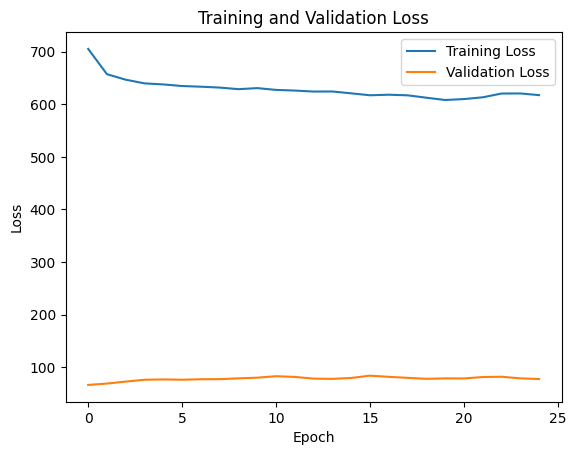

Model saved to models/gcn_1l_enzymes.pth
Average Time per Epoch: 0.06s
Average CPU Usage: 14.04%
Average Memory Usage: 3.32GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 6.14%

Total Training Time: 1.51s
Max CPU Usage: 25.75%
Max Memory Usage: 3.32GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 7.00%
Fold 3 Results:
Accuracy: 0.2350
Average Sensitivity (Recall): 0.2449
Average Specificity: 0.8475
Cross-Validation Results:
accuracy: Mean = 0.2200, Std = 0.0286
sensitivity: Mean = 0.2283, Std = 0.0334
specificity: Mean = 0.8450, Std = 0.0063


In [14]:
set_seed(42)
gcn1_enzymes = GCN1Layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes)
print(gcn1_enzymes)
print(f"Total number of trainable parameters: {(gcn1_enzymes.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn1_enzymes, enzymes_dataset, lr=0.01, 
            num_epochs=500, step_size=100, gamma=0.5, save_path='models/gcn_1l_enzymes.pth', 
            binary_classification=False)

#### OASIS

GCN1Layer(
  (gcn1): GCN (8 -> 16)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=16, out_features=3, bias=True)
)
Total number of trainable parameters: 454


Fold 1/3
Epoch 1, Train Loss: 227.5981878042221, Val Loss: 25.688652634620667
Time: 0.04s, CPU: 19.80%, Memory: 3.87GB, GPU: 0.23GB, GPU Util: 0.00%
Epoch 2, Train Loss: 226.48972642421722, Val Loss: 25.612687945365906
Time: 0.04s, CPU: 24.35%, Memory: 3.87GB, GPU: 0.23GB, GPU Util: 2.50%
Epoch 3, Train Loss: 225.6341108083725, Val Loss: 25.523093700408936
Time: 0.04s, CPU: 31.40%, Memory: 3.87GB, GPU: 0.23GB, GPU Util: 5.00%
Epoch 4, Train Loss: 224.9972175359726, Val Loss: 25.416966319084167
Time: 0.05s, CPU: 44.25%, Memory: 3.87GB, GPU: 0.23GB, GPU Util: 5.00%
Epoch 5, Train Loss: 224.54678869247437, Val Loss: 25.294664978981018
Time: 0.05s, CPU: 49.85%, Memory: 3.87GB, GPU: 0.23GB, GPU Util: 5.00%
Epoch 6, Train Loss: 224.24221467971802, Val Loss: 25.1604888

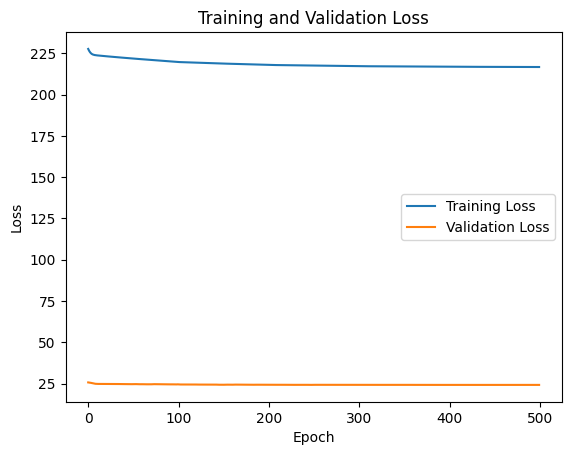

Model saved to models/gcn_1l_oasis.pth
Average Time per Epoch: 0.04s
Average CPU Usage: 26.44%
Average Memory Usage: 3.87GB
Average GPU Usage: 0.23GB
Average GPU Utilization: 6.11%

Total Training Time: 21.41s
Max CPU Usage: 72.20%
Max Memory Usage: 3.87GB
Max GPU Usage: 0.23GB
Max GPU Utilization: 8.00%
Fold 1 Results:
Accuracy: 0.2456
Average Sensitivity (Recall): 0.3206
Average Specificity: 0.6631

Fold 2/3
Epoch 1, Train Loss: 224.35085332393646, Val Loss: 24.954208493232727
Time: 0.05s, CPU: 22.90%, Memory: 3.87GB, GPU: 0.23GB, GPU Util: 1.00%
Epoch 2, Train Loss: 224.19559383392334, Val Loss: 24.945802092552185
Time: 0.04s, CPU: 13.35%, Memory: 3.87GB, GPU: 0.23GB, GPU Util: 1.00%
Epoch 3, Train Loss: 224.11433577537537, Val Loss: 24.942574977874756
Time: 0.04s, CPU: 12.70%, Memory: 3.87GB, GPU: 0.23GB, GPU Util: 1.00%
Epoch 4, Train Loss: 224.0465521812439, Val Loss: 24.94154679775238
Time: 0.04s, CPU: 9.10%, Memory: 3.87GB, GPU: 0.23GB, GPU Util: 3.50%
Epoch 5, Train Loss: 223.

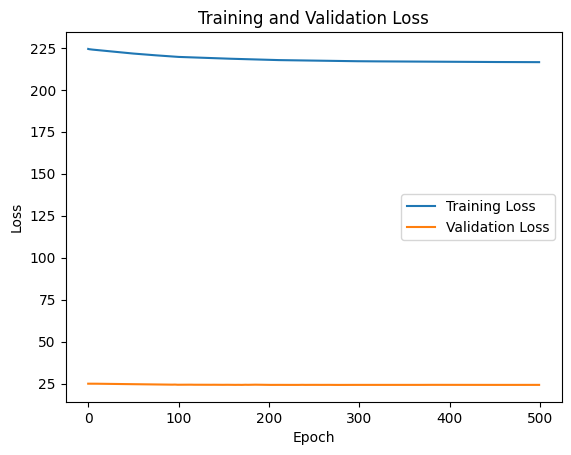

Model saved to models/gcn_1l_oasis.pth
Average Time per Epoch: 0.04s
Average CPU Usage: 26.60%
Average Memory Usage: 3.87GB
Average GPU Usage: 0.23GB
Average GPU Utilization: 6.01%

Total Training Time: 21.44s
Max CPU Usage: 77.10%
Max Memory Usage: 3.87GB
Max GPU Usage: 0.23GB
Max GPU Utilization: 8.00%
Fold 2 Results:
Accuracy: 0.3070
Average Sensitivity (Recall): 0.3543
Average Specificity: 0.6736

Fold 3/3
Epoch 1, Train Loss: 226.63850903511047, Val Loss: 25.203518867492676
Time: 0.06s, CPU: 51.25%, Memory: 3.87GB, GPU: 0.23GB, GPU Util: 0.00%
Epoch 2, Train Loss: 225.93593561649323, Val Loss: 25.179569125175476
Time: 0.06s, CPU: 55.55%, Memory: 3.87GB, GPU: 0.23GB, GPU Util: 0.00%
Epoch 3, Train Loss: 225.50452268123627, Val Loss: 25.161602020263672
Time: 0.05s, CPU: 47.95%, Memory: 3.87GB, GPU: 0.23GB, GPU Util: 2.50%
Epoch 4, Train Loss: 225.23199272155762, Val Loss: 25.144542455673218
Time: 0.04s, CPU: 34.90%, Memory: 3.87GB, GPU: 0.23GB, GPU Util: 5.00%
Epoch 5, Train Loss: 2

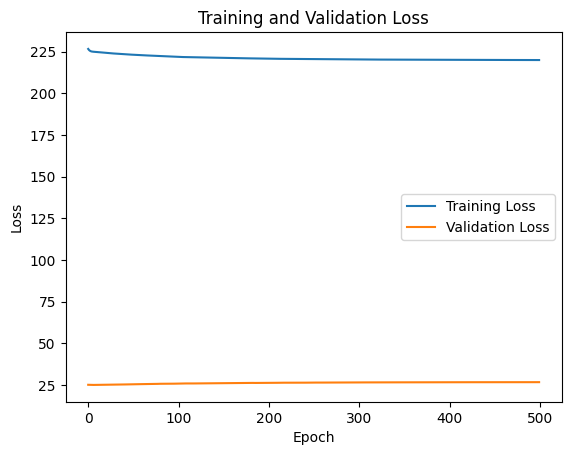

Model saved to models/gcn_1l_oasis.pth
Average Time per Epoch: 0.04s
Average CPU Usage: 27.95%
Average Memory Usage: 3.87GB
Average GPU Usage: 0.23GB
Average GPU Utilization: 5.93%

Total Training Time: 22.02s
Max CPU Usage: 61.50%
Max Memory Usage: 3.87GB
Max GPU Usage: 0.23GB
Max GPU Utilization: 7.00%
Fold 3 Results:
Accuracy: 0.3070
Average Sensitivity (Recall): 0.3133
Average Specificity: 0.6573
Cross-Validation Results:
accuracy: Mean = 0.2865, Std = 0.0289
sensitivity: Mean = 0.3294, Std = 0.0179
specificity: Mean = 0.6647, Std = 0.0067


In [48]:
set_seed(42)
gcn1_oasis = GCN1Layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes)
print(gcn1_oasis)
print(f"Total number of trainable parameters: {(gcn1_oasis.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn1_oasis, oasis_dataset, lr=0.001, 
            num_epochs=500, step_size=100, save_path='models/gcn_1l_oasis.pth', binary_classification=False)

#### EMCI-AD

GCN1Layer(
  (gcn1): GCN (8 -> 16)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=16, out_features=2, bias=True)
)
Total number of trainable parameters: 420


Fold 1/3
Epoch 1, Train Loss: 56.2371711730957, Val Loss: 6.183013200759888
Time: 0.02s, CPU: 24.60%, Memory: 4.41GB, GPU: 0.24GB, GPU Util: 0.00%
Epoch 2, Train Loss: 55.28842258453369, Val Loss: 6.196059465408325
Time: 0.02s, CPU: 34.50%, Memory: 4.41GB, GPU: 0.24GB, GPU Util: 0.00%
Epoch 3, Train Loss: 55.47053623199463, Val Loss: 6.202880322933197
Time: 0.02s, CPU: 60.00%, Memory: 4.41GB, GPU: 0.24GB, GPU Util: 1.50%
Epoch 4, Train Loss: 55.70422554016113, Val Loss: 6.199311375617981
Time: 0.01s, CPU: 50.00%, Memory: 4.41GB, GPU: 0.24GB, GPU Util: 3.00%
Epoch 5, Train Loss: 55.57925605773926, Val Loss: 6.192447602748871
Time: 0.02s, CPU: 19.25%, Memory: 4.41GB, GPU: 0.24GB, GPU Util: 3.00%
Epoch 6, Train Loss: 55.399404525756836, Val Loss: 6.188939809799194


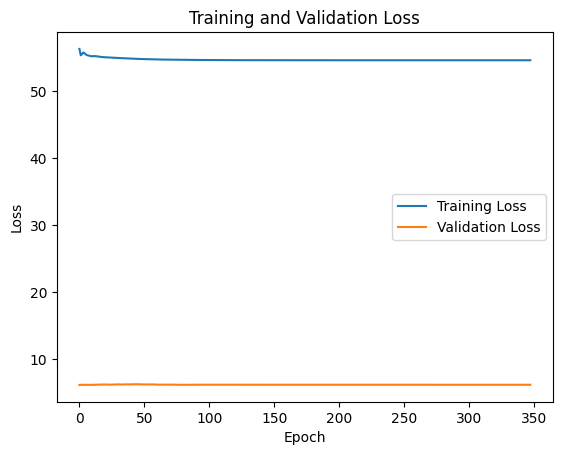

Model saved to models/gcn_1l_emci.pth
Average Time per Epoch: 0.02s
Average CPU Usage: 31.72%
Average Memory Usage: 4.41GB
Average GPU Usage: 0.24GB
Average GPU Utilization: 4.96%

Total Training Time: 6.68s
Max CPU Usage: 78.15%
Max Memory Usage: 4.41GB
Max GPU Usage: 0.24GB
Max GPU Utilization: 6.00%
Fold 1 Results:
Accuracy: 0.5111
Average Sensitivity (Recall): 0.4545
Average Specificity: 0.5652

Fold 2/3
Epoch 1, Train Loss: 55.85672473907471, Val Loss: 6.18305504322052
Time: 0.02s, CPU: 34.00%, Memory: 4.41GB, GPU: 0.24GB, GPU Util: 4.00%
Epoch 2, Train Loss: 55.41728210449219, Val Loss: 6.181796550750732
Time: 0.02s, CPU: 26.80%, Memory: 4.41GB, GPU: 0.24GB, GPU Util: 1.00%
Epoch 3, Train Loss: 55.33093452453613, Val Loss: 6.1818442940711975
Time: 0.02s, CPU: 24.00%, Memory: 4.41GB, GPU: 0.24GB, GPU Util: 1.00%
Epoch 4, Train Loss: 55.340925216674805, Val Loss: 6.182133436203003
Time: 0.02s, CPU: 25.00%, Memory: 4.41GB, GPU: 0.24GB, GPU Util: 1.00%
Epoch 5, Train Loss: 55.3528099

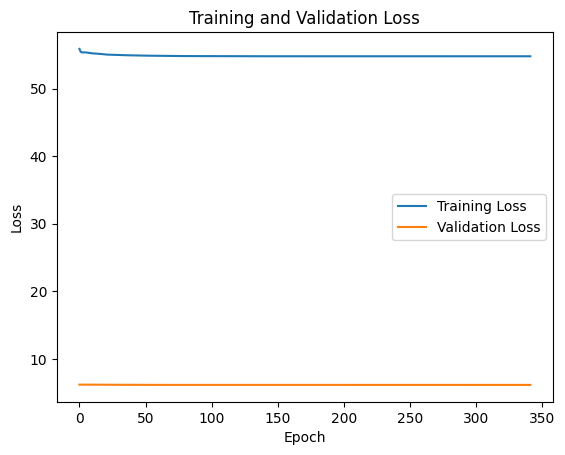

Model saved to models/gcn_1l_emci.pth
Average Time per Epoch: 0.02s
Average CPU Usage: 28.96%
Average Memory Usage: 4.41GB
Average GPU Usage: 0.24GB
Average GPU Utilization: 4.66%

Total Training Time: 6.68s
Max CPU Usage: 69.55%
Max Memory Usage: 4.41GB
Max GPU Usage: 0.24GB
Max GPU Utilization: 6.00%
Fold 2 Results:
Accuracy: 0.4444
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0000

Fold 3/3
Epoch 1, Train Loss: 56.43902164697647, Val Loss: 6.283761262893677
Time: 0.02s, CPU: 30.80%, Memory: 4.41GB, GPU: 0.24GB, GPU Util: 0.00%
Epoch 2, Train Loss: 56.085543394088745, Val Loss: 6.2733312249183655
Time: 0.02s, CPU: 27.45%, Memory: 4.41GB, GPU: 0.24GB, GPU Util: 0.00%
Epoch 3, Train Loss: 55.93235546350479, Val Loss: 6.306277871131897
Time: 0.02s, CPU: 20.85%, Memory: 4.41GB, GPU: 0.24GB, GPU Util: 0.00%
Epoch 4, Train Loss: 55.73848295211792, Val Loss: 6.3354527950286865
Time: 0.02s, CPU: 22.65%, Memory: 4.41GB, GPU: 0.24GB, GPU Util: 0.00%
Epoch 5, Train Loss: 55.69721

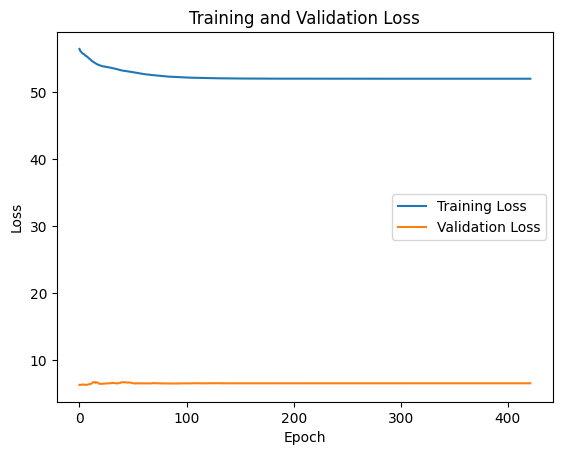

Model saved to models/gcn_1l_emci.pth
Average Time per Epoch: 0.02s
Average CPU Usage: 33.70%
Average Memory Usage: 4.41GB
Average GPU Usage: 0.24GB
Average GPU Utilization: 4.91%

Total Training Time: 8.25s
Max CPU Usage: 74.25%
Max Memory Usage: 4.41GB
Max GPU Usage: 0.24GB
Max GPU Utilization: 7.00%
Fold 3 Results:
Accuracy: 0.4773
Average Sensitivity (Recall): 0.1600
Average Specificity: 0.8947
Cross-Validation Results:
accuracy: Mean = 0.4776, Std = 0.0272
sensitivity: Mean = 0.5382, Std = 0.3480
specificity: Mean = 0.4867, Std = 0.3695


In [95]:
set_seed(42)
gcn1_emci = GCN1Layer(emci_num_features, 2*emci_num_features, emci_num_classes)
print(gcn1_emci)
print(f"Total number of trainable parameters: {(gcn1_emci.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn1_emci, emci_dataset, 
            lr=0.01, num_epochs=500, step_size=20, patience=20, save_path='models/gcn_1l_emci.pth')


### GCN 2-Layer

#### MUTAG

GCN2Layer(
  (gcn1): GCN (7 -> 14)
  (bn1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (14 -> 28)
  (bn2): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=28, out_features=2, bias=True)
)
Total number of trainable parameters: 1348


Fold 1/3
Epoch 1, Train Loss: 83.66287612915039, Val Loss: 8.50164258480072
Time: 0.02s, CPU: 17.05%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 2, Train Loss: 59.915454387664795, Val Loss: 8.616662859916687
Time: 0.02s, CPU: 8.80%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 3, Train Loss: 55.5466251373291, Val Loss: 8.83752053976059
Time: 0.03s, CPU: 29.00%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 4, Train Loss: 54.134233474731445, Val Loss: 9.020394563674927
Time: 0.02s, CPU: 18.80%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 2.50%
Epoch 5, Train Loss: 51.81713676452637, Val Loss: 8.706249117851257
Time: 0.02s, CPU: 11.25%, 

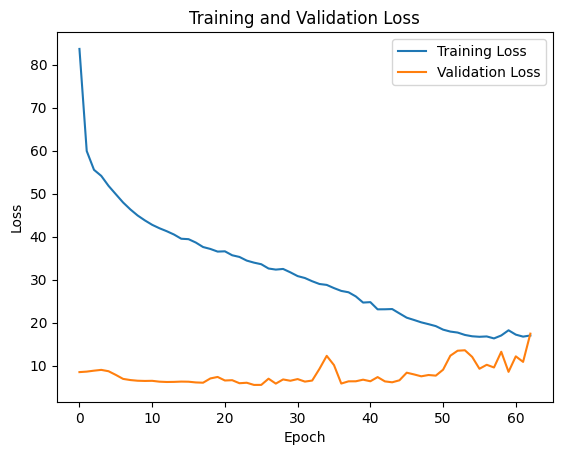

Model saved to models/gcn_2l_mutag.pth
Average Time per Epoch: 0.02s
Average CPU Usage: 17.49%
Average Memory Usage: 3.32GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 4.16%

Total Training Time: 1.50s
Max CPU Usage: 40.50%
Max Memory Usage: 3.32GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 5.00%
Fold 1 Results:
Accuracy: 0.8571
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.5909

Fold 2/3
Epoch 1, Train Loss: 80.44842338562012, Val Loss: 9.103970229625702
Time: 0.02s, CPU: 33.10%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 2, Train Loss: 54.432230949401855, Val Loss: 9.52761971950531
Time: 0.02s, CPU: 21.95%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 3, Train Loss: 48.88116455078125, Val Loss: 9.92852783203125
Time: 0.02s, CPU: 21.05%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 4, Train Loss: 45.90090751647949, Val Loss: 9.819641351699829
Time: 0.02s, CPU: 23.35%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 5, Train Loss: 43.30624103

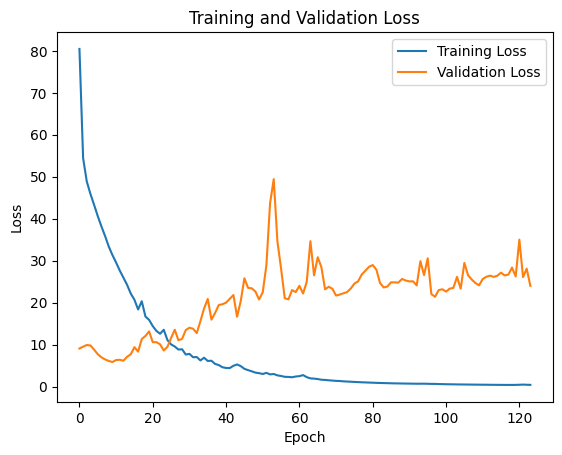

Model saved to models/gcn_2l_mutag.pth
Average Time per Epoch: 0.02s
Average CPU Usage: 15.68%
Average Memory Usage: 3.32GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 4.45%

Total Training Time: 2.92s
Max CPU Usage: 54.40%
Max Memory Usage: 3.32GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 6.00%
Fold 2 Results:
Accuracy: 0.7460
Average Sensitivity (Recall): 0.8333
Average Specificity: 0.5714

Fold 3/3
Epoch 1, Train Loss: 82.03822618722916, Val Loss: 7.740914881229401
Time: 0.02s, CPU: 18.95%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 58.69976365566254, Val Loss: 7.222551107406616
Time: 0.02s, CPU: 13.05%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 3, Train Loss: 52.96252661943436, Val Loss: 6.829142868518829
Time: 0.02s, CPU: 13.55%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 4, Train Loss: 49.48222905397415, Val Loss: 6.44471874833107
Time: 0.03s, CPU: 7.90%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 5, Train Loss: 46.112444400

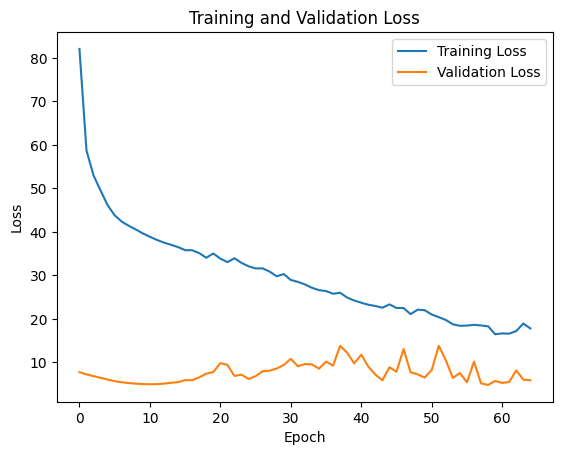

Model saved to models/gcn_2l_mutag.pth
Average Time per Epoch: 0.03s
Average CPU Usage: 18.85%
Average Memory Usage: 3.32GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 3.72%

Total Training Time: 1.73s
Max CPU Usage: 58.45%
Max Memory Usage: 3.32GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 5.00%
Fold 3 Results:
Accuracy: 0.7903
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.3500
Cross-Validation Results:
accuracy: Mean = 0.7978, Std = 0.0457
sensitivity: Mean = 0.9444, Std = 0.0786
specificity: Mean = 0.5041, Std = 0.1093


In [15]:
set_seed(42)
gcn2_mutag = GCN2Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
print(gcn2_mutag)
print(f"Total number of trainable parameters: {(gcn2_mutag.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn2_mutag, mutag_dataset, lr=0.01, 
            num_epochs=500, step_size=500, save_path='models/gcn_2l_mutag.pth')

#### PROTEINS

GCN2Layer(
  (gcn1): GCN (3 -> 9)
  (bn1): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (9 -> 18)
  (bn2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=18, out_features=2, bias=True)
)
Total number of trainable parameters: 616


Fold 1/3
Epoch 1, Train Loss: 579.125171661377, Val Loss: 110.21829056739807
Time: 0.14s, CPU: 31.55%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 428.1867845058441, Val Loss: 92.55316352844238
Time: 0.14s, CPU: 39.55%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 10.00%
Epoch 3, Train Loss: 431.22900569438934, Val Loss: 80.11479151248932
Time: 0.14s, CPU: 40.10%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 9.50%
Epoch 4, Train Loss: 438.5597712993622, Val Loss: 77.54355430603027
Time: 0.14s, CPU: 31.95%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 9.00%
Epoch 5, Train Loss: 440.82315850257874, Val Loss: 75.7956690788269
Time: 0.14s, CPU: 43.20%, 

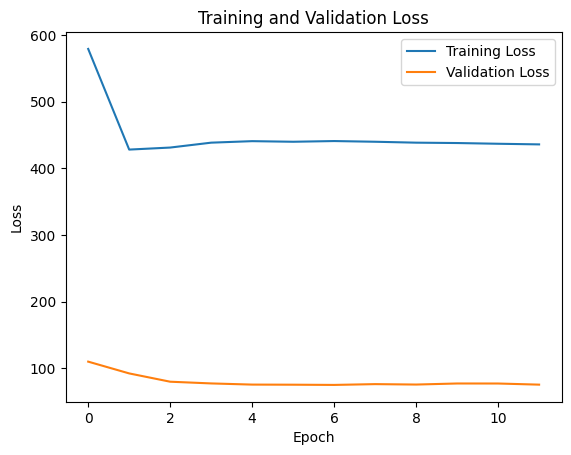

Model saved to models/gcn_2l_proteins.pth
Average Time per Epoch: 0.14s
Average CPU Usage: 38.38%
Average Memory Usage: 3.32GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 8.67%

Total Training Time: 1.67s
Max CPU Usage: 53.50%
Max Memory Usage: 3.32GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 10.00%
Fold 1 Results:
Accuracy: 0.6658
Average Sensitivity (Recall): 0.2029
Average Specificity: 0.9399

Fold 2/3
Epoch 1, Train Loss: 569.5154676437378, Val Loss: 104.63814461231232
Time: 0.12s, CPU: 32.95%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 4.50%
Epoch 2, Train Loss: 429.3684220314026, Val Loss: 90.86931502819061
Time: 0.12s, CPU: 27.80%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 9.00%
Epoch 3, Train Loss: 430.21358013153076, Val Loss: 78.60004806518555
Time: 0.12s, CPU: 28.05%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 10.50%
Epoch 4, Train Loss: 438.0946755409241, Val Loss: 73.73838913440704
Time: 0.12s, CPU: 23.45%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 10.00%
Epoch 5, Train Loss: 43

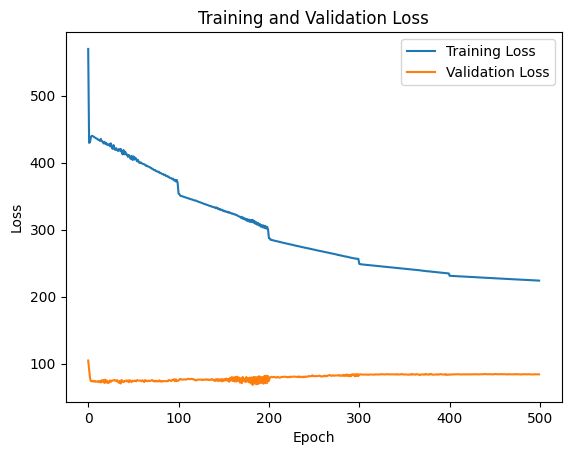

Model saved to models/gcn_2l_proteins.pth
Average Time per Epoch: 0.13s
Average CPU Usage: 22.83%
Average Memory Usage: 3.32GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 9.82%

Total Training Time: 64.07s
Max CPU Usage: 62.70%
Max Memory Usage: 3.32GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 13.00%
Fold 2 Results:
Accuracy: 0.5957
Average Sensitivity (Recall): 0.1361
Average Specificity: 0.8973

Fold 3/3
Epoch 1, Train Loss: 547.9686948060989, Val Loss: 115.36834192276001
Time: 0.11s, CPU: 20.10%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 5.50%
Epoch 2, Train Loss: 422.1962995529175, Val Loss: 99.81763482093811
Time: 0.12s, CPU: 13.25%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 3, Train Loss: 420.3149962425232, Val Loss: 88.93027198314667
Time: 0.10s, CPU: 13.70%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 11.50%
Epoch 4, Train Loss: 428.1533716917038, Val Loss: 84.62585961818695
Time: 0.12s, CPU: 9.60%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 12.00%
Epoch 5, Train Loss: 430

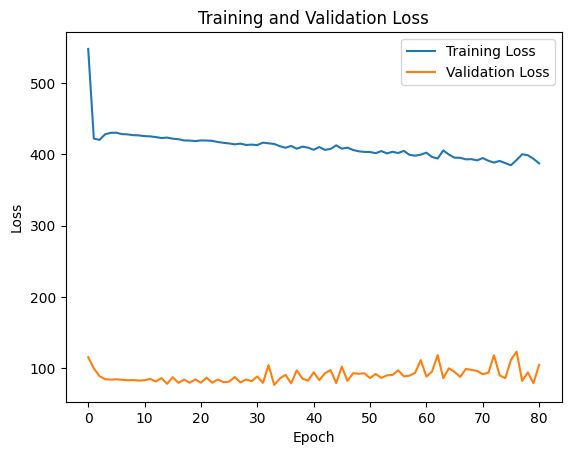

Model saved to models/gcn_2l_proteins.pth
Average Time per Epoch: 0.12s
Average CPU Usage: 22.76%
Average Memory Usage: 3.32GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 10.20%

Total Training Time: 10.09s
Max CPU Usage: 53.75%
Max Memory Usage: 3.32GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 12.00%
Fold 3 Results:
Accuracy: 0.5741
Average Sensitivity (Recall): 0.0485
Average Specificity: 0.9951
Cross-Validation Results:
accuracy: Mean = 0.6119, Std = 0.0391
sensitivity: Mean = 0.1291, Std = 0.0632
specificity: Mean = 0.9441, Std = 0.0400


In [16]:
set_seed(42)
gcn2_proteins = GCN2Layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes)
print(gcn2_proteins)
print(f"Total number of trainable parameters: {(gcn2_proteins.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn2_proteins, proteins_dataset, lr=0.005, 
            num_epochs=500, step_size=100, save_path='models/gcn_2l_proteins.pth')

#### DND

GCN2Layer(
  (gcn1): GCN (89 -> 178)
  (bn1): BatchNorm1d(178, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (178 -> 356)
  (bn2): BatchNorm1d(356, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=356, out_features=2, bias=True)
)
Total number of trainable parameters: 163052


Fold 1/3
Epoch 1, Train Loss: 2371.1002610423493, Val Loss: 4.052902448922396
Time: 1.93s, CPU: 44.20%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 28.50%
Epoch 2, Train Loss: 2126.009313106537, Val Loss: 147.64290940761566
Time: 1.84s, CPU: 40.10%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 59.50%
Epoch 3, Train Loss: 471.9135682582855, Val Loss: 55.42914664745331
Time: 1.52s, CPU: 22.80%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 59.00%
Epoch 4, Train Loss: 612.2877388000488, Val Loss: 74.83705884218216
Time: 1.89s, CPU: 37.30%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 58.00%
Epoch 5, Train Loss: 519.7577412128448, Val Loss: 70.53650856018066
Time: 1.3

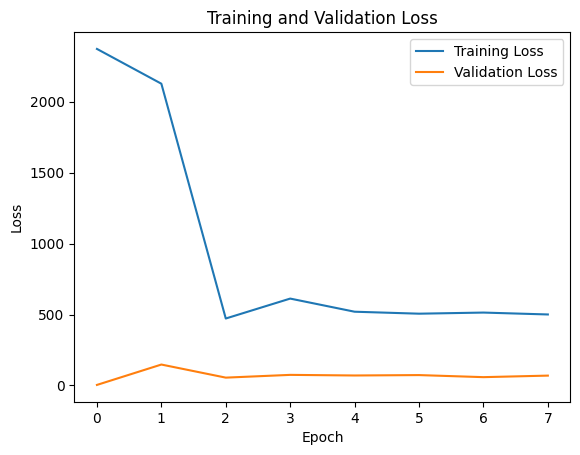

Model saved to models/gcn_2l_dnd.pth
Average Time per Epoch: 1.60s
Average CPU Usage: 28.80%
Average Memory Usage: 3.32GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 61.69%

Total Training Time: 12.80s
Max CPU Usage: 44.20%
Max Memory Usage: 3.32GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 78.50%
Fold 1 Results:
Accuracy: 0.5369
Average Sensitivity (Recall): 0.3185
Average Specificity: 0.6822

Fold 2/3
Epoch 1, Train Loss: 2315.9870573263906, Val Loss: 6.9473642110824585
Time: 1.34s, CPU: 51.05%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 53.50%
Epoch 2, Train Loss: 2245.312448501587, Val Loss: 141.7163289785385
Time: 1.19s, CPU: 17.70%, Memory: 3.32GB, GPU: 0.03GB, GPU Util: 78.50%
Epoch 3, Train Loss: 473.54319739341736, Val Loss: 50.7878121137619
Time: 1.22s, CPU: 18.20%, Memory: 3.32GB, GPU: 0.03GB, GPU Util: 73.00%
Epoch 4, Train Loss: 619.1955490112305, Val Loss: 71.0586404800415
Time: 1.19s, CPU: 19.90%, Memory: 3.32GB, GPU: 0.03GB, GPU Util: 78.50%
Epoch 5, Train Loss: 518.

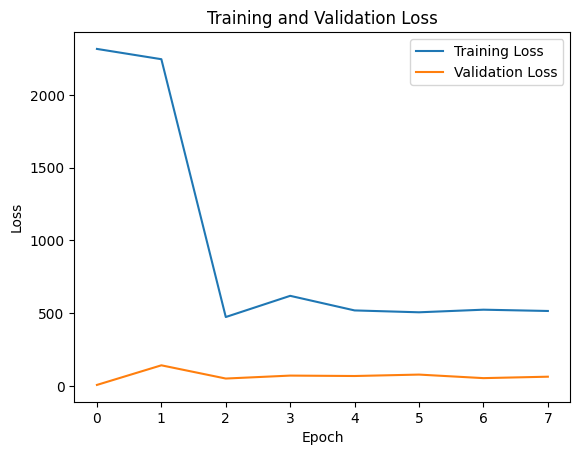

Model saved to models/gcn_2l_dnd.pth
Average Time per Epoch: 1.46s
Average CPU Usage: 37.88%
Average Memory Usage: 3.32GB
Average GPU Usage: 0.03GB
Average GPU Utilization: 66.06%

Total Training Time: 11.71s
Max CPU Usage: 65.10%
Max Memory Usage: 3.32GB
Max GPU Usage: 0.03GB
Max GPU Utilization: 78.50%
Fold 2 Results:
Accuracy: 0.3791
Average Sensitivity (Recall): 0.6513
Average Specificity: 0.2075

Fold 3/3
Epoch 1, Train Loss: 2337.12568093315, Val Loss: 15.858539685606956
Time: 1.27s, CPU: 45.70%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 62.00%
Epoch 2, Train Loss: 1874.3578162193298, Val Loss: 185.65460467338562
Time: 1.36s, CPU: 35.55%, Memory: 3.32GB, GPU: 0.03GB, GPU Util: 67.00%
Epoch 3, Train Loss: 490.5857247710228, Val Loss: 65.41857987642288
Time: 1.92s, CPU: 62.15%, Memory: 3.32GB, GPU: 0.03GB, GPU Util: 49.50%
Epoch 4, Train Loss: 615.661593079567, Val Loss: 82.78655052185059
Time: 1.82s, CPU: 47.70%, Memory: 3.32GB, GPU: 0.03GB, GPU Util: 53.50%
Epoch 5, Train Loss: 524.

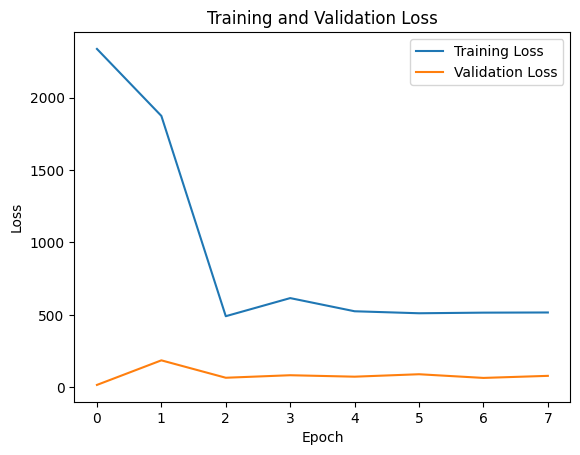

Model saved to models/gcn_2l_dnd.pth
Average Time per Epoch: 1.55s
Average CPU Usage: 44.97%
Average Memory Usage: 3.32GB
Average GPU Usage: 0.03GB
Average GPU Utilization: 62.38%

Total Training Time: 12.41s
Max CPU Usage: 62.15%
Max Memory Usage: 3.32GB
Max GPU Usage: 0.03GB
Max GPU Utilization: 80.00%
Fold 3 Results:
Accuracy: 0.4464
Average Sensitivity (Recall): 0.1461
Average Specificity: 0.6963
Cross-Validation Results:
accuracy: Mean = 0.4542, Std = 0.0646
sensitivity: Mean = 0.3720, Std = 0.2097
specificity: Mean = 0.5286, Std = 0.2272


In [17]:
set_seed(42)
gcn2_dnd = GCN2Layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes)
print(gcn2_dnd)
print(f"Total number of trainable parameters: {(gcn2_dnd.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn2_dnd, dd_dataset, lr=0.01, 
            num_epochs=500, step_size=100, save_path='models/gcn_2l_dnd.pth')

#### ENZYM

GCN2Layer(
  (gcn1): GCN (3 -> 9)
  (bn1): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (9 -> 18)
  (bn2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=18, out_features=6, bias=True)
)
Total number of trainable parameters: 768


Fold 1/3
Epoch 1, Train Loss: 679.0810012817383, Val Loss: 80.96592903137207
Time: 0.07s, CPU: 50.65%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 27.00%
Epoch 2, Train Loss: 667.1974678039551, Val Loss: 84.52140045166016
Time: 0.07s, CPU: 42.40%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 16.50%
Epoch 3, Train Loss: 661.8537445068359, Val Loss: 82.73721027374268
Time: 0.07s, CPU: 33.00%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 4, Train Loss: 657.7307062149048, Val Loss: 80.93061828613281
Time: 0.07s, CPU: 37.70%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 6.50%
Epoch 5, Train Loss: 654.4806098937988, Val Loss: 79.81978034973145
Time: 0.07s, CPU: 39.25%, 

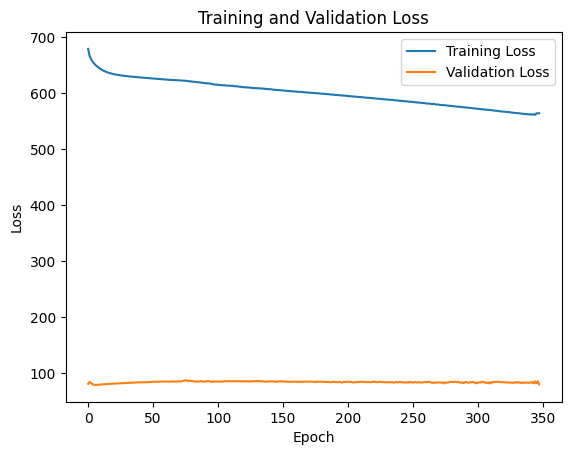

Model saved to models/gcn_2l_enzymes.pth
Average Time per Epoch: 0.07s
Average CPU Usage: 24.16%
Average Memory Usage: 3.32GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 7.87%

Total Training Time: 24.93s
Max CPU Usage: 61.45%
Max Memory Usage: 3.32GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 27.00%
Fold 1 Results:
Accuracy: 0.1700
Average Sensitivity (Recall): 0.1864
Average Specificity: 0.8371

Fold 2/3
Epoch 1, Train Loss: 668.1267547607422, Val Loss: 79.77248859405518
Time: 0.08s, CPU: 37.95%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 2, Train Loss: 657.1870059967041, Val Loss: 82.68535423278809
Time: 0.07s, CPU: 30.75%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 3, Train Loss: 653.0047645568848, Val Loss: 81.56753730773926
Time: 0.08s, CPU: 24.40%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 5.50%
Epoch 4, Train Loss: 650.1188621520996, Val Loss: 80.62860488891602
Time: 0.07s, CPU: 21.85%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 5, Train Loss: 647.61

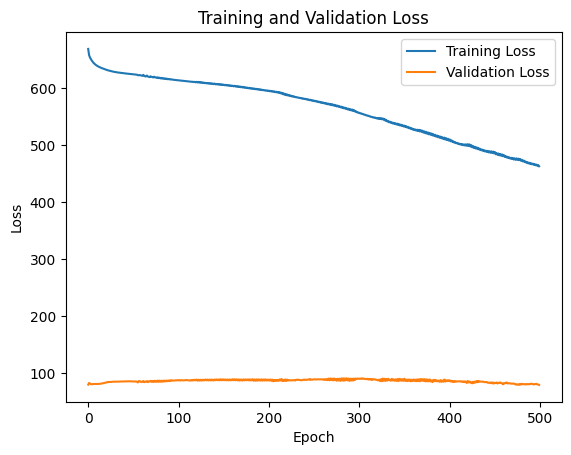

Model saved to models/gcn_2l_enzymes.pth
Average Time per Epoch: 0.07s
Average CPU Usage: 24.56%
Average Memory Usage: 3.32GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 7.76%

Total Training Time: 35.96s
Max CPU Usage: 73.10%
Max Memory Usage: 3.32GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 10.00%
Fold 2 Results:
Accuracy: 0.1900
Average Sensitivity (Recall): 0.1977
Average Specificity: 0.8399

Fold 3/3
Epoch 1, Train Loss: 675.524564743042, Val Loss: 79.89444828033447
Time: 0.06s, CPU: 33.90%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 664.190996170044, Val Loss: 83.11536979675293
Time: 0.09s, CPU: 32.55%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 3.50%
Epoch 3, Train Loss: 659.2818174362183, Val Loss: 81.29181003570557
Time: 0.07s, CPU: 34.50%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 6.50%
Epoch 4, Train Loss: 655.3466529846191, Val Loss: 79.34176445007324
Time: 0.08s, CPU: 37.40%, Memory: 3.32GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 5, Train Loss: 651.9227

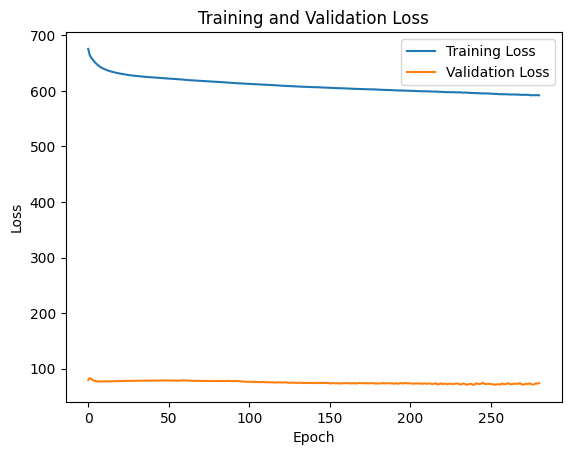

Model saved to models/gcn_2l_enzymes.pth
Average Time per Epoch: 0.07s
Average CPU Usage: 27.27%
Average Memory Usage: 3.32GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 7.68%

Total Training Time: 20.41s
Max CPU Usage: 73.60%
Max Memory Usage: 3.32GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 10.00%
Fold 3 Results:
Accuracy: 0.2100
Average Sensitivity (Recall): 0.2212
Average Specificity: 0.8433
Cross-Validation Results:
accuracy: Mean = 0.1900, Std = 0.0163
sensitivity: Mean = 0.2018, Std = 0.0145
specificity: Mean = 0.8401, Std = 0.0025


In [18]:
set_seed(42)
gcn2_enzymes = GCN2Layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes)
print(gcn2_enzymes)
print(f"Total number of trainable parameters: {(gcn2_enzymes.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn2_enzymes, enzymes_dataset, lr=0.001, 
            num_epochs=500, step_size=500, save_path='models/gcn_2l_enzymes.pth', binary_classification=False)

#### OASIS

GCN2Layer(
  (gcn1): GCN (8 -> 16)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (16 -> 32)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)
Total number of trainable parameters: 1766


Fold 1/3
Epoch 1, Train Loss: 232.7468798160553, Val Loss: 25.692359566688538
Time: 0.05s, CPU: 22.05%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 2.00%
Epoch 2, Train Loss: 216.1866363286972, Val Loss: 26.52390229701996
Time: 0.04s, CPU: 28.65%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 4.00%
Epoch 3, Train Loss: 212.50543588399887, Val Loss: 27.21093225479126
Time: 0.05s, CPU: 26.80%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 4.00%
Epoch 4, Train Loss: 207.84379184246063, Val Loss: 30.901671171188354
Time: 0.05s, CPU: 30.75%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 6.00%
Epoch 5, Train Loss: 202.86713427305222, Val Loss: 41.8841894865036
Time: 0.05s, CPU: 45

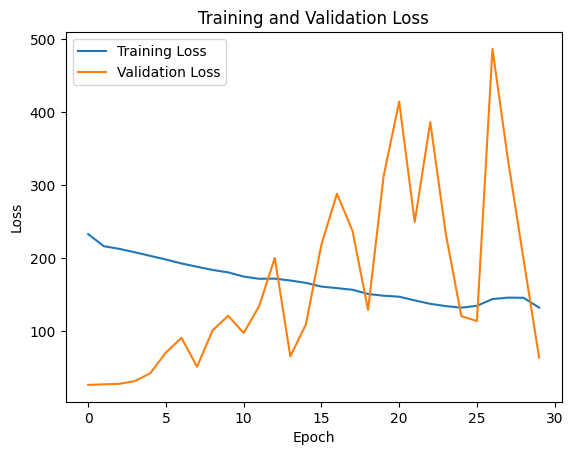

Model saved to models/gcn_2l_oasis.pth
Average Time per Epoch: 0.05s
Average CPU Usage: 39.43%
Average Memory Usage: 4.42GB
Average GPU Usage: 0.24GB
Average GPU Utilization: 6.70%

Total Training Time: 1.50s
Max CPU Usage: 61.05%
Max Memory Usage: 4.42GB
Max GPU Usage: 0.24GB
Max GPU Utilization: 8.00%
Fold 1 Results:
Accuracy: 0.5294
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0244

Fold 2/3
Epoch 1, Train Loss: 235.63485753536224, Val Loss: 25.704711437225342
Time: 0.04s, CPU: 37.50%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 0.00%
Epoch 2, Train Loss: 215.97094762325287, Val Loss: 28.70368528366089
Time: 0.04s, CPU: 25.35%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 0.00%
Epoch 3, Train Loss: 215.3161200284958, Val Loss: 30.67802143096924
Time: 0.04s, CPU: 19.40%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 6.00%
Epoch 4, Train Loss: 210.4158834218979, Val Loss: 34.184768199920654
Time: 0.05s, CPU: 20.60%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 6.00%
Epoch 5, Train Loss: 205.86

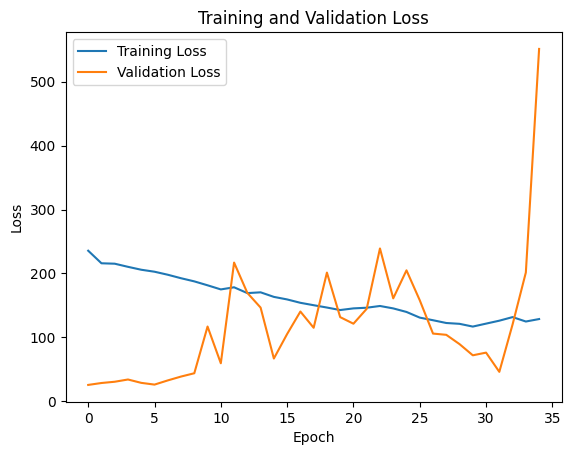

Model saved to models/gcn_2l_oasis.pth
Average Time per Epoch: 0.05s
Average CPU Usage: 39.52%
Average Memory Usage: 4.42GB
Average GPU Usage: 0.24GB
Average GPU Utilization: 6.66%

Total Training Time: 1.72s
Max CPU Usage: 57.05%
Max Memory Usage: 4.42GB
Max GPU Usage: 0.24GB
Max GPU Utilization: 8.00%
Fold 2 Results:
Accuracy: 0.5385
Average Sensitivity (Recall): 0.2188
Average Specificity: 0.8485

Fold 3/3
Epoch 1, Train Loss: 233.44342482089996, Val Loss: 27.173544883728027
Time: 0.05s, CPU: 54.20%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 0.00%
Epoch 2, Train Loss: 214.89319813251495, Val Loss: 25.948302388191223
Time: 0.05s, CPU: 52.95%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 2.00%
Epoch 3, Train Loss: 212.46418780088425, Val Loss: 26.1869854927063
Time: 0.04s, CPU: 33.75%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 4.00%
Epoch 4, Train Loss: 204.80649369955063, Val Loss: 30.090689301490784
Time: 0.06s, CPU: 38.80%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 4.00%
Epoch 5, Train Loss: 199.

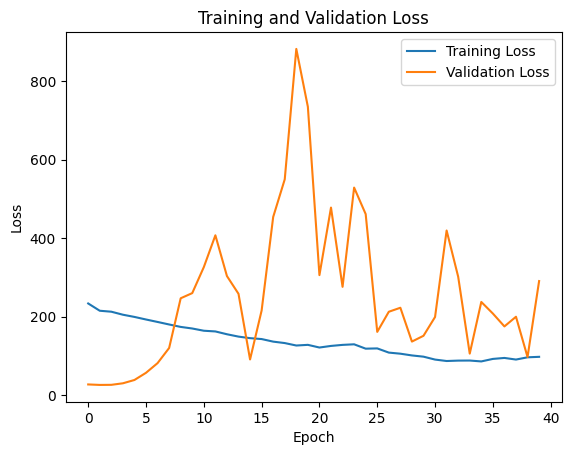

Model saved to models/gcn_2l_oasis.pth
Average Time per Epoch: 0.05s
Average CPU Usage: 30.27%
Average Memory Usage: 4.42GB
Average GPU Usage: 0.24GB
Average GPU Utilization: 7.03%

Total Training Time: 1.94s
Max CPU Usage: 54.20%
Max Memory Usage: 4.42GB
Max GPU Usage: 0.24GB
Max GPU Utilization: 9.00%
Fold 3 Results:
Accuracy: 0.5195
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000
Cross-Validation Results:
accuracy: Mean = 0.5291, Std = 0.0078
sensitivity: Mean = 0.4062, Std = 0.4292
specificity: Mean = 0.6243, Std = 0.4287


In [101]:
set_seed(42)
gcn2_oasis = GCN2Layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes)
print(gcn2_oasis)
print(f"Total number of trainable parameters: {(gcn2_oasis.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn2_oasis, oasis_dataset, lr=0.01, 
            num_epochs=500, step_size=500, save_path='models/gcn_2l_oasis.pth')

#### EMCI-AD

GCN2Layer(
  (gcn1): GCN (8 -> 16)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (16 -> 32)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
Total number of trainable parameters: 1700


Fold 1/3
Epoch 1, Train Loss: 57.860188484191895, Val Loss: 6.814167559146881
Time: 0.02s, CPU: 22.85%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 0.00%
Epoch 2, Train Loss: 50.380489349365234, Val Loss: 8.048984706401825
Time: 0.02s, CPU: 24.25%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 0.00%
Epoch 3, Train Loss: 48.20046615600586, Val Loss: 6.48457932472229
Time: 0.02s, CPU: 19.80%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 1.00%
Epoch 4, Train Loss: 45.72292137145996, Val Loss: 6.6945303082466125
Time: 0.02s, CPU: 20.85%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 2.00%
Epoch 5, Train Loss: 43.007164001464844, Val Loss: 11.332128167152405
Time: 0.02s, CPU: 26

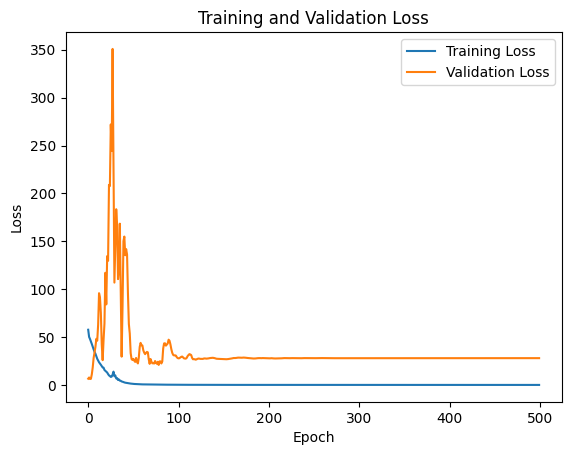

Model saved to models/gcn_2l_emci.pth
Average Time per Epoch: 0.02s
Average CPU Usage: 26.63%
Average Memory Usage: 4.42GB
Average GPU Usage: 0.24GB
Average GPU Utilization: 5.75%

Total Training Time: 10.34s
Max CPU Usage: 74.20%
Max Memory Usage: 4.42GB
Max GPU Usage: 0.24GB
Max GPU Utilization: 9.00%
Fold 1 Results:
Accuracy: 0.4889
Average Sensitivity (Recall): 0.5455
Average Specificity: 0.4348

Fold 2/3
Epoch 1, Train Loss: 57.50210189819336, Val Loss: 7.636628866195679
Time: 0.02s, CPU: 17.35%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 1.00%
Epoch 2, Train Loss: 50.277692794799805, Val Loss: 9.22341513633728
Time: 0.02s, CPU: 8.30%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 1.50%
Epoch 3, Train Loss: 48.49153232574463, Val Loss: 10.02293872833252
Time: 0.02s, CPU: 10.45%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 2.00%
Epoch 4, Train Loss: 46.480215072631836, Val Loss: 14.25208067893982
Time: 0.02s, CPU: 12.50%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 2.00%
Epoch 5, Train Loss: 44.1879992

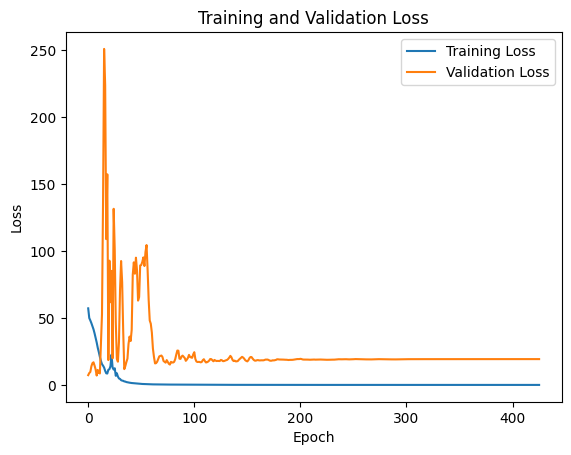

Model saved to models/gcn_2l_emci.pth
Average Time per Epoch: 0.02s
Average CPU Usage: 26.21%
Average Memory Usage: 4.42GB
Average GPU Usage: 0.24GB
Average GPU Utilization: 4.69%

Total Training Time: 8.96s
Max CPU Usage: 63.85%
Max Memory Usage: 4.42GB
Max GPU Usage: 0.24GB
Max GPU Utilization: 8.00%
Fold 2 Results:
Accuracy: 0.5333
Average Sensitivity (Recall): 0.5500
Average Specificity: 0.5200

Fold 3/3
Epoch 1, Train Loss: 55.65705871582031, Val Loss: 6.231755375862122
Time: 0.02s, CPU: 43.60%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 4.00%
Epoch 2, Train Loss: 49.57951760292053, Val Loss: 6.453143835067749
Time: 0.02s, CPU: 35.90%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 3.00%
Epoch 3, Train Loss: 46.9882630109787, Val Loss: 6.174872159957886
Time: 0.02s, CPU: 32.50%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 2.00%
Epoch 4, Train Loss: 44.027848064899445, Val Loss: 6.312004387378693
Time: 0.02s, CPU: 36.40%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 2.00%
Epoch 5, Train Loss: 41.49363878

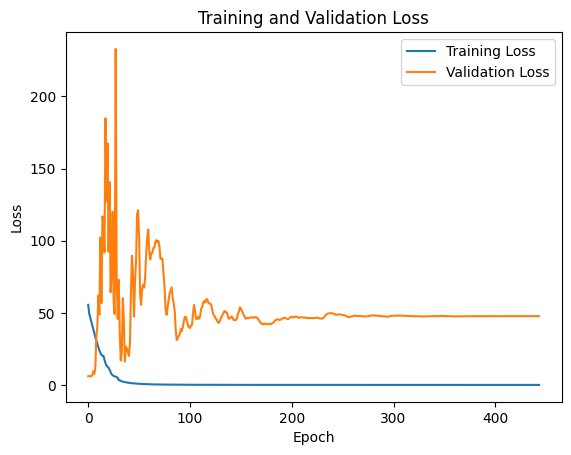

Model saved to models/gcn_2l_emci.pth
Average Time per Epoch: 0.02s
Average CPU Usage: 24.78%
Average Memory Usage: 4.42GB
Average GPU Usage: 0.24GB
Average GPU Utilization: 4.52%

Total Training Time: 9.10s
Max CPU Usage: 73.40%
Max Memory Usage: 4.42GB
Max GPU Usage: 0.24GB
Max GPU Utilization: 8.00%
Fold 3 Results:
Accuracy: 0.3409
Average Sensitivity (Recall): 0.2000
Average Specificity: 0.5263
Cross-Validation Results:
accuracy: Mean = 0.4544, Std = 0.0823
sensitivity: Mean = 0.4318, Std = 0.1639
specificity: Mean = 0.4937, Std = 0.0417


In [102]:
set_seed(42)
gcn2_emci = GCN2Layer(emci_num_features, 2*emci_num_features, emci_num_classes)
print(gcn2_emci)
print(f"Total number of trainable parameters: {(gcn2_emci.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn2_emci, emci_dataset, 
            lr=0.01, num_epochs=500, step_size=30, patience=10, 
            save_path='models/gcn_2l_emci.pth')


### GCN 3-Layer

#### MUTAG

GCN3Layer(
  (gcn1): GCN (7 -> 14)
  (bn1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (14 -> 28)
  (bn2): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (28 -> 14)
  (bn3): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 2160


Fold 1/3
Epoch 1, Train Loss: 71.26194953918457, Val Loss: 8.80061936378479
Time: 0.03s, CPU: 21.10%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 68.42255592346191, Val Loss: 8.712761044502258
Time: 0.03s, CPU: 29.15%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 3, Train Loss: 66.47718715667725, Val Loss: 8.638599157333374
Time: 0.03s, CPU: 29.15%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 4, Train Loss: 64.89669418334961, Val Loss: 8.583297371864319
Time: 0.02s, CPU: 23.00%, Memory: 3.33GB, GPU: 0.0

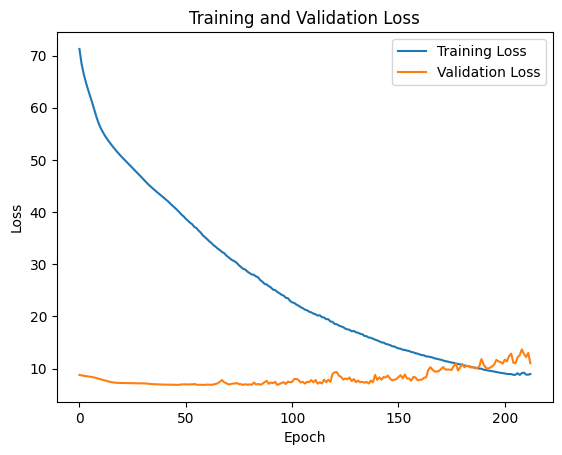

Model saved to models/gcn_3l_mutag.pth
Average Time per Epoch: 0.03s
Average CPU Usage: 28.54%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 4.00%

Total Training Time: 6.39s
Max CPU Usage: 62.50%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 9.00%
Fold 1 Results:
Accuracy: 0.8889
Average Sensitivity (Recall): 0.8537
Average Specificity: 0.9545

Fold 2/3
Epoch 1, Train Loss: 71.12404441833496, Val Loss: 8.95960521697998
Time: 0.04s, CPU: 31.80%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 67.32527732849121, Val Loss: 8.952027082443237
Time: 0.03s, CPU: 24.40%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 3, Train Loss: 64.68763065338135, Val Loss: 8.91720563173294
Time: 0.03s, CPU: 26.50%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 4, Train Loss: 62.455718994140625, Val Loss: 8.842392086982727
Time: 0.03s, CPU: 19.80%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 4.00%
Epoch 5, Train Loss: 60.30113029

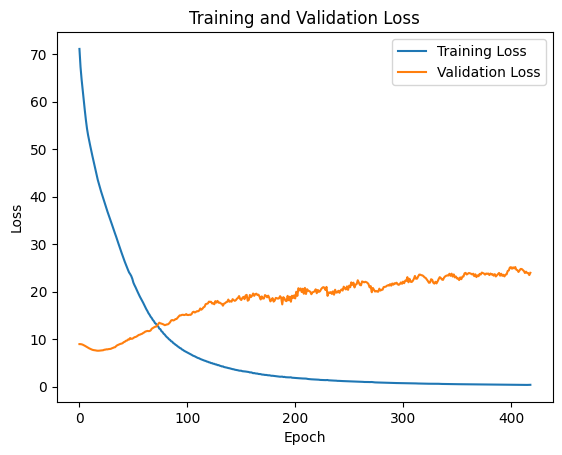

Model saved to models/gcn_3l_mutag.pth
Average Time per Epoch: 0.03s
Average CPU Usage: 24.08%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 4.31%

Total Training Time: 11.67s
Max CPU Usage: 60.60%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 6.00%
Fold 2 Results:
Accuracy: 0.7778
Average Sensitivity (Recall): 0.7857
Average Specificity: 0.7619

Fold 3/3
Epoch 1, Train Loss: 73.23147910833359, Val Loss: 8.621461570262909
Time: 0.03s, CPU: 43.65%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 2, Train Loss: 69.93253135681152, Val Loss: 8.462149500846863
Time: 0.03s, CPU: 36.40%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 3, Train Loss: 67.52431064844131, Val Loss: 8.303018748760223
Time: 0.03s, CPU: 38.65%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 4, Train Loss: 65.59132325649261, Val Loss: 8.166787445545197
Time: 0.03s, CPU: 31.10%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 5, Train Loss: 63.977221

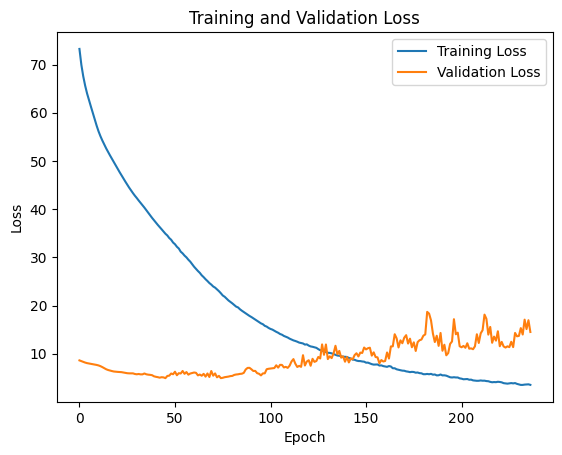

Model saved to models/gcn_3l_mutag.pth
Average Time per Epoch: 0.03s
Average CPU Usage: 32.89%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 4.53%

Total Training Time: 6.70s
Max CPU Usage: 71.75%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 6.00%
Fold 3 Results:
Accuracy: 0.7742
Average Sensitivity (Recall): 0.7619
Average Specificity: 0.8000
Cross-Validation Results:
accuracy: Mean = 0.8136, Std = 0.0532
sensitivity: Mean = 0.8004, Std = 0.0389
specificity: Mean = 0.8388, Std = 0.0833


In [19]:
set_seed(42)
gcn3_mutag = GCN3Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
print(gcn3_mutag)
print(f"Total number of trainable parameters: {(gcn3_mutag.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn3_mutag, mutag_dataset, lr=0.001, 
            num_epochs=500, step_size=500, save_path='models/gcn_3l_mutag.pth')

#### PROTEINS

GCN3Layer(
  (gcn1): GCN (3 -> 9)
  (bn1): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (9 -> 18)
  (bn2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (18 -> 9)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=9, out_features=2, bias=True)
)
Total number of trainable parameters: 958


Fold 1/3
Epoch 1, Train Loss: 570.6745890378952, Val Loss: 112.85678458213806
Time: 0.17s, CPU: 27.95%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 0.50%
Epoch 2, Train Loss: 430.72598242759705, Val Loss: 82.06202471256256
Time: 0.14s, CPU: 27.80%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 10.00%
Epoch 3, Train Loss: 437.7445424795151, Val Loss: 75.55337011814117
Time: 0.17s, CPU: 23.80%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 10.50%
Epoch 4, Train Loss: 446.1154872775078, Val Loss: 75.38091307878494
Time: 0.14s, CPU: 24.25%, Memory: 3.33GB, GPU: 0.02G

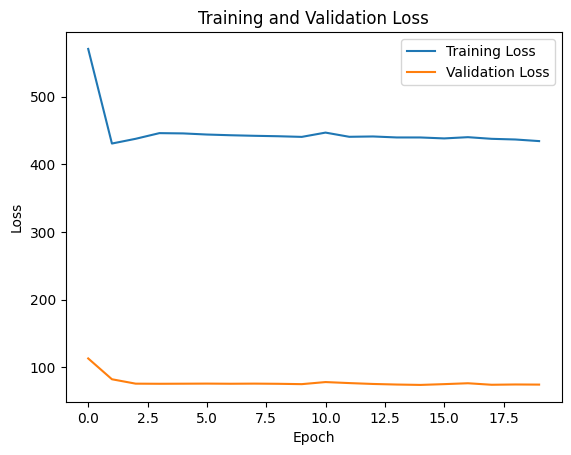

Model saved to models/gcn_3l_proteins.pth
Average Time per Epoch: 0.14s
Average CPU Usage: 26.34%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 11.75%

Total Training Time: 2.76s
Max CPU Usage: 37.95%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 15.00%
Fold 1 Results:
Accuracy: 0.6280
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Fold 2/3
Epoch 1, Train Loss: 581.5393028259277, Val Loss: 110.86964046955109
Time: 0.17s, CPU: 47.45%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 3.50%
Epoch 2, Train Loss: 425.6460156440735, Val Loss: 91.19915819168091
Time: 0.17s, CPU: 40.95%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 10.00%
Epoch 3, Train Loss: 437.0805994272232, Val Loss: 76.51431810855865
Time: 0.16s, CPU: 38.15%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 10.00%
Epoch 4, Train Loss: 443.14600920677185, Val Loss: 74.46498167514801
Time: 0.18s, CPU: 38.55%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 9.50%
Epoch 5, Train Loss: 4

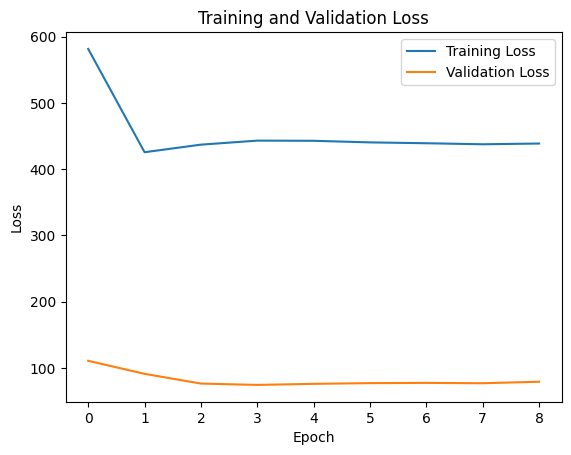

Model saved to models/gcn_3l_proteins.pth
Average Time per Epoch: 0.16s
Average CPU Usage: 42.38%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 9.89%

Total Training Time: 1.40s
Max CPU Usage: 56.00%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 13.50%
Fold 2 Results:
Accuracy: 0.6038
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Fold 3/3
Epoch 1, Train Loss: 558.3789012432098, Val Loss: 124.53269731998444
Time: 0.12s, CPU: 43.60%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 2, Train Loss: 424.50269985198975, Val Loss: 87.47590935230255
Time: 0.13s, CPU: 38.15%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 3, Train Loss: 424.987384557724, Val Loss: 81.12934923171997
Time: 0.13s, CPU: 31.40%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 13.00%
Epoch 4, Train Loss: 432.50765883922577, Val Loss: 80.30580937862396
Time: 0.13s, CPU: 22.60%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 12.50%
Epoch 5, Train Loss: 43

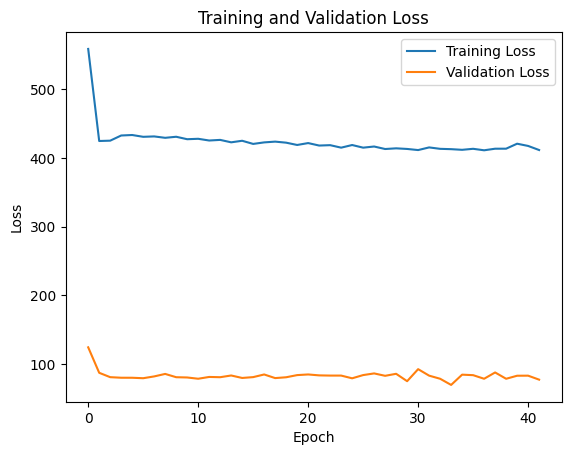

Model saved to models/gcn_3l_proteins.pth
Average Time per Epoch: 0.14s
Average CPU Usage: 27.77%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 11.18%

Total Training Time: 6.00s
Max CPU Usage: 46.65%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 13.00%
Fold 3 Results:
Accuracy: 0.5553
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000
Cross-Validation Results:
accuracy: Mean = 0.5957, Std = 0.0303
sensitivity: Mean = 0.0000, Std = 0.0000
specificity: Mean = 1.0000, Std = 0.0000


In [20]:
set_seed(42)
gcn3_proteins = GCN3Layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes)
print(gcn3_proteins)
print(f"Total number of trainable parameters: {(gcn3_proteins.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn3_proteins, proteins_dataset, lr=0.01, 
            num_epochs=500, step_size=500, save_path='models/gcn_3l_proteins.pth')

#### DND

GCN3Layer(
  (gcn1): GCN (89 -> 178)
  (bn1): BatchNorm1d(178, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (178 -> 356)
  (bn2): BatchNorm1d(356, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (356 -> 178)
  (bn3): BatchNorm1d(178, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=178, out_features=2, bias=True)
)
Total number of trainable parameters: 290144


Fold 1/3
Epoch 1, Train Loss: 1633.4101972277276, Val Loss: 105.1097639799118
Time: 1.89s, CPU: 28.15%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 43.00%
Epoch 2, Train Loss: 887.6209012269974, Val Loss: 47.84789502620697
Time: 1.77s, CPU: 19.55%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 82.50%
Epoch 3, Train Loss: 580.2877376079559, Val Loss: 65.20757013559341
Time: 1.83s, CPU: 21.25%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 69.50%
Epoch 4, Train Loss: 549.358466386795, Val Loss: 65.30952602624893
Time: 2.47s, CPU: 54.35%, Memory: 

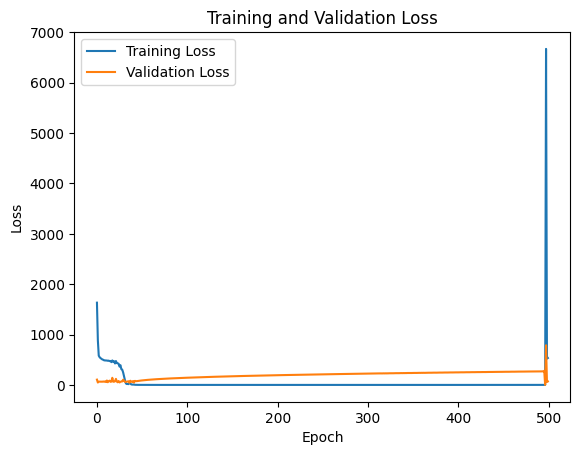

Model saved to models/gcn_3l_dnd.pth
Average Time per Epoch: 2.17s
Average CPU Usage: 34.61%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 69.24%

Total Training Time: 1084.15s
Max CPU Usage: 65.40%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 85.50%
Fold 1 Results:
Accuracy: 0.3995
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0000

Fold 2/3
Epoch 1, Train Loss: 1656.5995343197137, Val Loss: 80.30584275722504
Time: 1.59s, CPU: 23.05%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 83.50%
Epoch 2, Train Loss: 949.0582118034363, Val Loss: 72.55867981910706
Time: 1.89s, CPU: 26.80%, Memory: 3.33GB, GPU: 0.03GB, GPU Util: 70.50%
Epoch 3, Train Loss: 561.7572164535522, Val Loss: 65.3703585267067
Time: 1.88s, CPU: 45.15%, Memory: 3.33GB, GPU: 0.03GB, GPU Util: 72.50%
Epoch 4, Train Loss: 555.4535285234451, Val Loss: 66.11232674121857
Time: 1.58s, CPU: 18.60%, Memory: 3.33GB, GPU: 0.03GB, GPU Util: 82.00%
Epoch 5, Train Loss: 536

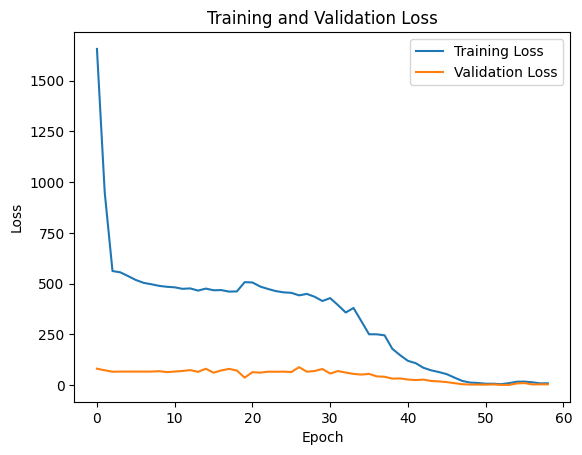

Model saved to models/gcn_3l_dnd.pth
Average Time per Epoch: 1.95s
Average CPU Usage: 36.94%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.03GB
Average GPU Utilization: 70.73%

Total Training Time: 115.06s
Max CPU Usage: 56.35%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.03GB
Max GPU Utilization: 85.50%
Fold 2 Results:
Accuracy: 0.3868
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0000

Fold 3/3
Epoch 1, Train Loss: 1630.2672573812306, Val Loss: 209.88607358932495
Time: 2.25s, CPU: 56.15%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 54.50%
Epoch 2, Train Loss: 832.7111774086952, Val Loss: 60.150643050670624
Time: 2.23s, CPU: 42.10%, Memory: 3.33GB, GPU: 0.03GB, GPU Util: 61.50%
Epoch 3, Train Loss: 567.5189698934555, Val Loss: 78.33587145805359
Time: 2.30s, CPU: 53.00%, Memory: 3.33GB, GPU: 0.03GB, GPU Util: 55.00%
Epoch 4, Train Loss: 534.8211618065834, Val Loss: 74.75275695323944
Time: 2.27s, CPU: 50.05%, Memory: 3.33GB, GPU: 0.03GB, GPU Util: 58.50%
Epoch 5, Train Loss: 5

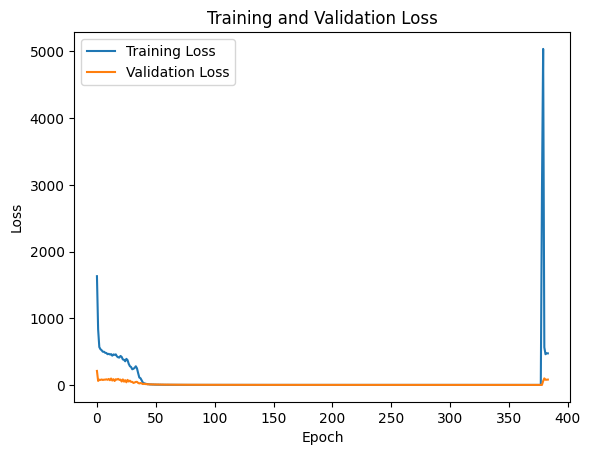

Model saved to models/gcn_3l_dnd.pth
Average Time per Epoch: 2.05s
Average CPU Usage: 38.52%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.03GB
Average GPU Utilization: 66.56%

Total Training Time: 787.92s
Max CPU Usage: 67.95%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.03GB
Max GPU Utilization: 85.00%
Fold 3 Results:
Accuracy: 0.4541
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0000
Cross-Validation Results:
accuracy: Mean = 0.4134, Std = 0.0292
sensitivity: Mean = 1.0000, Std = 0.0000
specificity: Mean = 0.0000, Std = 0.0000


In [21]:
set_seed(42)
gcn3_dnd = GCN3Layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes)
print(gcn3_dnd)
print(f"Total number of trainable parameters: {(gcn3_dnd.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn3_dnd, dd_dataset, lr=0.01, 
            num_epochs=500, step_size=500, save_path='models/gcn_3l_dnd.pth')

#### ENZYM

GCN3Layer(
  (gcn1): GCN (3 -> 9)
  (bn1): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (9 -> 18)
  (bn2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (18 -> 9)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=9, out_features=6, bias=True)
)
Total number of trainable parameters: 1038


Fold 1/3
Epoch 1, Train Loss: 660.5735282897949, Val Loss: 64.016845703125
Time: 0.09s, CPU: 26.75%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 2, Train Loss: 653.6644659042358, Val Loss: 67.775315284729
Time: 0.08s, CPU: 23.40%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 3, Train Loss: 651.3303022384644, Val Loss: 69.87551021575928
Time: 0.08s, CPU: 23.40%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 4, Train Loss: 649.766713142395, Val Loss: 71.09832954406738
Time: 0.08s, CPU: 34.00%, Memory: 3.33GB, GPU: 0.02GB, GPU U

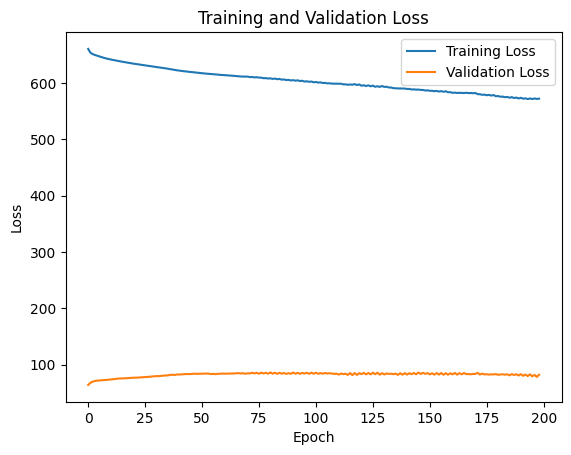

Model saved to models/gcn_3l_enzymes.pth
Average Time per Epoch: 0.09s
Average CPU Usage: 27.78%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 8.52%

Total Training Time: 17.10s
Max CPU Usage: 53.75%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 11.00%
Fold 1 Results:
Accuracy: 0.1300
Average Sensitivity (Recall): 0.1340
Average Specificity: 0.8263

Fold 2/3
Epoch 1, Train Loss: 662.3766994476318, Val Loss: 64.99415588378906
Time: 0.08s, CPU: 34.05%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 3.50%
Epoch 2, Train Loss: 655.2136163711548, Val Loss: 69.0849609375
Time: 0.09s, CPU: 25.30%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 4.00%
Epoch 3, Train Loss: 652.3241376876831, Val Loss: 71.65896129608154
Time: 0.09s, CPU: 24.75%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 4, Train Loss: 650.1240367889404, Val Loss: 73.59578037261963
Time: 0.09s, CPU: 28.10%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 5, Train Loss: 648.447188

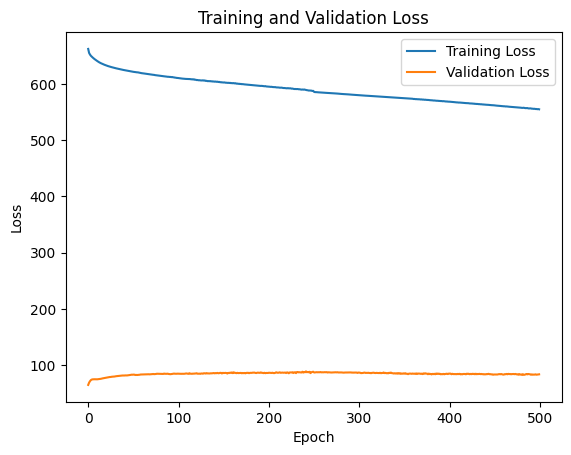

Model saved to models/gcn_3l_enzymes.pth
Average Time per Epoch: 0.08s
Average CPU Usage: 26.72%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 8.36%

Total Training Time: 42.27s
Max CPU Usage: 73.45%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 11.00%
Fold 2 Results:
Accuracy: 0.2050
Average Sensitivity (Recall): 0.2114
Average Specificity: 0.8428

Fold 3/3
Epoch 1, Train Loss: 664.7104053497314, Val Loss: 63.589261054992676
Time: 0.10s, CPU: 34.65%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 656.6616725921631, Val Loss: 67.90289688110352
Time: 0.08s, CPU: 23.10%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 3.50%
Epoch 3, Train Loss: 653.6844997406006, Val Loss: 70.39855766296387
Time: 0.07s, CPU: 29.55%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 8.50%
Epoch 4, Train Loss: 651.6134910583496, Val Loss: 71.97425842285156
Time: 0.08s, CPU: 27.50%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 10.00%
Epoch 5, Train Loss: 649.

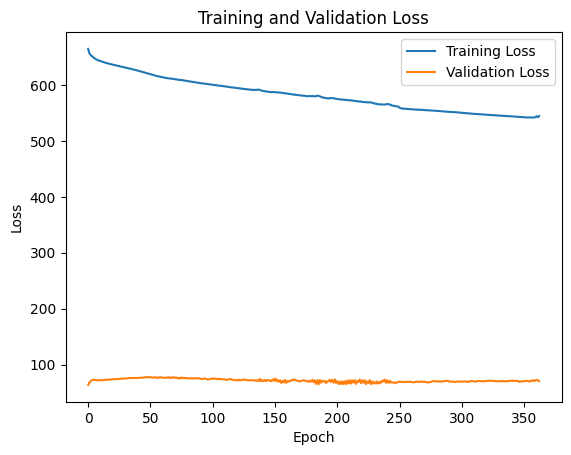

Model saved to models/gcn_3l_enzymes.pth
Average Time per Epoch: 0.09s
Average CPU Usage: 30.50%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 8.20%

Total Training Time: 32.51s
Max CPU Usage: 69.00%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 11.00%
Fold 3 Results:
Accuracy: 0.1950
Average Sensitivity (Recall): 0.1980
Average Specificity: 0.8403
Cross-Validation Results:
accuracy: Mean = 0.1767, Std = 0.0332
sensitivity: Mean = 0.1811, Std = 0.0338
specificity: Mean = 0.8365, Std = 0.0073


In [22]:
set_seed(42)
gcn3_enzymes = GCN3Layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes)
print(gcn3_enzymes)
print(f"Total number of trainable parameters: {(gcn3_enzymes.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn3_enzymes, enzymes_dataset, lr=0.001, 
            num_epochs=500, step_size=250, save_path='models/gcn_3l_enzymes.pth', 
            binary_classification=False)

### GCN 4-Layer

#### MUTAG

GCN4Layer(
  (gcn1): GCN (7 -> 14)
  (bn1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (14 -> 28)
  (bn2): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (28 -> 42)
  (bn3): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn4): GCN (42 -> 28)
  (bn4): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=28, out_features=2, bias=True)
)
Total number of trainable parameters: 6472


Fold 1/3
Epoch 1, Train Loss: 75.37994956970215, Val Loss: 8.707967758178711
Time: 0.04s, CPU: 16.35%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 0.50%
Epoch 2, Train Loss: 66.07859134674072, Val Loss: 8.766302347183228
Time: 0.04s, CPU: 13.40%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 3, Train Loss: 61.53324031829834, Val Loss: 8.73710173368454
Time: 0.02s, CPU: 13.05%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 1.00%
Epoc

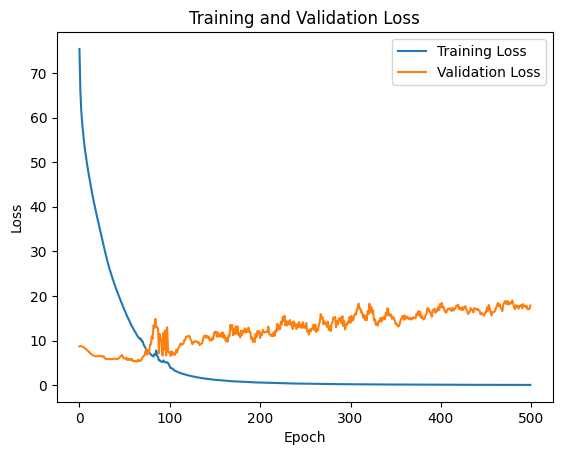

Model saved to models/gcn_4l_mutag.pth
Average Time per Epoch: 0.03s
Average CPU Usage: 19.86%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 5.69%

Total Training Time: 14.97s
Max CPU Usage: 70.90%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 7.00%
Fold 1 Results:
Accuracy: 0.8413
Average Sensitivity (Recall): 0.9024
Average Specificity: 0.7273

Fold 2/3
Epoch 1, Train Loss: 77.10826778411865, Val Loss: 8.93165910243988
Time: 0.03s, CPU: 31.00%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 2, Train Loss: 65.59525966644287, Val Loss: 8.866052448749542
Time: 0.03s, CPU: 23.20%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 3, Train Loss: 60.006714820861816, Val Loss: 8.807381570339203
Time: 0.03s, CPU: 18.00%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 4, Train Loss: 56.59945201873779, Val Loss: 8.70429801940918
Time: 0.03s, CPU: 19.90%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 5, Train Loss: 53.6046371

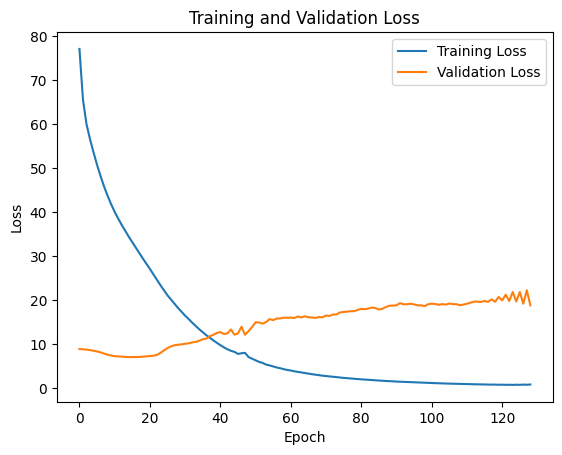

Model saved to models/gcn_4l_mutag.pth
Average Time per Epoch: 0.03s
Average CPU Usage: 13.71%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 5.93%

Total Training Time: 3.65s
Max CPU Usage: 47.75%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 7.00%
Fold 2 Results:
Accuracy: 0.7778
Average Sensitivity (Recall): 0.8095
Average Specificity: 0.7143

Fold 3/3
Epoch 1, Train Loss: 79.08551979064941, Val Loss: 8.463421821594238
Time: 0.03s, CPU: 20.05%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 68.25700342655182, Val Loss: 8.668877601623535
Time: 0.03s, CPU: 17.10%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 3, Train Loss: 63.00648605823517, Val Loss: 8.79874575138092
Time: 0.03s, CPU: 6.25%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 4, Train Loss: 59.907075464725494, Val Loss: 8.838521659374237
Time: 0.03s, CPU: 12.75%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 5, Train Loss: 57.27992945

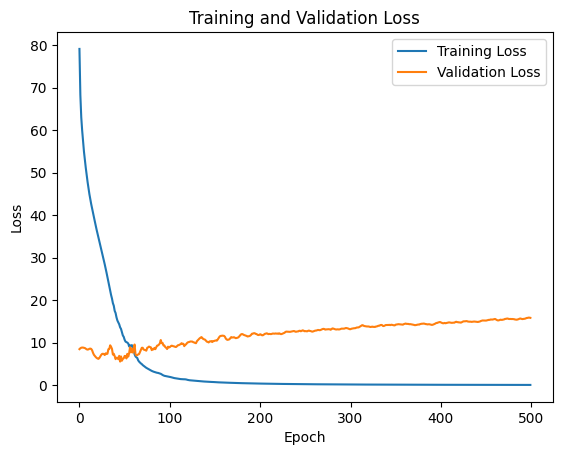

Model saved to models/gcn_4l_mutag.pth
Average Time per Epoch: 0.03s
Average CPU Usage: 19.12%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 5.87%

Total Training Time: 14.90s
Max CPU Usage: 55.75%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 7.00%
Fold 3 Results:
Accuracy: 0.8226
Average Sensitivity (Recall): 0.8571
Average Specificity: 0.7500
Cross-Validation Results:
accuracy: Mean = 0.8139, Std = 0.0266
sensitivity: Mean = 0.8564, Std = 0.0379
specificity: Mean = 0.7305, Std = 0.0148


In [23]:
set_seed(42)
gcn4_mutag = GCN4Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
print(gcn4_mutag)
print(f"Total number of trainable parameters: {(gcn4_mutag.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn4_mutag, mutag_dataset, lr=0.001, 
            num_epochs=500, step_size=500, save_path='models/gcn_4l_mutag.pth')

#### PROTEINS

GCN4Layer(
  (gcn1): GCN (3 -> 9)
  (bn1): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (9 -> 18)
  (bn2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (18 -> 27)
  (bn3): BatchNorm1d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn4): GCN (27 -> 18)
  (bn4): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=18, out_features=2, bias=True)
)
Total number of trainable parameters: 2830


Fold 1/3
Epoch 1, Train Loss: 687.0727055072784, Val Loss: 134.97733736038208
Time: 0.15s, CPU: 16.65%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 6.50%
Epoch 2, Train Loss: 422.5822638273239, Val Loss: 70.18480503559113
Time: 0.17s, CPU: 22.90%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 13.00%
Epoch 3, Train Loss: 461.50051963329315, Val Loss: 70.55200183391571
Time: 0.15s, CPU: 10.75%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 13.00%
Ep

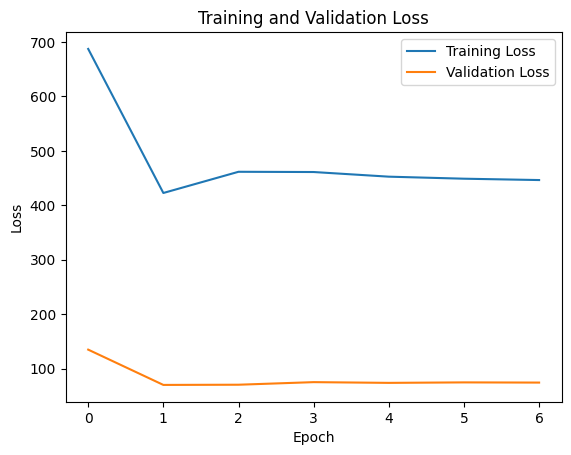

Model saved to models/gcn_4l_proteins.pth
Average Time per Epoch: 0.17s
Average CPU Usage: 27.63%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 11.86%

Total Training Time: 1.19s
Max CPU Usage: 44.30%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 13.50%
Fold 1 Results:
Accuracy: 0.6280
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Fold 2/3
Epoch 1, Train Loss: 668.9542050361633, Val Loss: 145.08650410175323
Time: 0.16s, CPU: 44.30%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 5.00%
Epoch 2, Train Loss: 426.7976452112198, Val Loss: 73.23483622074127
Time: 0.21s, CPU: 44.40%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 10.00%
Epoch 3, Train Loss: 453.8030366897583, Val Loss: 70.80775481462479
Time: 0.16s, CPU: 38.80%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 11.50%
Epoch 4, Train Loss: 456.54826498031616, Val Loss: 71.66014462709427
Time: 0.17s, CPU: 41.30%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 13.00%
Epoch 5, Train Loss: 

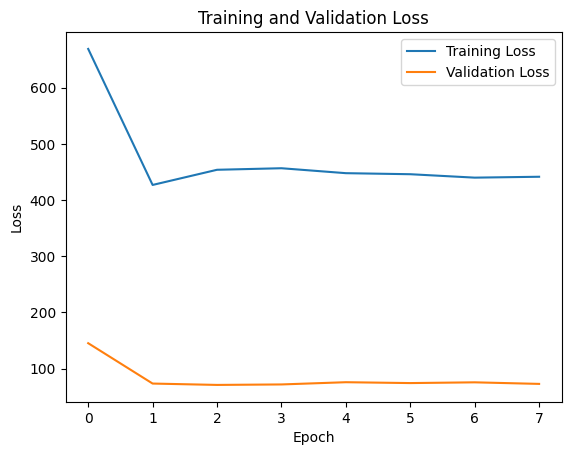

Model saved to models/gcn_4l_proteins.pth
Average Time per Epoch: 0.17s
Average CPU Usage: 43.86%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 11.50%

Total Training Time: 1.35s
Max CPU Usage: 55.25%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 13.50%
Fold 2 Results:
Accuracy: 0.6092
Average Sensitivity (Recall): 0.0136
Average Specificity: 1.0000

Fold 3/3
Epoch 1, Train Loss: 667.9322944879532, Val Loss: 160.95685005187988
Time: 0.16s, CPU: 21.35%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 2, Train Loss: 411.05720567703247, Val Loss: 83.82547891139984
Time: 0.15s, CPU: 10.75%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 14.00%
Epoch 3, Train Loss: 446.2017711400986, Val Loss: 81.67986345291138
Time: 0.14s, CPU: 10.10%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 14.00%
Epoch 4, Train Loss: 449.7391105890274, Val Loss: 81.12099885940552
Time: 0.14s, CPU: 10.75%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 14.00%
Epoch 5, Train Loss: 

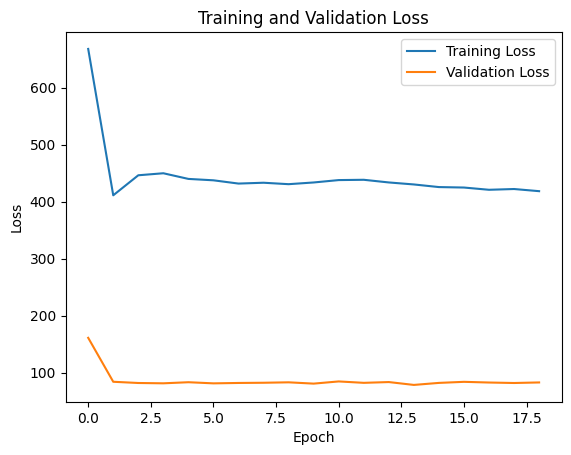

Model saved to models/gcn_4l_proteins.pth
Average Time per Epoch: 0.14s
Average CPU Usage: 14.63%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 14.29%

Total Training Time: 2.74s
Max CPU Usage: 27.30%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 16.00%
Fold 3 Results:
Accuracy: 0.5903
Average Sensitivity (Recall): 0.0848
Average Specificity: 0.9951
Cross-Validation Results:
accuracy: Mean = 0.6092, Std = 0.0154
sensitivity: Mean = 0.0328, Std = 0.0372
specificity: Mean = 0.9984, Std = 0.0023


In [24]:
set_seed(42)
gcn4_proteins = GCN4Layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes)
print(gcn4_proteins)
print(f"Total number of trainable parameters: {(gcn4_proteins.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn4_proteins, proteins_dataset, lr=0.01, 
            num_epochs=500, step_size=500, save_path='models/gcn_4l_proteins.pth')

#### DND

GCN4Layer(
  (gcn1): GCN (89 -> 178)
  (bn1): BatchNorm1d(178, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (178 -> 356)
  (bn2): BatchNorm1d(356, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (356 -> 534)
  (bn3): BatchNorm1d(534, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn4): GCN (534 -> 356)
  (bn4): BatchNorm1d(356, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=356, out_features=2, bias=True)
)
Total number of trainable parameters: 928808


Fold 1/3
Epoch 1, Train Loss: 2125.0347244244767, Val Loss: 40.64264237880707
Time: 3.77s, CPU: 25.60%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 45.00%
Epoch 2, Train Loss: 1070.544312596321, Val Loss: 65.78002893924713
Time: 3.22s, CPU: 18.40%, Memory: 3.33GB, GPU: 0.03GB, GPU Util: 88.00%
Epoch 3, Train Loss: 551.5806615352631, Val Loss: 68.11069494485855
Time: 3.68s, CPU: 21.25%, Memory: 3.33GB, GPU: 0.03GB, G

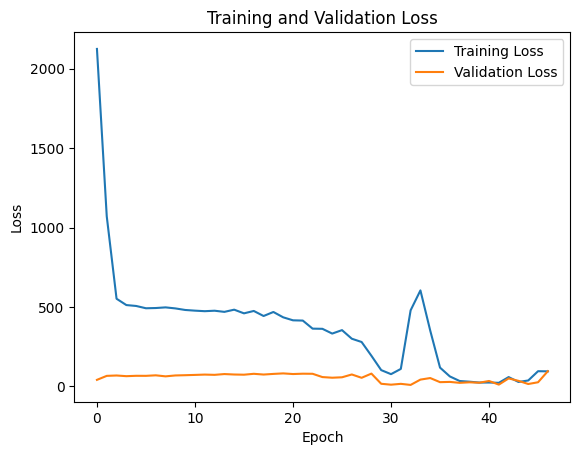

Model saved to models/gcn_4l_dnd.pth
Average Time per Epoch: 3.71s
Average CPU Usage: 33.21%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.03GB
Average GPU Utilization: 78.87%

Total Training Time: 174.50s
Max CPU Usage: 50.85%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.03GB
Max GPU Utilization: 89.00%
Fold 1 Results:
Accuracy: 0.3969
Average Sensitivity (Recall): 0.9682
Average Specificity: 0.0169

Fold 2/3
Epoch 1, Train Loss: 2098.4808657489993, Val Loss: 21.819020062685013
Time: 3.28s, CPU: 45.95%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 73.50%
Epoch 2, Train Loss: 1301.4971746206284, Val Loss: 66.56326711177826
Time: 3.00s, CPU: 32.10%, Memory: 3.33GB, GPU: 0.03GB, GPU Util: 80.00%
Epoch 3, Train Loss: 567.2753372192383, Val Loss: 62.74101823568344
Time: 3.24s, CPU: 36.90%, Memory: 3.33GB, GPU: 0.03GB, GPU Util: 82.00%
Epoch 4, Train Loss: 522.3068902492523, Val Loss: 61.492637395858765
Time: 3.40s, CPU: 41.95%, Memory: 3.33GB, GPU: 0.03GB, GPU Util: 75.50%
Epoch 5, Train Loss: 

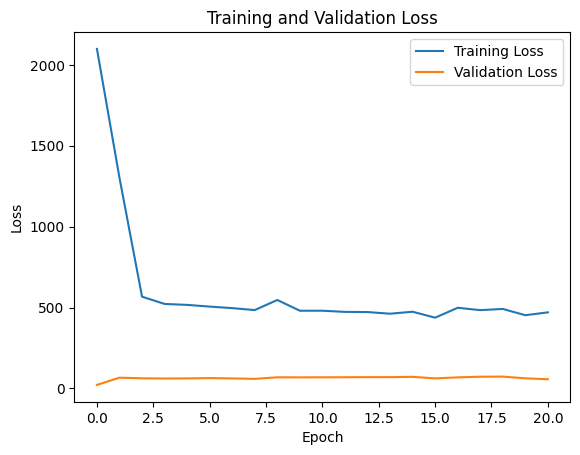

Model saved to models/gcn_4l_dnd.pth
Average Time per Epoch: 3.19s
Average CPU Usage: 33.09%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.03GB
Average GPU Utilization: 80.21%

Total Training Time: 67.03s
Max CPU Usage: 47.80%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.03GB
Max GPU Utilization: 88.00%
Fold 2 Results:
Accuracy: 0.6031
Average Sensitivity (Recall): 0.0197
Average Specificity: 0.9710

Fold 3/3
Epoch 1, Train Loss: 2041.861032175797, Val Loss: 35.944440722465515
Time: 3.03s, CPU: 32.50%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 75.50%
Epoch 2, Train Loss: 1181.69423609972, Val Loss: 74.13928854465485
Time: 3.33s, CPU: 24.30%, Memory: 3.33GB, GPU: 0.04GB, GPU Util: 84.50%
Epoch 3, Train Loss: 539.5425873994827, Val Loss: 78.45323872566223
Time: 2.95s, CPU: 18.35%, Memory: 3.33GB, GPU: 0.04GB, GPU Util: 88.00%
Epoch 4, Train Loss: 521.2610834240913, Val Loss: 73.85546046495438
Time: 3.32s, CPU: 24.80%, Memory: 3.33GB, GPU: 0.04GB, GPU Util: 77.00%
Epoch 5, Train Loss: 512.4

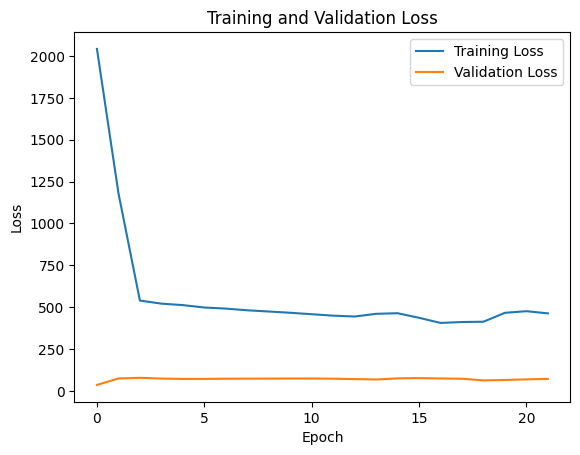

Model saved to models/gcn_4l_dnd.pth
Average Time per Epoch: 3.36s
Average CPU Usage: 34.84%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.04GB
Average GPU Utilization: 76.84%

Total Training Time: 73.94s
Max CPU Usage: 50.05%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.04GB
Max GPU Utilization: 88.00%
Fold 3 Results:
Accuracy: 0.5485
Average Sensitivity (Recall): 0.0056
Average Specificity: 1.0000
Cross-Validation Results:
accuracy: Mean = 0.5162, Std = 0.0872
sensitivity: Mean = 0.3312, Std = 0.4505
specificity: Mean = 0.6626, Std = 0.4567


In [25]:
set_seed(42)
gcn4_dnd = GCN4Layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes)
print(gcn4_dnd)
print(f"Total number of trainable parameters: {(gcn4_dnd.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn4_dnd, dd_dataset, lr=0.01, 
            num_epochs=500, step_size=500, save_path='models/gcn_4l_dnd.pth')

#### ENZYM

GCN4Layer(
  (gcn1): GCN (3 -> 9)
  (bn1): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (9 -> 18)
  (bn2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (18 -> 27)
  (bn3): BatchNorm1d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn4): GCN (27 -> 18)
  (bn4): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=18, out_features=6, bias=True)
)
Total number of trainable parameters: 2982


Fold 1/3
Epoch 1, Train Loss: 663.9017000198364, Val Loss: 70.93456077575684
Time: 0.08s, CPU: 25.35%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 16.50%
Epoch 2, Train Loss: 649.6235466003418, Val Loss: 69.24951457977295
Time: 0.08s, CPU: 11.60%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 3, Train Loss: 644.9663467407227, Val Loss: 71.5607967376709
Time: 0.09s, CPU: 15.30%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 6.50%
Epoch 

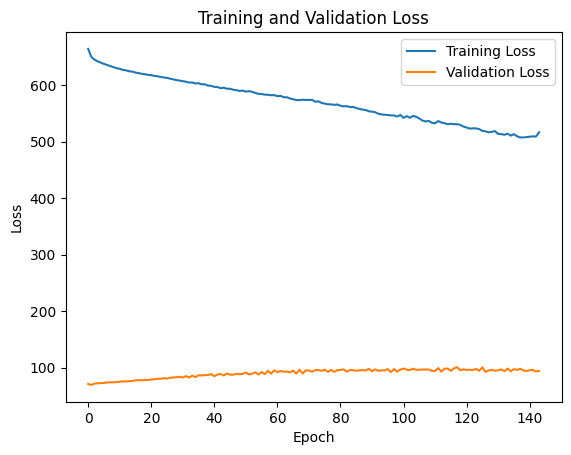

Model saved to models/gcn_4l_enzymes.pth
Average Time per Epoch: 0.09s
Average CPU Usage: 27.36%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 9.44%

Total Training Time: 13.35s
Max CPU Usage: 64.90%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 16.50%
Fold 1 Results:
Accuracy: 0.1500
Average Sensitivity (Recall): 0.1548
Average Specificity: 0.8311

Fold 2/3
Epoch 1, Train Loss: 665.8778772354126, Val Loss: 71.07823181152344
Time: 0.08s, CPU: 18.30%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 3.50%
Epoch 2, Train Loss: 650.5959205627441, Val Loss: 70.77162647247314
Time: 0.09s, CPU: 8.10%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 4.00%
Epoch 3, Train Loss: 644.8929376602173, Val Loss: 73.98509693145752
Time: 0.08s, CPU: 14.15%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 4, Train Loss: 640.9120674133301, Val Loss: 74.43620586395264
Time: 0.09s, CPU: 29.35%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 10.00%
Epoch 5, Train Loss: 637.67

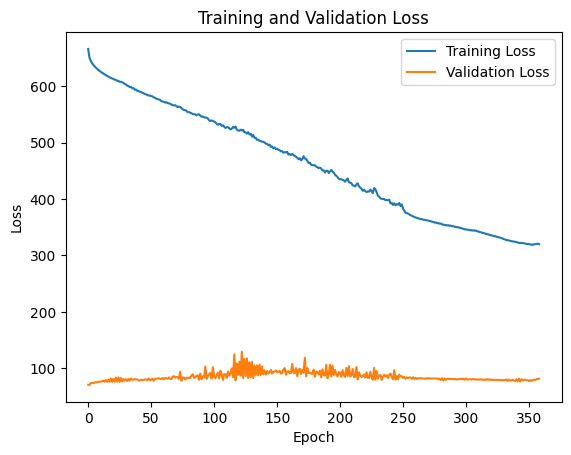

Model saved to models/gcn_4l_enzymes.pth
Average Time per Epoch: 0.09s
Average CPU Usage: 28.78%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 9.31%

Total Training Time: 33.01s
Max CPU Usage: 60.60%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 12.00%
Fold 2 Results:
Accuracy: 0.1450
Average Sensitivity (Recall): 0.1538
Average Specificity: 0.8297

Fold 3/3
Epoch 1, Train Loss: 663.6766128540039, Val Loss: 73.81864356994629
Time: 0.11s, CPU: 19.60%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 3.50%
Epoch 2, Train Loss: 649.1619186401367, Val Loss: 69.53395366668701
Time: 0.08s, CPU: 9.80%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 6.50%
Epoch 3, Train Loss: 644.6495923995972, Val Loss: 70.33412647247314
Time: 0.08s, CPU: 11.10%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 9.00%
Epoch 4, Train Loss: 641.6250629425049, Val Loss: 71.09452629089355
Time: 0.08s, CPU: 13.35%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 10.00%
Epoch 5, Train Loss: 638.86

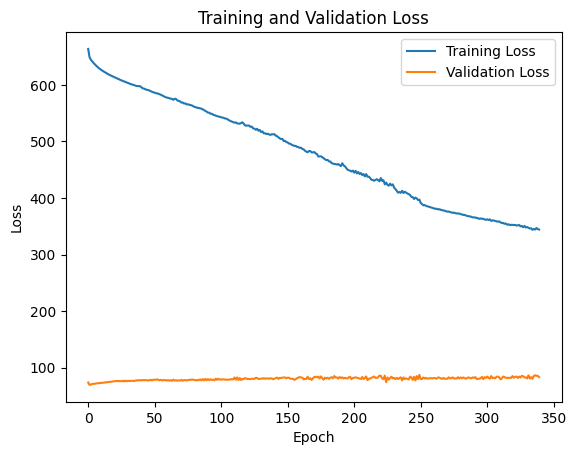

Model saved to models/gcn_4l_enzymes.pth
Average Time per Epoch: 0.09s
Average CPU Usage: 20.64%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 10.06%

Total Training Time: 29.60s
Max CPU Usage: 62.25%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 13.00%
Fold 3 Results:
Accuracy: 0.1650
Average Sensitivity (Recall): 0.1637
Average Specificity: 0.8327
Cross-Validation Results:
accuracy: Mean = 0.1533, Std = 0.0085
sensitivity: Mean = 0.1574, Std = 0.0045
specificity: Mean = 0.8312, Std = 0.0012


In [26]:
set_seed(42)
gcn4_enzymes = GCN4Layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes)
print(gcn4_enzymes)
print(f"Total number of trainable parameters: {(gcn4_enzymes.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn4_enzymes, enzymes_dataset, lr=0.001, 
            num_epochs=500, step_size=250, save_path='models/gcn_4l_enzymes.pth', 
            binary_classification=False)

### GCN 5-Layer

#### MUTAG

GCN5Layer(
  (gcn1): GCN (7 -> 14)
  (bn1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (14 -> 28)
  (bn2): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (28 -> 42)
  (bn3): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn4): GCN (42 -> 28)
  (bn4): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn5): GCN (28 -> 14)
  (bn5): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 7284


Fold 1/3
Epoch 1, Train Loss: 63.154927253723145, Val Loss: 9.380765855312347
Time: 0.04s, CPU: 39.40%, Memory: 3.34GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 2, Train Loss: 50.43781757354736, Val Loss: 9.629758715629578
Time: 0.04s, CPU: 41.55%, Memory: 3.34GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 3, Train Loss: 44.722

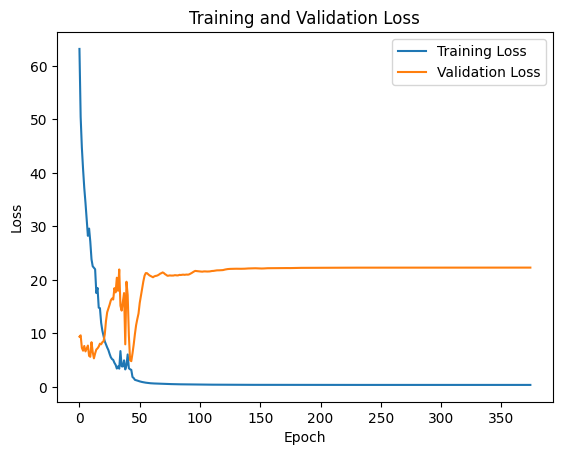

Model saved to models/gcn_5l_mutag.pth
Average Time per Epoch: 0.03s
Average CPU Usage: 23.35%
Average Memory Usage: 3.34GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 5.89%

Total Training Time: 12.32s
Max CPU Usage: 55.05%
Max Memory Usage: 3.34GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 8.00%
Fold 1 Results:
Accuracy: 0.9048
Average Sensitivity (Recall): 0.9512
Average Specificity: 0.8182

Fold 2/3
Epoch 1, Train Loss: 62.007394790649414, Val Loss: 9.505714416503906
Time: 0.03s, CPU: 36.25%, Memory: 3.34GB, GPU: 0.02GB, GPU Util: 2.50%
Epoch 2, Train Loss: 45.47293281555176, Val Loss: 8.45316731929779
Time: 0.03s, CPU: 21.55%, Memory: 3.34GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 3, Train Loss: 36.04009485244751, Val Loss: 7.1816717982292175
Time: 0.04s, CPU: 20.85%, Memory: 3.34GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 4, Train Loss: 29.76266574859619, Val Loss: 9.485630810260773
Time: 0.04s, CPU: 24.75%, Memory: 3.34GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 5, Train Loss: 24.45689

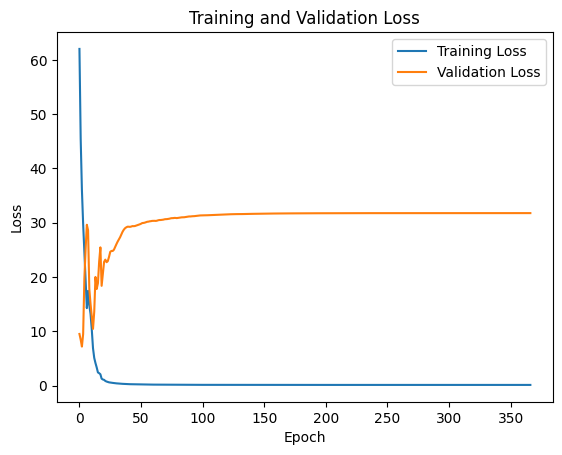

Model saved to models/gcn_5l_mutag.pth
Average Time per Epoch: 0.03s
Average CPU Usage: 20.41%
Average Memory Usage: 3.34GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 6.04%

Total Training Time: 11.85s
Max CPU Usage: 69.55%
Max Memory Usage: 3.34GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 8.00%
Fold 2 Results:
Accuracy: 0.7937
Average Sensitivity (Recall): 0.7619
Average Specificity: 0.8571

Fold 3/3
Epoch 1, Train Loss: 62.69885143637657, Val Loss: 7.050637483596802
Time: 0.03s, CPU: 39.65%, Memory: 3.34GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 2, Train Loss: 49.094256579875946, Val Loss: 6.283781409263611
Time: 0.04s, CPU: 27.85%, Memory: 3.34GB, GPU: 0.02GB, GPU Util: 2.50%
Epoch 3, Train Loss: 41.69568794965744, Val Loss: 5.659506231546402
Time: 0.03s, CPU: 23.10%, Memory: 3.34GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 4, Train Loss: 36.68713381886482, Val Loss: 7.653849244117737
Time: 0.03s, CPU: 25.70%, Memory: 3.34GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 5, Train Loss: 32.28990

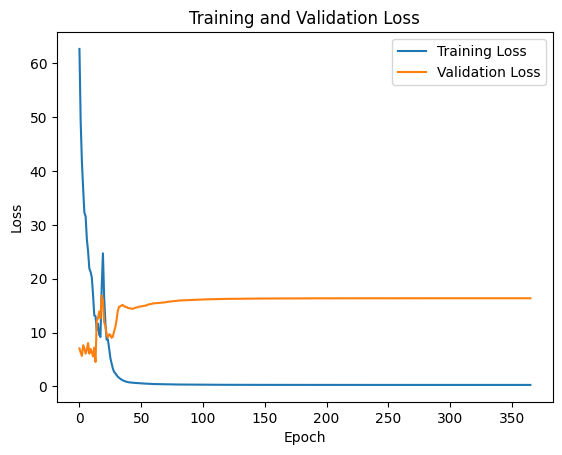

Model saved to models/gcn_5l_mutag.pth
Average Time per Epoch: 0.03s
Average CPU Usage: 30.32%
Average Memory Usage: 3.34GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 5.78%

Total Training Time: 12.59s
Max CPU Usage: 68.50%
Max Memory Usage: 3.34GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 7.00%
Fold 3 Results:
Accuracy: 0.7903
Average Sensitivity (Recall): 0.8571
Average Specificity: 0.6500
Cross-Validation Results:
accuracy: Mean = 0.8296, Std = 0.0532
sensitivity: Mean = 0.8568, Std = 0.0773
specificity: Mean = 0.7751, Std = 0.0899


In [30]:
set_seed(42)
gcn5_mutag = GCN5Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
print(gcn5_mutag)
print(f"Total number of trainable parameters: {(gcn5_mutag.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn5_mutag, mutag_dataset, lr=0.01, 
            num_epochs=500, step_size=20, save_path='models/gcn_5l_mutag.pth')

#### PROTEINS

GCN5Layer(
  (gcn1): GCN (3 -> 9)
  (bn1): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (9 -> 18)
  (bn2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (18 -> 27)
  (bn3): BatchNorm1d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn4): GCN (27 -> 18)
  (bn4): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn5): GCN (18 -> 9)
  (bn5): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=9, out_features=2, bias=True)
)
Total number of trainable parameters: 3172


Fold 1/3
Epoch 1, Train Loss: 546.998338341713, Val Loss: 99.02520143985748
Time: 0.19s, CPU: 36.90%, Memory: 3.34GB, GPU: 0.02GB, GPU Util: 30.50%
Epoch 2, Train Loss: 433.4444901943207, Val Loss: 78.75035524368286
Time: 0.18s, CPU: 26.40%, Memory: 3.34GB, GPU: 0.02GB, GPU Util: 13.50%
Epoch 3, Train Loss: 438.74525642

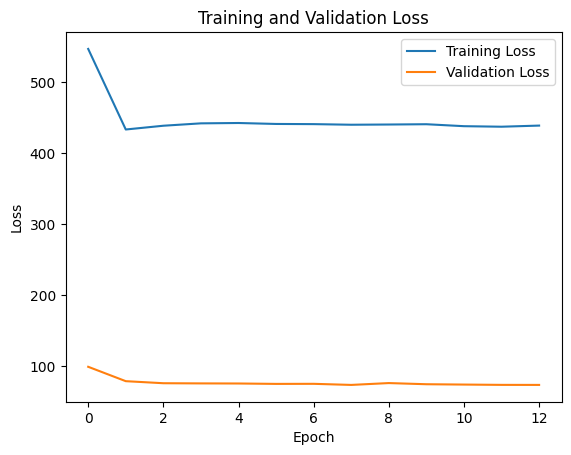

Model saved to models/gcn_5l_proteins.pth
Average Time per Epoch: 0.18s
Average CPU Usage: 33.33%
Average Memory Usage: 3.34GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 14.58%

Total Training Time: 2.29s
Max CPU Usage: 49.40%
Max Memory Usage: 3.34GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 30.50%
Fold 1 Results:
Accuracy: 0.6280
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Fold 2/3
Epoch 1, Train Loss: 530.7453335523605, Val Loss: 100.06420755386353
Time: 0.17s, CPU: 42.35%, Memory: 3.34GB, GPU: 0.02GB, GPU Util: 4.00%
Epoch 2, Train Loss: 435.2629852294922, Val Loss: 82.86919796466827
Time: 0.18s, CPU: 39.00%, Memory: 3.34GB, GPU: 0.02GB, GPU Util: 11.50%
Epoch 3, Train Loss: 438.77242970466614, Val Loss: 79.54005408287048
Time: 0.16s, CPU: 27.40%, Memory: 3.34GB, GPU: 0.02GB, GPU Util: 15.50%
Epoch 4, Train Loss: 435.8243650197983, Val Loss: 77.87371397018433
Time: 0.19s, CPU: 26.10%, Memory: 3.34GB, GPU: 0.02GB, GPU Util: 15.00%
Epoch 5, Train Loss: 

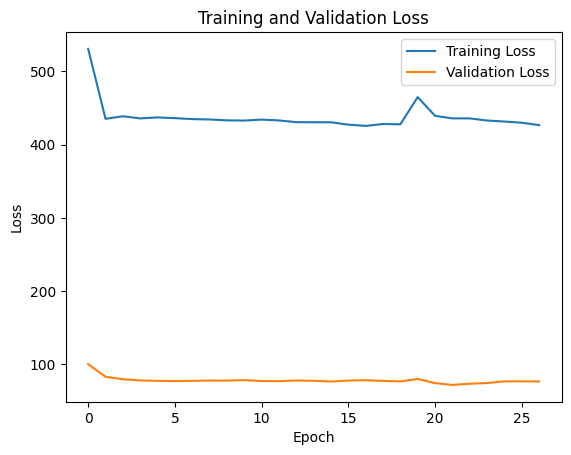

Model saved to models/gcn_5l_proteins.pth
Average Time per Epoch: 0.18s
Average CPU Usage: 30.66%
Average Memory Usage: 3.34GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 13.48%

Total Training Time: 4.78s
Max CPU Usage: 48.95%
Max Memory Usage: 3.34GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 16.00%
Fold 2 Results:
Accuracy: 0.6038
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Fold 3/3
Epoch 1, Train Loss: 530.3508812189102, Val Loss: 117.14796388149261
Time: 0.18s, CPU: 33.40%, Memory: 3.34GB, GPU: 0.02GB, GPU Util: 9.00%
Epoch 2, Train Loss: 419.14307856559753, Val Loss: 91.16238164901733
Time: 0.16s, CPU: 29.55%, Memory: 3.34GB, GPU: 0.02GB, GPU Util: 14.00%
Epoch 3, Train Loss: 423.7252371311188, Val Loss: 85.8024160861969
Time: 0.17s, CPU: 24.25%, Memory: 3.34GB, GPU: 0.02GB, GPU Util: 12.00%
Epoch 4, Train Loss: 426.7282521724701, Val Loss: 84.9388290643692
Time: 0.16s, CPU: 23.90%, Memory: 3.34GB, GPU: 0.02GB, GPU Util: 12.50%
Epoch 5, Train Loss: 42

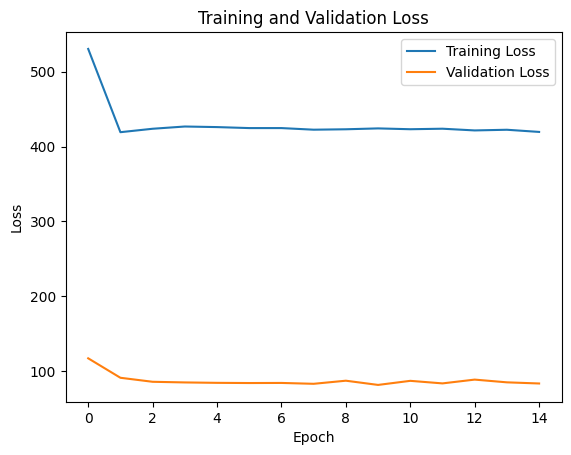

Model saved to models/gcn_5l_proteins.pth
Average Time per Epoch: 0.17s
Average CPU Usage: 30.39%
Average Memory Usage: 3.34GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 13.57%

Total Training Time: 2.61s
Max CPU Usage: 49.00%
Max Memory Usage: 3.34GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 15.50%
Fold 3 Results:
Accuracy: 0.5553
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000
Cross-Validation Results:
accuracy: Mean = 0.5957, Std = 0.0303
sensitivity: Mean = 0.0000, Std = 0.0000
specificity: Mean = 1.0000, Std = 0.0000


In [29]:
set_seed(42)
gcn5_proteins = GCN5Layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes)
print(gcn5_proteins)
print(f"Total number of trainable parameters: {(gcn5_proteins.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn5_proteins, proteins_dataset, lr=0.01, 
            num_epochs=500, step_size=500, save_path='models/gcn_5l_proteins.pth')

#### DND

GCN5Layer(
  (gcn1): GCN (89 -> 178)
  (bn1): BatchNorm1d(178, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (178 -> 356)
  (bn2): BatchNorm1d(356, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (356 -> 534)
  (bn3): BatchNorm1d(534, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn4): GCN (534 -> 356)
  (bn4): BatchNorm1d(356, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn5): GCN (356 -> 178)
  (bn5): BatchNorm1d(178, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=178, out_features=2, bias=True)
)
Total number of trainable parameters: 1055900


Fold 1/3
Epoch 1, Train Loss: 1522.0478026093915, Val Loss: 28.003880381584167
Time: 4.08s, CPU: 26.15%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 40.00%
Epoch 2, Train Loss: 621.0451933145523, Val Loss: 49.19228136539459
Time: 4.12s, CPU: 40.85%, Memory: 3.34GB, GPU: 0.03GB, GPU Util: 78.00%
Epoch

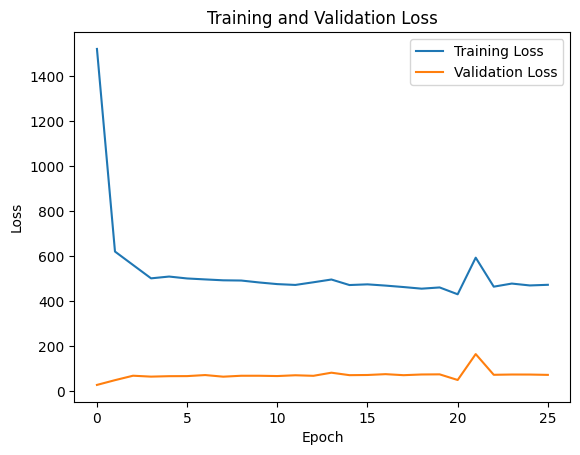

Model saved to models/gcn_5l_dnd.pth
Average Time per Epoch: 4.15s
Average CPU Usage: 32.69%
Average Memory Usage: 3.34GB
Average GPU Usage: 0.03GB
Average GPU Utilization: 79.27%

Total Training Time: 108.01s
Max CPU Usage: 43.45%
Max Memory Usage: 3.34GB
Max GPU Usage: 0.03GB
Max GPU Utilization: 90.50%
Fold 1 Results:
Accuracy: 0.4453
Average Sensitivity (Recall): 0.6752
Average Specificity: 0.2924

Fold 2/3
Epoch 1, Train Loss: 1377.2805088656023, Val Loss: 71.38388806581497
Time: 3.79s, CPU: 43.90%, Memory: 3.34GB, GPU: 0.02GB, GPU Util: 77.50%
Epoch 2, Train Loss: 677.2536503076553, Val Loss: 85.40141010284424
Time: 3.71s, CPU: 24.20%, Memory: 3.34GB, GPU: 0.03GB, GPU Util: 83.50%
Epoch 3, Train Loss: 543.3262410163879, Val Loss: 60.608309388160706
Time: 3.86s, CPU: 40.00%, Memory: 3.34GB, GPU: 0.03GB, GPU Util: 68.50%
Epoch 4, Train Loss: 529.650785446167, Val Loss: 65.55999851226807
Time: 3.83s, CPU: 35.05%, Memory: 3.34GB, GPU: 0.03GB, GPU Util: 76.00%
Epoch 5, Train Loss: 513

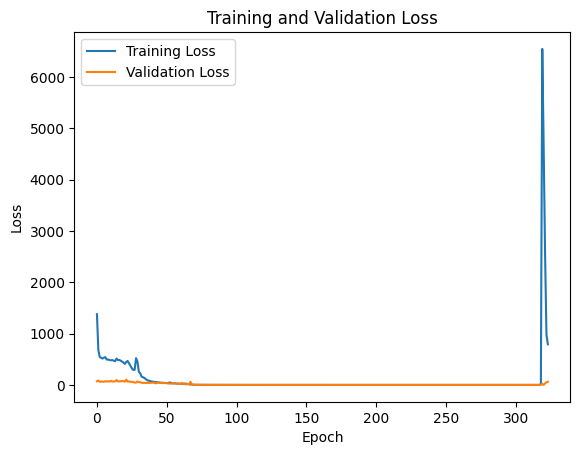

Model saved to models/gcn_5l_dnd.pth
Average Time per Epoch: 3.63s
Average CPU Usage: 32.53%
Average Memory Usage: 3.34GB
Average GPU Usage: 0.03GB
Average GPU Utilization: 79.88%

Total Training Time: 1177.57s
Max CPU Usage: 65.20%
Max Memory Usage: 3.34GB
Max GPU Usage: 0.03GB
Max GPU Utilization: 92.00%
Fold 2 Results:
Accuracy: 0.3868
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0000

Fold 3/3
Epoch 1, Train Loss: 1439.2363641397096, Val Loss: 79.27037727832794
Time: 3.55s, CPU: 35.05%, Memory: 3.34GB, GPU: 0.02GB, GPU Util: 84.00%
Epoch 2, Train Loss: 616.9865437150002, Val Loss: 82.64127838611603
Time: 3.97s, CPU: 49.10%, Memory: 3.34GB, GPU: 0.04GB, GPU Util: 76.00%
Epoch 3, Train Loss: 555.3386963605881, Val Loss: 75.66994869709015
Time: 4.00s, CPU: 39.80%, Memory: 3.34GB, GPU: 0.04GB, GPU Util: 79.50%
Epoch 4, Train Loss: 512.2495906352997, Val Loss: 75.54629045724869
Time: 4.06s, CPU: 51.75%, Memory: 3.34GB, GPU: 0.04GB, GPU Util: 71.50%
Epoch 5, Train Loss: 51

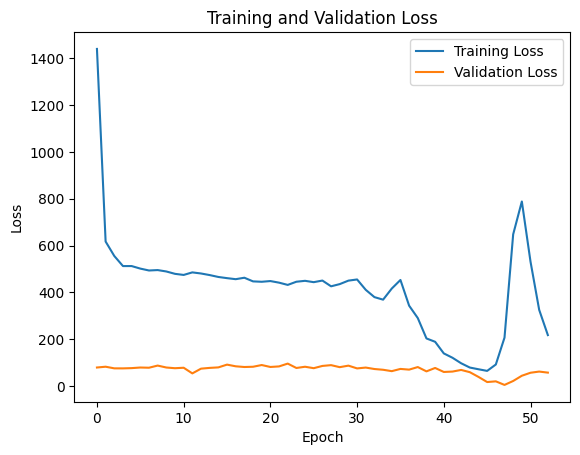

Model saved to models/gcn_5l_dnd.pth
Average Time per Epoch: 3.77s
Average CPU Usage: 33.04%
Average Memory Usage: 3.34GB
Average GPU Usage: 0.04GB
Average GPU Utilization: 81.18%

Total Training Time: 199.68s
Max CPU Usage: 53.20%
Max Memory Usage: 3.34GB
Max GPU Usage: 0.04GB
Max GPU Utilization: 93.00%
Fold 3 Results:
Accuracy: 0.4541
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0000
Cross-Validation Results:
accuracy: Mean = 0.4287, Std = 0.0299
sensitivity: Mean = 0.8917, Std = 0.1531
specificity: Mean = 0.0975, Std = 0.1378


In [28]:
set_seed(42)
gcn5_dnd = GCN5Layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes)
print(gcn5_dnd)
print(f"Total number of trainable parameters: {(gcn5_dnd.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn5_dnd, dd_dataset, lr=0.01, 
            num_epochs=500, step_size=500, save_path='models/gcn_5l_dnd.pth')

#### ENZYM

GCN5Layer(
  (gcn1): GCN (3 -> 9)
  (bn1): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (9 -> 18)
  (bn2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (18 -> 27)
  (bn3): BatchNorm1d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn4): GCN (27 -> 18)
  (bn4): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn5): GCN (18 -> 9)
  (bn5): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=9, out_features=6, bias=True)
)
Total number of trainable parameters: 3252


Fold 1/3
Epoch 1, Train Loss: 686.6446962356567, Val Loss: 64.17292308807373
Time: 0.09s, CPU: 15.00%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 1.50%
Epoch 2, Train Loss: 672.8995742797852, Val Loss: 62.4249324798584
Time: 0.08s, CPU: 10.30%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 3, Train Loss: 667.0465850830

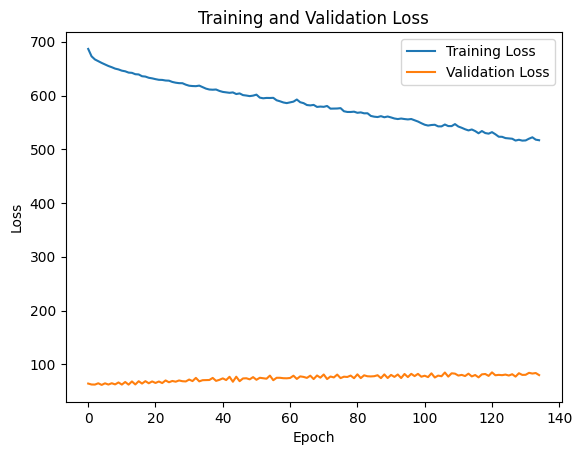

Model saved to models/gcn_5l_enzymes.pth
Average Time per Epoch: 0.09s
Average CPU Usage: 17.30%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 10.97%

Total Training Time: 12.54s
Max CPU Usage: 40.20%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 14.00%
Fold 1 Results:
Accuracy: 0.1350
Average Sensitivity (Recall): 0.1364
Average Specificity: 0.8284

Fold 2/3
Epoch 1, Train Loss: 687.1646032333374, Val Loss: 60.890926361083984
Time: 0.09s, CPU: 19.40%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 4.50%
Epoch 2, Train Loss: 671.9715461730957, Val Loss: 62.28218650817871
Time: 0.09s, CPU: 10.50%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 3, Train Loss: 666.4567909240723, Val Loss: 63.57338619232178
Time: 0.09s, CPU: 6.95%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 9.50%
Epoch 4, Train Loss: 661.6066007614136, Val Loss: 64.91403293609619
Time: 0.08s, CPU: 11.25%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 11.00%
Epoch 5, Train Loss: 657.

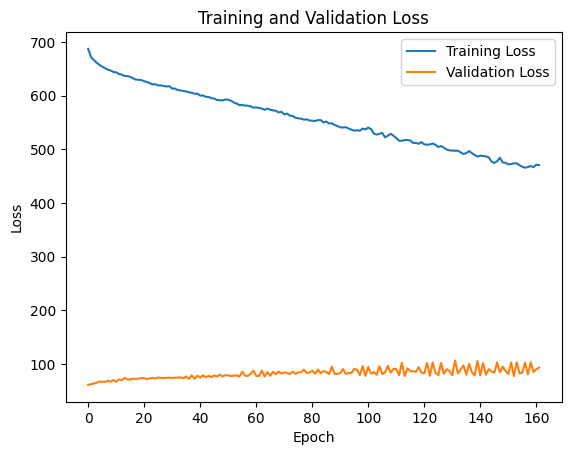

Model saved to models/gcn_5l_enzymes.pth
Average Time per Epoch: 0.10s
Average CPU Usage: 25.67%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 10.32%

Total Training Time: 16.04s
Max CPU Usage: 64.80%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 13.00%
Fold 2 Results:
Accuracy: 0.1650
Average Sensitivity (Recall): 0.1705
Average Specificity: 0.8350

Fold 3/3
Epoch 1, Train Loss: 684.4273061752319, Val Loss: 59.17963886260986
Time: 0.11s, CPU: 42.30%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 2, Train Loss: 670.9327726364136, Val Loss: 60.13739490509033
Time: 0.11s, CPU: 35.85%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 3, Train Loss: 665.40163230896, Val Loss: 60.92389488220215
Time: 0.10s, CPU: 32.75%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 10.00%
Epoch 4, Train Loss: 660.9898204803467, Val Loss: 61.23056602478027
Time: 0.10s, CPU: 35.00%, Memory: 3.33GB, GPU: 0.02GB, GPU Util: 10.00%
Epoch 5, Train Loss: 657.2

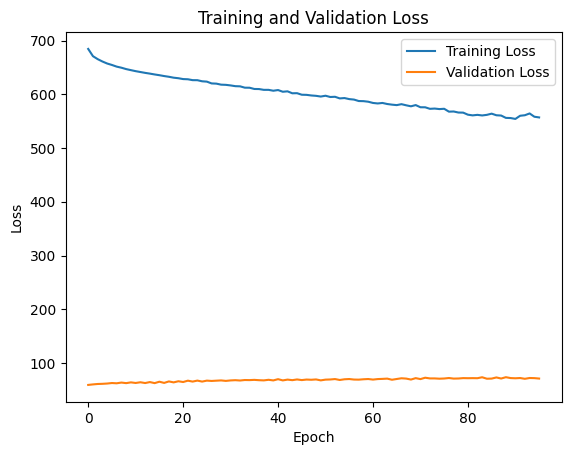

Model saved to models/gcn_5l_enzymes.pth
Average Time per Epoch: 0.09s
Average CPU Usage: 22.31%
Average Memory Usage: 3.33GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 10.97%

Total Training Time: 9.09s
Max CPU Usage: 52.45%
Max Memory Usage: 3.33GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 14.00%
Fold 3 Results:
Accuracy: 0.1900
Average Sensitivity (Recall): 0.1913
Average Specificity: 0.8382
Cross-Validation Results:
accuracy: Mean = 0.1633, Std = 0.0225
sensitivity: Mean = 0.1661, Std = 0.0227
specificity: Mean = 0.8339, Std = 0.0041


In [27]:
set_seed(42)
gcn5_enzymes = GCN5Layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes)
print(gcn5_enzymes)
print(f"Total number of trainable parameters: {(gcn5_enzymes.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn5_enzymes, enzymes_dataset, lr=0.001, 
            num_epochs=500, step_size=250, save_path='models/gcn_5l_enzymes.pth', 
            binary_classification=False)

## GCESN

### GCESN 1-Layer

#### MUTAG

In [116]:
gcesn_mutag = GCESN_1layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=0.9, num_iterations=3)
print(gcesn_mutag)
print(f"Total number of trainable parameters: {gcesn_mutag.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_mutag, mutag_dataset,
                lr=0.01, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_1l_mutag.pth')


GCESN_1layer(
  (fc1): Linear(in_features=14, out_features=14, bias=True)
  (bn): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 268


Run 1/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.8095
   Average Sensitivity (Recall): 0.7073
   Average Specificity: 1.0000
Fold 2/3
Fold 2 Results:
   Accuracy: 0.7143
   Average Sensitivity (Recall): 0.6429
   Average Specificity: 0.8571
Fold 3/3
Fold 3 Results:
   Accuracy: 0.8065
   Average Sensitivity (Recall): 0.7619
   Average Specificity: 0.9000
Run 1 Cross-Validation Results:
accuracy: Mean = 0.7768, Std = 0.0442
sensitivity: Mean = 0.7040, Std = 0.0487
specificity: Mean = 0.9190, Std = 0.0599

Run 2/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.7619
   Average Sensitivity (Recall): 1.0000
   Average Specificity: 0.3182
Fold 2/3
Fold 2 Results:
   Accuracy: 0.7619
   Average Sensitivity (Recall): 0.9048
   Average Speci

#### PROTEINS

In [121]:
gcesn_proteins = GCESN_1layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes, leaky_rate=0.9, num_iterations=3)
print(gcesn_proteins)
print(f"Total number of trainable parameters: {gcesn_proteins.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_proteins, proteins_dataset,
                lr=0.01, num_epochs=500, patience=10, step_size=50, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_1l_proteins.pth')


GCESN_1layer(
  (fc1): Linear(in_features=9, out_features=9, bias=True)
  (bn): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=9, out_features=2, bias=True)
)
Total number of trainable parameters: 128


Run 1/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6442
   Average Sensitivity (Recall): 0.0870
   Average Specificity: 0.9742
Fold 2/3
Fold 2 Results:
   Accuracy: 0.6119
   Average Sensitivity (Recall): 0.0408
   Average Specificity: 0.9866
Fold 3/3
Fold 3 Results:
   Accuracy: 0.5795
   Average Sensitivity (Recall): 0.0727
   Average Specificity: 0.9854
Run 1 Cross-Validation Results:
accuracy: Mean = 0.6119, Std = 0.0264
sensitivity: Mean = 0.0668, Std = 0.0193
specificity: Mean = 0.9821, Std = 0.0056

Run 2/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6280
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 1.0000
Fold 2/3
Fold 2 Results:
   Accuracy: 0.6038
   Average Sensitivity (Recall): 0.0000
   Average Specifici

#### DND

In [122]:
gcesn_dnd = GCESN_1layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes, leaky_rate=1, num_iterations=1)
print(gcesn_dnd)
print(f"Total number of trainable parameters: {gcesn_dnd.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_dnd, dd_dataset,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_1l_dnd.pth')


GCESN_1layer(
  (fc1): Linear(in_features=178, out_features=178, bias=True)
  (bn): BatchNorm1d(178, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=178, out_features=2, bias=True)
)
Total number of trainable parameters: 32576


Run 1/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6489
   Average Sensitivity (Recall): 0.1529
   Average Specificity: 0.9788
Fold 2/3
Fold 2 Results:
   Accuracy: 0.6539
   Average Sensitivity (Recall): 0.1974
   Average Specificity: 0.9419
Fold 3/3
Fold 3 Results:
   Accuracy: 0.5689
   Average Sensitivity (Recall): 0.0674
   Average Specificity: 0.9860
Run 1 Cross-Validation Results:
accuracy: Mean = 0.6239, Std = 0.0390
sensitivity: Mean = 0.1392, Std = 0.0539
specificity: Mean = 0.9689, Std = 0.0193

Run 2/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6565
   Average Sensitivity (Recall): 0.1529
   Average Specificity: 0.9915
Fold 2/3
Fold 2 Results:
   Accuracy: 0.6310
   Average Sensitivity (Recall): 0.3421
   Average

#### ENZYM

In [123]:
gcesn_enzymes = GCESN_1layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes, leaky_rate=0.9, num_iterations=3)
print(gcesn_enzymes)
print(f"Total number of trainable parameters: {gcesn_enzymes.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_enzymes, enzymes_dataset,
                lr=0.01, num_epochs=200, patience=10, step_size=100, gamma=0.01, 
                num_runs=5, binary_classification=False, best_model_path='models/best_gcesn_1l_enzymes.pth')


GCESN_1layer(
  (fc1): Linear(in_features=9, out_features=9, bias=True)
  (bn): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=9, out_features=6, bias=True)
)
Total number of trainable parameters: 168


Run 1/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.1650
   Average Sensitivity (Recall): 0.1667
   Average Specificity: 0.8333
Fold 2/3
Fold 2 Results:
   Accuracy: 0.2000
   Average Sensitivity (Recall): 0.2051
   Average Specificity: 0.8415
Fold 3/3
Fold 3 Results:
   Accuracy: 0.2550
   Average Sensitivity (Recall): 0.2614
   Average Specificity: 0.8515
Run 1 Cross-Validation Results:
accuracy: Mean = 0.2067, Std = 0.0370
sensitivity: Mean = 0.2110, Std = 0.0389
specificity: Mean = 0.8421, Std = 0.0074

Run 2/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.1700
   Average Sensitivity (Recall): 0.1887
   Average Specificity: 0.8367
Fold 2/3
Fold 2 Results:
   Accuracy: 0.1950
   Average Sensitivity (Recall): 0.2049
   Average Specifici

#### OASIS

In [124]:
gcesn_oasis = GCESN_1layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes, leaky_rate=0.9, num_iterations=3)
print(gcesn_oasis)
print(f"Total number of trainable parameters: {gcesn_oasis.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_oasis, oasis_dataset,
                lr=0.01, num_epochs=500, patience=10, step_size=100, gamma=0.01, 
                num_runs=5, binary_classification=False, best_model_path='models/best_gcesn_1l_oasis.pth')


GCESN_1layer(
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=16, out_features=3, bias=True)
)
Total number of trainable parameters: 355


Run 1/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.3333
   Average Sensitivity (Recall): 0.2997
   Average Specificity: 0.6499
Fold 2/3
Fold 2 Results:
   Accuracy: 0.2895
   Average Sensitivity (Recall): 0.3431
   Average Specificity: 0.6685
Fold 3/3
Fold 3 Results:
   Accuracy: 0.3158
   Average Sensitivity (Recall): 0.3209
   Average Specificity: 0.6616
Run 1 Cross-Validation Results:
accuracy: Mean = 0.3129, Std = 0.0180
sensitivity: Mean = 0.3213, Std = 0.0177
specificity: Mean = 0.6600, Std = 0.0077

Run 2/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.3596
   Average Sensitivity (Recall): 0.3689
   Average Specificity: 0.6836
Fold 2/3
Fold 2 Results:
   Accuracy: 0.3070
   Average Sensitivity (Recall): 0.2954
   Average Speci

#### EMCI-AD

In [125]:
gcesn_emci = GCESN_1layer(emci_num_features, 2*emci_num_features, emci_num_classes, leaky_rate=0.9, num_iterations=3)
print(gcesn_emci)
print(f"Total number of trainable parameters: {gcesn_emci.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_emci, emci_dataset,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_1l_emci.pth')

GCESN_1layer(
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=16, out_features=2, bias=True)
)
Total number of trainable parameters: 338


Run 1/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.5556
   Average Sensitivity (Recall): 0.6364
   Average Specificity: 0.4783
Fold 2/3
Fold 2 Results:
   Accuracy: 0.4667
   Average Sensitivity (Recall): 0.6500
   Average Specificity: 0.3200
Fold 3/3
Fold 3 Results:
   Accuracy: 0.3864
   Average Sensitivity (Recall): 0.1200
   Average Specificity: 0.7368
Run 1 Cross-Validation Results:
accuracy: Mean = 0.4695, Std = 0.0691
sensitivity: Mean = 0.4688, Std = 0.2467
specificity: Mean = 0.5117, Std = 0.1718

Run 2/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.5111
   Average Sensitivity (Recall): 0.3636
   Average Specificity: 0.6522
Fold 2/3
Fold 2 Results:
   Accuracy: 0.5333
   Average Sensitivity (Recall): 0.6000
   Average Speci

### GCESN 2-Layer

#### MUTAG

In [14]:
gcesn_mutag_2 = GCESN_2layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=1, num_iterations=1)
print(gcesn_mutag_2)
print(f"Total number of trainable parameters: {gcesn_mutag_2.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_mutag_2, mutag_dataset,
                lr=0.001, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_2l_mutag.pth')

GCESN_2layer(
  (fc1): Linear(in_features=14, out_features=28, bias=True)
  (fc2): Linear(in_features=28, out_features=28, bias=True)
  (bn): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=28, out_features=2, bias=True)
)
Total number of trainable parameters: 1346


Run 1/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.9206
   Average Sensitivity (Recall): 0.9756
   Average Specificity: 0.8182
Fold 2/3
Fold 2 Results:
   Accuracy: 0.7778
   Average Sensitivity (Recall): 0.8095
   Average Specificity: 0.7143
Fold 3/3
Fold 3 Results:
   Accuracy: 0.8871
   Average Sensitivity (Recall): 0.9048
   Average Specificity: 0.8500
Run 1 Cross-Validation Results:
accuracy: Mean = 0.8618, Std = 0.0610
sensitivity: Mean = 0.8966, Std = 0.0680
specificity: Mean = 0.7942, Std = 0.0580

Run 2/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.7619
   Average Sensitivity (Recall): 0.9756
   Average Specificity: 0.3636
Fold 2/3
Fold 2 Results:
   Accuracy: 0.

#### PROTEINS

In [15]:
gcesn_proteins_2 = GCESN_2layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes, leaky_rate=0.9, num_iterations=3)
print(gcesn_proteins_2)
print(f"Total number of trainable parameters: {gcesn_proteins_2.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_proteins_2, proteins_dataset,
                lr=0.0005, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_2l_proteins.pth')


GCESN_2layer(
  (fc1): Linear(in_features=9, out_features=18, bias=True)
  (fc2): Linear(in_features=18, out_features=18, bias=True)
  (bn): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=18, out_features=2, bias=True)
)
Total number of trainable parameters: 596


Run 1/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6415
   Average Sensitivity (Recall): 0.1594
   Average Specificity: 0.9270
Fold 2/3
Fold 2 Results:
   Accuracy: 0.5984
   Average Sensitivity (Recall): 0.0204
   Average Specificity: 0.9777
Fold 3/3
Fold 3 Results:
   Accuracy: 0.5526
   Average Sensitivity (Recall): 0.0061
   Average Specificity: 0.9903
Run 1 Cross-Validation Results:
accuracy: Mean = 0.5975, Std = 0.0363
sensitivity: Mean = 0.0620, Std = 0.0692
specificity: Mean = 0.9650, Std = 0.0273

Run 2/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6604
   Average Sensitivity (Recall): 0.1667
   Average Specificity: 0.9528
Fold 2/3
Fold 2 Results:
   Accuracy: 0.61

#### DND

In [16]:
gcesn_dnd_2 = GCESN_2layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes, leaky_rate=0.9, num_iterations=2)
print(gcesn_dnd_2)
print(f"Total number of trainable parameters: {gcesn_dnd_2.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_dnd_2, dd_dataset,
                lr=0.0001, num_epochs=200, patience=10, step_size=100, gamma=0.01, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_2l_dnd.pth')


GCESN_2layer(
  (fc1): Linear(in_features=178, out_features=356, bias=True)
  (fc2): Linear(in_features=356, out_features=356, bias=True)
  (bn): BatchNorm1d(356, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=356, out_features=2, bias=True)
)
Total number of trainable parameters: 192242


Run 1/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.5318
   Average Sensitivity (Recall): 0.4459
   Average Specificity: 0.5890
Fold 2/3
Fold 2 Results:
   Accuracy: 0.5038
   Average Sensitivity (Recall): 0.1382
   Average Specificity: 0.7344
Fold 3/3
Fold 3 Results:
   Accuracy: 0.4235
   Average Sensitivity (Recall): 0.3371
   Average Specificity: 0.4953
Run 1 Cross-Validation Results:
accuracy: Mean = 0.4864, Std = 0.0459
sensitivity: Mean = 0.3070, Std = 0.1274
specificity: Mean = 0.6062, Std = 0.0984

Run 2/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.4453
   Average Sensitivity (Recall): 0.6433
   Average Specificity: 0.3136
Fold 2/3
Fold 2 Results:
   Accu

#### ENZYM

In [17]:
gcesn_enzymes_2 = GCESN_2layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes, leaky_rate=0.9, num_iterations=1)
print(gcesn_enzymes_2)
print(f"Total number of trainable parameters: {gcesn_enzymes_2.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_enzymes_2, enzymes_dataset,
                lr=0.005, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=False, best_model_path='models/best_gcesn_2l_enzymes.pth')


GCESN_2layer(
  (fc1): Linear(in_features=9, out_features=18, bias=True)
  (fc2): Linear(in_features=18, out_features=18, bias=True)
  (bn): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=18, out_features=6, bias=True)
)
Total number of trainable parameters: 672


Run 1/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.1750
   Average Sensitivity (Recall): 0.1763
   Average Specificity: 0.8353
Fold 2/3
Fold 2 Results:
   Accuracy: 0.1950
   Average Sensitivity (Recall): 0.2004
   Average Specificity: 0.8400
Fold 3/3
Fold 3 Results:
   Accuracy: 0.2600
   Average Sensitivity (Recall): 0.2487
   Average Specificity: 0.8506
Run 1 Cross-Validation Results:
accuracy: Mean = 0.2100, Std = 0.0363
sensitivity: Mean = 0.2085, Std = 0.0301
specificity: Mean = 0.8420, Std = 0.0064

Run 2/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.1700
   Average Sensitivity (Recall): 0.1709
   Average Specificity: 0.8342
Fold 2/3
Fold 2 Results:
   Accuracy: 0.22

#### OASIS

In [18]:
gcesn_oasis_2 = GCESN_2layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes, leaky_rate=0.8, num_iterations=3)
print(gcesn_oasis_2)
print(f"Total number of trainable parameters: {gcesn_oasis_2.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_oasis_2, oasis_dataset,
                lr=0.0005, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=False, best_model_path='models/best_gcesn_2l_oasis.pth')


GCESN_2layer(
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)
Total number of trainable parameters: 1763


Run 1/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.2544
   Average Sensitivity (Recall): 0.3030
   Average Specificity: 0.6498
Fold 2/3
Fold 2 Results:
   Accuracy: 0.3509
   Average Sensitivity (Recall): 0.3854
   Average Specificity: 0.6873
Fold 3/3
Fold 3 Results:
   Accuracy: 0.3509
   Average Sensitivity (Recall): 0.3516
   Average Specificity: 0.6761
Run 1 Cross-Validation Results:
accuracy: Mean = 0.3187, Std = 0.0455
sensitivity: Mean = 0.3466, Std = 0.0338
specificity: Mean = 0.6711, Std = 0.0157

Run 2/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.2456
   Average Sensitivity (Recall): 0.2738
   Average Specificity: 0.6366
Fold 2/3
Fold 2 Results:
   Accuracy: 0.

#### EMCI-AD

In [21]:
gcesn_emci_2 = GCESN_2layer(emci_num_features, 2*emci_num_features, emci_num_classes, leaky_rate=0.9, num_iterations=3)
print(gcesn_emci_2)
print(f"Total number of trainable parameters: {gcesn_emci_2.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_emci_2, emci_dataset,
                lr=0.0001, num_epochs=200, patience=10, step_size=100, gamma=0.1, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_2l_emci.pth')

GCESN_2layer(
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
Total number of trainable parameters: 1730


Run 1/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.5333
   Average Sensitivity (Recall): 0.3182
   Average Specificity: 0.7391
Fold 2/3
Fold 2 Results:
   Accuracy: 0.4889
   Average Sensitivity (Recall): 0.6000
   Average Specificity: 0.4000
Fold 3/3
Fold 3 Results:
   Accuracy: 0.4773
   Average Sensitivity (Recall): 0.2000
   Average Specificity: 0.8421
Run 1 Cross-Validation Results:
accuracy: Mean = 0.4998, Std = 0.0242
sensitivity: Mean = 0.3727, Std = 0.1678
specificity: Mean = 0.6604, Std = 0.1889

Run 2/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.4222
   Average Sensitivity (Recall): 0.2727
   Average Specificity: 0.5652
Fold 2/3
Fold 2 Results:
   Accuracy: 0.

### GCESN 3-Layer

#### MUTAG

In [22]:
gcesn_mutag_3 = GCESN_3layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=0.9, num_iterations=2)
print(gcesn_mutag_3)
print(f"Total number of trainable parameters: {gcesn_mutag_3.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_mutag_3, mutag_dataset,
                lr=0.005, num_epochs=200, patience=10, step_size=100, gamma=0.1, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_3l_mutag.pth')

GCESN_3layer(
  (fc1): Linear(in_features=14, out_features=28, bias=True)
  (fc2): Linear(in_features=28, out_features=14, bias=True)
  (fc3): Linear(in_features=14, out_features=14, bias=True)
  (bn): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 1094


Run 1/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.9206
   Average Sensitivity (Recall): 0.9756
   Average Specificity: 0.8182
Fold 2/3
Fold 2 Results:
   Accuracy: 0.6984
   Average Sensitivity (Recall): 0.8810
   Average Specificity: 0.3333
Fold 3/3
Fold 3 Results:
   Accuracy: 0.8065
   Average Sensitivity (Recall): 0.8095
   Average Specificity: 0.8000
Run 1 Cross-Validation Results:
accuracy: Mean = 0.8085, Std = 0.0907
sensitivity: Mean = 0.8887, Std = 0.0680
specificity: Mean = 0.6505, Std = 0.2244

Run 2/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6984
   Average Sensitivity (Recall): 1.0000
   Average 

#### PROTEINS

In [23]:
gcesn_proteins_3 = GCESN_3layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes, leaky_rate=0.9, num_iterations=2)
print(gcesn_proteins_3)
print(f"Total number of trainable parameters: {gcesn_proteins_3.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_proteins_3, proteins_dataset,
                lr=0.001, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_3l_proteins.pth')


GCESN_3layer(
  (fc1): Linear(in_features=9, out_features=18, bias=True)
  (fc2): Linear(in_features=18, out_features=9, bias=True)
  (fc3): Linear(in_features=9, out_features=9, bias=True)
  (bn): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=9, out_features=2, bias=True)
)
Total number of trainable parameters: 479


Run 1/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6173
   Average Sensitivity (Recall): 0.0072
   Average Specificity: 0.9785
Fold 2/3
Fold 2 Results:
   Accuracy: 0.5930
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 0.9821
Fold 3/3
Fold 3 Results:
   Accuracy: 0.5472
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 0.9854
Run 1 Cross-Validation Results:
accuracy: Mean = 0.5858, Std = 0.0291
sensitivity: Mean = 0.0024, Std = 0.0034
specificity: Mean = 0.9820, Std = 0.0028

Run 2/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6523
   Average Sensitivity (Recall): 0.1304
   Average Specifi

#### DND

In [31]:
gcesn_dnd_3 = GCESN_3layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes, leaky_rate=1, num_iterations=1)
print(gcesn_dnd_3)
print(f"Total number of trainable parameters: {gcesn_dnd_3.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_dnd_3, dd_dataset,
                lr=0.0005, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_3l_dnd.pth')


GCESN_3layer(
  (fc1): Linear(in_features=178, out_features=356, bias=True)
  (fc2): Linear(in_features=356, out_features=178, bias=True)
  (fc3): Linear(in_features=178, out_features=178, bias=True)
  (bn): BatchNorm1d(178, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=178, out_features=2, bias=True)
)
Total number of trainable parameters: 159846


Run 1/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6158
   Average Sensitivity (Recall): 0.3822
   Average Specificity: 0.7712
Fold 2/3
Fold 2 Results:
   Accuracy: 0.3690
   Average Sensitivity (Recall): 0.9474
   Average Specificity: 0.0041
Fold 3/3
Fold 3 Results:
   Accuracy: 0.4209
   Average Sensitivity (Recall): 0.9213
   Average Specificity: 0.0047
Run 1 Cross-Validation Results:
accuracy: Mean = 0.4686, Std = 0.1062
sensitivity: Mean = 0.7503, Std = 0.2605
specificity: Mean = 0.2600, Std = 0.3615

Run 2/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6031
   Average Sensitivity (Recall): 0.0191
 

#### ENZYM

In [24]:
gcesn_enzymes_3 = GCESN_3layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes, leaky_rate=0.8, num_iterations=1)
print(gcesn_enzymes_3)
print(f"Total number of trainable parameters: {gcesn_enzymes_3.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_enzymes_3, enzymes_dataset,
                lr=0.01, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=False, best_model_path='models/best_gcesn_3l_enzymes.pth')


GCESN_3layer(
  (fc1): Linear(in_features=9, out_features=18, bias=True)
  (fc2): Linear(in_features=18, out_features=9, bias=True)
  (fc3): Linear(in_features=9, out_features=9, bias=True)
  (bn): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=9, out_features=6, bias=True)
)
Total number of trainable parameters: 519


Run 1/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.1350
   Average Sensitivity (Recall): 0.1486
   Average Specificity: 0.8299
Fold 2/3
Fold 2 Results:
   Accuracy: 0.1700
   Average Sensitivity (Recall): 0.1759
   Average Specificity: 0.8351
Fold 3/3
Fold 3 Results:
   Accuracy: 0.1850
   Average Sensitivity (Recall): 0.1689
   Average Specificity: 0.8340
Run 1 Cross-Validation Results:
accuracy: Mean = 0.1633, Std = 0.0209
sensitivity: Mean = 0.1644, Std = 0.0116
specificity: Mean = 0.8330, Std = 0.0022

Run 2/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.1600
   Average Sensitivity (Recall): 0.1760
   Average Specifi

### GCESN 4-Layer

#### MUTAG

In [25]:
gcesn_mutag_4 = GCESN_4layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=1, num_iterations=1)
print(gcesn_mutag_4)
print(f"Total number of trainable parameters: {gcesn_mutag_4.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_mutag_4, mutag_dataset,
                lr=0.005, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_4l_mutag.pth')

GCESN_4layer(
  (fc1): Linear(in_features=14, out_features=28, bias=True)
  (fc2): Linear(in_features=28, out_features=42, bias=True)
  (fc3): Linear(in_features=42, out_features=28, bias=True)
  (fc4): Linear(in_features=28, out_features=28, bias=True)
  (bn): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=28, out_features=2, bias=True)
)
Total number of trainable parameters: 3768


Run 1/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.8571
   Average Sensitivity (Recall): 0.9756
   Average Specificity: 0.6364
Fold 2/3
Fold 2 Results:
   Accuracy: 0.8254
   Average Sensitivity (Recall): 0.8333
   Average Specificity: 0.8095
Fold 3/3
Fold 3 Results:
   Accuracy: 0.8065
   Average Sensitivity (Recall): 0.9524
   Average Specificity: 0.5000
Run 1 Cross-Validation Results:
accuracy: Mean = 0.8297, Std = 0.0209
sensitivity: Mean = 0.9204, Std = 0.0623
specificity: Mean = 0.6486, Std = 0.1267

Run 2/5
Fold 1/3
Fold 1 Results:
   Accuracy

#### PROTEINS

In [26]:
gcesn_proteins_4 = GCESN_4layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes, leaky_rate=0.9, num_iterations=1)
print(gcesn_proteins_4)
print(f"Total number of trainable parameters: {gcesn_proteins_4.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_proteins_4, proteins_dataset,
                lr=0.001, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=10, binary_classification=True, best_model_path='models/best_gcesn_4l_proteins.pth')


GCESN_4layer(
  (fc1): Linear(in_features=9, out_features=18, bias=True)
  (fc2): Linear(in_features=18, out_features=27, bias=True)
  (fc3): Linear(in_features=27, out_features=18, bias=True)
  (fc4): Linear(in_features=18, out_features=18, bias=True)
  (bn): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=18, out_features=2, bias=True)
)
Total number of trainable parameters: 1613


Run 1/10
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6307
   Average Sensitivity (Recall): 0.0145
   Average Specificity: 0.9957
Fold 2/3
Fold 2 Results:
   Accuracy: 0.4933
   Average Sensitivity (Recall): 0.3129
   Average Specificity: 0.6116
Fold 3/3
Fold 3 Results:
   Accuracy: 0.5876
   Average Sensitivity (Recall): 0.0909
   Average Specificity: 0.9854
Run 1 Cross-Validation Results:
accuracy: Mean = 0.5705, Std = 0.0574
sensitivity: Mean = 0.1394, Std = 0.1266
specificity: Mean = 0.8643, Std = 0.1787

Run 2/10
Fold 1/3
Fold 1 Results:
   Accurac

#### DND

In [27]:
gcesn_dnd_4 = GCESN_4layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes, leaky_rate=1, num_iterations=1)
print(gcesn_dnd_4)
print(f"Total number of trainable parameters: {gcesn_dnd_4.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_dnd_4, dd_dataset,
                lr=0.0001, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_4l_dnd.pth')


GCESN_4layer(
  (fc1): Linear(in_features=178, out_features=356, bias=True)
  (fc2): Linear(in_features=356, out_features=534, bias=True)
  (fc3): Linear(in_features=534, out_features=356, bias=True)
  (fc4): Linear(in_features=356, out_features=356, bias=True)
  (bn): BatchNorm1d(356, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=356, out_features=2, bias=True)
)
Total number of trainable parameters: 573340


Run 1/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.5522
   Average Sensitivity (Recall): 0.4140
   Average Specificity: 0.6441
Fold 2/3
Fold 2 Results:
   Accuracy: 0.5878
   Average Sensitivity (Recall): 0.1053
   Average Specificity: 0.8921
Fold 3/3
Fold 3 Results:
   Accuracy: 0.4082
   Average Sensitivity (Recall): 0.7303
   Average Specificity: 0.1402
Run 1 Cross-Validation Results:
accuracy: Mean = 0.5160, Std = 0.0777
sensitivity: Mean = 0.4165, Std = 0.2552
specificity: Mean = 0.5588, Std = 0.3128

Run 2/5
Fold 1/3
Fold 1 Results:

#### ENZYM

In [27]:
gcesn_enzymes_4 = GCESN_4layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes, leaky_rate=1, num_iterations=1)
print(gcesn_enzymes_4)
print(f"Total number of trainable parameters: {gcesn_enzymes_4.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_enzymes_4, enzymes_dataset,
                lr=0.001, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=False, best_model_path='models/best_gcesn_4l_enzymes.pth')


GCESN_4layer(
  (fc1): Linear(in_features=9, out_features=18, bias=True)
  (fc2): Linear(in_features=18, out_features=27, bias=True)
  (fc3): Linear(in_features=27, out_features=18, bias=True)
  (fc4): Linear(in_features=18, out_features=18, bias=True)
  (bn): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=18, out_features=6, bias=True)
)
Total number of trainable parameters: 1689


Run 1/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.1600
   Average Sensitivity (Recall): 0.1581
   Average Specificity: 0.8321
Fold 2/3
Fold 2 Results:
   Accuracy: 0.1450
   Average Sensitivity (Recall): 0.1542
   Average Specificity: 0.8313
Fold 3/3
Fold 3 Results:
   Accuracy: 0.2150
   Average Sensitivity (Recall): 0.2029
   Average Specificity: 0.8409
Run 1 Cross-Validation Results:
accuracy: Mean = 0.1733, Std = 0.0301
sensitivity: Mean = 0.1717, Std = 0.0221
specificity: Mean = 0.8348, Std = 0.0044

Run 2/5
Fold 1/3
Fold 1 Results:
   Accuracy:

### GCESN 5-Layer

#### MUTAG

In [28]:
gcesn_mutag_5 = GCESN_5layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=0.9, num_iterations=1)
print(gcesn_mutag_5)
print(f"Total number of trainable parameters: {gcesn_mutag_5.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_mutag_5, mutag_dataset,
                lr=0.005, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_5l_mutag.pth')

GCESN_5layer(
  (fc1): Linear(in_features=14, out_features=28, bias=True)
  (fc2): Linear(in_features=28, out_features=42, bias=True)
  (fc3): Linear(in_features=42, out_features=28, bias=True)
  (fc4): Linear(in_features=28, out_features=14, bias=True)
  (fc5): Linear(in_features=14, out_features=14, bias=True)
  (bn): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 3516


Run 1/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.8571
   Average Sensitivity (Recall): 0.9756
   Average Specificity: 0.6364
Fold 2/3
Fold 2 Results:
   Accuracy: 0.8254
   Average Sensitivity (Recall): 0.8333
   Average Specificity: 0.8095
Fold 3/3
Fold 3 Results:
   Accuracy: 0.7742
   Average Sensitivity (Recall): 0.7143
   Average Specificity: 0.9000
Run 1 Cross-Validation Results:
accuracy: Mean = 0.8189, Std = 0.0342
sensitivity: Mean = 0.8411, Std = 0.1068
specificity: Mean = 0.7820

#### PROTEINS

In [29]:
gcesn_proteins_5 = GCESN_5layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes, leaky_rate=0.9, num_iterations=2)
print(gcesn_proteins_5)
print(f"Total number of trainable parameters: {gcesn_proteins_5.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_proteins_5, proteins_dataset,
                lr=0.0005, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_5l_proteins.pth')


GCESN_5layer(
  (fc1): Linear(in_features=9, out_features=18, bias=True)
  (fc2): Linear(in_features=18, out_features=27, bias=True)
  (fc3): Linear(in_features=27, out_features=18, bias=True)
  (fc4): Linear(in_features=18, out_features=9, bias=True)
  (fc5): Linear(in_features=9, out_features=9, bias=True)
  (bn): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=9, out_features=2, bias=True)
)
Total number of trainable parameters: 1496


Run 1/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.6280
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 1.0000
Fold 2/3
Fold 2 Results:
   Accuracy: 0.6011
   Average Sensitivity (Recall): 0.0204
   Average Specificity: 0.9821
Fold 3/3
Fold 3 Results:
   Accuracy: 0.5553
   Average Sensitivity (Recall): 0.0000
   Average Specificity: 1.0000
Run 1 Cross-Validation Results:
accuracy: Mean = 0.5948, Std = 0.0300
sensitivity: Mean = 0.0068, Std = 0.0096
specificity: Mean = 0.9940, Std 

#### DND

In [28]:
gcesn_dnd_5 = GCESN_5layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes, leaky_rate=0.9, num_iterations=1)
print(gcesn_dnd_5)
print(f"Total number of trainable parameters: {gcesn_dnd_5.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_dnd_5, dd_dataset,
                lr=0.0005, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_5l_dnd.pth')


GCESN_5layer(
  (fc1): Linear(in_features=178, out_features=356, bias=True)
  (fc2): Linear(in_features=356, out_features=534, bias=True)
  (fc3): Linear(in_features=534, out_features=356, bias=True)
  (fc4): Linear(in_features=356, out_features=178, bias=True)
  (fc5): Linear(in_features=178, out_features=178, bias=True)
  (bn): BatchNorm1d(178, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=178, out_features=2, bias=True)
)
Total number of trainable parameters: 540944


Run 1/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.3919
   Average Sensitivity (Recall): 0.9745
   Average Specificity: 0.0042
Fold 2/3
Fold 2 Results:
   Accuracy: 0.6005
   Average Sensitivity (Recall): 0.2368
   Average Specificity: 0.8299
Fold 3/3
Fold 3 Results:
   Accuracy: 0.4439
   Average Sensitivity (Recall): 0.0955
   Average Specificity: 0.7336
Run 1 Cross-Validation Results:
accuracy: Mean = 0.4787, Std = 0.0887
sensitivity: Mean = 0.4356, Std = 0.3854
specificity:

#### ENZYM

In [30]:
gcesn_enzymes_5 = GCESN_5layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes, leaky_rate=0.8, num_iterations=1)
print(gcesn_enzymes_5)
print(f"Total number of trainable parameters: {gcesn_enzymes_5.count_parameters()}\n")

avg_metrics = multi_train_test_cv(gcesn_enzymes_5, enzymes_dataset,
                lr=0.005, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=False, best_model_path='models/best_gcesn_5l_enzymes.pth')


GCESN_5layer(
  (fc1): Linear(in_features=9, out_features=18, bias=True)
  (fc2): Linear(in_features=18, out_features=27, bias=True)
  (fc3): Linear(in_features=27, out_features=18, bias=True)
  (fc4): Linear(in_features=18, out_features=9, bias=True)
  (fc5): Linear(in_features=9, out_features=9, bias=True)
  (bn): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=9, out_features=6, bias=True)
)
Total number of trainable parameters: 1536


Run 1/5
Fold 1/3
Fold 1 Results:
   Accuracy: 0.1450
   Average Sensitivity (Recall): 0.1484
   Average Specificity: 0.8299
Fold 2/3
Fold 2 Results:
   Accuracy: 0.1650
   Average Sensitivity (Recall): 0.1784
   Average Specificity: 0.8359
Fold 3/3
Fold 3 Results:
   Accuracy: 0.1450
   Average Sensitivity (Recall): 0.1338
   Average Specificity: 0.8267
Run 1 Cross-Validation Results:
accuracy: Mean = 0.1517, Std = 0.0094
sensitivity: Mean = 0.1535, Std = 0.0186
specificity: Mean = 0.8308, Std 

## Trainable GCESN

### Trainable GCESN 1-Layer

#### MUTAG

Total number of trainable parameters: 562


Fold 1/3
Epoch 1, Train Loss: 70.75753927230835, Val Loss: 8.670067012310028
Time: 0.67s, CPU: 28.95%, Memory: 3.85GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 68.86805820465088, Val Loss: 8.641494810581207
Time: 0.04s, CPU: 36.65%, Memory: 3.87GB, GPU: 0.02GB, GPU Util: 0.50%
Epoch 3, Train Loss: 67.58380222320557, Val Loss: 8.596185624599457
Time: 0.04s, CPU: 41.70%, Memory: 3.87GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 4, Train Loss: 66.27054214477539, Val Loss: 8.554978549480438
Time: 0.04s, CPU: 28.05%, Memory: 3.87GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 5, Train Loss: 65.09473037719727, Val Loss: 8.517941772937775
Time: 0.04s, CPU: 36.65%, Memory: 3.87GB, GPU: 0.02GB, GPU Util: 2.50%
Epoch 6, Train Loss: 63.8687424659729, Val Loss: 8.451734602451324
Time: 0.04s, CPU: 46.45%, Memory: 3.87GB, GPU: 0.02GB, GPU Util: 4.00%
Epoch 7, Train Loss: 62.481192111968994, Val Loss: 8.363620579242706
Time: 0.04s, CPU: 33.65%, Memory: 3.87GB, GPU

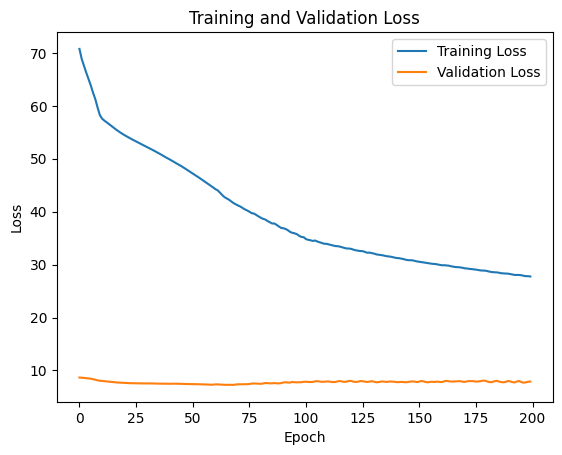

Model saved to models/trainable_gcesn_1l_mutag.pth
Average Time per Epoch: 0.04s
Average CPU Usage: 24.80%
Average Memory Usage: 3.87GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 4.89%

Total Training Time: 7.30s
Max CPU Usage: 74.40%
Max Memory Usage: 3.87GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 6.00%
Fold 1 Results:
Accuracy: 0.8571
Average Sensitivity (Recall): 0.9512
Average Specificity: 0.6818

Fold 2/3
Epoch 1, Train Loss: 70.67662715911865, Val Loss: 8.996475398540497
Time: 0.04s, CPU: 46.45%, Memory: 3.87GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 67.82417106628418, Val Loss: 8.98466807603836
Time: 0.03s, CPU: 34.30%, Memory: 3.87GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 3, Train Loss: 65.48457336425781, Val Loss: 8.957265138626099
Time: 0.03s, CPU: 21.60%, Memory: 3.87GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 4, Train Loss: 63.43140411376953, Val Loss: 8.945528328418732
Time: 0.03s, CPU: 21.60%, Memory: 3.87GB, GPU: 0.02GB, GPU Util: 2.50%
Epoch 5, Train Loss:

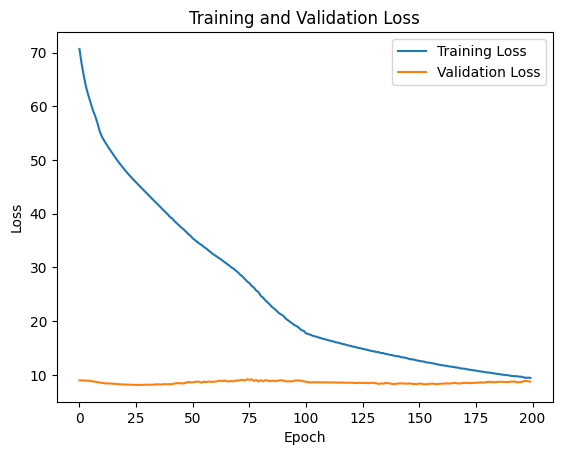

Model saved to models/trainable_gcesn_1l_mutag.pth
Average Time per Epoch: 0.03s
Average CPU Usage: 19.13%
Average Memory Usage: 3.87GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 4.97%

Total Training Time: 6.59s
Max CPU Usage: 59.40%
Max Memory Usage: 3.87GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 6.00%
Fold 2 Results:
Accuracy: 0.7778
Average Sensitivity (Recall): 0.8095
Average Specificity: 0.7143

Fold 3/3
Epoch 1, Train Loss: 73.41535037755966, Val Loss: 8.324941873550415
Time: 0.03s, CPU: 20.40%, Memory: 3.87GB, GPU: 0.02GB, GPU Util: 2.50%
Epoch 2, Train Loss: 70.99440860748291, Val Loss: 8.258787393569946
Time: 0.03s, CPU: 6.80%, Memory: 3.87GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 3, Train Loss: 69.03526437282562, Val Loss: 8.20149964094162
Time: 0.03s, CPU: 13.85%, Memory: 3.87GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 4, Train Loss: 67.17914289236069, Val Loss: 8.164562821388245
Time: 0.03s, CPU: 11.55%, Memory: 3.87GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 5, Train Loss: 

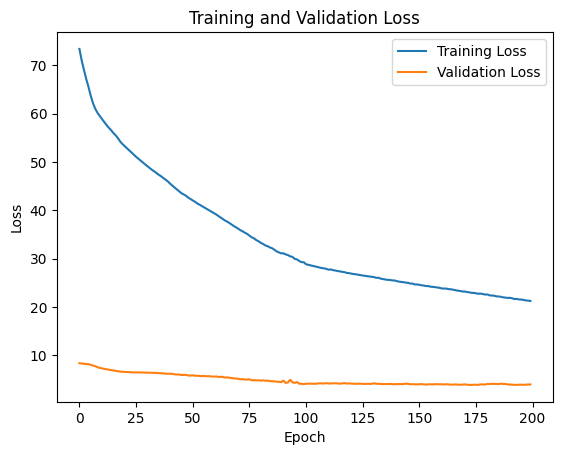

Model saved to models/trainable_gcesn_1l_mutag.pth
Average Time per Epoch: 0.03s
Average CPU Usage: 15.62%
Average Memory Usage: 3.87GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 4.97%

Total Training Time: 6.49s
Max CPU Usage: 43.65%
Max Memory Usage: 3.87GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 6.00%
Fold 3 Results:
Accuracy: 0.8548
Average Sensitivity (Recall): 0.8810
Average Specificity: 0.8000
Cross-Validation Results:
accuracy: Mean = 0.8299, Std = 0.0369
sensitivity: Mean = 0.8806, Std = 0.0578
specificity: Mean = 0.7320, Std = 0.0499


In [42]:
set_seed(42)
trainable_gcesn_mutag = TrainableGCESN_1layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_mutag.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_mutag, mutag_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_1l_mutag.pth',
                binary_classification=True, is_esn=True)

#### PROTEINS

Total number of trainable parameters: 122


Fold 1/3
Epoch 1, Train Loss: 462.6793689131737, Val Loss: 61.48837095499039
Time: 0.29s, CPU: 28.85%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 3.00%
Epoch 2, Train Loss: 453.50859624147415, Val Loss: 64.78697866201401
Time: 0.18s, CPU: 25.95%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 7.50%
Epoch 3, Train Loss: 451.70707672834396, Val Loss: 65.83202946186066
Time: 0.15s, CPU: 21.80%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 10.00%
Epoch 4, Train Loss: 450.50748282670975, Val Loss: 66.50430119037628
Time: 0.17s, CPU: 30.20%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 11.00%
Epoch 5, Train Loss: 449.5160710811615, Val Loss: 67.07776761054993
Time: 0.14s, CPU: 22.50%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 10.50%
Epoch 6, Train Loss: 448.6604063510895, Val Loss: 67.61000156402588
Time: 0.17s, CPU: 24.90%, Memory: 4.42GB, GPU: 0.24GB, GPU Util: 11.00%
Epoch 7, Train Loss: 447.91435170173645, Val Loss: 68.06582945585251
Time: 0.17s, CPU: 32.20%, Memory: 4.4

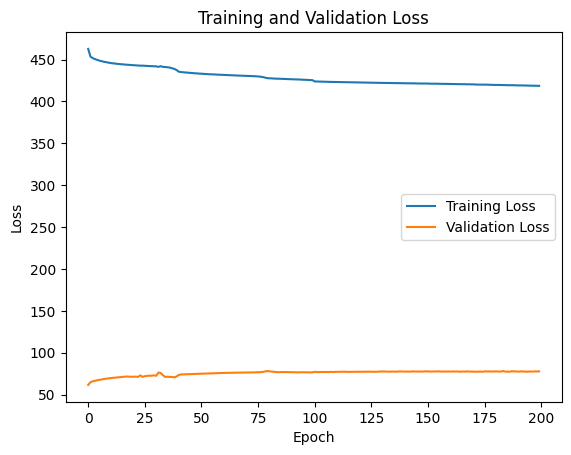

Model saved to models/trainable_gcesn_1l_proteins.pth
Average Time per Epoch: 0.17s
Average CPU Usage: 25.31%
Average Memory Usage: 4.36GB
Average GPU Usage: 0.05GB
Average GPU Utilization: 10.08%

Total Training Time: 34.29s
Max CPU Usage: 53.95%
Max Memory Usage: 4.42GB
Max GPU Usage: 0.24GB
Max GPU Utilization: 13.00%
Fold 1 Results:
Accuracy: 0.6280
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Fold 2/3
Epoch 1, Train Loss: 457.14585357904434, Val Loss: 60.299150586128235
Time: 0.16s, CPU: 20.20%, Memory: 4.35GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 2, Train Loss: 448.3767054080963, Val Loss: 63.044937431812286
Time: 0.17s, CPU: 17.65%, Memory: 4.35GB, GPU: 0.02GB, GPU Util: 7.50%
Epoch 3, Train Loss: 446.3114839196205, Val Loss: 64.13066560029984
Time: 0.15s, CPU: 11.00%, Memory: 4.35GB, GPU: 0.02GB, GPU Util: 11.00%
Epoch 4, Train Loss: 444.9027889370918, Val Loss: 64.96548628807068
Time: 0.15s, CPU: 10.45%, Memory: 4.35GB, GPU: 0.02GB, GPU Util: 12.00%
Epoch 5,

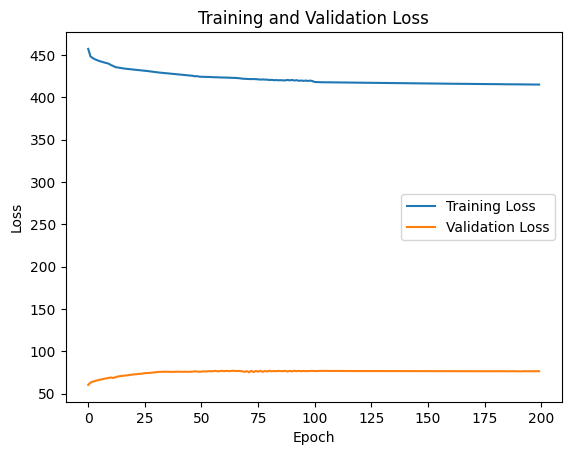

Model saved to models/trainable_gcesn_1l_proteins.pth
Average Time per Epoch: 0.16s
Average CPU Usage: 16.76%
Average Memory Usage: 4.35GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 10.57%

Total Training Time: 31.70s
Max CPU Usage: 45.30%
Max Memory Usage: 4.35GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 13.50%
Fold 2 Results:
Accuracy: 0.6038
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Fold 3/3
Epoch 1, Train Loss: 454.463416993618, Val Loss: 62.11553281545639
Time: 0.16s, CPU: 23.30%, Memory: 4.35GB, GPU: 0.02GB, GPU Util: 6.50%
Epoch 2, Train Loss: 444.74903440475464, Val Loss: 65.19124007225037
Time: 0.18s, CPU: 17.45%, Memory: 4.35GB, GPU: 0.02GB, GPU Util: 10.50%
Epoch 3, Train Loss: 441.89853090047836, Val Loss: 66.49092882871628
Time: 0.18s, CPU: 24.00%, Memory: 4.35GB, GPU: 0.02GB, GPU Util: 10.00%
Epoch 4, Train Loss: 439.82546877861023, Val Loss: 67.57268899679184
Time: 0.17s, CPU: 32.60%, Memory: 4.35GB, GPU: 0.02GB, GPU Util: 10.50%
Epoch 5,

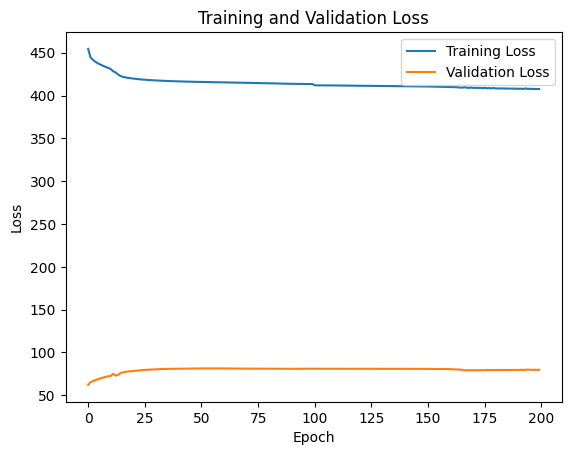

Model saved to models/trainable_gcesn_1l_proteins.pth
Average Time per Epoch: 0.17s
Average CPU Usage: 28.01%
Average Memory Usage: 4.35GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 10.30%

Total Training Time: 34.51s
Max CPU Usage: 61.15%
Max Memory Usage: 4.35GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 12.50%
Fold 3 Results:
Accuracy: 0.5553
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000
Cross-Validation Results:
accuracy: Mean = 0.5957, Std = 0.0303
sensitivity: Mean = 0.0000, Std = 0.0000
specificity: Mean = 1.0000, Std = 0.0000


In [103]:
set_seed(42)
trainable_gcesn_proteins = TrainableGCESN_1layer(proteins_num_features, 2*proteins_num_features, proteins_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_proteins.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_proteins, proteins_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_1l_proteins.pth',
                binary_classification=True, is_esn=True)

#### DND

Total number of trainable parameters: 80102


Fold 1/3
Epoch 1, Train Loss: 668.7644691467285, Val Loss: 96.36912965774536
Time: 5.76s, CPU: 79.10%, Memory: 4.36GB, GPU: 1.62GB, GPU Util: 17.50%
Epoch 2, Train Loss: 453.81888687610626, Val Loss: 124.79398000240326
Time: 2.24s, CPU: 29.05%, Memory: 4.36GB, GPU: 1.63GB, GPU Util: 40.50%
Epoch 3, Train Loss: 488.9803864955902, Val Loss: 57.22517931461334
Time: 3.94s, CPU: 34.00%, Memory: 4.36GB, GPU: 1.63GB, GPU Util: 26.00%
Epoch 4, Train Loss: 503.0941745042801, Val Loss: 98.44371354579926
Time: 2.25s, CPU: 27.20%, Memory: 4.36GB, GPU: 1.63GB, GPU Util: 28.00%
Epoch 5, Train Loss: 491.93659603595734, Val Loss: 63.569440960884094
Time: 2.25s, CPU: 29.35%, Memory: 4.36GB, GPU: 1.63GB, GPU Util: 43.00%
Epoch 6, Train Loss: 486.72525215148926, Val Loss: 69.71583425998688
Time: 3.87s, CPU: 42.30%, Memory: 4.36GB, GPU: 1.63GB, GPU Util: 46.50%
Epoch 7, Train Loss: 482.47720527648926, Val Loss: 105.06098246574402
Time: 2.33s, CPU: 26.00%, Memo

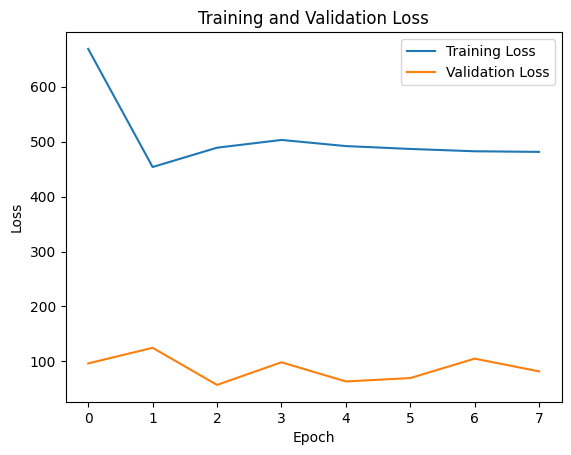

Model saved to models/trainable_gcesn_1l_dnd.pth
Average Time per Epoch: 4.21s
Average CPU Usage: 39.76%
Average Memory Usage: 4.36GB
Average GPU Usage: 1.63GB
Average GPU Utilization: 32.81%

Total Training Time: 33.66s
Max CPU Usage: 79.10%
Max Memory Usage: 4.36GB
Max GPU Usage: 1.63GB
Max GPU Utilization: 46.50%
Fold 1 Results:
Accuracy: 0.5013
Average Sensitivity (Recall): 0.4268
Average Specificity: 0.5508

Fold 2/3
Epoch 1, Train Loss: 669.9973933696747, Val Loss: 59.35417330265045
Time: 3.92s, CPU: 63.90%, Memory: 4.36GB, GPU: 1.62GB, GPU Util: 44.50%
Epoch 2, Train Loss: 456.0096755027771, Val Loss: 105.28554666042328
Time: 1.99s, CPU: 32.10%, Memory: 4.36GB, GPU: 1.63GB, GPU Util: 48.00%
Epoch 3, Train Loss: 490.1272202730179, Val Loss: 94.77547109127045
Time: 5.20s, CPU: 42.30%, Memory: 4.36GB, GPU: 1.63GB, GPU Util: 46.00%
Epoch 4, Train Loss: 499.5807989835739, Val Loss: 58.878870606422424
Time: 2.43s, CPU: 43.10%, Memory: 4.36GB, GPU: 1.63GB, GPU Util: 46.00%
Epoch 5, Tra

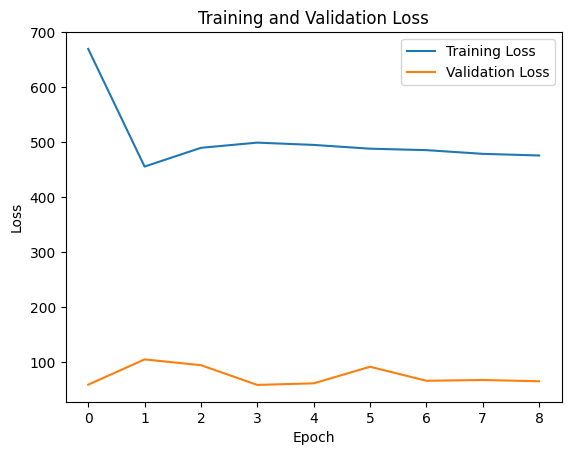

Model saved to models/trainable_gcesn_1l_dnd.pth
Average Time per Epoch: 4.22s
Average CPU Usage: 40.03%
Average Memory Usage: 4.36GB
Average GPU Usage: 1.63GB
Average GPU Utilization: 43.06%

Total Training Time: 38.01s
Max CPU Usage: 63.90%
Max Memory Usage: 4.36GB
Max GPU Usage: 1.63GB
Max GPU Utilization: 48.00%
Fold 2 Results:
Accuracy: 0.4860
Average Sensitivity (Recall): 0.3553
Average Specificity: 0.5685

Fold 3/3
Epoch 1, Train Loss: 652.2147613763809, Val Loss: 131.6948240995407
Time: 2.12s, CPU: 32.35%, Memory: 4.36GB, GPU: 1.62GB, GPU Util: 63.00%
Epoch 2, Train Loss: 438.68457543849945, Val Loss: 173.14826726913452
Time: 3.76s, CPU: 41.50%, Memory: 4.36GB, GPU: 1.64GB, GPU Util: 41.00%
Epoch 3, Train Loss: 469.5963084101677, Val Loss: 99.27601659297943
Time: 2.10s, CPU: 31.85%, Memory: 4.36GB, GPU: 1.64GB, GPU Util: 36.00%
Epoch 4, Train Loss: 479.99238485097885, Val Loss: 81.10506653785706
Time: 2.14s, CPU: 30.50%, Memory: 4.36GB, GPU: 1.64GB, GPU Util: 27.00%
Epoch 5, Tr

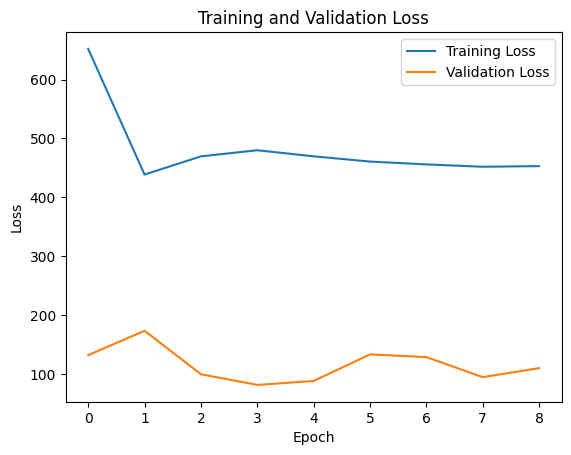

Model saved to models/trainable_gcesn_1l_dnd.pth
Average Time per Epoch: 2.75s
Average CPU Usage: 35.83%
Average Memory Usage: 4.36GB
Average GPU Usage: 1.64GB
Average GPU Utilization: 33.39%

Total Training Time: 24.79s
Max CPU Usage: 44.05%
Max Memory Usage: 4.36GB
Max GPU Usage: 1.64GB
Max GPU Utilization: 63.00%
Fold 3 Results:
Accuracy: 0.5434
Average Sensitivity (Recall): 0.0955
Average Specificity: 0.9159
Cross-Validation Results:
accuracy: Mean = 0.5102, Std = 0.0243
sensitivity: Mean = 0.2925, Std = 0.1423
specificity: Mean = 0.6784, Std = 0.1681


In [117]:
set_seed(42)
trainable_gcesn_dnd = TrainableGCESN_1layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_dnd.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_dnd, dd_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_1l_dnd.pth',
                binary_classification=True, is_esn=True)

#### ENZYM

Total number of trainable parameters: 150


Fold 1/3
Epoch 1, Train Loss: 656.0561351776123, Val Loss: 82.81931114196777
Time: 0.14s, CPU: 29.50%, Memory: 4.36GB, GPU: 1.62GB, GPU Util: 50.00%
Epoch 2, Train Loss: 652.5835342407227, Val Loss: 81.60482406616211
Time: 0.10s, CPU: 34.75%, Memory: 4.36GB, GPU: 1.62GB, GPU Util: 13.50%
Epoch 3, Train Loss: 651.6156711578369, Val Loss: 81.2413444519043
Time: 0.09s, CPU: 24.85%, Memory: 4.36GB, GPU: 1.62GB, GPU Util: 7.00%
Epoch 4, Train Loss: 650.9158630371094, Val Loss: 80.99083709716797
Time: 0.09s, CPU: 28.80%, Memory: 4.36GB, GPU: 1.62GB, GPU Util: 8.00%
Epoch 5, Train Loss: 650.3455581665039, Val Loss: 80.80002975463867
Time: 0.09s, CPU: 20.10%, Memory: 4.36GB, GPU: 1.62GB, GPU Util: 7.50%
Epoch 6, Train Loss: 649.8302955627441, Val Loss: 80.64299774169922
Time: 0.09s, CPU: 28.50%, Memory: 4.36GB, GPU: 1.62GB, GPU Util: 8.00%
Epoch 7, Train Loss: 649.3525390625, Val Loss: 80.54664611816406
Time: 0.09s, CPU: 21.25%, Memory: 4.36GB, GPU: 

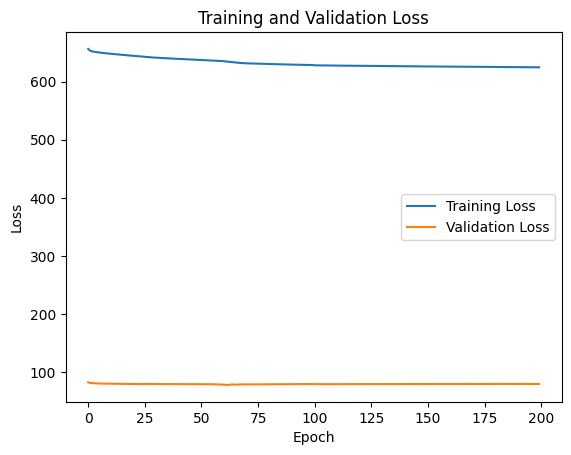

Model saved to models/trainable_gcesn_1l_enzymes.pth
Average Time per Epoch: 0.09s
Average CPU Usage: 23.51%
Average Memory Usage: 4.36GB
Average GPU Usage: 1.62GB
Average GPU Utilization: 8.88%

Total Training Time: 18.17s
Max CPU Usage: 59.40%
Max Memory Usage: 4.36GB
Max GPU Usage: 1.62GB
Max GPU Utilization: 50.00%
Fold 1 Results:
Accuracy: 0.1650
Average Sensitivity (Recall): 0.1899
Average Specificity: 0.8375

Fold 2/3
Epoch 1, Train Loss: 660.5606994628906, Val Loss: 86.96510887145996
Time: 0.09s, CPU: 30.10%, Memory: 4.36GB, GPU: 1.62GB, GPU Util: 2.00%
Epoch 2, Train Loss: 657.0380744934082, Val Loss: 85.08306503295898
Time: 0.09s, CPU: 20.75%, Memory: 4.36GB, GPU: 1.62GB, GPU Util: 3.00%
Epoch 3, Train Loss: 656.0158634185791, Val Loss: 84.61966705322266
Time: 0.09s, CPU: 38.90%, Memory: 4.36GB, GPU: 1.62GB, GPU Util: 6.00%
Epoch 4, Train Loss: 655.252631187439, Val Loss: 84.47076416015625
Time: 0.11s, CPU: 49.60%, Memory: 4.36GB, GPU: 1.62GB, GPU Util: 8.50%
Epoch 5, Train L

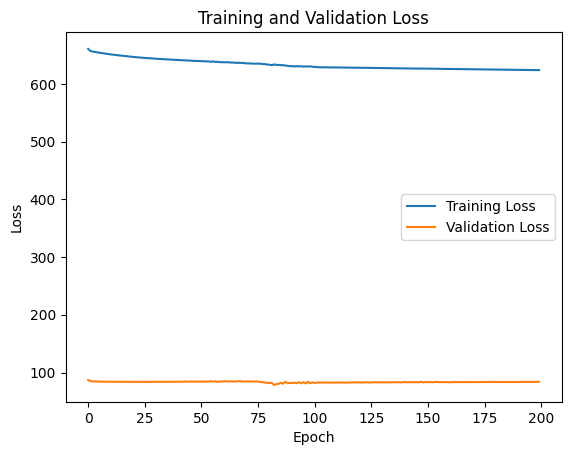

Model saved to models/trainable_gcesn_1l_enzymes.pth
Average Time per Epoch: 0.10s
Average CPU Usage: 30.02%
Average Memory Usage: 4.36GB
Average GPU Usage: 1.62GB
Average GPU Utilization: 7.95%

Total Training Time: 19.52s
Max CPU Usage: 61.90%
Max Memory Usage: 4.36GB
Max GPU Usage: 1.62GB
Max GPU Utilization: 10.00%
Fold 2 Results:
Accuracy: 0.1650
Average Sensitivity (Recall): 0.1691
Average Specificity: 0.8341

Fold 3/3
Epoch 1, Train Loss: 657.4256830215454, Val Loss: 85.23139762878418
Time: 0.09s, CPU: 33.05%, Memory: 4.36GB, GPU: 1.62GB, GPU Util: 0.00%
Epoch 2, Train Loss: 654.1805410385132, Val Loss: 83.28480911254883
Time: 0.09s, CPU: 23.70%, Memory: 4.36GB, GPU: 1.62GB, GPU Util: 7.00%
Epoch 3, Train Loss: 653.3421878814697, Val Loss: 82.66862678527832
Time: 0.09s, CPU: 27.60%, Memory: 4.36GB, GPU: 1.62GB, GPU Util: 8.00%
Epoch 4, Train Loss: 652.6980247497559, Val Loss: 82.37283897399902
Time: 0.09s, CPU: 16.30%, Memory: 4.36GB, GPU: 1.62GB, GPU Util: 9.00%
Epoch 5, Train 

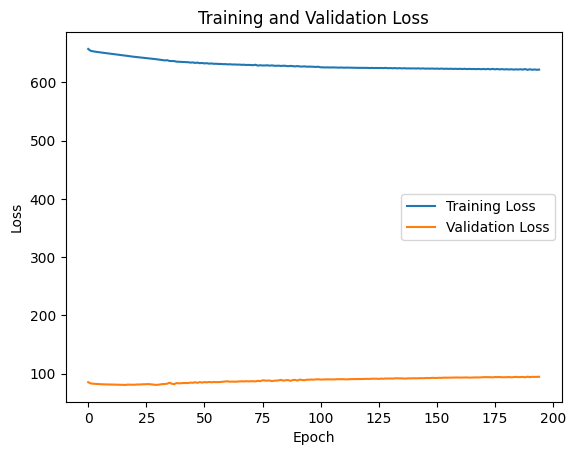

Model saved to models/trainable_gcesn_1l_enzymes.pth
Average Time per Epoch: 0.09s
Average CPU Usage: 20.65%
Average Memory Usage: 4.36GB
Average GPU Usage: 0.74GB
Average GPU Utilization: 8.77%

Total Training Time: 18.42s
Max CPU Usage: 61.75%
Max Memory Usage: 4.36GB
Max GPU Usage: 1.62GB
Max GPU Utilization: 11.00%
Fold 3 Results:
Accuracy: 0.1800
Average Sensitivity (Recall): 0.1821
Average Specificity: 0.8376
Cross-Validation Results:
accuracy: Mean = 0.1700, Std = 0.0071
sensitivity: Mean = 0.1804, Std = 0.0086
specificity: Mean = 0.8364, Std = 0.0016


In [118]:
set_seed(42)
trainable_gcesn_enzymes = TrainableGCESN_1layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_enzymes.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_enzymes, enzymes_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_1l_enzymes.pth',
                binary_classification=False, is_esn=True)

#### OASIS

Total number of trainable parameters: 739


Fold 1/3
Epoch 1, Train Loss: 228.7108360528946, Val Loss: 25.148293256759644
Time: 0.06s, CPU: 16.10%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 2, Train Loss: 224.34266448020935, Val Loss: 24.4963036775589
Time: 0.06s, CPU: 13.25%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 3, Train Loss: 221.46547853946686, Val Loss: 24.8974392414093
Time: 0.06s, CPU: 17.70%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 4.50%
Epoch 4, Train Loss: 220.068918466568, Val Loss: 25.300450205802917
Time: 0.06s, CPU: 14.05%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 5, Train Loss: 218.74513041973114, Val Loss: 25.713501691818237
Time: 0.05s, CPU: 7.30%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 8.50%
Epoch 6, Train Loss: 217.58175641298294, Val Loss: 26.018876671791077
Time: 0.06s, CPU: 14.10%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 9.00%
Epoch 7, Train Loss: 216.63454854488373, Val Loss: 26.01217293739319
Time: 0.06s, CPU: 6.65%, Memory: 4.36GB,

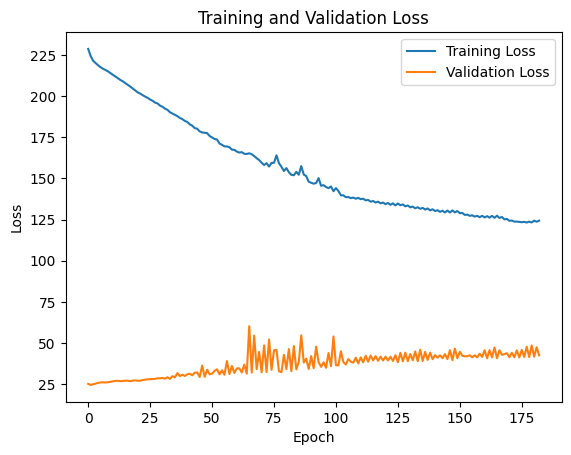

Model saved to models/trainable_gcesn_1l_oasis.pth
Average Time per Epoch: 0.06s
Average CPU Usage: 24.65%
Average Memory Usage: 4.36GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 8.48%

Total Training Time: 10.93s
Max CPU Usage: 59.90%
Max Memory Usage: 4.36GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 11.00%
Fold 1 Results:
Accuracy: 0.3772
Average Sensitivity (Recall): 0.3668
Average Specificity: 0.6803

Fold 2/3
Epoch 1, Train Loss: 239.18747580051422, Val Loss: 28.937394738197327
Time: 0.07s, CPU: 53.60%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 232.51210033893585, Val Loss: 25.75087261199951
Time: 0.06s, CPU: 48.20%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 2.50%
Epoch 3, Train Loss: 227.70728588104248, Val Loss: 25.3719265460968
Time: 0.06s, CPU: 50.50%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 5.00%
Epoch 4, Train Loss: 225.20879888534546, Val Loss: 25.38532030582428
Time: 0.06s, CPU: 51.15%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 6.50%
Epoch 5, Trai

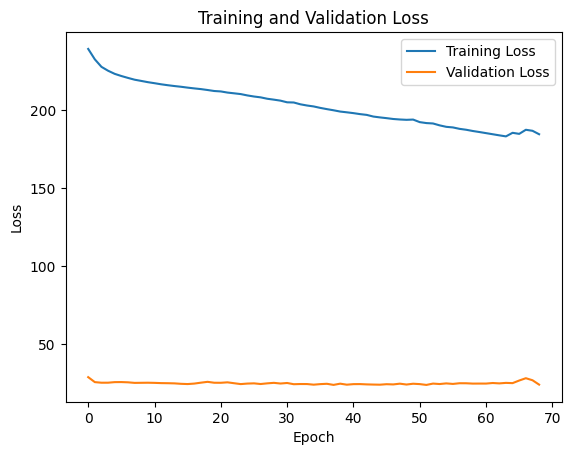

Model saved to models/trainable_gcesn_1l_oasis.pth
Average Time per Epoch: 0.06s
Average CPU Usage: 33.37%
Average Memory Usage: 4.36GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 7.45%

Total Training Time: 4.46s
Max CPU Usage: 67.80%
Max Memory Usage: 4.36GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 9.00%
Fold 2 Results:
Accuracy: 0.2982
Average Sensitivity (Recall): 0.3334
Average Specificity: 0.6632

Fold 3/3
Epoch 1, Train Loss: 234.39555048942566, Val Loss: 29.825747847557068
Time: 0.08s, CPU: 47.10%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 228.14227640628815, Val Loss: 26.988615036010742
Time: 0.06s, CPU: 53.95%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 3.50%
Epoch 3, Train Loss: 225.11729681491852, Val Loss: 26.405705451965332
Time: 0.06s, CPU: 42.00%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 4, Train Loss: 222.93834614753723, Val Loss: 25.86739420890808
Time: 0.05s, CPU: 38.25%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 5, Tra

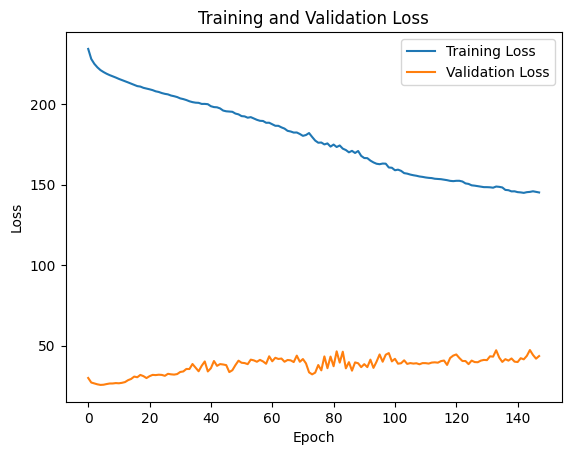

Model saved to models/trainable_gcesn_1l_oasis.pth
Average Time per Epoch: 0.06s
Average CPU Usage: 31.77%
Average Memory Usage: 4.36GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 8.17%

Total Training Time: 9.07s
Max CPU Usage: 78.20%
Max Memory Usage: 4.36GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 10.00%
Fold 3 Results:
Accuracy: 0.3158
Average Sensitivity (Recall): 0.3169
Average Specificity: 0.6597
Cross-Validation Results:
accuracy: Mean = 0.3304, Std = 0.0338
sensitivity: Mean = 0.3390, Std = 0.0208
specificity: Mean = 0.6677, Std = 0.0090


In [119]:
set_seed(42)
trainable_gcesn_oasis = TrainableGCESN_1layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_oasis.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_oasis, oasis_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_1l_oasis.pth',
                binary_classification=False, is_esn=True)

#### EMCI-AD

Total number of trainable parameters: 722


Fold 1/3
Epoch 1, Train Loss: 56.211265563964844, Val Loss: 11.85933780670166
Time: 0.03s, CPU: 27.60%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 2, Train Loss: 55.629638671875, Val Loss: 8.872948586940765
Time: 0.03s, CPU: 29.15%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 3, Train Loss: 55.42778015136719, Val Loss: 7.573291718959808
Time: 0.03s, CPU: 26.80%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 4, Train Loss: 55.16000556945801, Val Loss: 6.923165023326874
Time: 0.02s, CPU: 21.50%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 5, Train Loss: 54.90090751647949, Val Loss: 6.591013669967651
Time: 0.02s, CPU: 19.65%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 6, Train Loss: 54.653167724609375, Val Loss: 6.363678753376007
Time: 0.02s, CPU: 28.20%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 7, Train Loss: 54.402618408203125, Val Loss: 6.199363946914673
Time: 0.03s, CPU: 22.95%, Memory: 4.36GB, GP

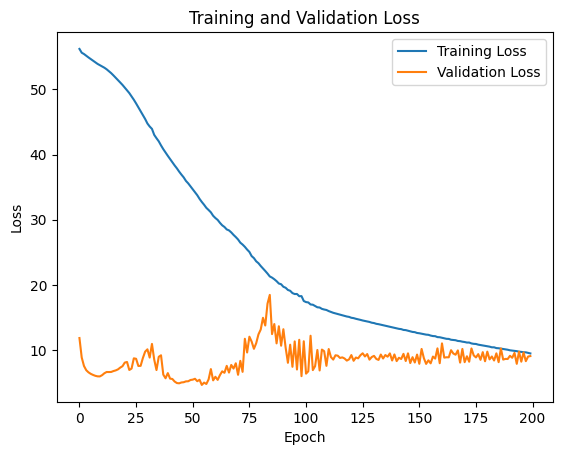

Model saved to models/trainable_gcesn_1l_emci.pth
Average Time per Epoch: 0.03s
Average CPU Usage: 29.40%
Average Memory Usage: 4.36GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 6.41%

Total Training Time: 5.49s
Max CPU Usage: 65.60%
Max Memory Usage: 4.36GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 8.00%
Fold 1 Results:
Accuracy: 0.5111
Average Sensitivity (Recall): 0.5158
Average Specificity: 0.5158

Fold 2/3
Epoch 1, Train Loss: 55.928117752075195, Val Loss: 11.026611685752869
Time: 0.03s, CPU: 35.55%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 2, Train Loss: 55.44180202484131, Val Loss: 7.810500919818878
Time: 0.02s, CPU: 27.20%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 2.50%
Epoch 3, Train Loss: 55.11453628540039, Val Loss: 6.776364505290985
Time: 0.03s, CPU: 29.15%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 4, Train Loss: 54.8189172744751, Val Loss: 6.444984018802643
Time: 0.03s, CPU: 22.75%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 5, Train Loss

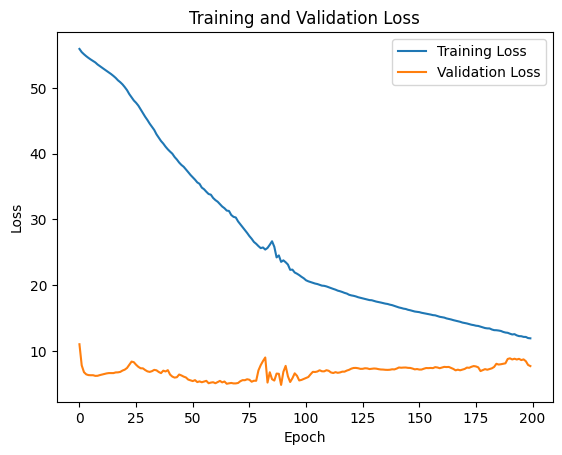

Model saved to models/trainable_gcesn_1l_emci.pth
Average Time per Epoch: 0.03s
Average CPU Usage: 29.66%
Average Memory Usage: 4.36GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 6.26%

Total Training Time: 5.43s
Max CPU Usage: 57.15%
Max Memory Usage: 4.36GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 8.00%
Fold 2 Results:
Accuracy: 0.5333
Average Sensitivity (Recall): 0.5300
Average Specificity: 0.5300

Fold 3/3
Epoch 1, Train Loss: 56.71542191505432, Val Loss: 9.340780019760132
Time: 0.03s, CPU: 31.95%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 2, Train Loss: 56.09834688901901, Val Loss: 7.258699178695679
Time: 0.03s, CPU: 21.45%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 3, Train Loss: 55.615131199359894, Val Loss: 6.626763224601746
Time: 0.03s, CPU: 22.65%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 4, Train Loss: 55.17631196975708, Val Loss: 6.42591404914856
Time: 0.03s, CPU: 23.35%, Memory: 4.36GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 5, Train Loss:

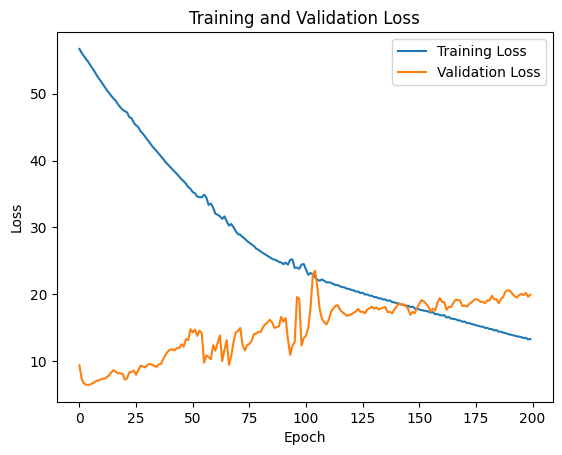

Model saved to models/trainable_gcesn_1l_emci.pth
Average Time per Epoch: 0.03s
Average CPU Usage: 26.60%
Average Memory Usage: 4.36GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 6.58%

Total Training Time: 5.41s
Max CPU Usage: 60.15%
Max Memory Usage: 4.36GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 8.00%
Fold 3 Results:
Accuracy: 0.4091
Average Sensitivity (Recall): 0.4295
Average Specificity: 0.4295
Cross-Validation Results:
accuracy: Mean = 0.4845, Std = 0.0541
sensitivity: Mean = 0.4918, Std = 0.0444
specificity: Mean = 0.4918, Std = 0.0444


In [120]:
set_seed(42)
trainable_gcesn_emci = TrainableGCESN_1layer(emci_num_features, 2*emci_num_features, emci_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_emci.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_emci, emci_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_1l_emci.pth',
                binary_classification=False, is_esn=True)

### Trainable GCESN 2-Layer

#### MUTAG

Total number of trainable parameters: 1962


Fold 1/3
Epoch 1, Train Loss: 64.33812856674194, Val Loss: 8.632077932357788
Time: 0.04s, CPU: 21.90%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 0.50%
Epoch 2, Train Loss: 60.46883535385132, Val Loss: 8.566667318344116
Time: 0.04s, CPU: 22.90%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 1.00%
Epoch 3, Train Loss: 58.26170349121094, Val Loss: 8.499911546707153
Time: 0.04s, CPU: 24.00%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 1.00%
Epoch 4, Train Loss: 56.8096981048584, Val Loss: 8.442135632038116
Time: 0.04s, CPU: 23.20%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 4.00%
Epoch 5, Train Loss: 55.03613901138306, Val Loss: 8.37681257724762
Time: 0.04s, CPU: 26.00%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 7.00%
Epoch 6, Train Loss: 53.98533773422241, Val Loss: 8.314735412597656
Time: 0.05s, CPU: 26.15%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 7.00%
Epoch 7, Train Loss: 53.01103162765503, Val Loss: 8.260855495929718
Time: 0.05s, CPU: 27.05%, Memory: 3.65GB, GPU:

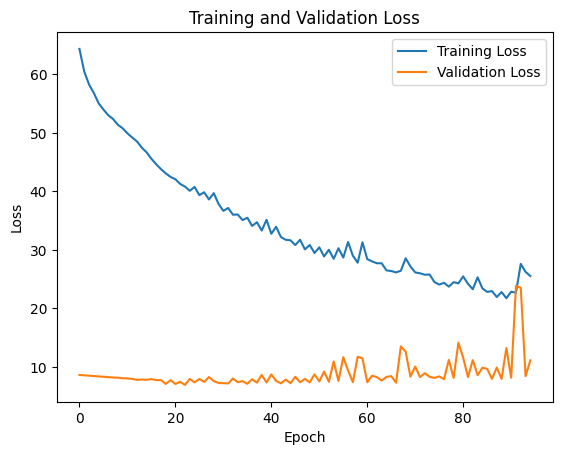

Model saved to models/trainable_gcesn_2l_mutag.pth
Average Time per Epoch: 0.05s
Average CPU Usage: 27.42%
Average Memory Usage: 3.65GB
Average GPU Usage: 0.52GB
Average GPU Utilization: 5.86%

Total Training Time: 4.49s
Max CPU Usage: 68.55%
Max Memory Usage: 3.65GB
Max GPU Usage: 0.52GB
Max GPU Utilization: 7.00%
Fold 1 Results:
Accuracy: 0.7460
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.2727

Fold 2/3
Epoch 1, Train Loss: 61.52082633972168, Val Loss: 8.99747496843338
Time: 0.04s, CPU: 34.05%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 0.00%
Epoch 2, Train Loss: 56.7334361076355, Val Loss: 8.964486837387085
Time: 0.05s, CPU: 21.85%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 0.00%
Epoch 3, Train Loss: 53.95488262176514, Val Loss: 8.950059711933136
Time: 0.04s, CPU: 22.80%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 2.50%
Epoch 4, Train Loss: 51.80672883987427, Val Loss: 8.910997450351715
Time: 0.05s, CPU: 24.25%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 5.00%
Epoch 5, Train Loss: 

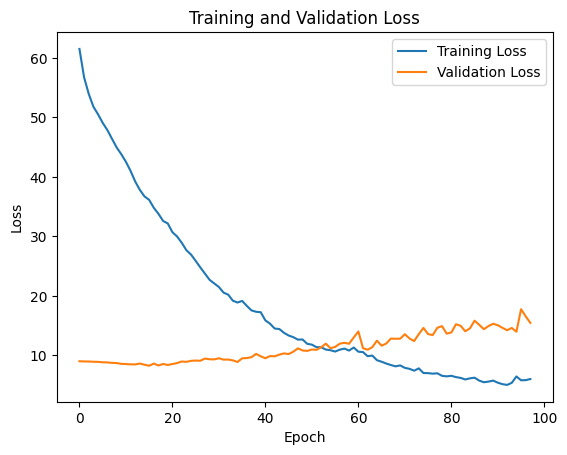

Model saved to models/trainable_gcesn_2l_mutag.pth
Average Time per Epoch: 0.04s
Average CPU Usage: 15.53%
Average Memory Usage: 3.65GB
Average GPU Usage: 0.52GB
Average GPU Utilization: 5.33%

Total Training Time: 4.30s
Max CPU Usage: 42.10%
Max Memory Usage: 3.65GB
Max GPU Usage: 0.52GB
Max GPU Utilization: 7.00%
Fold 2 Results:
Accuracy: 0.8254
Average Sensitivity (Recall): 0.8095
Average Specificity: 0.8571

Fold 3/3
Epoch 1, Train Loss: 64.83442640304565, Val Loss: 8.228172659873962
Time: 0.05s, CPU: 35.35%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 0.00%
Epoch 2, Train Loss: 61.032084941864014, Val Loss: 8.050983786582947
Time: 0.05s, CPU: 22.25%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 0.00%
Epoch 3, Train Loss: 58.93030649423599, Val Loss: 7.914871037006378
Time: 0.04s, CPU: 20.10%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 2.50%
Epoch 4, Train Loss: 57.11221933364868, Val Loss: 7.8464725613594055
Time: 0.04s, CPU: 21.60%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 5.00%
Epoch 5, Train Lo

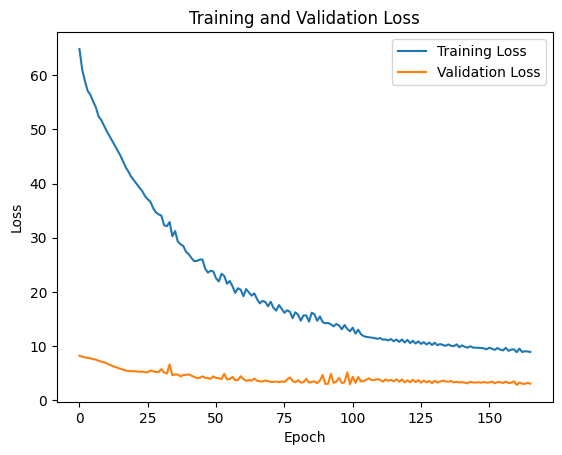

Model saved to models/trainable_gcesn_2l_mutag.pth
Average Time per Epoch: 0.05s
Average CPU Usage: 17.83%
Average Memory Usage: 3.65GB
Average GPU Usage: 0.52GB
Average GPU Utilization: 5.80%

Total Training Time: 7.56s
Max CPU Usage: 61.25%
Max Memory Usage: 3.65GB
Max GPU Usage: 0.52GB
Max GPU Utilization: 8.00%
Fold 3 Results:
Accuracy: 0.8548
Average Sensitivity (Recall): 0.9048
Average Specificity: 0.7500
Cross-Validation Results:
accuracy: Mean = 0.8088, Std = 0.0460
sensitivity: Mean = 0.9048, Std = 0.0778
specificity: Mean = 0.6266, Std = 0.2540


In [35]:
set_seed(42)
trainable_gcesn_mutag_2 = TrainableGCESN_2layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_mutag_2.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_mutag_2, mutag_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_2l_mutag.pth',
                binary_classification=True, is_esn=True)

#### PROTEINS

Total number of trainable parameters: 386


Fold 1/3
Epoch 1, Train Loss: 504.83214396238327, Val Loss: 43.54275918006897
Time: 0.26s, CPU: 30.10%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 7.00%
Epoch 2, Train Loss: 491.8857843875885, Val Loss: 44.980816423892975
Time: 0.23s, CPU: 26.50%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 13.50%
Epoch 3, Train Loss: 484.4083403348923, Val Loss: 46.66912931203842
Time: 0.25s, CPU: 25.15%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 13.00%
Epoch 4, Train Loss: 479.1285967230797, Val Loss: 48.168483912944794
Time: 0.22s, CPU: 25.15%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 14.50%
Epoch 5, Train Loss: 474.53625267744064, Val Loss: 49.70801800489426
Time: 0.25s, CPU: 26.60%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 13.00%
Epoch 6, Train Loss: 470.04669588804245, Val Loss: 50.97791737318039
Time: 0.23s, CPU: 24.00%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 14.00%
Epoch 7, Train Loss: 466.4430814385414, Val Loss: 52.26783174276352
Time: 0.28s, CPU: 42.15%, Memory: 3

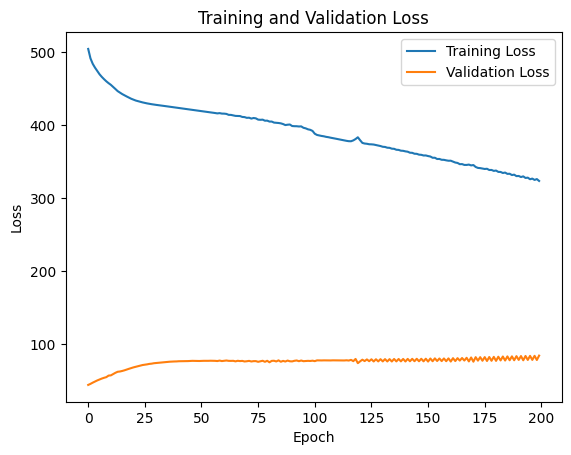

Model saved to models/trainable_gcesn_2l_proteins.pth
Average Time per Epoch: 0.22s
Average CPU Usage: 23.08%
Average Memory Usage: 3.65GB
Average GPU Usage: 0.52GB
Average GPU Utilization: 14.23%

Total Training Time: 43.97s
Max CPU Usage: 49.20%
Max Memory Usage: 3.65GB
Max GPU Usage: 0.52GB
Max GPU Utilization: 17.00%
Fold 1 Results:
Accuracy: 0.6280
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Fold 2/3
Epoch 1, Train Loss: 506.5169933438301, Val Loss: 45.17732346057892
Time: 0.22s, CPU: 31.10%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 10.00%
Epoch 2, Train Loss: 492.5141673088074, Val Loss: 46.73294144868851
Time: 0.21s, CPU: 21.35%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 15.00%
Epoch 3, Train Loss: 485.14240658283234, Val Loss: 47.88511377573013
Time: 0.20s, CPU: 26.55%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 15.50%
Epoch 4, Train Loss: 479.0511317253113, Val Loss: 48.95386791229248
Time: 0.25s, CPU: 30.25%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 16.00%
Epoch 5,

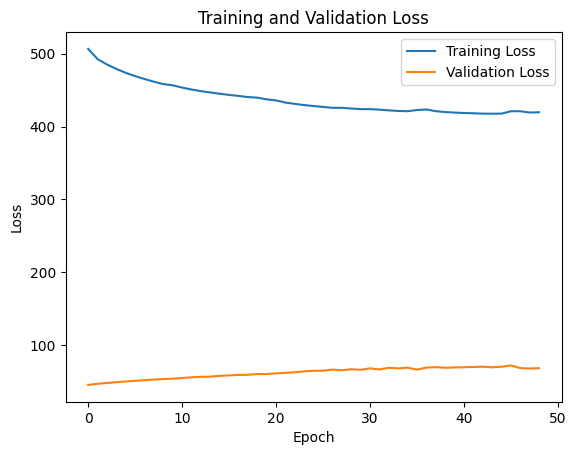

Model saved to models/trainable_gcesn_2l_proteins.pth
Average Time per Epoch: 0.21s
Average CPU Usage: 20.76%
Average Memory Usage: 3.65GB
Average GPU Usage: 0.52GB
Average GPU Utilization: 14.84%

Total Training Time: 10.50s
Max CPU Usage: 33.55%
Max Memory Usage: 3.65GB
Max GPU Usage: 0.52GB
Max GPU Utilization: 17.50%
Fold 2 Results:
Accuracy: 0.6038
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Fold 3/3
Epoch 1, Train Loss: 510.1574607491493, Val Loss: 45.18781387805939
Time: 0.19s, CPU: 21.60%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 12.00%
Epoch 2, Train Loss: 494.9120868444443, Val Loss: 46.88043224811554
Time: 0.19s, CPU: 9.70%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 17.00%
Epoch 3, Train Loss: 486.3537406921387, Val Loss: 48.17100363969803
Time: 0.21s, CPU: 10.20%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 15.00%
Epoch 4, Train Loss: 479.1365177035332, Val Loss: 49.36870980262756
Time: 0.20s, CPU: 10.50%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 14.50%
Epoch 5, T

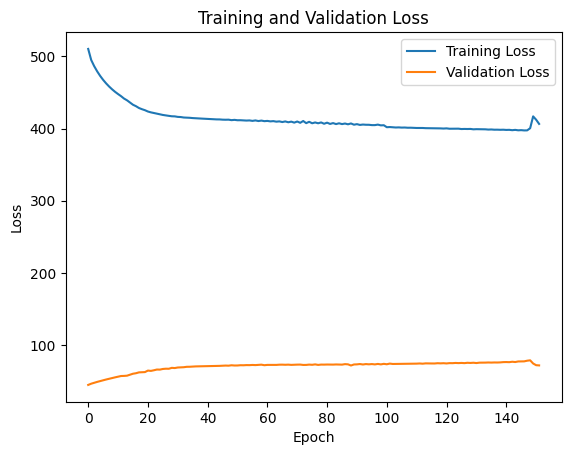

Model saved to models/trainable_gcesn_2l_proteins.pth
Average Time per Epoch: 0.21s
Average CPU Usage: 18.14%
Average Memory Usage: 3.65GB
Average GPU Usage: 0.52GB
Average GPU Utilization: 14.85%

Total Training Time: 31.58s
Max CPU Usage: 49.00%
Max Memory Usage: 3.65GB
Max GPU Usage: 0.52GB
Max GPU Utilization: 18.00%
Fold 3 Results:
Accuracy: 0.5553
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000
Cross-Validation Results:
accuracy: Mean = 0.5957, Std = 0.0303
sensitivity: Mean = 0.0000, Std = 0.0000
specificity: Mean = 1.0000, Std = 0.0000


In [36]:
set_seed(42)
trainable_gcesn_proteins_2 = TrainableGCESN_2layer(proteins_num_features, 2*proteins_num_features, proteins_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_proteins_2.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_proteins_2, proteins_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_2l_proteins.pth',
                binary_classification=True, is_esn=True)

#### DND

Total number of trainable parameters: 302246


Fold 1/3
Epoch 1, Train Loss: 633.429281949997, Val Loss: 109.12401878833771
Time: 14.18s, CPU: 75.15%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 0.00%
Epoch 2, Train Loss: 461.9755172729492, Val Loss: 74.52523112297058
Time: 15.66s, CPU: 48.10%, Memory: 3.66GB, GPU: 0.53GB, GPU Util: 12.00%
Epoch 3, Train Loss: 489.9873414039612, Val Loss: 73.93480902910233
Time: 8.17s, CPU: 32.95%, Memory: 3.66GB, GPU: 0.53GB, GPU Util: 12.00%
Epoch 4, Train Loss: 494.3309142589569, Val Loss: 78.4783308506012
Time: 14.05s, CPU: 48.00%, Memory: 3.66GB, GPU: 0.53GB, GPU Util: 11.50%
Epoch 5, Train Loss: 510.56872606277466, Val Loss: 67.26024627685547
Time: 8.26s, CPU: 34.45%, Memory: 3.66GB, GPU: 0.53GB, GPU Util: 1.50%
Epoch 6, Train Loss: 504.83534955978394, Val Loss: 62.98916840553284
Time: 7.83s, CPU: 39.40%, Memory: 3.66GB, GPU: 0.53GB, GPU Util: 2.00%
Epoch 7, Train Loss: 510.31864297389984, Val Loss: 67.31915336847305
Time: 19.29s, CPU: 52.40%, Memory:

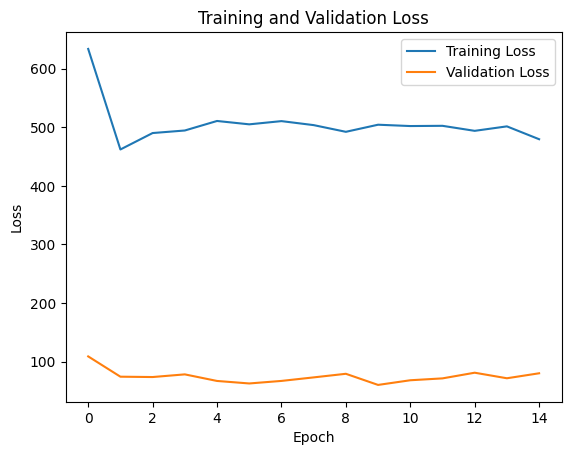

Model saved to models/trainable_gcesn_2l_dnd.pth
Average Time per Epoch: 13.41s
Average CPU Usage: 45.24%
Average Memory Usage: 3.66GB
Average GPU Usage: 0.53GB
Average GPU Utilization: 7.13%

Total Training Time: 201.10s
Max CPU Usage: 75.15%
Max Memory Usage: 3.66GB
Max GPU Usage: 0.53GB
Max GPU Utilization: 18.50%
Fold 1 Results:
Accuracy: 0.5064
Average Sensitivity (Recall): 0.3439
Average Specificity: 0.6144

Fold 2/3
Epoch 1, Train Loss: 646.6512870788574, Val Loss: 157.65370631217957
Time: 20.66s, CPU: 59.30%, Memory: 3.66GB, GPU: 0.52GB, GPU Util: 33.00%
Epoch 2, Train Loss: 458.6989769935608, Val Loss: 77.33142471313477
Time: 14.09s, CPU: 53.45%, Memory: 3.66GB, GPU: 0.53GB, GPU Util: 17.50%
Epoch 3, Train Loss: 491.18009066581726, Val Loss: 72.82784527540207
Time: 9.81s, CPU: 39.85%, Memory: 3.66GB, GPU: 0.53GB, GPU Util: 19.50%
Epoch 4, Train Loss: 501.2888867855072, Val Loss: 78.81069284677505
Time: 7.61s, CPU: 36.15%, Memory: 3.66GB, GPU: 0.53GB, GPU Util: 13.50%
Epoch 5, 

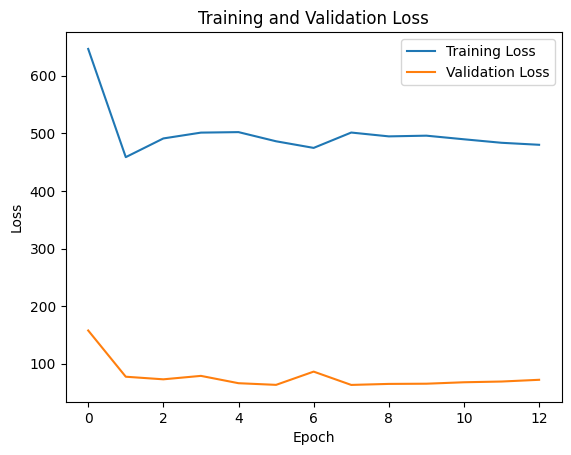

Model saved to models/trainable_gcesn_2l_dnd.pth
Average Time per Epoch: 11.96s
Average CPU Usage: 42.21%
Average Memory Usage: 3.66GB
Average GPU Usage: 0.53GB
Average GPU Utilization: 16.23%

Total Training Time: 155.44s
Max CPU Usage: 59.30%
Max Memory Usage: 3.66GB
Max GPU Usage: 0.53GB
Max GPU Utilization: 33.00%
Fold 2 Results:
Accuracy: 0.6132
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Fold 3/3
Epoch 1, Train Loss: 607.6629176139832, Val Loss: 113.9909998178482
Time: 7.59s, CPU: 52.30%, Memory: 3.66GB, GPU: 0.52GB, GPU Util: 40.00%
Epoch 2, Train Loss: 446.42438983917236, Val Loss: 76.87615597248077
Time: 8.30s, CPU: 63.30%, Memory: 3.66GB, GPU: 0.54GB, GPU Util: 0.00%
Epoch 3, Train Loss: 472.43271601200104, Val Loss: 73.67634230852127
Time: 7.70s, CPU: 35.45%, Memory: 3.66GB, GPU: 0.54GB, GPU Util: 6.50%
Epoch 4, Train Loss: 479.68540704250336, Val Loss: 77.03026926517487
Time: 9.16s, CPU: 38.65%, Memory: 3.66GB, GPU: 0.54GB, GPU Util: 4.00%
Epoch 5, Tra

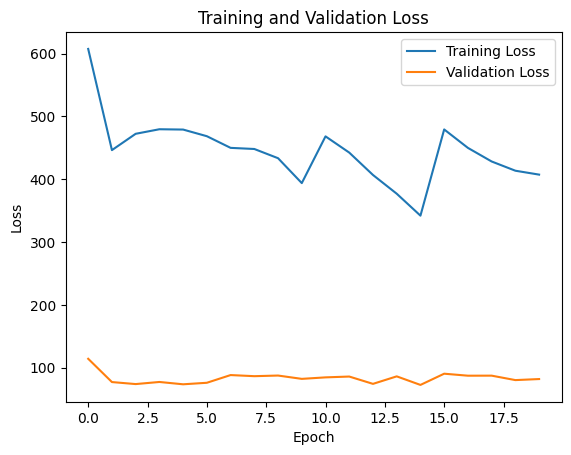

Model saved to models/trainable_gcesn_2l_dnd.pth
Average Time per Epoch: 15.41s
Average CPU Usage: 46.05%
Average Memory Usage: 3.66GB
Average GPU Usage: 0.54GB
Average GPU Utilization: 11.03%

Total Training Time: 308.29s
Max CPU Usage: 63.30%
Max Memory Usage: 3.66GB
Max GPU Usage: 0.54GB
Max GPU Utilization: 40.00%
Fold 3 Results:
Accuracy: 0.5510
Average Sensitivity (Recall): 0.0112
Average Specificity: 1.0000
Cross-Validation Results:
accuracy: Mean = 0.5569, Std = 0.0438
sensitivity: Mean = 0.1184, Std = 0.1596
specificity: Mean = 0.8715, Std = 0.1818


In [38]:
set_seed(42)
trainable_gcesn_dnd_2 = TrainableGCESN_2layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_dnd_2.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_dnd_2, dd_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_2l_dnd.pth',
                binary_classification=True, is_esn=True)

#### ENZYM

Total number of trainable parameters: 414


Fold 1/3
Epoch 1, Train Loss: 673.730170249939, Val Loss: 68.13446617126465
Time: 0.12s, CPU: 43.05%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 4.00%
Epoch 2, Train Loss: 667.7873258590698, Val Loss: 73.05511093139648
Time: 0.11s, CPU: 41.05%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 9.00%
Epoch 3, Train Loss: 666.0043458938599, Val Loss: 74.53356647491455
Time: 0.13s, CPU: 38.45%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 10.00%
Epoch 4, Train Loss: 664.5088376998901, Val Loss: 75.18704891204834
Time: 0.16s, CPU: 44.30%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 9.50%
Epoch 5, Train Loss: 663.074104309082, Val Loss: 75.67771434783936
Time: 0.13s, CPU: 48.15%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 8.00%
Epoch 6, Train Loss: 661.6038770675659, Val Loss: 76.36245155334473
Time: 0.14s, CPU: 34.10%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 9.00%
Epoch 7, Train Loss: 660.0752449035645, Val Loss: 77.08484745025635
Time: 0.12s, CPU: 36.10%, Memory: 3.65GB, GPU:

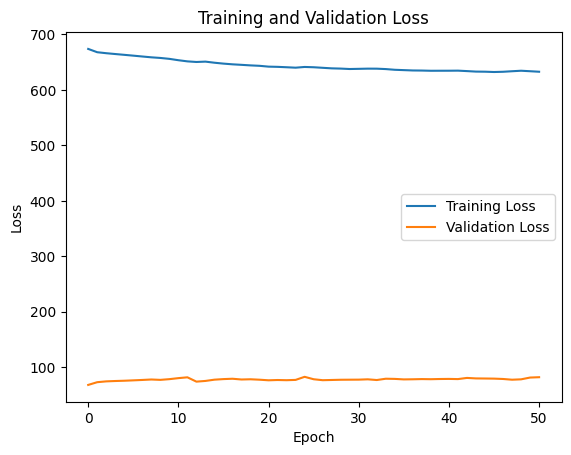

Model saved to models/trainable_gcesn_2l_enzymes.pth
Average Time per Epoch: 0.13s
Average CPU Usage: 30.41%
Average Memory Usage: 3.65GB
Average GPU Usage: 0.52GB
Average GPU Utilization: 9.74%

Total Training Time: 6.60s
Max CPU Usage: 50.80%
Max Memory Usage: 3.65GB
Max GPU Usage: 0.52GB
Max GPU Utilization: 11.50%
Fold 1 Results:
Accuracy: 0.1100
Average Sensitivity (Recall): 0.1084
Average Specificity: 0.8228

Fold 2/3
Epoch 1, Train Loss: 671.6345491409302, Val Loss: 70.6545000076294
Time: 0.13s, CPU: 30.80%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 3.50%
Epoch 2, Train Loss: 667.2613649368286, Val Loss: 73.39225959777832
Time: 0.12s, CPU: 19.55%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 6.50%
Epoch 3, Train Loss: 665.5977210998535, Val Loss: 74.49047660827637
Time: 0.14s, CPU: 12.10%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 10.00%
Epoch 4, Train Loss: 663.637279510498, Val Loss: 75.79441833496094
Time: 0.11s, CPU: 9.65%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 10.00%
Epoch 5, Train Lo

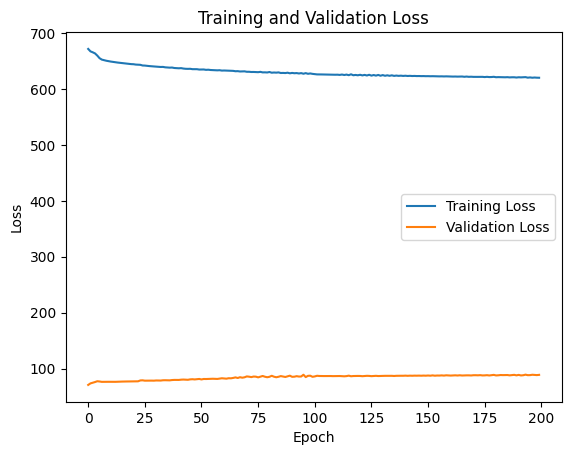

Model saved to models/trainable_gcesn_2l_enzymes.pth
Average Time per Epoch: 0.12s
Average CPU Usage: 20.42%
Average Memory Usage: 3.65GB
Average GPU Usage: 0.52GB
Average GPU Utilization: 10.16%

Total Training Time: 24.23s
Max CPU Usage: 51.55%
Max Memory Usage: 3.65GB
Max GPU Usage: 0.52GB
Max GPU Utilization: 13.00%
Fold 2 Results:
Accuracy: 0.1500
Average Sensitivity (Recall): 0.1619
Average Specificity: 0.8323

Fold 3/3
Epoch 1, Train Loss: 668.5349254608154, Val Loss: 70.05041313171387
Time: 0.13s, CPU: 33.35%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 4.00%
Epoch 2, Train Loss: 664.8709754943848, Val Loss: 72.56433773040771
Time: 0.15s, CPU: 28.35%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 8.00%
Epoch 3, Train Loss: 663.4883804321289, Val Loss: 73.24357795715332
Time: 0.12s, CPU: 28.95%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 10.00%
Epoch 4, Train Loss: 662.1081104278564, Val Loss: 73.65283012390137
Time: 0.12s, CPU: 30.10%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 11.00%
Epoch 5, Tra

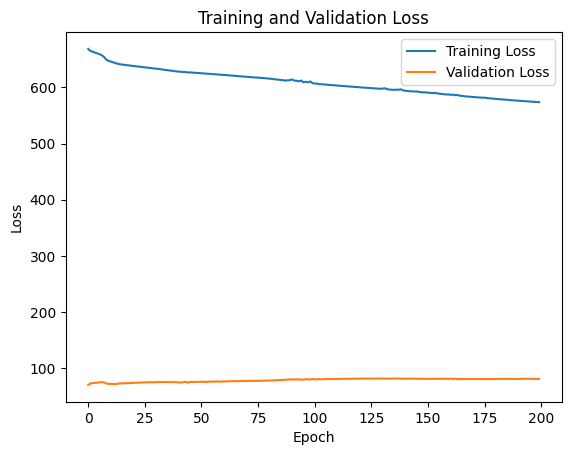

Model saved to models/trainable_gcesn_2l_enzymes.pth
Average Time per Epoch: 0.12s
Average CPU Usage: 20.75%
Average Memory Usage: 3.65GB
Average GPU Usage: 0.52GB
Average GPU Utilization: 10.49%

Total Training Time: 24.62s
Max CPU Usage: 52.50%
Max Memory Usage: 3.65GB
Max GPU Usage: 0.52GB
Max GPU Utilization: 13.00%
Fold 3 Results:
Accuracy: 0.1300
Average Sensitivity (Recall): 0.1354
Average Specificity: 0.8279
Cross-Validation Results:
accuracy: Mean = 0.1300, Std = 0.0163
sensitivity: Mean = 0.1352, Std = 0.0218
specificity: Mean = 0.8277, Std = 0.0039


In [37]:
set_seed(42)
trainable_gcesn_enzymes_2 = TrainableGCESN_2layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_enzymes_2.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_enzymes_2, enzymes_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_2l_enzymes.pth',
                binary_classification=False, is_esn=True)

#### OASIS

Total number of trainable parameters: 2563


Fold 1/3
Epoch 1, Train Loss: 236.76990234851837, Val Loss: 33.37216866016388
Time: 0.56s, CPU: 20.20%, Memory: 3.63GB, GPU: 0.52GB, GPU Util: 0.50%
Epoch 2, Train Loss: 229.92610824108124, Val Loss: 36.045971632003784
Time: 0.09s, CPU: 19.75%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 1.00%
Epoch 3, Train Loss: 226.66527330875397, Val Loss: 27.83365571498871
Time: 0.09s, CPU: 32.35%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 10.00%
Epoch 4, Train Loss: 224.8647575378418, Val Loss: 25.064736485481262
Time: 0.12s, CPU: 22.25%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 9.00%
Epoch 5, Train Loss: 222.13238084316254, Val Loss: 24.581702947616577
Time: 0.10s, CPU: 21.15%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 8.00%
Epoch 6, Train Loss: 221.14916932582855, Val Loss: 24.78441619873047
Time: 0.10s, CPU: 28.05%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 8.00%
Epoch 7, Train Loss: 219.81889986991882, Val Loss: 25.7409006357193
Time: 0.09s, CPU: 23.35%, Memory: 3

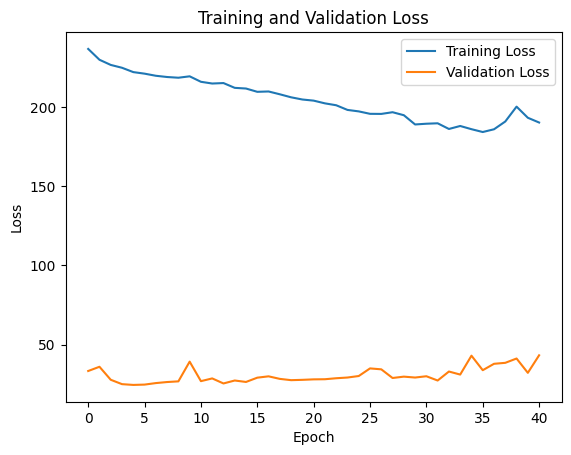

Model saved to models/trainable_gcesn_2l_oasis.pth
Average Time per Epoch: 0.10s
Average CPU Usage: 25.02%
Average Memory Usage: 3.65GB
Average GPU Usage: 0.52GB
Average GPU Utilization: 8.84%

Total Training Time: 4.14s
Max CPU Usage: 33.90%
Max Memory Usage: 3.65GB
Max GPU Usage: 0.52GB
Max GPU Utilization: 12.00%
Fold 1 Results:
Accuracy: 0.3684
Average Sensitivity (Recall): 0.3178
Average Specificity: 0.6573

Fold 2/3
Epoch 1, Train Loss: 239.15685725212097, Val Loss: 25.913259267807007
Time: 0.10s, CPU: 31.25%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 3.00%
Epoch 2, Train Loss: 233.47989082336426, Val Loss: 24.409818649291992
Time: 0.08s, CPU: 31.00%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 6.00%
Epoch 3, Train Loss: 229.23226833343506, Val Loss: 25.299814105033875
Time: 0.11s, CPU: 50.20%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 7.50%
Epoch 4, Train Loss: 226.28557181358337, Val Loss: 26.67599618434906
Time: 0.09s, CPU: 45.70%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 9.00%
Epoch 5, Tr

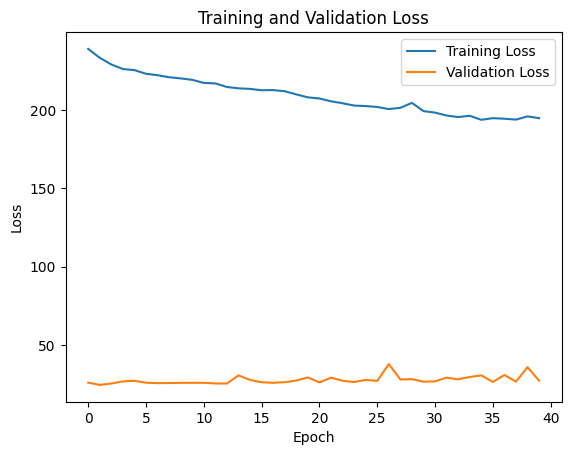

Model saved to models/trainable_gcesn_2l_oasis.pth
Average Time per Epoch: 0.08s
Average CPU Usage: 26.26%
Average Memory Usage: 3.65GB
Average GPU Usage: 0.52GB
Average GPU Utilization: 9.29%

Total Training Time: 3.32s
Max CPU Usage: 50.20%
Max Memory Usage: 3.65GB
Max GPU Usage: 0.52GB
Max GPU Utilization: 12.00%
Fold 2 Results:
Accuracy: 0.3596
Average Sensitivity (Recall): 0.3614
Average Specificity: 0.6874

Fold 3/3
Epoch 1, Train Loss: 235.83300924301147, Val Loss: 33.644954442977905
Time: 0.08s, CPU: 26.60%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 5.00%
Epoch 2, Train Loss: 232.83958673477173, Val Loss: 26.749863386154175
Time: 0.07s, CPU: 10.10%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 4.00%
Epoch 3, Train Loss: 230.08379864692688, Val Loss: 25.53130543231964
Time: 0.08s, CPU: 11.10%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 7.50%
Epoch 4, Train Loss: 228.6319500207901, Val Loss: 25.255544781684875
Time: 0.08s, CPU: 12.65%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 11.00%
Epoch 5, Tr

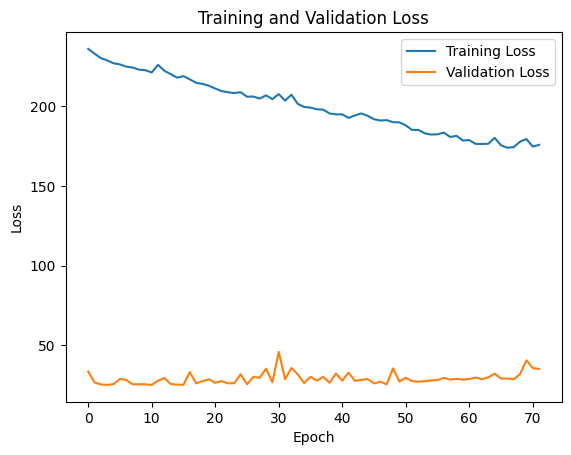

Model saved to models/trainable_gcesn_2l_oasis.pth
Average Time per Epoch: 0.08s
Average CPU Usage: 22.71%
Average Memory Usage: 3.65GB
Average GPU Usage: 0.52GB
Average GPU Utilization: 9.94%

Total Training Time: 5.85s
Max CPU Usage: 69.65%
Max Memory Usage: 3.65GB
Max GPU Usage: 0.52GB
Max GPU Utilization: 14.00%
Fold 3 Results:
Accuracy: 0.3596
Average Sensitivity (Recall): 0.3606
Average Specificity: 0.6799
Cross-Validation Results:
accuracy: Mean = 0.3626, Std = 0.0041
sensitivity: Mean = 0.3466, Std = 0.0204
specificity: Mean = 0.6749, Std = 0.0128


In [33]:
set_seed(42)
trainable_gcesn_oasis_2 = TrainableGCESN_2layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_oasis_2.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_oasis_2, oasis_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_2l_oasis.pth',
                binary_classification=False, is_esn=True)

#### EMCI-AD

Total number of trainable parameters: 2546


Fold 1/3
Epoch 1, Train Loss: 59.73772144317627, Val Loss: 24.579407215118408
Time: 0.03s, CPU: 15.25%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 1.00%
Epoch 2, Train Loss: 57.893752098083496, Val Loss: 6.734398663043976
Time: 0.03s, CPU: 14.35%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 1.00%
Epoch 3, Train Loss: 56.047329902648926, Val Loss: 7.869092166423798
Time: 0.03s, CPU: 12.90%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 1.00%
Epoch 4, Train Loss: 55.89693069458008, Val Loss: 7.846282124519348
Time: 0.03s, CPU: 8.00%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 5.00%
Epoch 5, Train Loss: 55.53629112243652, Val Loss: 6.8435211181640625
Time: 0.03s, CPU: 5.75%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 9.00%
Epoch 6, Train Loss: 55.06410503387451, Val Loss: 6.499619543552399
Time: 0.03s, CPU: 11.00%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 9.00%
Epoch 7, Train Loss: 54.67705821990967, Val Loss: 6.269858300685883
Time: 0.03s, CPU: 15.55%, Memory: 3.65GB, 

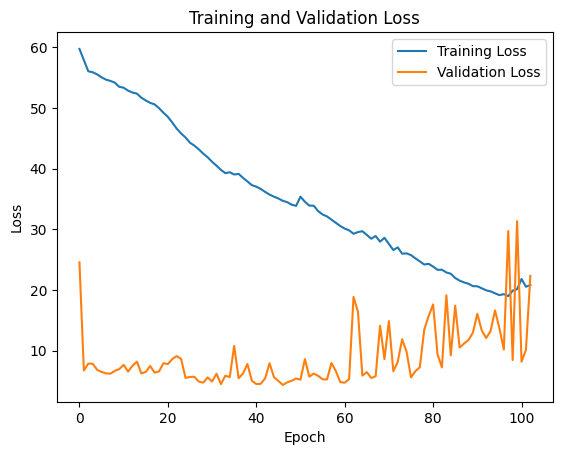

Model saved to models/trainable_gcesn_2l_emci.pth
Average Time per Epoch: 0.03s
Average CPU Usage: 17.55%
Average Memory Usage: 3.65GB
Average GPU Usage: 0.52GB
Average GPU Utilization: 8.22%

Total Training Time: 3.32s
Max CPU Usage: 48.50%
Max Memory Usage: 3.65GB
Max GPU Usage: 0.52GB
Max GPU Utilization: 11.00%
Fold 1 Results:
Accuracy: 0.5333
Average Sensitivity (Recall): 0.5435
Average Specificity: 0.5435

Fold 2/3
Epoch 1, Train Loss: 59.13617992401123, Val Loss: 25.904946327209473
Time: 0.04s, CPU: 21.55%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 1.00%
Epoch 2, Train Loss: 57.13179016113281, Val Loss: 12.653387546539307
Time: 0.04s, CPU: 7.80%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 1.00%
Epoch 3, Train Loss: 56.755757331848145, Val Loss: 8.898717105388641
Time: 0.04s, CPU: 7.60%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 3.50%
Epoch 4, Train Loss: 56.279287338256836, Val Loss: 7.249303936958313
Time: 0.03s, CPU: 5.75%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 6.00%
Epoch 5, Train Los

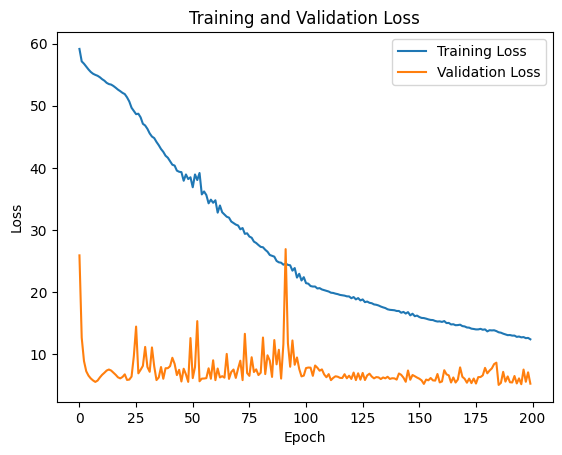

Model saved to models/trainable_gcesn_2l_emci.pth
Average Time per Epoch: 0.04s
Average CPU Usage: 22.98%
Average Memory Usage: 3.65GB
Average GPU Usage: 0.52GB
Average GPU Utilization: 7.82%

Total Training Time: 7.41s
Max CPU Usage: 56.40%
Max Memory Usage: 3.65GB
Max GPU Usage: 0.52GB
Max GPU Utilization: 11.00%
Fold 2 Results:
Accuracy: 0.6000
Average Sensitivity (Recall): 0.5900
Average Specificity: 0.5900

Fold 3/3
Epoch 1, Train Loss: 59.97485166788101, Val Loss: 32.56201100349426
Time: 0.04s, CPU: 31.75%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 1.00%
Epoch 2, Train Loss: 57.88485640287399, Val Loss: 16.459024786949158
Time: 0.03s, CPU: 22.50%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 1.00%
Epoch 3, Train Loss: 56.94227343797684, Val Loss: 11.415743350982666
Time: 0.03s, CPU: 21.15%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 1.00%
Epoch 4, Train Loss: 56.336790919303894, Val Loss: 9.176612734794617
Time: 0.04s, CPU: 24.55%, Memory: 3.65GB, GPU: 0.52GB, GPU Util: 5.00%
Epoch 5, Train L

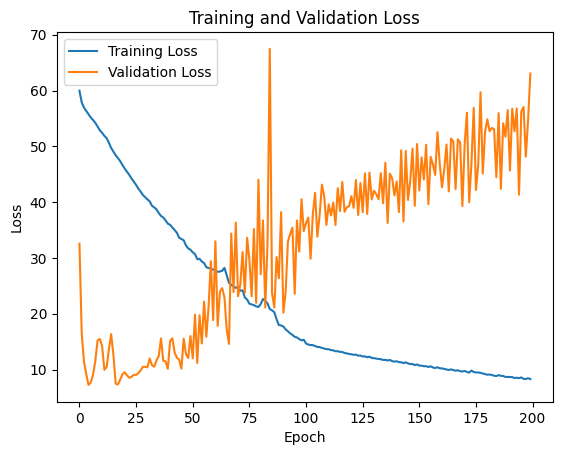

Model saved to models/trainable_gcesn_2l_emci.pth
Average Time per Epoch: 0.04s
Average CPU Usage: 28.99%
Average Memory Usage: 3.65GB
Average GPU Usage: 0.52GB
Average GPU Utilization: 7.99%

Total Training Time: 7.54s
Max CPU Usage: 73.35%
Max Memory Usage: 3.65GB
Max GPU Usage: 0.52GB
Max GPU Utilization: 10.00%
Fold 3 Results:
Accuracy: 0.3864
Average Sensitivity (Recall): 0.4221
Average Specificity: 0.4221
Cross-Validation Results:
accuracy: Mean = 0.5066, Std = 0.0892
sensitivity: Mean = 0.5185, Std = 0.0708
specificity: Mean = 0.5185, Std = 0.0708


In [34]:
set_seed(42)
trainable_gcesn_emci_2 = TrainableGCESN_2layer(emci_num_features, 2*emci_num_features, emci_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_emci_2.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_emci_2, emci_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_2l_emci.pth',
                binary_classification=False, is_esn=True)

### Trainable GCESN 3-Layer

#### MUTAG

Total number of trainable parameters: 2368


Fold 1/3
Epoch 1, Train Loss: 72.40575408935547, Val Loss: 9.029334127902985
Time: 2.32s, CPU: 11.00%, Memory: 4.08GB, GPU: 0.01GB, GPU Util: 0.00%
Epoch 2, Train Loss: 67.79453372955322, Val Loss: 8.985064804553986
Time: 0.03s, CPU: 29.60%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 3, Train Loss: 65.81188106536865, Val Loss: 8.966024160385132
Time: 0.03s, CPU: 20.60%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 2.50%
Epoch 4, Train Loss: 64.11329460144043, Val Loss: 8.944960355758667
Time: 0.03s, CPU: 20.85%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 5.00%
Epoch 5, Train Loss: 62.353251457214355, Val Loss: 8.904624223709106
Time: 0.03s, CPU: 26.50%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 5.00%
Epoch 6, Train Loss: 61.21245574951172, Val Loss: 8.865566611289978
Time: 0.03s, CPU: 27.35%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 5.00%
Epoch 7, Train Loss: 59.55460739135742, Val Loss: 8.798924744129181
Time: 0.03s, CPU: 22.95%, Memory: 4.89GB, G

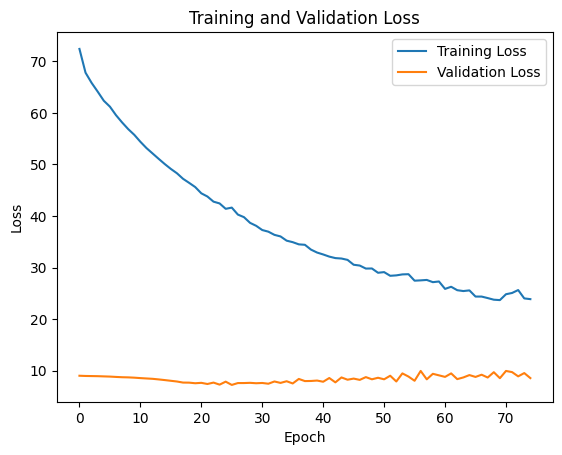

Model saved to models/trainable_gcesn_2l_mutag.pth
Average Time per Epoch: 0.06s
Average CPU Usage: 20.72%
Average Memory Usage: 4.88GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 11.16%

Total Training Time: 4.69s
Max CPU Usage: 35.85%
Max Memory Usage: 4.89GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 13.00%
Fold 1 Results:
Accuracy: 0.8730
Average Sensitivity (Recall): 0.9756
Average Specificity: 0.6818

Fold 2/3
Epoch 1, Train Loss: 71.10061168670654, Val Loss: 8.997863948345184
Time: 0.03s, CPU: 17.50%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 2, Train Loss: 64.22074127197266, Val Loss: 8.988372683525085
Time: 0.03s, CPU: 13.65%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 3, Train Loss: 62.09120178222656, Val Loss: 8.97865206003189
Time: 0.03s, CPU: 6.00%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 4, Train Loss: 59.693166732788086, Val Loss: 8.953632593154907
Time: 0.03s, CPU: 21.55%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 5, Train Los

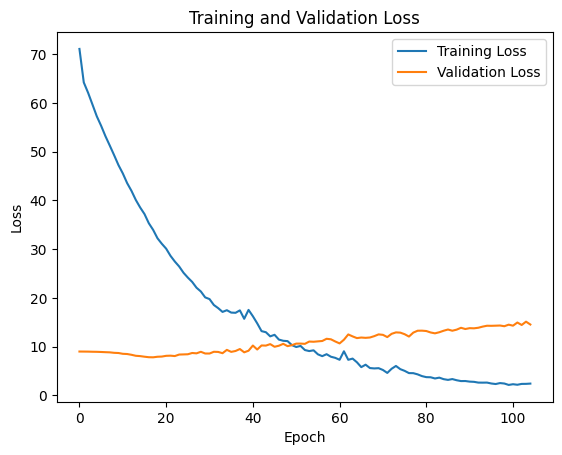

Model saved to models/trainable_gcesn_2l_mutag.pth
Average Time per Epoch: 0.03s
Average CPU Usage: 13.86%
Average Memory Usage: 4.89GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 12.06%

Total Training Time: 3.20s
Max CPU Usage: 48.15%
Max Memory Usage: 4.89GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 14.00%
Fold 2 Results:
Accuracy: 0.8254
Average Sensitivity (Recall): 0.8095
Average Specificity: 0.8571

Fold 3/3
Epoch 1, Train Loss: 73.47766470909119, Val Loss: 9.041125178337097
Time: 0.03s, CPU: 20.85%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 13.00%
Epoch 2, Train Loss: 68.19425946474075, Val Loss: 8.956045508384705
Time: 0.03s, CPU: 12.25%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 13.00%
Epoch 3, Train Loss: 64.84172028303146, Val Loss: 8.925115406513214
Time: 0.03s, CPU: 8.00%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 9.50%
Epoch 4, Train Loss: 63.12494778633118, Val Loss: 8.87290221452713
Time: 0.03s, CPU: 20.30%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 5, Train Lo

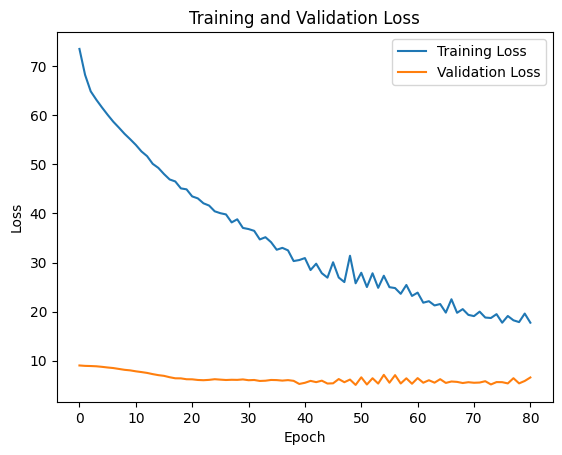

Model saved to models/trainable_gcesn_2l_mutag.pth
Average Time per Epoch: 0.03s
Average CPU Usage: 13.18%
Average Memory Usage: 4.89GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 11.91%

Total Training Time: 2.43s
Max CPU Usage: 40.40%
Max Memory Usage: 4.89GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 14.00%
Fold 3 Results:
Accuracy: 0.8065
Average Sensitivity (Recall): 0.8333
Average Specificity: 0.7500
Cross-Validation Results:
accuracy: Mean = 0.8350, Std = 0.0280
sensitivity: Mean = 0.8728, Std = 0.0733
specificity: Mean = 0.7630, Std = 0.0722


In [11]:
set_seed(42)
trainable_gcesn_mutag_3 = TrainableGCESN_3layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_mutag_3.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_mutag_3, mutag_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_2l_mutag.pth',
                binary_classification=True, is_esn=True)

#### PROTEINS

Total number of trainable parameters: 464


Fold 1/3
Epoch 1, Train Loss: 445.5197741985321, Val Loss: 74.23072117567062
Time: 0.19s, CPU: 17.00%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 5.00%
Epoch 2, Train Loss: 438.37771117687225, Val Loss: 74.17616754770279
Time: 0.15s, CPU: 24.65%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 14.50%
Epoch 3, Train Loss: 437.6016607284546, Val Loss: 73.64705818891525
Time: 0.16s, CPU: 44.45%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 20.00%
Epoch 4, Train Loss: 436.93834364414215, Val Loss: 72.80195021629333
Time: 0.17s, CPU: 37.85%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 20.50%
Epoch 5, Train Loss: 435.86833667755127, Val Loss: 78.07331001758575
Time: 0.14s, CPU: 34.55%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 20.00%
Epoch 6, Train Loss: 434.9418637752533, Val Loss: 78.22134494781494
Time: 0.14s, CPU: 39.80%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 21.50%
Epoch 7, Train Loss: 433.3628228902817, Val Loss: 71.4779965877533
Time: 0.15s, CPU: 26.05%, Memory: 4.89

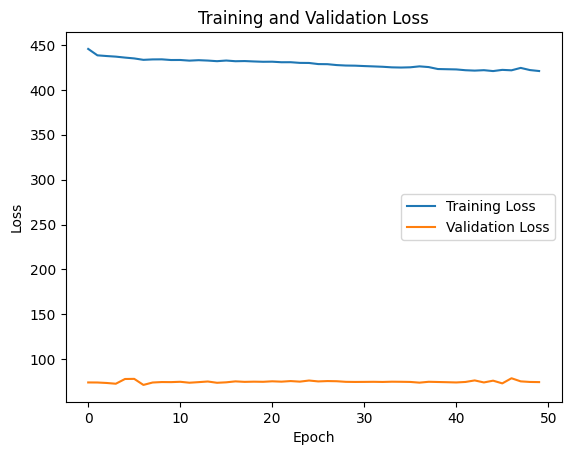

Model saved to models/trainable_gcesn_3l_proteins.pth
Average Time per Epoch: 0.15s
Average CPU Usage: 20.47%
Average Memory Usage: 4.89GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 21.46%

Total Training Time: 7.41s
Max CPU Usage: 44.45%
Max Memory Usage: 4.89GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 24.50%
Fold 1 Results:
Accuracy: 0.6280
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Fold 2/3
Epoch 1, Train Loss: 439.2282535433769, Val Loss: 69.43192547559738
Time: 0.14s, CPU: 18.90%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 16.50%
Epoch 2, Train Loss: 432.73860359191895, Val Loss: 69.56287574768066
Time: 0.14s, CPU: 11.60%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 18.50%
Epoch 3, Train Loss: 431.8807277083397, Val Loss: 69.66450107097626
Time: 0.14s, CPU: 11.25%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 23.00%
Epoch 4, Train Loss: 431.44912272691727, Val Loss: 69.75264090299606
Time: 0.14s, CPU: 11.25%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 22.50%
Epoch 5,

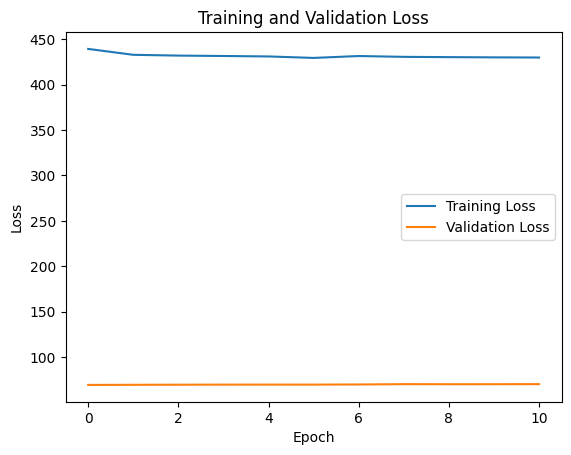

Model saved to models/trainable_gcesn_3l_proteins.pth
Average Time per Epoch: 0.14s
Average CPU Usage: 16.45%
Average Memory Usage: 4.89GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 21.68%

Total Training Time: 1.58s
Max CPU Usage: 26.45%
Max Memory Usage: 4.89GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 24.50%
Fold 2 Results:
Accuracy: 0.6038
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Fold 3/3
Epoch 1, Train Loss: 430.8769665360451, Val Loss: 69.60811871290207
Time: 0.16s, CPU: 32.60%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 2, Train Loss: 424.1032328605652, Val Loss: 69.84152954816818
Time: 0.16s, CPU: 21.25%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 21.00%
Epoch 3, Train Loss: 423.1150631904602, Val Loss: 70.0616005063057
Time: 0.16s, CPU: 22.90%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 20.50%
Epoch 4, Train Loss: 422.38615930080414, Val Loss: 70.23645132780075
Time: 0.15s, CPU: 32.70%, Memory: 4.89GB, GPU: 0.02GB, GPU Util: 21.00%
Epoch 5, Tr

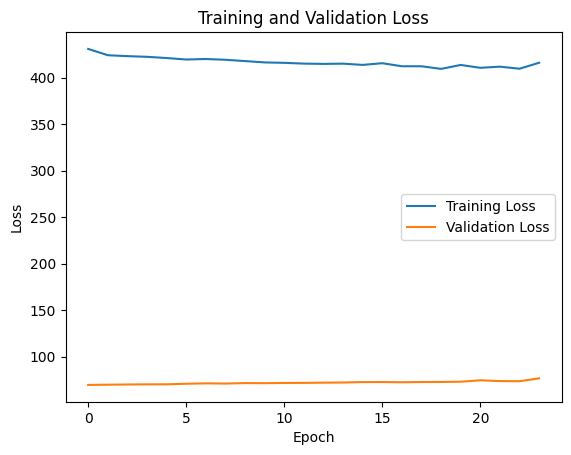

Model saved to models/trainable_gcesn_3l_proteins.pth
Average Time per Epoch: 0.15s
Average CPU Usage: 18.35%
Average Memory Usage: 4.89GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 21.17%

Total Training Time: 3.57s
Max CPU Usage: 32.70%
Max Memory Usage: 4.89GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 23.50%
Fold 3 Results:
Accuracy: 0.5553
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000
Cross-Validation Results:
accuracy: Mean = 0.5957, Std = 0.0303
sensitivity: Mean = 0.0000, Std = 0.0000
specificity: Mean = 1.0000, Std = 0.0000


In [12]:
set_seed(42)
trainable_gcesn_proteins_3 = TrainableGCESN_3layer(proteins_num_features, 2*proteins_num_features, proteins_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_proteins_3.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_proteins_3, proteins_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_3l_proteins.pth',
                binary_classification=True, is_esn=True)

#### DND

Total number of trainable parameters: 365792


Fold 1/3
Epoch 1, Train Loss: 599.8849432468414, Val Loss: 79.33947360515594
Time: 4.45s, CPU: 65.25%, Memory: 4.91GB, GPU: 0.02GB, GPU Util: 9.00%
Epoch 2, Train Loss: 469.05537021160126, Val Loss: 67.50913035869598
Time: 4.58s, CPU: 33.90%, Memory: 4.92GB, GPU: 0.03GB, GPU Util: 19.50%
Epoch 3, Train Loss: 490.6923431158066, Val Loss: 65.68906760215759
Time: 8.76s, CPU: 43.10%, Memory: 4.92GB, GPU: 0.03GB, GPU Util: 20.00%
Epoch 4, Train Loss: 493.545289516449, Val Loss: 67.54810237884521
Time: 4.42s, CPU: 47.95%, Memory: 4.92GB, GPU: 0.03GB, GPU Util: 27.00%
Epoch 5, Train Loss: 489.2663187980652, Val Loss: 70.12606257200241
Time: 8.18s, CPU: 53.25%, Memory: 4.92GB, GPU: 0.03GB, GPU Util: 8.50%
Epoch 6, Train Loss: 475.5290367603302, Val Loss: 67.26998776197433
Time: 8.32s, CPU: 52.85%, Memory: 4.92GB, GPU: 0.03GB, GPU Util: 19.00%
Epoch 7, Train Loss: 500.0255138874054, Val Loss: 71.93455469608307
Time: 5.88s, CPU: 43.15%, Memory: 4.92

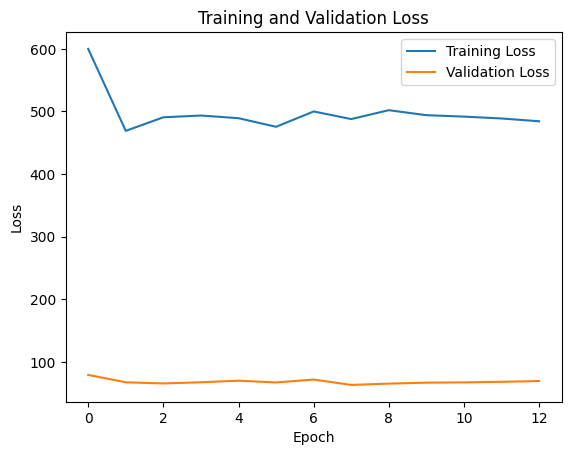

Model saved to models/trainable_gcesn_3l_dnd.pth
Average Time per Epoch: 6.82s
Average CPU Usage: 47.10%
Average Memory Usage: 4.92GB
Average GPU Usage: 0.03GB
Average GPU Utilization: 17.77%

Total Training Time: 88.63s
Max CPU Usage: 65.25%
Max Memory Usage: 4.92GB
Max GPU Usage: 0.03GB
Max GPU Utilization: 27.00%
Fold 1 Results:
Accuracy: 0.5980
Average Sensitivity (Recall): 0.0318
Average Specificity: 0.9746

Fold 2/3
Epoch 1, Train Loss: 619.0142638683319, Val Loss: 115.0913155078888
Time: 5.99s, CPU: 44.80%, Memory: 4.92GB, GPU: 0.02GB, GPU Util: 56.00%
Epoch 2, Train Loss: 468.0283622741699, Val Loss: 67.58636927604675
Time: 4.22s, CPU: 37.85%, Memory: 4.92GB, GPU: 0.03GB, GPU Util: 32.00%
Epoch 3, Train Loss: 498.72013211250305, Val Loss: 63.52314794063568
Time: 4.33s, CPU: 38.65%, Memory: 4.92GB, GPU: 0.03GB, GPU Util: 22.50%
Epoch 4, Train Loss: 502.98769783973694, Val Loss: 65.1818705201149
Time: 4.30s, CPU: 39.05%, Memory: 4.92GB, GPU: 0.03GB, GPU Util: 19.50%
Epoch 5, Trai

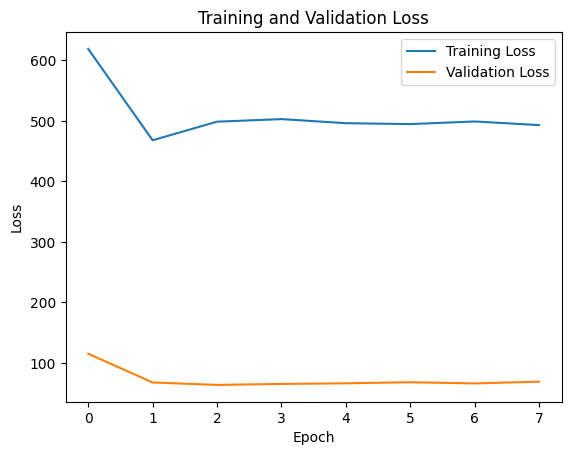

Model saved to models/trainable_gcesn_3l_dnd.pth
Average Time per Epoch: 4.83s
Average CPU Usage: 41.22%
Average Memory Usage: 4.92GB
Average GPU Usage: 0.03GB
Average GPU Utilization: 29.06%

Total Training Time: 38.62s
Max CPU Usage: 51.15%
Max Memory Usage: 4.92GB
Max GPU Usage: 0.03GB
Max GPU Utilization: 56.00%
Fold 2 Results:
Accuracy: 0.6031
Average Sensitivity (Recall): 0.0395
Average Specificity: 0.9585

Fold 3/3
Epoch 1, Train Loss: 582.3026648759842, Val Loss: 82.46619385480881
Time: 10.58s, CPU: 48.15%, Memory: 4.92GB, GPU: 0.02GB, GPU Util: 58.00%
Epoch 2, Train Loss: 458.42741560935974, Val Loss: 67.65185821056366
Time: 5.71s, CPU: 48.75%, Memory: 4.92GB, GPU: 0.04GB, GPU Util: 17.50%
Epoch 3, Train Loss: 475.1241762638092, Val Loss: 67.38915407657623
Time: 6.05s, CPU: 50.25%, Memory: 4.92GB, GPU: 0.04GB, GPU Util: 16.00%
Epoch 4, Train Loss: 480.514533162117, Val Loss: 68.2275892496109
Time: 11.91s, CPU: 51.50%, Memory: 4.92GB, GPU: 0.04GB, GPU Util: 16.50%
Epoch 5, Trai

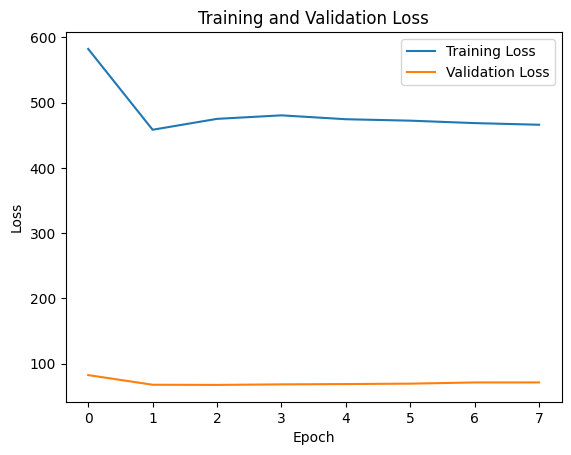

Model saved to models/trainable_gcesn_3l_dnd.pth
Average Time per Epoch: 7.58s
Average CPU Usage: 46.47%
Average Memory Usage: 4.92GB
Average GPU Usage: 0.04GB
Average GPU Utilization: 22.31%

Total Training Time: 60.68s
Max CPU Usage: 51.50%
Max Memory Usage: 4.92GB
Max GPU Usage: 0.04GB
Max GPU Utilization: 58.00%
Fold 3 Results:
Accuracy: 0.5434
Average Sensitivity (Recall): 0.0112
Average Specificity: 0.9860
Cross-Validation Results:
accuracy: Mean = 0.5815, Std = 0.0270
sensitivity: Mean = 0.0275, Std = 0.0119
specificity: Mean = 0.9730, Std = 0.0113


In [13]:
set_seed(42)
trainable_gcesn_dnd_3 = TrainableGCESN_3layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_dnd_3.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_dnd_3, dd_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_3l_dnd.pth',
                binary_classification=True, is_esn=True)

#### ENZYM

Total number of trainable parameters: 492


Fold 1/3
Epoch 1, Train Loss: 687.709882736206, Val Loss: 84.77248954772949
Time: 0.11s, CPU: 28.85%, Memory: 4.92GB, GPU: 0.02GB, GPU Util: 50.00%
Epoch 2, Train Loss: 681.8349285125732, Val Loss: 83.1944580078125
Time: 0.10s, CPU: 26.45%, Memory: 4.92GB, GPU: 0.02GB, GPU Util: 11.00%
Epoch 3, Train Loss: 678.299280166626, Val Loss: 82.48935127258301
Time: 0.08s, CPU: 23.65%, Memory: 4.92GB, GPU: 0.02GB, GPU Util: 13.00%
Epoch 4, Train Loss: 675.1200695037842, Val Loss: 82.02088165283203
Time: 0.08s, CPU: 19.05%, Memory: 4.92GB, GPU: 0.02GB, GPU Util: 13.00%
Epoch 5, Train Loss: 672.1345176696777, Val Loss: 81.91809844970703
Time: 0.08s, CPU: 28.35%, Memory: 4.92GB, GPU: 0.02GB, GPU Util: 14.50%
Epoch 6, Train Loss: 669.4935550689697, Val Loss: 81.95453453063965
Time: 0.08s, CPU: 36.15%, Memory: 4.92GB, GPU: 0.02GB, GPU Util: 16.00%
Epoch 7, Train Loss: 667.1791362762451, Val Loss: 81.61686515808105
Time: 0.08s, CPU: 28.50%, Memory: 4.92GB, 

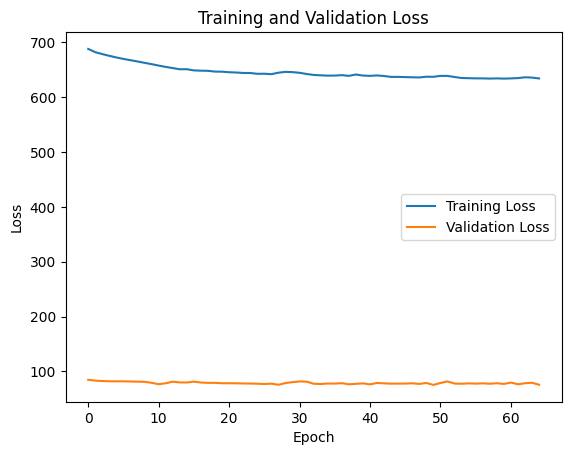

Model saved to models/trainable_gcesn_3l_enzymes.pth
Average Time per Epoch: 0.08s
Average CPU Usage: 14.94%
Average Memory Usage: 4.92GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 18.22%

Total Training Time: 5.25s
Max CPU Usage: 36.15%
Max Memory Usage: 4.92GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 50.00%
Fold 1 Results:
Accuracy: 0.1700
Average Sensitivity (Recall): 0.1944
Average Specificity: 0.8382

Fold 2/3
Epoch 1, Train Loss: 688.4337158203125, Val Loss: 91.68374824523926
Time: 0.09s, CPU: 35.45%, Memory: 4.92GB, GPU: 0.02GB, GPU Util: 13.00%
Epoch 2, Train Loss: 681.6977767944336, Val Loss: 87.3375358581543
Time: 0.09s, CPU: 45.45%, Memory: 4.92GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 3, Train Loss: 677.6561298370361, Val Loss: 84.86518478393555
Time: 0.08s, CPU: 33.10%, Memory: 4.92GB, GPU: 0.02GB, GPU Util: 11.00%
Epoch 4, Train Loss: 673.6690540313721, Val Loss: 83.20851707458496
Time: 0.09s, CPU: 18.75%, Memory: 4.92GB, GPU: 0.02GB, GPU Util: 16.00%
Epoch 5, Trai

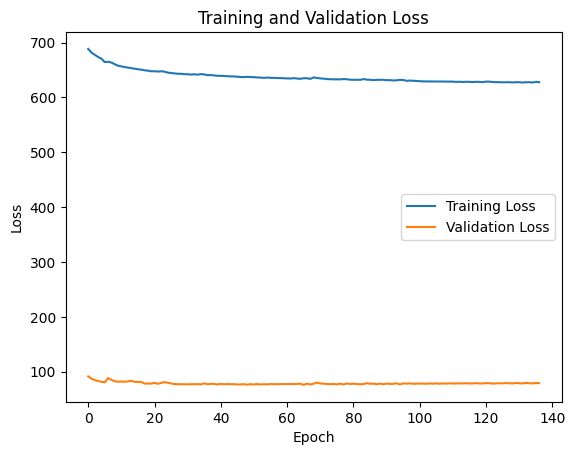

Model saved to models/trainable_gcesn_3l_enzymes.pth
Average Time per Epoch: 0.08s
Average CPU Usage: 13.27%
Average Memory Usage: 4.92GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 18.03%

Total Training Time: 11.08s
Max CPU Usage: 45.45%
Max Memory Usage: 4.92GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 20.00%
Fold 2 Results:
Accuracy: 0.1600
Average Sensitivity (Recall): 0.1744
Average Specificity: 0.8351

Fold 3/3
Epoch 1, Train Loss: 685.2020149230957, Val Loss: 91.73966979980469
Time: 0.09s, CPU: 31.25%, Memory: 4.92GB, GPU: 0.02GB, GPU Util: 13.00%
Epoch 2, Train Loss: 679.2678985595703, Val Loss: 87.9569034576416
Time: 0.09s, CPU: 29.35%, Memory: 4.92GB, GPU: 0.02GB, GPU Util: 12.50%
Epoch 3, Train Loss: 675.4557094573975, Val Loss: 86.28162384033203
Time: 0.08s, CPU: 28.10%, Memory: 4.92GB, GPU: 0.02GB, GPU Util: 12.00%
Epoch 4, Train Loss: 671.9780368804932, Val Loss: 85.19250297546387
Time: 0.09s, CPU: 24.05%, Memory: 4.92GB, GPU: 0.02GB, GPU Util: 15.00%
Epoch 5, Tr

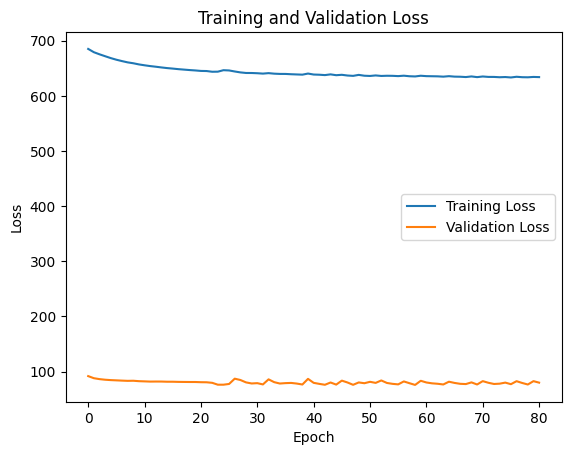

Model saved to models/trainable_gcesn_3l_enzymes.pth
Average Time per Epoch: 0.08s
Average CPU Usage: 21.68%
Average Memory Usage: 4.92GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 18.12%

Total Training Time: 6.79s
Max CPU Usage: 39.50%
Max Memory Usage: 4.92GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 20.00%
Fold 3 Results:
Accuracy: 0.1650
Average Sensitivity (Recall): 0.1788
Average Specificity: 0.8352
Cross-Validation Results:
accuracy: Mean = 0.1650, Std = 0.0041
sensitivity: Mean = 0.1825, Std = 0.0086
specificity: Mean = 0.8362, Std = 0.0014


In [14]:
set_seed(42)
trainable_gcesn_enzymes_3 = TrainableGCESN_3layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_enzymes_3.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_enzymes_3, enzymes_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_3l_enzymes.pth',
                binary_classification=False, is_esn=True)

### Trainable GCESN 4-Layer

#### MUTAG

Total number of trainable parameters: 7394


Fold 1/3
Epoch 1, Train Loss: 77.82048797607422, Val Loss: 8.656728565692902
Time: 0.05s, CPU: 35.65%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 2, Train Loss: 73.2670726776123, Val Loss: 8.465926945209503
Time: 0.04s, CPU: 37.50%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 4.50%
Epoch 3, Train Loss: 70.48058986663818, Val Loss: 8.23271256685257
Time: 0.04s, CPU: 35.10%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 4, Train Loss: 68.10978984832764, Val Loss: 8.066896319389343
Time: 0.05s, CPU: 35.00%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 5, Train Loss: 65.85671615600586, Val Loss: 8.001268744468689
Time: 0.04s, CPU: 22.85%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 6, Train Loss: 63.78555107116699, Val Loss: 8.018482267856598
Time: 0.04s, CPU: 36.40%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 9.50%
Epoch 7, Train Loss: 61.8891019821167, Val Loss: 8.095171749591827
Time: 0.05s, CPU: 52.90%, Memory: 4.95GB, GPU: 

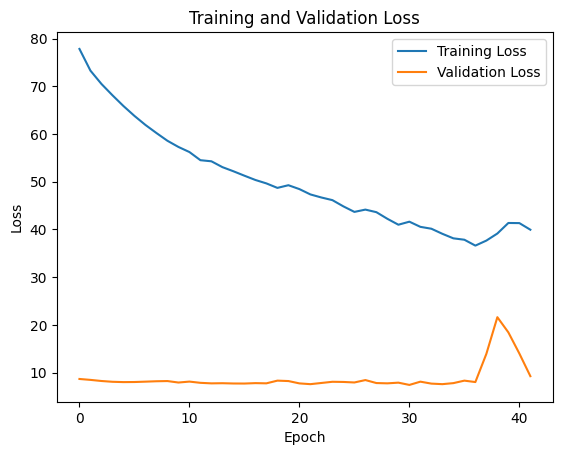

Model saved to models/trainable_gcesn_4l_mutag.pth
Average Time per Epoch: 0.04s
Average CPU Usage: 38.31%
Average Memory Usage: 4.95GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 11.96%

Total Training Time: 1.81s
Max CPU Usage: 61.80%
Max Memory Usage: 4.95GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 15.00%
Fold 1 Results:
Accuracy: 0.8889
Average Sensitivity (Recall): 0.8293
Average Specificity: 1.0000

Fold 2/3
Epoch 1, Train Loss: 75.11473751068115, Val Loss: 8.77408891916275
Time: 0.04s, CPU: 43.60%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 2, Train Loss: 70.2468786239624, Val Loss: 8.525325417518616
Time: 0.04s, CPU: 23.45%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 3, Train Loss: 65.97330856323242, Val Loss: 8.244657814502716
Time: 0.04s, CPU: 25.00%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 4, Train Loss: 63.23952007293701, Val Loss: 8.130744814872742
Time: 0.04s, CPU: 28.45%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 10.00%
Epoch 5, Train Los

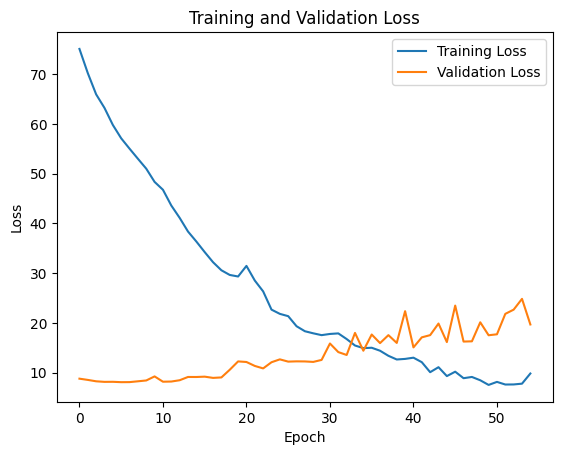

Model saved to models/trainable_gcesn_4l_mutag.pth
Average Time per Epoch: 0.07s
Average CPU Usage: 46.69%
Average Memory Usage: 4.95GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 10.27%

Total Training Time: 3.79s
Max CPU Usage: 73.55%
Max Memory Usage: 4.95GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 14.00%
Fold 2 Results:
Accuracy: 0.7778
Average Sensitivity (Recall): 0.7381
Average Specificity: 0.8571

Fold 3/3
Epoch 1, Train Loss: 77.41046684980392, Val Loss: 8.030202805995941
Time: 0.04s, CPU: 40.40%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 2, Train Loss: 71.15250873565674, Val Loss: 7.7837700843811035
Time: 0.04s, CPU: 45.15%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 3, Train Loss: 68.13417786359787, Val Loss: 7.4678966999053955
Time: 0.04s, CPU: 35.70%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 4, Train Loss: 65.42151689529419, Val Loss: 6.927794992923737
Time: 0.05s, CPU: 28.95%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 10.50%
Epoch 5, Train

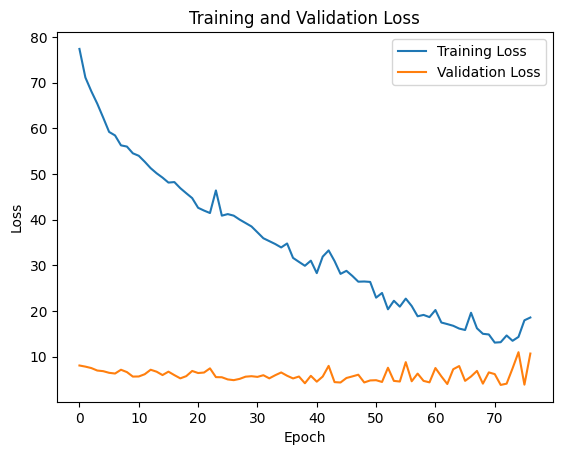

Model saved to models/trainable_gcesn_4l_mutag.pth
Average Time per Epoch: 0.07s
Average CPU Usage: 49.46%
Average Memory Usage: 4.95GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 9.71%

Total Training Time: 5.65s
Max CPU Usage: 86.70%
Max Memory Usage: 4.95GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 15.00%
Fold 3 Results:
Accuracy: 0.8065
Average Sensitivity (Recall): 0.9762
Average Specificity: 0.4500
Cross-Validation Results:
accuracy: Mean = 0.8244, Std = 0.0471
sensitivity: Mean = 0.8479, Std = 0.0981
specificity: Mean = 0.7690, Std = 0.2330


In [23]:
set_seed(42)
trainable_gcesn_mutag_4 = TrainableGCESN_4layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_mutag_4.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_mutag_4, mutag_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_4l_mutag.pth',
                binary_classification=True, is_esn=True)

#### PROTEINS

Total number of trainable parameters: 1418


Fold 1/3
Epoch 1, Train Loss: 456.2056305408478, Val Loss: 95.05184495449066
Time: 0.17s, CPU: 19.00%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 9.00%
Epoch 2, Train Loss: 432.9694048166275, Val Loss: 93.07387959957123
Time: 0.16s, CPU: 12.75%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 22.00%
Epoch 3, Train Loss: 429.48684549331665, Val Loss: 90.4321494102478
Time: 0.17s, CPU: 7.05%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 26.50%
Epoch 4, Train Loss: 427.2083201408386, Val Loss: 89.04377710819244
Time: 0.17s, CPU: 13.00%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 26.00%
Epoch 5, Train Loss: 425.824245929718, Val Loss: 89.15148055553436
Time: 0.17s, CPU: 13.45%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 26.00%
Epoch 6, Train Loss: 423.8770046234131, Val Loss: 88.77422618865967
Time: 0.16s, CPU: 11.05%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 25.00%
Epoch 7, Train Loss: 423.2282361984253, Val Loss: 84.70845079421997
Time: 0.16s, CPU: 11.05%, Memory: 4.95GB,

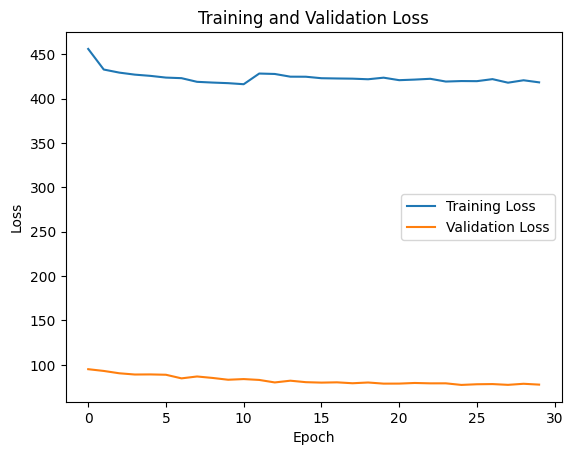

Model saved to models/trainable_gcesn_4l_proteins.pth
Average Time per Epoch: 0.17s
Average CPU Usage: 14.10%
Average Memory Usage: 4.95GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 25.35%

Total Training Time: 5.15s
Max CPU Usage: 31.70%
Max Memory Usage: 4.95GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 28.50%
Fold 1 Results:
Accuracy: 0.6280
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Fold 2/3
Epoch 1, Train Loss: 438.61805391311646, Val Loss: 67.9121264219284
Time: 0.17s, CPU: 20.45%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 2, Train Loss: 430.2396618127823, Val Loss: 67.14451307058334
Time: 0.16s, CPU: 10.85%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 17.00%
Epoch 3, Train Loss: 424.3514360189438, Val Loss: 66.85439366102219
Time: 0.17s, CPU: 7.50%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 27.50%
Epoch 4, Train Loss: 421.35197389125824, Val Loss: 66.44680893421173
Time: 0.16s, CPU: 14.65%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 29.00%
Epoch 5, Tr

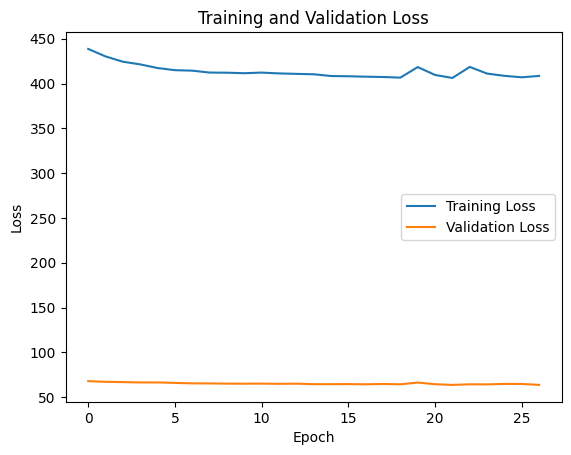

Model saved to models/trainable_gcesn_4l_proteins.pth
Average Time per Epoch: 0.17s
Average CPU Usage: 13.51%
Average Memory Usage: 4.95GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 25.33%

Total Training Time: 4.57s
Max CPU Usage: 27.55%
Max Memory Usage: 4.95GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 29.00%
Fold 2 Results:
Accuracy: 0.6038
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Fold 3/3
Epoch 1, Train Loss: 426.04321014881134, Val Loss: 68.2397271990776
Time: 0.17s, CPU: 19.60%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 2, Train Loss: 417.2712262868881, Val Loss: 68.17752921581268
Time: 0.18s, CPU: 14.05%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 16.50%
Epoch 3, Train Loss: 413.82643365859985, Val Loss: 68.00104743242264
Time: 0.17s, CPU: 11.90%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 24.50%
Epoch 4, Train Loss: 412.8558769226074, Val Loss: 67.79466742277145
Time: 0.17s, CPU: 13.90%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 25.50%
Epoch 5, T

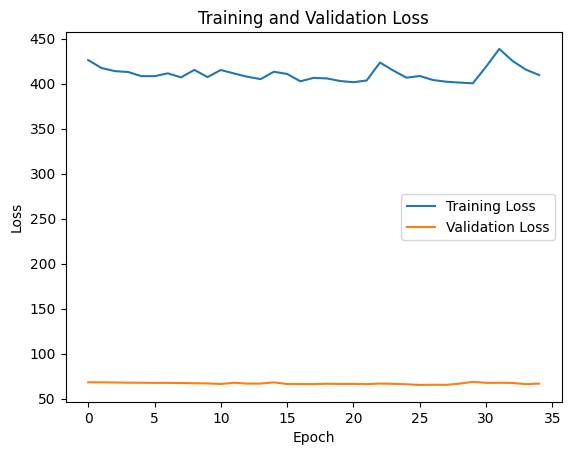

Model saved to models/trainable_gcesn_4l_proteins.pth
Average Time per Epoch: 0.17s
Average CPU Usage: 13.79%
Average Memory Usage: 4.95GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 24.14%

Total Training Time: 6.02s
Max CPU Usage: 30.00%
Max Memory Usage: 4.95GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 28.50%
Fold 3 Results:
Accuracy: 0.5553
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000
Cross-Validation Results:
accuracy: Mean = 0.5957, Std = 0.0303
sensitivity: Mean = 0.0000, Std = 0.0000
specificity: Mean = 1.0000, Std = 0.0000


In [24]:
set_seed(42)
trainable_gcesn_proteins_4 = TrainableGCESN_4layer(proteins_num_features, 2*proteins_num_features, proteins_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_proteins_4.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_proteins_4, proteins_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_4l_proteins.pth',
                binary_classification=True, is_esn=True)

#### DND

Total number of trainable parameters: 1159494


Fold 1/3
Epoch 1, Train Loss: 702.4491050243378, Val Loss: 106.48230576515198
Time: 11.09s, CPU: 51.00%, Memory: 4.96GB, GPU: 0.03GB, GPU Util: 0.50%
Epoch 2, Train Loss: 446.53982639312744, Val Loss: 61.60031569004059
Time: 14.04s, CPU: 39.70%, Memory: 4.97GB, GPU: 0.04GB, GPU Util: 1.50%
Epoch 3, Train Loss: 534.2214012145996, Val Loss: 62.004883110523224
Time: 17.74s, CPU: 49.00%, Memory: 4.97GB, GPU: 0.04GB, GPU Util: 15.00%
Epoch 4, Train Loss: 499.02879571914673, Val Loss: 62.44581389427185
Time: 15.78s, CPU: 47.85%, Memory: 4.97GB, GPU: 0.04GB, GPU Util: 9.00%
Epoch 5, Train Loss: 505.24110555648804, Val Loss: 66.81174302101135
Time: 17.32s, CPU: 41.70%, Memory: 4.97GB, GPU: 0.04GB, GPU Util: 1.00%
Epoch 6, Train Loss: 496.4937400817871, Val Loss: 62.922303557395935
Time: 16.68s, CPU: 49.85%, Memory: 4.97GB, GPU: 0.04GB, GPU Util: 0.50%
Early stopping at epoch 7


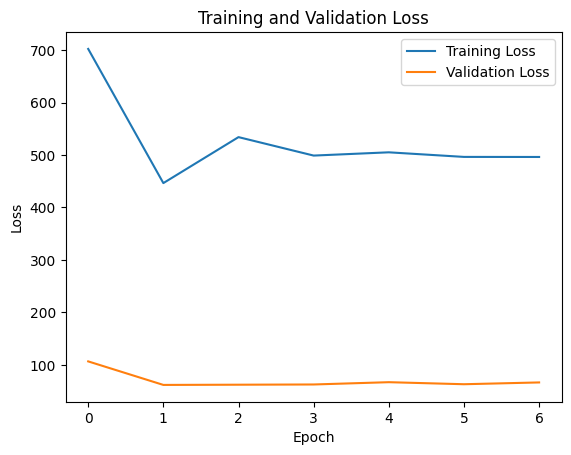

Model saved to models/trainable_gcesn_4l_dnd.pth
Average Time per Epoch: 15.35s
Average CPU Usage: 46.91%
Average Memory Usage: 4.96GB
Average GPU Usage: 0.04GB
Average GPU Utilization: 4.50%

Total Training Time: 107.44s
Max CPU Usage: 51.00%
Max Memory Usage: 4.97GB
Max GPU Usage: 0.04GB
Max GPU Utilization: 15.00%
Fold 1 Results:
Accuracy: 0.5903
Average Sensitivity (Recall): 0.0510
Average Specificity: 0.9492

Fold 2/3
Epoch 1, Train Loss: 749.2563614845276, Val Loss: 229.48507976531982
Time: 10.87s, CPU: 43.35%, Memory: 4.97GB, GPU: 0.03GB, GPU Util: 50.00%
Epoch 2, Train Loss: 449.862645983696, Val Loss: 60.47525942325592
Time: 19.81s, CPU: 44.15%, Memory: 4.97GB, GPU: 0.05GB, GPU Util: 2.50%
Epoch 3, Train Loss: 550.1218423843384, Val Loss: 60.7782045006752
Time: 15.49s, CPU: 40.20%, Memory: 4.97GB, GPU: 0.05GB, GPU Util: 4.00%
Epoch 4, Train Loss: 517.8852512836456, Val Loss: 61.31544554233551
Time: 10.70s, CPU: 38.20%, Memory: 4.97GB, GPU: 0.05GB, GPU Util: 2.50%
Epoch 5, Trai

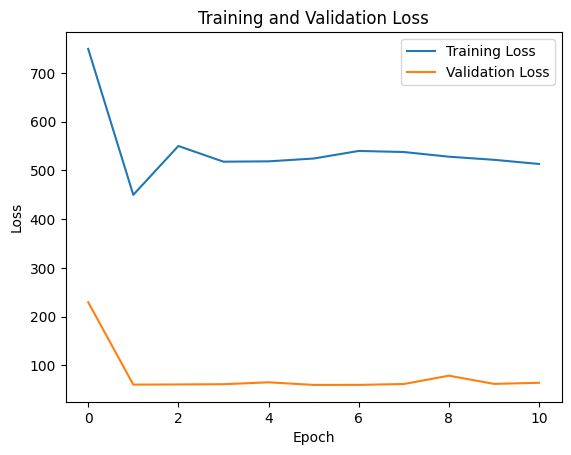

Model saved to models/trainable_gcesn_4l_dnd.pth
Average Time per Epoch: 12.20s
Average CPU Usage: 41.31%
Average Memory Usage: 4.97GB
Average GPU Usage: 0.05GB
Average GPU Utilization: 8.50%

Total Training Time: 134.15s
Max CPU Usage: 48.55%
Max Memory Usage: 4.97GB
Max GPU Usage: 0.05GB
Max GPU Utilization: 50.00%
Fold 2 Results:
Accuracy: 0.5725
Average Sensitivity (Recall): 0.0724
Average Specificity: 0.8880

Fold 3/3
Epoch 1, Train Loss: 660.4620053768158, Val Loss: 79.51488947868347
Time: 13.03s, CPU: 47.35%, Memory: 4.97GB, GPU: 0.03GB, GPU Util: 30.00%
Epoch 2, Train Loss: 440.1787109375, Val Loss: 64.40705198049545
Time: 11.22s, CPU: 36.25%, Memory: 4.97GB, GPU: 0.05GB, GPU Util: 1.50%
Epoch 3, Train Loss: 516.245080947876, Val Loss: 63.77017432451248
Time: 12.80s, CPU: 38.95%, Memory: 4.97GB, GPU: 0.05GB, GPU Util: 14.00%
Epoch 4, Train Loss: 494.66196739673615, Val Loss: 64.00335609912872
Time: 10.99s, CPU: 36.45%, Memory: 4.97GB, GPU: 0.05GB, GPU Util: 2.00%
Epoch 5, Train

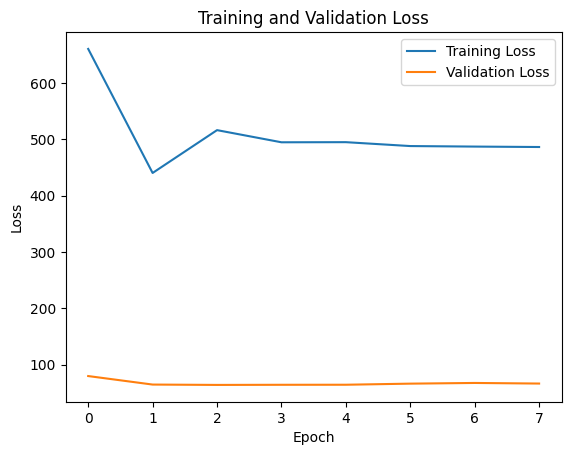

Model saved to models/trainable_gcesn_4l_dnd.pth
Average Time per Epoch: 13.74s
Average CPU Usage: 40.47%
Average Memory Usage: 4.97GB
Average GPU Usage: 0.05GB
Average GPU Utilization: 8.69%

Total Training Time: 109.91s
Max CPU Usage: 47.35%
Max Memory Usage: 4.97GB
Max GPU Usage: 0.05GB
Max GPU Utilization: 30.00%
Fold 3 Results:
Accuracy: 0.5434
Average Sensitivity (Recall): 0.0112
Average Specificity: 0.9860
Cross-Validation Results:
accuracy: Mean = 0.5687, Std = 0.0194
sensitivity: Mean = 0.0449, Std = 0.0253
specificity: Mean = 0.9410, Std = 0.0404


In [25]:
set_seed(42)
trainable_gcesn_dnd_4 = TrainableGCESN_4layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_dnd_4.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_dnd_4, dd_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_4l_dnd.pth',
                binary_classification=True, is_esn=True)

#### ENZYM

Total number of trainable parameters: 1470


Fold 1/3
Epoch 1, Train Loss: 662.8341026306152, Val Loss: 82.44617652893066
Time: 0.10s, CPU: 24.90%, Memory: 4.97GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 655.2355461120605, Val Loss: 80.53373527526855
Time: 0.09s, CPU: 26.30%, Memory: 4.97GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 3, Train Loss: 652.5137958526611, Val Loss: 80.90171432495117
Time: 0.09s, CPU: 18.70%, Memory: 4.97GB, GPU: 0.02GB, GPU Util: 12.00%
Epoch 4, Train Loss: 648.8629283905029, Val Loss: 79.93776893615723
Time: 0.10s, CPU: 21.85%, Memory: 4.97GB, GPU: 0.02GB, GPU Util: 18.00%
Epoch 5, Train Loss: 647.2325859069824, Val Loss: 80.17248725891113
Time: 0.11s, CPU: 42.65%, Memory: 4.97GB, GPU: 0.02GB, GPU Util: 17.00%
Epoch 6, Train Loss: 645.0617065429688, Val Loss: 80.43829345703125
Time: 0.10s, CPU: 36.30%, Memory: 4.97GB, GPU: 0.02GB, GPU Util: 16.00%
Epoch 7, Train Loss: 644.10959815979, Val Loss: 80.52837181091309
Time: 0.10s, CPU: 43.65%, Memory: 4.97GB, 

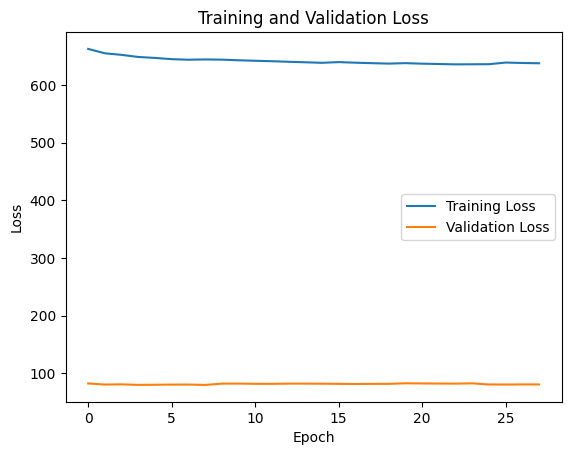

Model saved to models/trainable_gcesn_4l_enzymes.pth
Average Time per Epoch: 0.10s
Average CPU Usage: 22.01%
Average Memory Usage: 4.97GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 17.20%

Total Training Time: 2.82s
Max CPU Usage: 43.65%
Max Memory Usage: 4.97GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 21.00%
Fold 1 Results:
Accuracy: 0.1600
Average Sensitivity (Recall): 0.1842
Average Specificity: 0.8360

Fold 2/3
Epoch 1, Train Loss: 660.6182689666748, Val Loss: 87.95898628234863
Time: 0.10s, CPU: 22.25%, Memory: 4.97GB, GPU: 0.02GB, GPU Util: 11.00%
Epoch 2, Train Loss: 649.4807319641113, Val Loss: 84.94164848327637
Time: 0.10s, CPU: 6.60%, Memory: 4.97GB, GPU: 0.02GB, GPU Util: 14.50%
Epoch 3, Train Loss: 646.7918071746826, Val Loss: 84.82505989074707
Time: 0.10s, CPU: 16.60%, Memory: 4.97GB, GPU: 0.02GB, GPU Util: 18.00%
Epoch 4, Train Loss: 644.5569725036621, Val Loss: 84.65543937683105
Time: 0.10s, CPU: 10.20%, Memory: 4.97GB, GPU: 0.02GB, GPU Util: 19.00%
Epoch 5, Tra

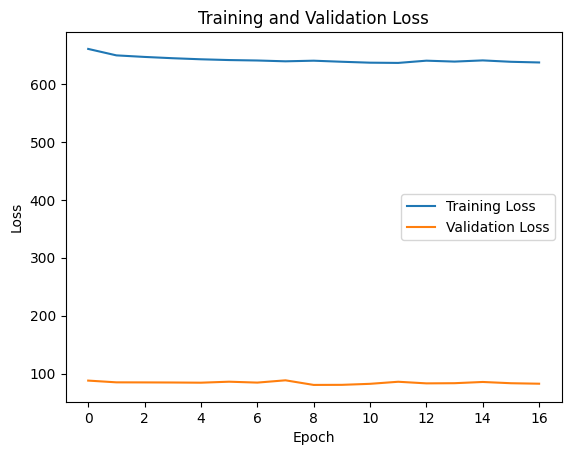

Model saved to models/trainable_gcesn_4l_enzymes.pth
Average Time per Epoch: 0.10s
Average CPU Usage: 11.72%
Average Memory Usage: 4.97GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 18.82%

Total Training Time: 1.67s
Max CPU Usage: 22.25%
Max Memory Usage: 4.97GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 23.00%
Fold 2 Results:
Accuracy: 0.1250
Average Sensitivity (Recall): 0.1389
Average Specificity: 0.8284

Fold 3/3
Epoch 1, Train Loss: 662.818531036377, Val Loss: 96.35097694396973
Time: 0.10s, CPU: 20.45%, Memory: 4.97GB, GPU: 0.02GB, GPU Util: 16.00%
Epoch 2, Train Loss: 655.0681858062744, Val Loss: 90.37983131408691
Time: 0.09s, CPU: 9.80%, Memory: 4.97GB, GPU: 0.02GB, GPU Util: 15.50%
Epoch 3, Train Loss: 652.0693759918213, Val Loss: 84.43553924560547
Time: 0.09s, CPU: 10.85%, Memory: 4.97GB, GPU: 0.02GB, GPU Util: 18.00%
Epoch 4, Train Loss: 653.5105972290039, Val Loss: 87.32275772094727
Time: 0.10s, CPU: 15.00%, Memory: 4.97GB, GPU: 0.02GB, GPU Util: 21.00%
Epoch 5, Trai

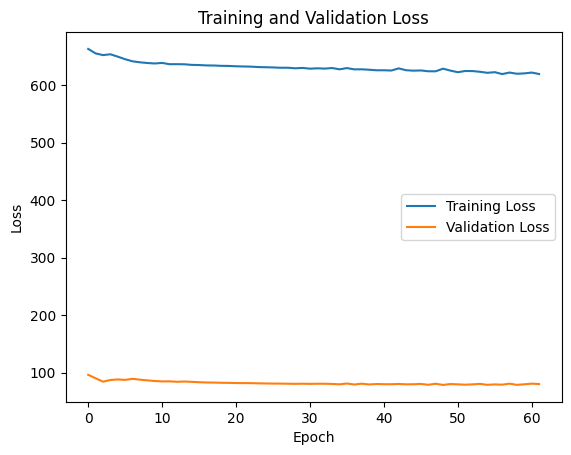

Model saved to models/trainable_gcesn_4l_enzymes.pth
Average Time per Epoch: 0.10s
Average CPU Usage: 18.69%
Average Memory Usage: 4.97GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 19.54%

Total Training Time: 6.20s
Max CPU Usage: 41.65%
Max Memory Usage: 4.97GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 22.00%
Fold 3 Results:
Accuracy: 0.1350
Average Sensitivity (Recall): 0.1430
Average Specificity: 0.8288
Cross-Validation Results:
accuracy: Mean = 0.1400, Std = 0.0147
sensitivity: Mean = 0.1554, Std = 0.0204
specificity: Mean = 0.8311, Std = 0.0035


In [26]:
set_seed(42)
trainable_gcesn_enzymes_4 = TrainableGCESN_4layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_enzymes_4.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_enzymes_4, enzymes_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_4l_enzymes.pth',
                binary_classification=False, is_esn=True)

### Trainable GCESN 5-Layer

#### MUTAG

Total number of trainable parameters: 7338


Fold 1/3
Epoch 1, Train Loss: 88.05671977996826, Val Loss: 9.792281806468964
Time: 0.06s, CPU: 31.20%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 80.98815059661865, Val Loss: 9.64097249507904
Time: 0.05s, CPU: 58.15%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 3, Train Loss: 80.19278812408447, Val Loss: 9.50301867723465
Time: 0.05s, CPU: 41.10%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 5.00%
Epoch 4, Train Loss: 78.36394309997559, Val Loss: 9.429819941520691
Time: 0.12s, CPU: 61.45%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 10.00%
Epoch 5, Train Loss: 77.11892509460449, Val Loss: 9.395869433879852
Time: 0.14s, CPU: 54.25%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 6, Train Loss: 76.02605628967285, Val Loss: 9.33964478969574
Time: 0.16s, CPU: 59.65%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 7, Train Loss: 75.11159133911133, Val Loss: 9.263359010219574
Time: 0.07s, CPU: 49.75%, Memory: 4.93GB, GPU:

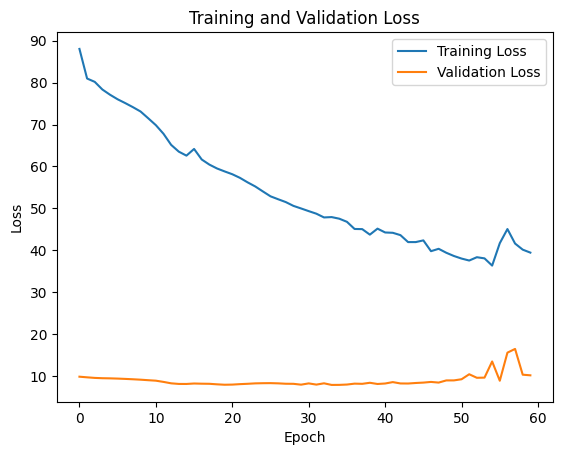

Model saved to models/trainable_gcesn_5l_mutag.pth
Average Time per Epoch: 0.07s
Average CPU Usage: 46.28%
Average Memory Usage: 4.93GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 9.93%

Total Training Time: 4.32s
Max CPU Usage: 83.70%
Max Memory Usage: 4.93GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 15.00%
Fold 1 Results:
Accuracy: 0.7937
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.4091

Fold 2/3
Epoch 1, Train Loss: 92.6791410446167, Val Loss: 9.42705523967743
Time: 0.05s, CPU: 38.70%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 14.00%
Epoch 2, Train Loss: 87.02960109710693, Val Loss: 9.344651937484741
Time: 0.05s, CPU: 40.55%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 10.50%
Epoch 3, Train Loss: 79.47446060180664, Val Loss: 9.2550687789917
Time: 0.05s, CPU: 22.95%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 4, Train Loss: 70.962721824646, Val Loss: 9.201554596424103
Time: 0.05s, CPU: 37.40%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 5, Train Loss: 6

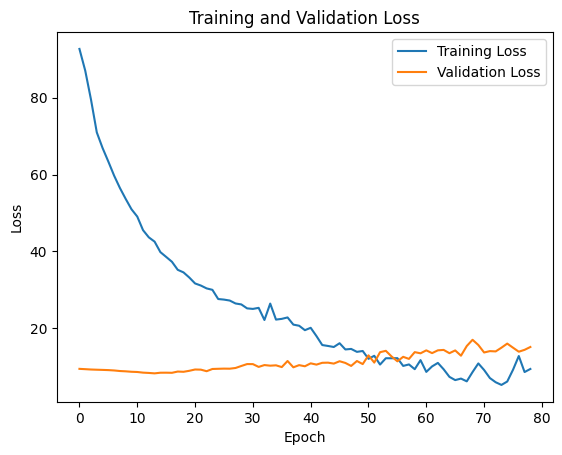

Model saved to models/trainable_gcesn_5l_mutag.pth
Average Time per Epoch: 0.05s
Average CPU Usage: 39.48%
Average Memory Usage: 4.93GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 12.91%

Total Training Time: 3.97s
Max CPU Usage: 64.35%
Max Memory Usage: 4.93GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 16.00%
Fold 2 Results:
Accuracy: 0.8095
Average Sensitivity (Recall): 0.7857
Average Specificity: 0.8571

Fold 3/3
Epoch 1, Train Loss: 91.32954627275467, Val Loss: 10.197250962257385
Time: 0.05s, CPU: 41.05%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 12.00%
Epoch 2, Train Loss: 83.41173654794693, Val Loss: 9.979511320590973
Time: 0.05s, CPU: 25.55%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 12.00%
Epoch 3, Train Loss: 74.3694857954979, Val Loss: 9.836949408054352
Time: 0.05s, CPU: 23.05%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 9.00%
Epoch 4, Train Loss: 69.29670470952988, Val Loss: 9.69471526145935
Time: 0.05s, CPU: 34.70%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 9.00%
Epoch 5, Train L

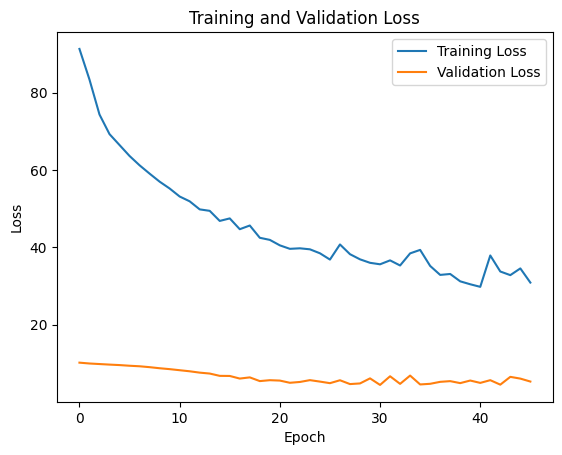

Model saved to models/trainable_gcesn_5l_mutag.pth
Average Time per Epoch: 0.05s
Average CPU Usage: 38.67%
Average Memory Usage: 4.93GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 12.35%

Total Training Time: 2.45s
Max CPU Usage: 64.40%
Max Memory Usage: 4.93GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 15.00%
Fold 3 Results:
Accuracy: 0.8065
Average Sensitivity (Recall): 0.8333
Average Specificity: 0.7500
Cross-Validation Results:
accuracy: Mean = 0.8032, Std = 0.0069
sensitivity: Mean = 0.8730, Std = 0.0919
specificity: Mean = 0.6721, Std = 0.1910


In [18]:
set_seed(42)
trainable_gcesn_mutag_5 = TrainableGCESN_5layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_mutag_5.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_mutag_5, mutag_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_5l_mutag.pth',
                binary_classification=True, is_esn=True)

#### PROTEINS

Total number of trainable parameters: 1394


Fold 1/3
Epoch 1, Train Loss: 454.75283658504486, Val Loss: 81.39022445678711
Time: 0.21s, CPU: 16.75%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 14.50%
Epoch 2, Train Loss: 444.51807403564453, Val Loss: 82.29448163509369
Time: 0.19s, CPU: 14.90%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 28.00%
Epoch 3, Train Loss: 441.6757342815399, Val Loss: 82.4943356513977
Time: 0.20s, CPU: 21.60%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 27.50%
Epoch 4, Train Loss: 439.7410386800766, Val Loss: 82.53948140144348
Time: 0.20s, CPU: 12.40%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 27.00%
Epoch 5, Train Loss: 438.27725982666016, Val Loss: 82.47194790840149
Time: 0.22s, CPU: 9.45%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 26.00%
Epoch 6, Train Loss: 437.12595438957214, Val Loss: 82.36926138401031
Time: 0.20s, CPU: 16.40%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 24.50%
Epoch 7, Train Loss: 436.27434158325195, Val Loss: 82.21797263622284
Time: 0.19s, CPU: 7.80%, Memory: 4.

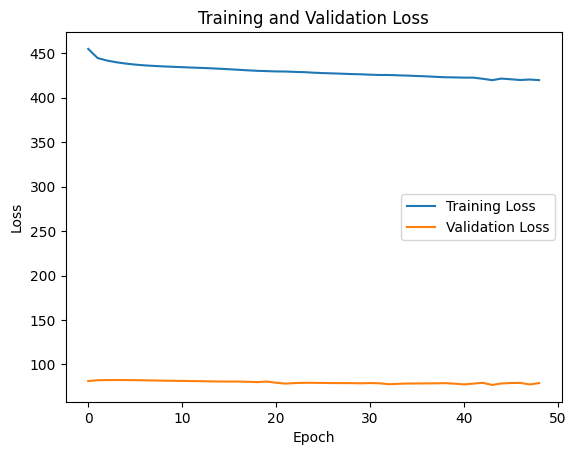

Model saved to models/trainable_gcesn_5l_proteins.pth
Average Time per Epoch: 0.20s
Average CPU Usage: 14.70%
Average Memory Usage: 4.93GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 26.65%

Total Training Time: 9.71s
Max CPU Usage: 32.65%
Max Memory Usage: 4.93GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 29.00%
Fold 1 Results:
Accuracy: 0.6226
Average Sensitivity (Recall): 0.0362
Average Specificity: 0.9700

Fold 2/3
Epoch 1, Train Loss: 447.51848578453064, Val Loss: 84.62856447696686
Time: 0.19s, CPU: 19.05%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 18.50%
Epoch 2, Train Loss: 438.99332106113434, Val Loss: 84.68117070198059
Time: 0.19s, CPU: 11.70%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 28.00%
Epoch 3, Train Loss: 435.9135048389435, Val Loss: 84.6367975473404
Time: 0.20s, CPU: 10.80%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 28.50%
Epoch 4, Train Loss: 433.93779051303864, Val Loss: 84.60521280765533
Time: 0.19s, CPU: 8.55%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 23.00%
Epoch 5, 

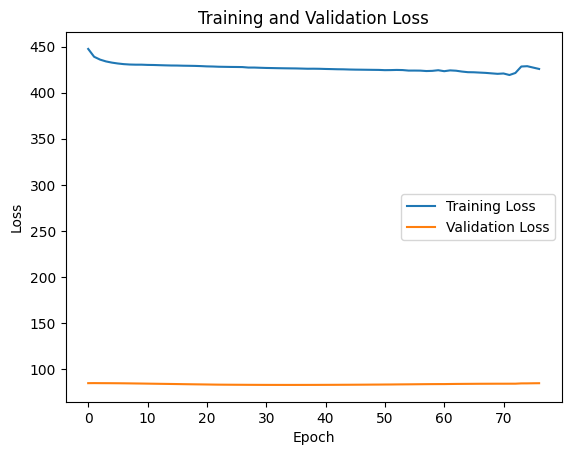

Model saved to models/trainable_gcesn_5l_proteins.pth
Average Time per Epoch: 0.20s
Average CPU Usage: 16.79%
Average Memory Usage: 4.93GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 26.62%

Total Training Time: 15.65s
Max CPU Usage: 47.60%
Max Memory Usage: 4.93GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 29.50%
Fold 2 Results:
Accuracy: 0.6038
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Fold 3/3
Epoch 1, Train Loss: 434.5058745145798, Val Loss: 84.75806844234467
Time: 0.20s, CPU: 21.85%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 18.00%
Epoch 2, Train Loss: 426.26669132709503, Val Loss: 84.99355351924896
Time: 0.20s, CPU: 10.55%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 27.50%
Epoch 3, Train Loss: 423.29668855667114, Val Loss: 85.12904500961304
Time: 0.19s, CPU: 9.05%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 26.50%
Epoch 4, Train Loss: 421.33348166942596, Val Loss: 85.30792486667633
Time: 0.20s, CPU: 10.30%, Memory: 4.93GB, GPU: 0.02GB, GPU Util: 26.00%
Epoch 5

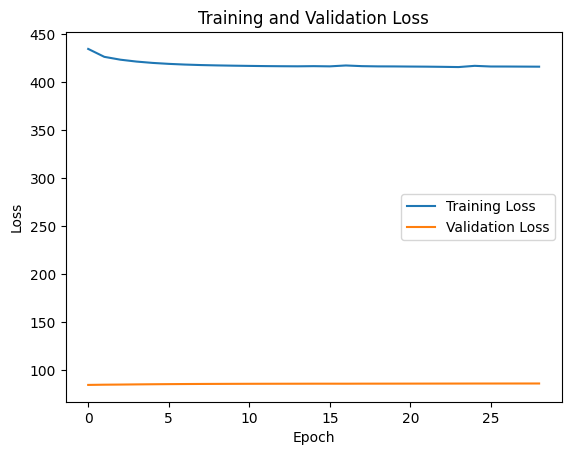

Model saved to models/trainable_gcesn_5l_proteins.pth
Average Time per Epoch: 0.20s
Average CPU Usage: 22.30%
Average Memory Usage: 4.93GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 25.83%

Total Training Time: 5.93s
Max CPU Usage: 41.50%
Max Memory Usage: 4.93GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 28.50%
Fold 3 Results:
Accuracy: 0.5553
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000
Cross-Validation Results:
accuracy: Mean = 0.5939, Std = 0.0284
sensitivity: Mean = 0.0121, Std = 0.0171
specificity: Mean = 0.9900, Std = 0.0142


In [19]:
set_seed(42)
trainable_gcesn_proteins_5 = TrainableGCESN_5layer(proteins_num_features, 2*proteins_num_features, proteins_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_proteins_5.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_proteins_5, proteins_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_5l_proteins.pth',
                binary_classification=True, is_esn=True)

#### DND

Total number of trainable parameters: 1158782


Fold 1/3
Epoch 1, Train Loss: 577.241494178772, Val Loss: 87.0279335975647
Time: 14.07s, CPU: 69.65%, Memory: 4.94GB, GPU: 0.03GB, GPU Util: 0.50%
Epoch 2, Train Loss: 466.55895948410034, Val Loss: 59.990535497665405
Time: 18.97s, CPU: 49.10%, Memory: 4.94GB, GPU: 0.04GB, GPU Util: 16.00%
Epoch 3, Train Loss: 479.72178745269775, Val Loss: 58.881363451480865
Time: 14.45s, CPU: 44.45%, Memory: 4.94GB, GPU: 0.04GB, GPU Util: 2.00%
Epoch 4, Train Loss: 484.1367440223694, Val Loss: 59.33671301603317
Time: 13.88s, CPU: 36.80%, Memory: 4.94GB, GPU: 0.04GB, GPU Util: 15.00%
Epoch 5, Train Loss: 477.85814571380615, Val Loss: 65.19265538454056
Time: 19.61s, CPU: 45.45%, Memory: 4.94GB, GPU: 0.04GB, GPU Util: 18.50%
Epoch 6, Train Loss: 467.37570309638977, Val Loss: 64.85269844532013
Time: 16.92s, CPU: 43.90%, Memory: 4.94GB, GPU: 0.04GB, GPU Util: 1.00%
Epoch 7, Train Loss: 470.5887231826782, Val Loss: 69.78392350673676
Time: 16.42s, CPU: 39.15%, M

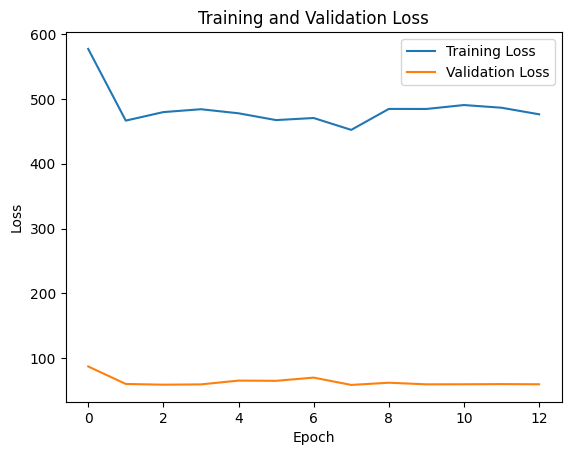

Model saved to models/trainable_gcesn_5l_dnd.pth
Average Time per Epoch: 15.31s
Average CPU Usage: 44.97%
Average Memory Usage: 4.94GB
Average GPU Usage: 0.04GB
Average GPU Utilization: 8.38%

Total Training Time: 199.08s
Max CPU Usage: 69.65%
Max Memory Usage: 4.94GB
Max GPU Usage: 0.04GB
Max GPU Utilization: 18.50%
Fold 1 Results:
Accuracy: 0.6005
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Fold 2/3
Epoch 1, Train Loss: 596.5955789089203, Val Loss: 120.2479317188263
Time: 13.11s, CPU: 40.05%, Memory: 4.94GB, GPU: 0.03GB, GPU Util: 46.50%
Epoch 2, Train Loss: 472.3945186138153, Val Loss: 59.85822540521622
Time: 19.37s, CPU: 42.20%, Memory: 4.94GB, GPU: 0.05GB, GPU Util: 6.50%
Epoch 3, Train Loss: 493.17990136146545, Val Loss: 58.5500505566597
Time: 21.04s, CPU: 43.90%, Memory: 4.94GB, GPU: 0.05GB, GPU Util: 1.00%
Epoch 4, Train Loss: 492.19536900520325, Val Loss: 59.984378695487976
Time: 13.39s, CPU: 39.85%, Memory: 4.95GB, GPU: 0.05GB, GPU Util: 2.50%
Epoch 5, T

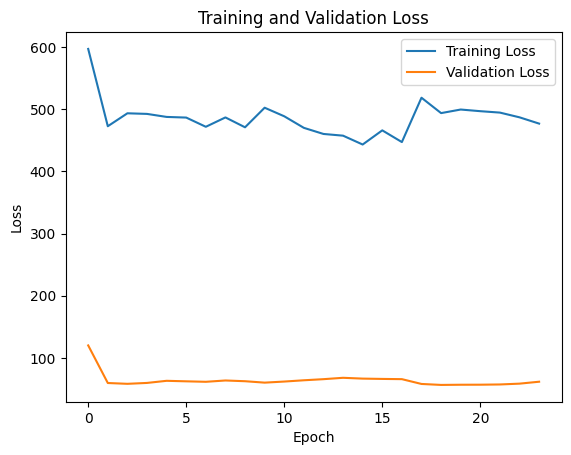

Model saved to models/trainable_gcesn_5l_dnd.pth
Average Time per Epoch: 16.01s
Average CPU Usage: 43.94%
Average Memory Usage: 4.95GB
Average GPU Usage: 0.05GB
Average GPU Utilization: 10.92%

Total Training Time: 384.36s
Max CPU Usage: 56.25%
Max Memory Usage: 4.95GB
Max GPU Usage: 0.05GB
Max GPU Utilization: 46.50%
Fold 2 Results:
Accuracy: 0.6031
Average Sensitivity (Recall): 0.0329
Average Specificity: 0.9627

Fold 3/3
Epoch 1, Train Loss: 566.3428944349289, Val Loss: 64.79914474487305
Time: 12.11s, CPU: 50.35%, Memory: 4.95GB, GPU: 0.03GB, GPU Util: 37.50%
Epoch 2, Train Loss: 456.42282152175903, Val Loss: 61.45363122224808
Time: 14.79s, CPU: 40.20%, Memory: 4.95GB, GPU: 0.05GB, GPU Util: 24.00%
Epoch 3, Train Loss: 469.1817833185196, Val Loss: 60.29741084575653
Time: 12.02s, CPU: 36.60%, Memory: 4.95GB, GPU: 0.05GB, GPU Util: 3.00%
Epoch 4, Train Loss: 473.7444990873337, Val Loss: 61.52791875600815
Time: 13.62s, CPU: 41.80%, Memory: 4.95GB, GPU: 0.05GB, GPU Util: 18.50%
Epoch 5,

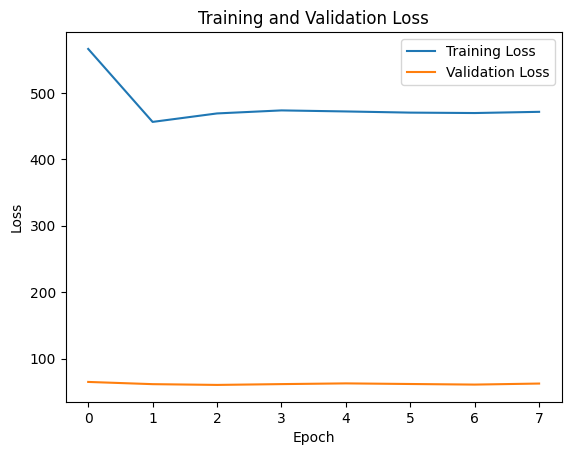

Model saved to models/trainable_gcesn_5l_dnd.pth
Average Time per Epoch: 12.97s
Average CPU Usage: 41.36%
Average Memory Usage: 4.95GB
Average GPU Usage: 0.05GB
Average GPU Utilization: 16.00%

Total Training Time: 103.78s
Max CPU Usage: 50.35%
Max Memory Usage: 4.95GB
Max GPU Usage: 0.05GB
Max GPU Utilization: 37.50%
Fold 3 Results:
Accuracy: 0.5434
Average Sensitivity (Recall): 0.0112
Average Specificity: 0.9860
Cross-Validation Results:
accuracy: Mean = 0.5823, Std = 0.0276
sensitivity: Mean = 0.0147, Std = 0.0137
specificity: Mean = 0.9829, Std = 0.0154


In [20]:
set_seed(42)
trainable_gcesn_dnd_5 = TrainableGCESN_5layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_dnd_5.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_dnd_5, dd_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_5l_dnd.pth',
                binary_classification=True, is_esn=True)

#### ENZYM

Total number of trainable parameters: 1422


Fold 1/3
Epoch 1, Train Loss: 645.6432514190674, Val Loss: 78.19127655029297
Time: 0.12s, CPU: 26.55%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 80.00%
Epoch 2, Train Loss: 641.7963752746582, Val Loss: 77.22590255737305
Time: 0.12s, CPU: 22.40%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 46.50%
Epoch 3, Train Loss: 640.7593479156494, Val Loss: 77.25375556945801
Time: 0.12s, CPU: 24.50%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 16.00%
Epoch 4, Train Loss: 639.8999176025391, Val Loss: 77.4866189956665
Time: 0.12s, CPU: 27.05%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 19.00%
Epoch 5, Train Loss: 639.5490779876709, Val Loss: 77.57461357116699
Time: 0.12s, CPU: 25.00%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 18.00%
Epoch 6, Train Loss: 639.1929893493652, Val Loss: 77.54837989807129
Time: 0.12s, CPU: 31.10%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 18.00%
Epoch 7, Train Loss: 638.8912620544434, Val Loss: 77.54632663726807
Time: 0.12s, CPU: 36.55%, Memory: 4.95G

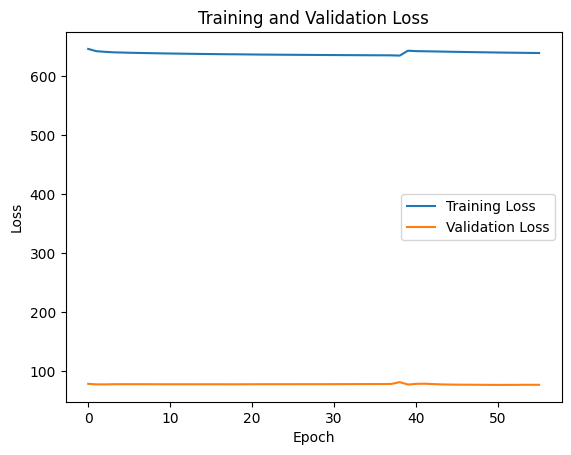

Model saved to models/trainable_gcesn_5l_enzymes.pth
Average Time per Epoch: 0.12s
Average CPU Usage: 18.41%
Average Memory Usage: 4.95GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 22.21%

Total Training Time: 6.46s
Max CPU Usage: 41.70%
Max Memory Usage: 4.95GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 80.00%
Fold 1 Results:
Accuracy: 0.1700
Average Sensitivity (Recall): 0.1900
Average Specificity: 0.8369

Fold 2/3
Epoch 1, Train Loss: 655.788028717041, Val Loss: 87.4099349975586
Time: 0.12s, CPU: 21.35%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 11.00%
Epoch 2, Train Loss: 651.675464630127, Val Loss: 83.0218620300293
Time: 0.11s, CPU: 10.40%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 15.00%
Epoch 3, Train Loss: 650.5710372924805, Val Loss: 81.36962127685547
Time: 0.11s, CPU: 11.35%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 20.50%
Epoch 4, Train Loss: 649.6524677276611, Val Loss: 80.58274459838867
Time: 0.11s, CPU: 6.65%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 22.00%
Epoch 5, Train L

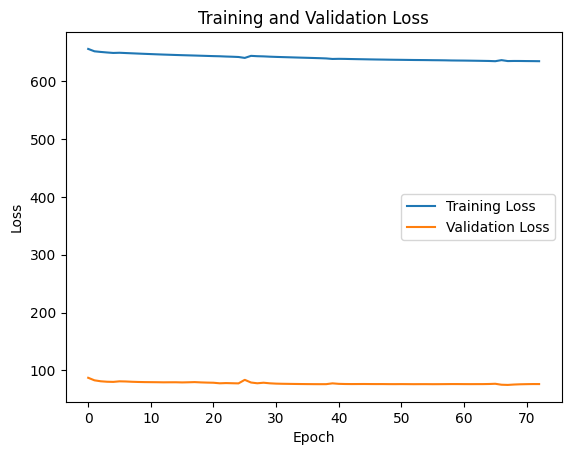

Model saved to models/trainable_gcesn_5l_enzymes.pth
Average Time per Epoch: 0.12s
Average CPU Usage: 20.02%
Average Memory Usage: 4.95GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 20.22%

Total Training Time: 8.66s
Max CPU Usage: 46.15%
Max Memory Usage: 4.95GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 23.00%
Fold 2 Results:
Accuracy: 0.1300
Average Sensitivity (Recall): 0.1494
Average Specificity: 0.8291

Fold 3/3
Epoch 1, Train Loss: 648.4159564971924, Val Loss: 80.61475372314453
Time: 0.12s, CPU: 20.70%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 15.50%
Epoch 2, Train Loss: 643.5665225982666, Val Loss: 78.97039604187012
Time: 0.11s, CPU: 14.85%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 15.50%
Epoch 3, Train Loss: 642.9183282852173, Val Loss: 79.72664642333984
Time: 0.11s, CPU: 7.05%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 22.00%
Epoch 4, Train Loss: 642.433162689209, Val Loss: 78.43632507324219
Time: 0.12s, CPU: 12.45%, Memory: 4.95GB, GPU: 0.02GB, GPU Util: 21.50%
Epoch 5, Trai

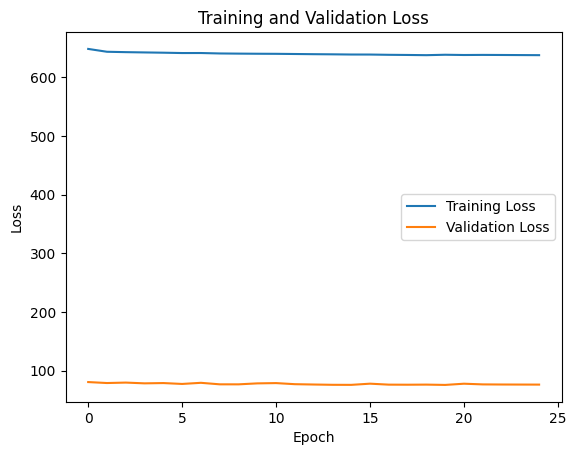

Model saved to models/trainable_gcesn_5l_enzymes.pth
Average Time per Epoch: 0.11s
Average CPU Usage: 15.29%
Average Memory Usage: 4.95GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 21.52%

Total Training Time: 2.83s
Max CPU Usage: 30.00%
Max Memory Usage: 4.95GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 24.00%
Fold 3 Results:
Accuracy: 0.1950
Average Sensitivity (Recall): 0.1929
Average Specificity: 0.8384
Cross-Validation Results:
accuracy: Mean = 0.1650, Std = 0.0268
sensitivity: Mean = 0.1774, Std = 0.0198
specificity: Mean = 0.8348, Std = 0.0041


In [21]:
set_seed(42)
trainable_gcesn_enzymes_5 = TrainableGCESN_5layer(enzymes_num_features, 2*enzymes_num_features, enzymes_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_enzymes_5.count_parameters()}\n")
                
avg_metrics = single_train_test_cv(trainable_gcesn_enzymes_5, enzymes_dataset,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_5l_enzymes.pth',
                binary_classification=False, is_esn=True)